# **Get started**
*  Feature selection
    *  Want(Adjustment & Confounder)
    *  Remove(Instrumental & Spurious)
    *  Heatmap
*  Recommendation System
    *  Calculate propensity score
    *  Histogram of propensity score for train and test data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Causality/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Prepare data***



#### Read data under file

In [16]:
import pandas as pd
import glob
import re
import numpy as np
from datetime import datetime
from copy import deepcopy

def process_codiet(patient_site_csv: str, bio_col_matching_csv: str, petr_cleaned_pattern: str, output_route: str = None):
    ## drugs.csv
    def build_drug_presence_table(df):
        """
        从药物与补充剂 CSV 中提取每个患者的药物使用情况表（1/0矩阵）
        """
        drug_list = ['Magnesium Biglycinate', 'Omega 3-6-9', 'B12 Fix', 'T4', 'Paracetamol', 'Diazepam', 'Folic Acid',
        'Thyrohormone', 'Finasteride', 'Cipralex', 'Venlafaxine', 'Simvastatina', 'Melatonin', 'Levotiroxin',
        'D3', 'Omeprazole', 'Pantoprazol', 'Atorvastatin', 'Sertraline', 'Quetiapine', 'Triptizol', 'Loratadine',
        'Gingo Biloba', 'Cosyrel', 'Cascara Sagrada', 'Collagen', 'Inmunoferon', 'Creatine Monohydrate',
        'Spirulina Samalife', 'Calciform D3', 'Amlodipino', 'Formoterol', 'Lipopen', 'Omeprazole', 'Penrazol',
        'Ladose', 'Biopure', 'Medithyrox', 'Xarelto', 'Pravafenix', 'Secalip Supra', 'Diltiazen', 'Ozepmic',
        'Candesart', 'Aprovel', 'Deltius', 'Gimnema Silvestre', 'Zinc', 'Hidroclorotiazida', 'Fero-Gradumet',
        'Biresp Spiromax', 'Filicine', 'Prolia', 'Daflon', 'Rythmonorm', 'Medichrom Murol', 'Pantoprazol',
        'Aripiprazole', 'Promethazine', 'Couldina', 'Diliban', 'Antihistamines', 'Nolotil', 'Protein',
        'NSAIDs', 'Hormone Replacement', 'Extrator-S', 'Solgar Hair', 'Moller', 'Ursodeoxycholic Acid', 'Diosmina',
        'Etoricoxib', 'Lamotrigine', 'K2']

        df = df[~df['drugs'].astype(str).str.contains("No current Medications at screening", case=False, na=False)]
        df = df[~((df['food-supplements'] == str(0)) & (df['drugs'] == str(0)))]

        # 定义内部函数：提取匹配药物记录
        def extract_drug_occurrences(df, drug_list, column_name):
            records = []
            for drug in drug_list:
                mask = df[column_name].apply(lambda x: bool(re.search(rf'\b{re.escape(drug)}\b', str(x))))
                for idx in df[mask].index:
                    records.append({
                        'patient': df.at[idx, 'patient'],
                        'visit': df.at[idx, 'visit'],
                        'Drug/Supplement': drug
                    })
            return records

        # 提取数据
        records_food = extract_drug_occurrences(df, drug_list, 'food-supplements')
        records_drugs = extract_drug_occurrences(df, drug_list, 'drugs')
        records_df = pd.DataFrame(records_food + records_drugs)

        # 生成宽表
        drug_wide = (
            pd.crosstab(index=[records_df['patient'], records_df['visit']],
                        columns=records_df['Drug/Supplement'])
            .astype(bool)
            .astype(int)
            .reset_index()
        )
        drug_wide.columns.name = None

        return drug_wide

    # biosensors.csv
    bio_col_matching = pd.read_csv(bio_col_matching_csv)
    def generate_biosensor_risks(
        biosensors: pd.DataFrame,
        bio_col_matching: pd.DataFrame,
        sep: str = ';'
    ) -> pd.DataFrame:
        """
        根据 biosensors 数据与 bio_col_matching 映射表，生成 *_risk 列，并导出 CSV 文件。
        """

        risk_col = {}
        biosensors_df_temp = deepcopy(biosensors)

        # 仅保留在 biosensors 中存在的指标列
        potential_indicators = [
            row['metric_name'] for _, row in bio_col_matching.iterrows()
            if row['metric_name'] in biosensors_df_temp.columns and not row['metric_name'].endswith('-status')
        ]
        biosensors = biosensors[['patient', 'visit']+potential_indicators]

        for indicator in potential_indicators:
            risk_name = f"{indicator}_risk"
            matching_row = bio_col_matching[bio_col_matching['metric_name'] == indicator]

            if not matching_row.empty:
                index_name_str = matching_row.iloc[0]['cols_from_biosensors']
                index_name = set(index_name_str.split(","))

                lower, upper, t_score, z_score, status_col = None, None, None, None, None

                for col in index_name:
                    col = col.strip()
                    if 'lower' in col and col in biosensors_df_temp.columns:
                        lower = col
                    elif 'upper' in col and col in biosensors_df_temp.columns:
                        upper = col
                    elif 't-score' in col and col in biosensors_df_temp.columns:
                        t_score = col
                    elif 'z-score' in col and col in biosensors_df_temp.columns:
                        z_score = col
                    elif ('status' in col or 'level' in col) and col in biosensors_df_temp.columns:
                        status_col = col

                high_condition = None

                if lower and upper and t_score and z_score:
                    high_condition = (
                        (biosensors_df_temp[indicator] < biosensors_df_temp[lower]) |
                        (biosensors_df_temp[indicator] > biosensors_df_temp[upper]) |
                        (biosensors_df_temp[t_score] > 1.5) |
                        (biosensors_df_temp[z_score] > 1.5)
                    )
                elif lower and upper:
                    high_condition = (
                        (biosensors_df_temp[indicator] < biosensors_df_temp[lower]) |
                        (biosensors_df_temp[indicator] > biosensors_df_temp[upper])
                    )
                elif upper:
                    high_condition = (biosensors_df_temp[indicator] > biosensors_df_temp[upper])
                elif t_score and z_score:
                    high_condition = (
                        (biosensors_df_temp[t_score] > 1.5) |
                        (biosensors_df_temp[z_score] > 1.5)
                    )
                elif status_col:
                    high_condition = (
                        ~biosensors_df_temp[status_col].isin(
                            ['Normal', 'Optimal', 'Good', 'Excellent', 'Balanced']
                        )
                    )
                elif indicator in biosensors_df_temp.columns:
                    mean_vals = pd.to_numeric(biosensors_df_temp[indicator], errors='coerce').mean()
                    if indicator in ['af-ll(abdominal-fat-llimit)', 'sfa-ll(subcutaneous-fat-of-abdomen-llimit)']:
                        high_condition = (pd.to_numeric(biosensors_df_temp[indicator], errors='coerce') < mean_vals)
                    else:
                        high_condition = (pd.to_numeric(biosensors_df_temp[indicator], errors='coerce') > mean_vals)

                if high_condition is not None:
                    risk_col[risk_name] = np.where(high_condition, 'high', 'low')

        biosensors_risk = pd.concat(
            [biosensors,pd.DataFrame(risk_col, index=biosensors_df_temp.index)],#biosensors_df_temp
            axis=1
        ).reset_index(drop=True)

        return biosensors_risk

    # sociodemographics.csv
    def clean_sociodemographics(merged_df: pd.DataFrame) -> pd.DataFrame:
        # 函数1：计算年薪
        def extract_salary_midpoint(s):
            s = str(s)
            nums = re.findall(r"\d{1,3}(?:,\d{3})*|\d+", s)
            nums = [int(n.replace(",", "")) for n in nums]
            if not nums:
                return np.nan
            if len(nums) == 2:
                return (nums[0] + nums[1]) // 2
            return nums[0]

        # 函数2：计算每周工作小时数
        def working_hours_per_week(s: str, hours_per_day: float = 8) -> float:
            s = str(s).lower().strip()
            if "full-time" in s:
                return 5 * hours_per_day
            match = re.search(r"(\d+)(?:\s*and\s*(1/2))?\s*days?", s)
            if "part-time" in s and match:
                days = int(match.group(1))
                if match.group(2):
                    days += 0.5
                return days * hours_per_day
            match = re.search(r"(\d+(\.\d+)?)\s*hours?", s)
            if match:
                return float(match.group(1))
            return np.nan

        # 函数3：拆分weight change
        def process_weight_column(s: str) -> float:
            val_str = str(s).lower().strip()
            nums = re.findall(r'(\d+(\.\d+)?)', val_str)
            if nums:
                nums = [float(x[0]) for x in nums]
                if len(nums) > 1:
                    num = (min(nums) + max(nums)) / 2
                else:
                    num = nums[0]
            else:
                num = np.nan
            if 'lost' in val_str or 'loss' in val_str:
                cat = "lost"
                value = -num if not np.isnan(num) else np.nan
            elif 'gain' in val_str or 'gained' in val_str:
                cat = "gained"
                value = num
            else:
                cat = "no change"
                value = 0.0
            return pd.Series([cat, value])

        # 函数4: ethnicity
        def classify_ethnicity(value: str):
            v = str(value).lower()
            if "white" in v:
                return "White"
            elif "mixed" in v:
                return "Mixed / Multiple"
            elif "asian" in v or "chinese" in v:
                return "Asian"
            elif "black" in v:
                return "Black / African / Caribbean"
            elif "other" in v:
                return "Other"
            else:
                return "Unknown"

        # 函数5：拆分职业与年限
        profession_keywords = {
            "employee on a supermarket": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "technician": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "cleaner lady": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "professor of chemistry": "Local government employee (city, county, etc.)",
            "nursing": "Local government employee (city, county, etc.)",
            "administrative": "Local government employee (city, county, etc.)",
            "sales visitor": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "sales clerk": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "tour guide": "Self-employed in own not incorporated business, professional practice, or farm",
            "computer technician": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "eketa - researcher": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "government worker": "Local government employee (city, county, etc.)",
            "engineer": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "eketa - hr on research projects": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "eketa - logistics": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "consultant": "Self-employed in own not incorporated business, professional practice, or farm",
            "regional account manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "care assistant": "Local government employee (city, county, etc.)",
            "md dermatologist": "Self-employed in own not incorporated business, professional practice, or farm",
            "insurance agent": "Self-employed in own not incorporated business, professional practice, or farm",
            "nurse": "Local government employee (city, county, etc.)",
            "self employed": "Self-employed in own not incorporated business, professional practice, or farm",
            "incubator manager": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "employee cleaning company": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "medical doctor": "Self-employed in own not incorporated business, professional practice, or farm",
            "lawyer": "Self-employed in own not incorporated business, professional practice, or farm",
            "eketa - architecture": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "store assistant": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "quality specialist": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "carer": "Self-employed in own not incorporated business, professional practice, or farm",
            "pharmacist": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "business": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "touristic guide": "Self-employed in own not incorporated business, professional practice, or farm",
            "draftsman": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "account manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "architect": "Self-employed in own not incorporated business, professional practice, or farm",
            "employee": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "gardener": "Self-employed in own not incorporated business, professional practice, or farm",
            "human resources": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "researcher": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "hair dresser": "Self-employed in own not incorporated business, professional practice, or farm",
            "operation theatre hca": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "clinical officer": "Local government employee (city, county, etc.)",
            "customer service": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "civil servant": "Local government employee (city, county, etc.)",
            "book keeper": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "fas": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "cleaning company manager": "Self-employed in own not incorporated business, professional practice, or farm",
            "senior acct manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "teacher": "Local government employee (city, county, etc.)",
            "psychologist": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "laboratory technician": "Local government employee (city, county, etc.)",
            "executive assistant": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "it technology": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "logistic": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "tax analyst": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "bank clerk": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "medical laboratory technologist": "Local government employee (city, county, etc.)",
            "md doctor": "Self-employed in own not incorporated business, professional practice, or farm",
            "free lancer": "Self-employed in own not incorporated business, professional practice, or farm",
            "doctor md": "Self-employed in own not incorporated business, professional practice, or farm",
            "nurse’s aide": "Local government employee (city, county, etc.)",
            "architectural technician": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "data consultant": "Self-employed in own not incorporated business, professional practice, or farm",
            "speech analyst": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "data technician": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "director of studies": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "accountant": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "family development worker": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "software developer": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "designer": "Self-employed in own not incorporated business, professional practice, or farm",
            "kitchener": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "factory supervisor": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "social worker": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "public relations": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "patient stimulator": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "sales coach": "Self-employed in own not incorporated business, professional practice, or farm",
            "barber": "Self-employed in own not incorporated business, professional practice, or farm",
            "sales coordinator": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "home help": "Self-employed in own not incorporated business, professional practice, or farm",
            "cnm3": "Local government employee (city, county, etc.)",
            "administrator": "Local government employee (city, county, etc.)",
            "marketing": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "secretary": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "music teacher": "Local government employee (city, county, etc.)",
            "supervisor": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "biochemist": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            "human resources": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "chofer": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "book-keeper": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "administration": "Local government employee (city, county, etc.)",
            "laboratory techician": "Local government employee (city, county, etc.)",
            "procurement manager hse": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "chef": "Self-employed in own not incorporated business, professional practice, or farm",
            "company director": "Self-employed in own not incorporated business, professional practice, or farm",
            "sales representative": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            "dessigner": "Self-employed in own not incorporated business, professional practice, or farm",
            "shopkeeper": "Self-employed in own not incorporated business, professional practice, or farm",
            "teacher wrestling": "Local government employee (city, county, etc.)",
            "taxi office": "Self-employed in own not incorporated business, professional practice, or farm",
            # " ": "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"
        }
            # month;;
            # professon; year; year;
            # professon year;;
        cow_categories = list(set(profession_keywords.values()))
        #cow_categories += ["Unemployed and last worked 5 years ago or earlier or never worked",
        #                 "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"]

        def process_profession_data(df: pd.DataFrame) -> pd.DataFrame:
            profession_cols = [
                'If you answered working, please fill in: current profession and years working',
                'If you answered not working, please fill last profession and years working',
                'If you answered retired, please fill in, last profession and years working'
            ]

            def get_status_cow_years(row):
                status = "NaN"
                raw = None
                is_not_working = False
                # print(row)
                for col, st in zip(profession_cols, ["working", "not working", "retired"]):
                    val = row.get(col)
                    print(f"'{val}'")
                    if pd.notna(val) and str(val).strip():
                        raw = str(val).strip()
                        #print(raw)
                        raw = str(val)
                        status = st
                        break
                if raw is None:
                    return pd.Series([status,
                                      "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)",
                                      np.nan])
                else:
                    # 正则匹配：职业 + 数字 + 单位（可选）
                    match = re.search(r'^(.*?)(\d+(?:\.\d+)?\s*(?:year|years|month|months|yr|yrs|mo|mos)?)\s*$', raw, flags=re.IGNORECASE)
                    if ',' in raw:
                        profession_part, years_part = raw.split(',', 1)
                    elif ':' in raw:
                        profession_part, years_part = raw.split(':', 1)
                    elif match:
                        profession_part = match.group(1).strip()  # 职业部分
                        years_part = match.group(2).strip() # 数字+单位整体
                    else:
                        print(raw)
                        profession_part, years_part = raw, ''
                    profession_lower = profession_part.strip().lower()
                    years_part_lower = years_part.lower()
                    num_matches = re.findall(r'(\d+(?:\.\d+)?)', years_part_lower)
                    total_years = float(num_matches[0]) if num_matches else np.nan
                    if len(num_matches) > 1 and 'month' in years_part_lower:
                        total_years += float(num_matches[1]) / 12
                    print( years_part, 'month' in years_part, num_matches, total_years)
                    cow_class = "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"
                    for key, cls in profession_keywords.items():
                        if key in profession_lower:
                            cow_class = cls
                            break
                    if status == "not working" and (np.isnan(total_years) or total_years >= 5):
                        cow_class = "Unemployed and last worked 5 years ago or earlier or never worked"
                        total_years = -total_years if not np.isnan(total_years) else 0
                    return pd.Series([status, cow_class, total_years])

            df[['Status of worker', 'Class of worker', 'Decades of working']] = df.apply(get_status_cow_years, axis=1)
            df['Class of worker'] = pd.Categorical(df['Class of worker'], categories=cow_categories)

            return df.drop(columns=[c for c in profession_cols if c in df.columns], errors='ignore')

        # 函数6：睡觉
        def parse_sleep_hours(value: str):
            if pd.isna(value):
                return np.nan
            text = str(value).lower().replace("hous", "hours")
            numbers = re.findall(r'\d+(?:\.\d+)?', text)
            return np.mean([float(n) for n in numbers]) if numbers else np.nan

        # 处理列
        if "Salary (annual net salary)" in merged_df.columns:
            merged_df["Salary (annual net salary)"] = merged_df["Salary (annual net salary)"].astype(str).apply(extract_salary_midpoint)
        if "Working time" in merged_df.columns or "If you answered shift worker, please describe your shifts patterns" in merged_df.columns:
            merged_df["Hours worked per week"] = merged_df[["Working time", "If you answered shift worker, please describe your shifts patterns"]].fillna('').agg(lambda x: ' '.join(filter(None, x)), axis=1).apply(working_hours_per_week)
        if "Have you lost or gained weight in the past 3 months? If yes, how much?" in merged_df.columns:
             merged_df[["Have you lost or gained weight in the past 3 months?", "Have you lost or gained weight in the past 3 months? If yes, how much?"]] = merged_df['Have you lost or gained weight in the past 3 months? If yes, how much?'].apply(process_weight_column)
        if "Ethnicity" in merged_df.columns:
            merged_df['Ethnicity'] = merged_df['Ethnicity'].apply(classify_ethnicity)
            merged_df["Ethnicity_Is White or Not"] = merged_df["Ethnicity"].apply(lambda x: 'white' if x == 'White' else 'non-white')
        merged_df = process_profession_data(merged_df)
        if "How many hours per day do you sleep during workdays?" in merged_df.columns:
            merged_df["How many hours per day do you sleep during workdays?"] = merged_df["How many hours per day do you sleep during workdays?"].apply(parse_sleep_hours)
        if "How many hours per day do you sleep during free days?" in merged_df.columns:
            merged_df["How many hours per day do you sleep during free days?"] = merged_df["How many hours per day do you sleep during free days?"].apply(parse_sleep_hours)


        # Ensure Place of Residence 为字符串再拆分
        if "Place of Residence" in merged_df.columns:
            merged_df['Place of Residence'] = merged_df['Place of Residence'].astype(str)
            merged_df[['City of Residence', 'Country of Residence']] = merged_df['Place of Residence'].str.split(',', n=1, expand=True)
            merged_df['City of Residence'] = merged_df['City of Residence'].astype(str).str.strip()
            merged_df['Country of Residence'] = merged_df['Country of Residence'].astype(str).str.strip()

        # Weight / Height 列转换
        if "Weight (kg)" in merged_df.columns:
            merged_df['Weight (kg)'] = merged_df['Weight (kg)'].astype(str).str.replace(',', '.').replace('nan', np.nan).astype(float)
        if "Height (cm)" in merged_df.columns:
            merged_df['Height (cm)'] = merged_df['Height (cm)'].astype(str).str.replace(',', '.').replace('nan', np.nan).astype(float)

        return merged_df

    # 'patient', 'visit' 'User ID'
    def clean_intake_userid(intake: pd.DataFrame):
        intake.columns = intake.columns.str.strip()
        if 'User ID' in intake.columns and ('patient' not in intake.columns or 'visit' not in intake.columns):
            intake[['patient', 'visit']] = intake['User ID'].str.extract(r'^(CD_\d+)_?(V\d)$')
            intake['patient'] = intake['patient'].str.replace('_', '-', regex=False)
            intake['User ID'] = intake['User ID'].astype(str)
        elif 'patient' in intake.columns and 'visit' in intake.columns and 'User ID' not in intake.columns:
            uid = intake['patient'].astype(str).str.replace('-', '_', regex=False)
            intake['User ID'] = uid + '_' + intake['visit'].astype(str)
        return intake

    def sparse_threshold(df, keep_cols=['patient', 'visit'], row_threshold=0.8, col_threshold=0.8):
        check_cols = [col for col in df.columns if col not in keep_cols]
        if not check_cols:
            return df
        row_non_empty_ratio = df[check_cols].notna().sum(axis=1) / len(check_cols)
        df = df[row_non_empty_ratio > (1 - row_threshold)]
        col_non_empty_ratio = df[check_cols].notna().sum(axis=0) / len(df)
        cols_to_keep = [col for col in check_cols if col_non_empty_ratio[col] > (1 - col_threshold)]
        return df[keep_cols + cols_to_keep]

    def replace_with_near_value(x):
        if isinstance(x, str):
            x = x.strip()
            match = re.match(r'([<>])\s*([\d\.]+)', x)
            if match:
                symbol, value = match.groups()
                try:
                    value = float(value)
                    if symbol == '<':
                        return value * 0.99
                    elif symbol == '>':
                        return value * 1.01
                except ValueError:
                    return x
            num_match = re.search(r'\d+(\.\d+)?', x)
            if num_match:
                try:
                    return float(num_match.group())
                except ValueError:
                    return x
            return x
        else:
            return x

    def add_suffix_dataframe(df2, suffix):
        cols = [
            'sarcosine', 'tyrosine', 'leucine', 'glutamic-acid', 'glycine', 'phenylalanine',
            'glutamine', 'isoleucine', 'methionine', 'alanine', 'lysine', 'asparagine',
            'threonine', 'tryptophan', 'taurine', '1-methylhistidine', '2-oxoglutaric-acid',
            '3-hydroxybutyric-acid', '3-methylhistidine', '4-hydroxyproline', 'acetic-acid',
            'acetoacetic-acid', 'acetone', 'allantoin', 'alpha-aminobutyric-acid',
            'aminoadipic-acid', 'arginine', 'asparagine', 'aspartic-acid', 'benzoic-acid',
            'beta-alanine', 'beta-aminoisobutyric-acid', 'betaine', 'box-position', 'caffeine',
            'choline', 'citric-acid', 'citrulline', 'creatine', 'creatinine', 'd-galactose',
            'dimethylamine', 'ethanolamine', 'formic-acid', 'fructose', 'gamma-aminobutyric-acid',
            'gender', 'glucose', 'glutamic-acid', 'glutamine', 'glycine', 'hippuric-acid',
            'histidine', 'inosine', 'isoleucine', 'lactic-acid', 'lactose', 'leucine', 'lysine',
            'methionine', 'ornithine', 'phenylalanine', 'proline', 'protein', 'pyruvic-acid',
            'sample-type', 'sarcosine', 'serine', 'succinic-acid', 'sucrose', 'taurine',
            'threonine', 'trimethylamine', 'trimethylamine-n-oxide', 'tryptophan', 'tyrosine',
            'volume-per-aliqote', 'age', 'gender', 'fructose', 'glucose', 'protein']
        columns_with_serum = [col + suffix for col in cols]
        rename_dict = {}
        for old_col, new_col in zip(cols, columns_with_serum):
            rename_dict[old_col] = new_col
        df2.rename(columns=rename_dict, inplace=True)
        return df2

    def groupby_define(df):
        def most_frequent(x):
            return x.mode().iloc[0] if not x.mode().empty else None

        agg_dict = {}
        for col in df.columns:
            agg_dict[col] = most_frequent
        dff = df.groupby('patient', as_index=False).agg(agg_dict)
        return dff

    # IDs assigned to each site(IDs assigned sites).csv
    def process_patient_site(patient_site_csv, output_route):
        df_site_raw = pd.read_csv(patient_site_csv, sep=';')
        rows = []
        for site in df_site_raw.columns:
            site_name = site.split('(')[0].strip()
            site_code = site.split('(')[1].replace(')','').upper() if '(' in site else ''
            for patient in df_site_raw[site].dropna():
                patient = str(patient).strip()
                if patient:
                    rows.append([patient, site_name, site_code])
        df_patients = pd.DataFrame(rows, columns=['patient', 'site', 'uni'])
        df_site = []
        for _, row in df_patients.iterrows():
            for visit in ['V1','V2','V3']:
                df_site.append({'patient': row['patient'], 'site': row['site'], 'uni': row['uni'], 'visit': visit})
        df_site = pd.DataFrame(df_site)
        df_site.to_csv(output_route+'site-cleaned.csv', sep=';', index=False)
        return df_site

    suffix_map = {
        'bloodpressure.csv': '-bp',
        'intake24.csv': '-in',
        'activity.csv': '-ac',
        'sleep.csv': '-sl',
        'nmr-targeted-serum.csv': '-ns',
        'ms-serum.csv': '-ms',
        'nmr-targeted-urine.csv': '-nu',
        'saccharides-serum.csv': '-sas',
        'ms-urine.csv': '-mu',
        'targeted-tyrosine-hilic.csv': '-hi',
        'scafs-stool.csv': '-ss',
        'sociodemographics.csv': '-sd' # Add suffix for sociodemographics
    }
    ##################################################################################
    all_files = glob.glob(petr_cleaned_pattern)
    df_site = process_patient_site(patient_site_csv, output_route)
    for file in all_files:
        folder, file_name = os.path.split(file)
        name, ext = os.path.splitext(file_name)
        cleaned_path = os.path.join(output_route, f"{name}-cleaned{ext}")
        df2_append = pd.DataFrame([])
        if file_name=='sociodemographics.csv':
            df2 = pd.read_csv(file, engine='python', sep =';')
            df2_append = df2.rename(columns={'volunteer_id': 'patient'})
            profession_cols = [
                'If you answered working, please fill in: current profession and years working',
                'If you answered not working, please fill last profession and years working',
                'If you answered retired, please fill in, last profession and years working'
            ]
            df2[profession_cols].to_csv(output_route+'test-codiet.csv', sep=';', index=False)
            print(f"✅ {file_name}, {df2_append.shape}")
        else:
            df2 = pd.read_csv(file, sep=None, engine='python')
            # 重复的列加后缀名
            if file_name in suffix_map:
                df2 = add_suffix_dataframe(df2, suffix_map[file_name])
            # 可以按patient merged和不可以按patient merged分别处理
            if 'age' in df2.columns or 'gender' in df2.columns:
                cols = [col for col in df2.columns if col in ['age', 'gender', 'patient']]
                df2_subset = df2[cols]
                numeric_cols_subset = df2_subset.select_dtypes(include=np.number).columns.tolist()
                if numeric_cols_subset:
                    df2_append = groupby_define(df2_subset)
            # 分别处理每个
            if file_name=='intake24.csv':
                df2 = df2.drop(columns=['food-id', 'day-number','night-starting'], errors='ignore')
                df2 = df2.groupby(['patient', 'visit'], as_index=False).sum(numeric_only=True)
            elif file_name=='activity.csv' or file_name=='sleep.csv':
              df2 = df2.drop(columns=['site', 'night-starting',    'sleep-onset-time',     'rise-time'], errors='ignore')
              df2 = df2.groupby(['patient', 'visit'], as_index=False).mean()
            elif file_name=='drugs.csv':
                df2 = build_drug_presence_table(df2)
            elif file_name=='biosensors.csv':
                # see https://colab.research.google.com/drive/1gv0SC2TzPHBh5JNhUOlJtiwSkv2cwR3U#scrollTo=QcgtIhm68Fuv
                df2 = generate_biosensor_risks(df2, bio_col_matching, sep=';')
                numeric_cols = df2.select_dtypes(include=np.number).columns.tolist()
                df2 = df2.groupby(['patient', 'visit'], as_index=False)[numeric_cols].max()
            elif file_name == 'scafs-stool.csv' or file_name == 'lipidomics.csv':
                num_cols = df2.select_dtypes(include='number').columns.tolist()
                str_cols = df2.select_dtypes(exclude='number').drop(['patient','visit'], axis=1).columns.tolist()
                agg_dict = {col: 'max' for col in num_cols if col not in ['patient','visit']}
                agg_dict.update({col: lambda x: x.unique()[0] if len(x.unique())==1 else ','.join(x.unique()) for col in str_cols})
                df2 = df2.groupby(['patient','visit'], as_index=False).agg(agg_dict)
            print(f"✅ {file_name}, {df2.shape}")
            df2 = df2.drop(columns=['site','type','valine'], errors='ignore')
            # df2 = df2.sort_values(by=['patient','visit']).reset_index(drop=True)
            df2.to_csv(cleaned_path, index=False)
            df_site = pd.merge(df_site, df2, on=['patient', 'visit'], how='left')
        if not df2_append.empty and 'patient' in df2_append.columns:
             if 'age' in df2_append.columns:
                df2_append = df2_append.drop(columns=['age'])
             df_site = pd.merge(df_site, df2_append, on=['patient'], how='left')
        df_site = clean_intake_userid(df_site)
        print(f"save as {cleaned_path}, {df_site.shape}")

    df_site = clean_sociodemographics(df_site)

    df_site['gender'] = df_site['gender_x'].combine_first(df_site['gender_y'])
    df_site['age'] = df_site['age-ss'].combine_first(df_site['age-bp'])
    df_site = df_site.drop(columns=['age-ss', 'age-bp', 'gender-ss', 'gender-bp', 'gender_x', 'gender_y'])
    df_site = df_site.sort_values(by=['patient','visit']).reset_index(drop=True)
    df_site = df_site.rename(columns={'st-24:1;o4': 'st-24:1:o4'})
    df_site = df_site[sorted(df_site.columns)]
    df_site = df_site.apply(lambda col: col.map(replace_with_near_value))
    df_site = sparse_threshold(df_site, row_threshold=0.8, col_threshold=0.8)
    df_site.columns = [col.lower() for col in df_site.columns]
    df_site['age'] = datetime.now().year-df_site['date of birth']
    df_site = df_site.drop(columns=['date of birth'])
    df_site.to_csv(output_route+'merged-codiet.csv', sep=';', index=False)
    print(f"final shape {df_site.shape}")
    #######################################################################
    #cols_with_suffix = [col for col in df_site.columns if col.endswith('_x') or col.endswith('_y')]
    #print(cols_with_suffix)
    #patient_counts = df_site['patient'].value_counts().reset_index()
    #patient_counts.columns = ['patient', 'count']
    #print(patient_counts)
    #######################################################################

    return df_site

merged_df_cleaned = process_codiet(
    './Datasets/Real_data/CoDiet/IDs assigned to each site(IDs assigned sites).csv',
    "./Datasets/Real_data/CoDiet/bio_col_matching.csv",
    './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv',
    './Datasets/Real_data/CoDiet/Serene-cleaned/'
)

merged_df_cleaned

✅ drugs.csv, (29, 47)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/drugs-cleaned.csv, (1200, 51)
✅ biosensors.csv, (448, 116)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/biosensors-cleaned.csv, (1200, 166)
✅ intake24.csv, (425, 108)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/intake24-cleaned.csv, (1200, 272)
✅ activity.csv, (403, 10)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/activity-cleaned.csv, (1200, 280)
✅ acyl-carnitines.csv, (300, 15)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/acyl-carnitines-cleaned.csv, (1200, 293)
✅ bloodpressure.csv, (153, 8)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/bloodpressure-cleaned.csv, (1200, 298)
✅ bloodbiochemistry.csv, (304, 39)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/bloodbiochemistry-cleaned.csv, (1200, 334)
✅ lipidomics.csv, (300, 47)
save as ./Datasets/Real_data/CoDiet/Serene-cleaned/lipidomics-cleaned.csv, (1200, 378)
✅ lipidomics-dbs-rbc.csv, (299, 61)
save as ./Datasets/Real_data/CoDi

,age
6,50.0
8,50.0
12,57.0
14,57.0
18,51.0
...,...
1130,26.0
1134,52.0
1136,52.0
1137,42.0


#### Convert to Abb-Class(1,2,3,...)

In [33]:
# --------------------------
# 读取映射and验证（假设 abbr 已经存在）
# --------------------------
def check_csv_vs_codedic(df_csv: pd.DataFrame, codedic: pd.DataFrame):
    """
    双向检查 CSV 列名和 code dictionary 列名，并检查 abbr 是否重复。

    参数:
        df_csv: 待检查的 CSV 数据 DataFrame
        codedic: code dictionary DataFrame，必须包含 'column_name' 和 'abbr' 列

    输出:
        打印检查结果
    """

    # 1️⃣ data 中存在，但 code dictionary 中缺失
    missing_in_codedic = [col for col in df_csv.columns if col not in codedic['column_name'].values]

    # 2️⃣ code dictionary 中存在，但 data 中缺失
    missing_in_data = [col for col in codedic['column_name'].values if col not in df_csv.columns]

    print("\n=== 检查结果 ===")
    if missing_in_codedic:
        print("⚠️ data 中存在，但 code dictionary 中缺失的 column_name:")
        print(missing_in_codedic)
    else:
        print("✅ data 中所有列名都在 code dictionary 中。")

    if missing_in_data:
        print("\n⚠️ code dictionary 中存在，但 data 中缺失的 column_name:")
        print(missing_in_data)
    else:
        print("✅ code dictionary 中所有列名都在 data 中。")

    # 3️⃣ 检查 abbr 是否重复
    duplicated_abbr = codedic[codedic['abbr'].duplicated(keep=False)]
    if not duplicated_abbr.empty:
        print("\n⚠️ 重复的 abbr:")
        print(duplicated_abbr[['abbr', 'column_name']])
    else:
        print("\n✅ 没有重复的 abbr。")

def check_column_types(df, abbr):
    def col_type(series):
      pattern = re.compile(r'^-?\d+(\.\d+)?$')
      return 'N' if series.dropna().map(lambda x: bool(pattern.match(str(x)))).all() else 'C'
    print("\n⚠️ Column names whose types do not match the CoDiet_abbre table:")
    for col in df.columns:
        abbr_type = abbr.loc[abbr['column_name'] == col, 'type']
        if abbr_type.empty:
            print(f"  {col} not found in abbr")
            continue
        abbr_type = abbr_type.iloc[0]
        real_type = col_type(df[col])
        if abbr_type != real_type:
            print(f"  {col}: abbr_type={abbr_type}, real_type={real_type}")

def dynamic_bin_numeric(series, max_bins=5):
    series = pd.to_numeric(series, errors='coerce').dropna()
    if series.empty:
        return []
    unique_vals = np.unique(series)
    if len(unique_vals) <= max_bins:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]
    try:
        bins = np.quantile(series, q=np.linspace(0, 1, max_bins+1))
        bins = np.unique(bins)
        if len(bins) <= 1:
            return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]
        bin_limits = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
        return bin_limits
    except Exception:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

def add_categorical(col_data, st_name, col, data_dict, start_code=0):
    # Explicitly convert to string before using .str
    categories = pd.Series(col_data).dropna().astype(str).str.lower().unique()

    cat_dict = {cat:i for i, cat in enumerate(categories, start=start_code)}
    l = 0  # Initialize l here
    for cat, code in cat_dict.items():
        if 'SERIALNO' == st_name or 'patient' == st_name or 'visit' == st_name:
            l = len(str(cat).replace("_", ""))
            st = st_name
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": cat,
                "Max": cat,
                "Description": f"{col}_{cat}"
            })

        else:
            st = st_name
            l = len(str(code))
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": code,
                "Max": code,
                "Description": f"{col}_{cat}"
            })
        # 字段行
        if len(cat_dict) > 0:
            l = max(len(str(code)) for code in cat_dict.values())
        else:
            l = 0

    data_dict.append({
        "VAL":"NAME",
        "ST": f"{st_name}",
        "Len": l,
        "Type":"C",
        "Min": '',
        "Max": '',
        "Description": f"{col}"
    })
    return data_dict, cat_dict

def generate_data_dictionary(df: pd.DataFrame, abbr: pd.DataFrame, max_bins: int = 5, output_file: str = None):
    """
    根据 DataFrame 自动生成数据字典。

    参数：
    df : pd.DataFrame
        待处理数据。
    abbr : pd.DataFrame
        code dictionary, 必须包含 'column_name' 和 'type' 列。
    mapping : dict
        列名映射到 ST 名称，可选。
    max_bins : int
        数值列的最大分箱数，默认 5。
    output_file : str
        输出 CSV 文件路径，如果提供则保存为 CSV。

    返回：
    data_dict : pd.DataFrame
        生成的数据字典。
    """
    mapping = dict(zip(abbr['column_name'], abbr['abbr']))
    data_dict = []

    for col in df.columns:
        #col ='class of worker'
        st_name = mapping[col] if col in mapping else col
        col_data = df[col].dropna()
        #print(col_data.unique())

        type_info = abbr.loc[abbr['column_name'] == col, 'type']
        is_num_in_abbr = not type_info.empty and type_info.values[0] == 'N'

        col_numeric = pd.to_numeric(col_data, errors='coerce')
        is_numeric_data = col_numeric.notna().sum() > 0 and col_numeric.notna().sum() >= len(col_data) * 0.8

        # Prioritize type from abbr if available, otherwise infer from data
        if is_num_in_abbr or (not is_num_in_abbr and is_numeric_data):
            # 数值列
            bins = dynamic_bin_numeric(col_numeric, max_bins=max_bins)
            if bins: # Only add if bins are generated
                for b_min, b_max in bins:
                    data_dict.append({
                        "VAL": "VAL",
                        "ST": f"{st_name}",
                        "Len": len(str(b_max)),
                        "Type": "N",
                        "Min": b_min,
                        "Max": b_max,
                        "Description": f"{col}_{b_min}_{b_max}"
                    })
                # 字段行
                data_dict.append({
                    "VAL": "NAME",
                    "ST": f"{st_name}",
                    "Len": len(str(b_max)),
                    "Type": "N",
                    "Min": '',
                    "Max": '',
                    "Description": f"{col}"
                })
            else: # If no bins, treat as categorical (e.g., all NaNs or non-numeric)
                 updated_data_dict, _ = add_categorical(col_data, st_name, col, data_dict)
                 data_dict = updated_data_dict
        else:
            # 字符列
            updated_data_dict, cat_dict = add_categorical(col_data, st_name, col, data_dict)
            data_dict = updated_data_dict
            if col != 'User ID':# and 'patient' != col and 'visit' != col:
                #if st_name == 'ILL':
                #print(df[col], cat_dict)
                df[col] = df[col].str.lower().map(cat_dict)
                #.map(lambda x: cat_dict.get(str(x).strip().lower().replace(" ", ""), x))
                #.replace(cat_dict)#.map(cat_dict)

    mapping_existing = {k: v for k, v in mapping.items() if k in df.columns}
    df_renamed = df.rename(columns=mapping_existing)
    data_dict = pd.DataFrame(data_dict)

    if output_file:
        data_dict.to_csv(output_file, index=False, encoding="utf-8-sig", sep=';')

    return df_renamed,data_dict

abbr = pd.read_csv('./Datasets/Real_data/CoDiet/CoDiet_abbre.csv', sep=';')
#abbr.columns = abbr.columns.str.strip().str.replace(r'\s+', '_', regex=True)
abbr.columns = abbr.columns.str.strip()
check_csv_vs_codedic(merged_df_cleaned, abbr)
check_column_types(merged_df_cleaned, abbr)

if 'SERIALNO' in merged_df_cleaned.columns:
    merged_df_cleaned = merged_df_cleaned.drop('SERIALNO', axis=1)

acs_data,data_dict = generate_data_dictionary(merged_df_cleaned, abbr, max_bins=5, output_file="./Datasets/Real_data/CoDiet/data_dictionary.csv")
print_df = pd.DataFrame(merged_df_cleaned[['status of worker', 'class of worker', 'decades of working']])
na_count = acs_data.isna().sum()
acs_data = acs_data.drop(columns=na_count[na_count > 5].index).reset_index(drop=True)# 删除仍有缺失值的行（剩下的缺失值 ≤ 5 个的情况）
# acs_data = acs_data.dropna().reset_index(drop=True)
acs_data.to_csv("./Datasets/Real_data/CoDiet/codiet_data_code.csv", index=False, sep=';')
acs_data
# print_df


=== 检查结果 ===
✅ data 中所有列名都在 code dictionary 中。

⚠️ code dictionary 中存在，但 data 中缺失的 column_name:
['af-ll(abdominal-fat-llimit)', 'af-ul(abdominal-fat-ulimit)', 'beta cryptoxanthin', 'bfm-of-arm-&-leg', 'bfm-of-left-arm', 'bfm-of-left-leg', 'bfm-(body-fat-mass)', 'bfm-of-right-arm', 'bfm-of-right-leg', 'bfm-of-trunk', 'chromium', 'cis-n3 fa', 'cis-n6 fa', 'complete?', 'if you answered current smoker, please fill in the following details:  number of cigarettes smoked per day  years smoking  age started smoking', 'date of birth', 'englyst fibre', 'food id', 'fructose', 'glucose', 'haem iron', 'isoleucine-nu', 'energy (kcal)', 'khz-la-5-phase-angle', 'khz-ll-5-phase-angle', 'khz-ra-5-phase-angle', 'khz-rl-5-phase-angle', 'khz-tr-5-phase-angle', 'energy (kj)', 'lactose', 'leftovers (g/ml)', 'molybdenum', 'if you answered yes in the above question please mention how many naps and how long they are.', 'nitrogen conversion factor', 'non-haem iron', 'nsp', 'nutrient table code', 'oily fish', 'o

,PID,VST,A1MHMS,A1MHMU,A3MHMS,A3MHMU,A4HPMS,A4HPMU,COR,ETH,...,URE,VAL,VFA,WBC,WC,WGHT,WCTR,WHR,WHTR,XCHT
0,3.0,1.0,0.019333,0.904667,0.014333,1.441000,0.054333,0.014667,0.0,0,...,17.41740,0.140440,256.4,5.60,125.7,98.0,-35.8,1.10,0.81,28.7
1,3.0,3.0,0.028667,0.781333,0.022000,2.240667,0.045333,0.009000,0.0,0,...,19.81980,0.156517,261.0,5.50,127.7,97.5,-36.4,1.12,0.82,31.5
2,5.0,1.0,0.046000,1.511667,0.057333,5.292333,0.094667,0.020667,1.0,1,...,19.00000,0.051688,160.2,8.69,103.2,84.3,-16.9,0.99,0.61,33.6
3,5.0,3.0,0.032333,2.926333,0.014000,3.381000,0.132000,0.766667,1.0,1,...,28.00000,0.075020,144.9,9.87,100.5,84.4,-13.7,0.96,0.59,29.1
4,7.0,1.0,0.022333,2.557333,0.011000,0.784667,0.034333,0.015667,2.0,1,...,31.00000,0.079481,130.3,8.01,91.7,68.9,-12.0,0.94,0.56,35.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,377.0,3.0,0.028000,0.497667,0.011333,0.299333,0.055000,0.005333,2.0,1,...,15.25524,0.031608,274.8,14.73,132.2,123.8,-47.0,1.06,0.79,29.2
298,379.0,1.0,0.021667,1.461000,0.056000,9.103000,0.024667,0.008667,7.0,1,...,28.10808,0.016913,157.0,7.06,107.0,92.3,-16.7,0.98,0.61,41.7
299,379.0,3.0,0.024667,1.369667,0.012333,1.249667,0.026333,0.013333,7.0,1,...,31.77174,0.029934,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN
300,380.0,1.0,0.027000,3.937333,0.080333,20.858667,0.075333,0.084333,2.0,1,...,29.18916,0.027468,216.7,5.52,114.3,97.7,-31.6,0.98,0.72,30.3


# Run from here👈🏻

## Feature Selection

**Feature Selection Iteration Process:**

1. Start with `adjustment_vars` as targets.
2. For each target, run linear, nonlinear, and LASSO significance analyses; compute `AdjConf_SelectedBy2Plus`.
3. Select the target that maximizes `AdjConf_SelectedBy2Plus`.
4. Add it to `adjustment_vars` and repeat.
5. Stop when `AdjConf_SelectedBy2Plus` count converges.
6. Output final `summary_df['Category']` as feature classification.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Methods/DNN/Andrii-hcomp-lite/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement pywin32==310 (from versions: none)
ERROR: No matching distribution found for pywin32==310


In [34]:
!pip install torch==2.7.0

In [37]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

instrumental_vars = [
    "PINCP", "SOW", "COW", "WKHP",
    "POR", "CIOR", "COR", "POBP", "DOBP"
]

confounder_vars = [
    'CSM', 'SMK', "AGEP", "SEX", "MAR", "ETH", "RAC1P",
    "EDU", "EMP", "WGTC", "WGTCN",
    "BMI25", "OBES",
    "DIAB", "HYP", "HYPM", "DYS", "DYSM",
    "CVD", "CANC", "REN", "INF", "GAST",
    "ABX", "CHR", "MEDI", "ILL", "WHL",
    "FALL", "PAI", "OAH", "OLP", "STH","SITE"
]

adjustment_vars = [
    'FPG', 'SWTPT', "BMI", "WGHT", "HGT", "WC", "WHR", "WHTR", "VFA",
    "HDL", "TRI", "BP", "SMK", "DIET", "MED",
    "ACE", "DIU", "STA", "INS", "ORH", "ANT", "HOR", "ANTD", "SUP",
    "PREF", "SWBV", "SWTPT", "SLPWK", "SLPFD", "NAP", "SLPQ",
    "VIG", "MODT", "WKT", "PHY", "WALK", "SIT",
    "FRUTU", "VEG", "RED", "LEG", "FISH", "NUTS", "OLIV", "OLAM",
    "TBW","FFM","PBF","VFA","SMM","WC","WHR","WHTR","BAI",
    "ABSI","AC","ACAR","AE","AFLL","AFUL","AI","ALC","ALFT","AMC","ANAC","ANBL",
    "AOAC","APEN","B12","B6","BCAR","BCM","BCRY","BEAN","BEEF","BFA","BFLA","BFLL",
    "BFM","BFMC","BFRA","BFRL","BFTR","BIOT","BMC","BMR","BRAS","BURG","BUT","CABD",
    "CAL","CALOR","CARB","CCH","CCHE","CHEC","CHOL","CIS1","CIS3","CIS6","CL",
    "CLARM","CLTH","CNE","CONI","COPP","CRARM","CRTH","CTUN","DRFR","EC","ECLA",
    "ECLL","ECMB","ECRA","ECRL","ECTB","ECTLA","ECTLL","ECTR","ECTRT","ECTW","ECW",
    "ETAR","ETLR","FAT","FATI","FFMC","FFMI","FIBR","FJUI","FMI","FOL","FRUC","FRUT",
    "FSDR","FSFJ","FSFP","FSHN","FSSF","FSTB","FSUG","FSVP","GLUC","GMB","HAIR",
    "HFLN","HR","ICLA","ICLL","ICRA","ICRL","ICTR","ICW","IMS","INBS","INBT","IOD",
    "IRON","KCAL","KH50","KHLA","KHLL","KHRA","KHRL","KHTR","KJ","LACT","LAMB",
    "LARM","LFHF","LFLN","LLEG","MALT","MG","MHRT","MINR","MN","NIAC","NIQE","NIRN",
    "NIT","NMS","NUT","OFFL","OFIS","ORRM","OTCH","OTSU","OVEG","PANT","PE","PHGTP",
    "PHOS","PORK","POT","POUL","PROT","PRPL","PRRM","PSI","PWGTP","RARM","RETL",
    "RHT","RIBF","RLEG","RMSSD","RSON","SAUS","SDNN","SE","SFALL","SFAT","SFAUL",
    "SHEL","SLM","SMFR","SMI","SMWT","SOD","SRD","STCH","STIN","STRE","SUCR","SVR",
    "SVSZ","TBFF","TBLA","TBLL","TBRA","TBRL","TBTR","TBWT","TCAR","TFS","TGWT",
    "THIA","TNIT","TOMA","TP","TPLN","TPUR","TRFA","TRUN","TRYP","TSRD","TSUG",
    "VFL","VITA","VITC","VITD","VITE","VLFL","WATR","WCTR","WFIS","XCHT","YRG","ZN",
    'LEFT', 'RDYM','PRSZ','MEDIET'
]

spurious_vars = [
    "SERIALNO", "PID", "VST", "VOLT",
    "MEAL", "FOOD", "NTBL", "FGRC",
    "CMPL", "RES", "LCID",
    "OMED", "ODIET"
]
'''
instrumental_vars = [
    "PINCP",    # Annual income - socioeconomic status
    "SOW",      # Status of worker - employment type
    "COW",      # Class of worker - occupational class
    "WKHP",     # Hours worked per week - work intensity
    "POR",      # Place of residence - geographic factor
    "CIOR",     # City of residence - urban/rural divide
    "COR",      # Country of residence - national context
    "POBP",     # Place of birth - early life environment
    "DOBP"      # Date of birth - age cohort effects
]

confounder_vars = [
    # Demographic and socioeconomic factors
    "AGEP",     # Age - fundamental confounder
    "SEX",      # Sex/Gender - biological and social factor
    "MAR",      # Marital status - social determinant
    "ETH",      # Ethnicity - social and genetic factors
    "RAC1P",    # Race/ethnicity - social determinant
    "EDU",      # Education level - socioeconomic status
    "EMP",      # Employment status - socioeconomic factor
    "CSM",      # Current smokers - major behavioral risk factor
    "SMK",      # Smoking status - well-established confounder
    "WGTC",     # Weight change history
    "WGTCN",    # Weight change amount
    "BMI25",    # BMI >25 kg/m2 - overweight/obesity
    "OBES",     # Obesity degree
    "DIAB",     # Diabetes - major metabolic confounder
    "HYP",      # Hypertension - cardiovascular confounder
    "HYPM",     # Hypertension with medication
    "DYS",      # Dyslipidemia - lipid metabolism
    "DYSM",     # Dyslipidemia controlled with medication
    "CVD",      # Cardiovascular disease
    "CANC",     # Cancer history
    "REN",      # Renal disease
    "INF",      # Infectious disease
    "GAST",     # Gastrointestinal conditions
    "ABX",      # Antibiotic use - gut microbiome effects
    "MEDI",     # Current medications
    "OAH",      # Other antihypertensive agents
    "OLP",      # Other lipid-lowering agents
    "STH",      # Other medications
    "CHR",      # Chronic conditions
    "ILL",      # Long-term illness
    "WHL",      # Women's health factors
    "FALL",     # Food allergies
    "SITE"      # Recruitment site - center effects
]

adjustment_vars = [
    "FPG", "SWTPT", "BMI", "WGHT", "HGT", "WC", "WHR", "WHTR", "VFA",
    "TRI", "BP", "MED", "ACE", "DIU", "STA", "INS", "ORH", "ANT",
    "HOR", "ANTD", "SUP", "PREF", "SWBV", "SLPWK", "SLPFD", "NAP",
    "SLPQ", "VIG", "MODT", "WKT", "PHY", "WALK", "SIT", "FRUTU",
    "VEG", "LEG", "FISH", "NUTS", "OLIV", "OLAM", "TBW",
    "FFM", "PBF", "SMM", "BAI", "ABSI", "AC", "AE", "AFLL", "AFUL",
    "AI", "ALC", "ALFT", "AMC", "ANAC", "ANBL", "AOAC", "APEN",
    "BCAR", "BCM", "BCRY", "BEAN", "BEEF", "BFA", "BFLA", "BFLL",
    "BFM", "BFMC", "BFRA", "BFRL", "BFTR", "BMC", "BMR", "BRAS",
    "BURG", "BUT", "CABD", "CAL", "CALOR", "CARB", "CCH", "CCHE",
    "CHEC", "CHOL", "CIS1", "CIS3", "CIS6", "CL", "CLARM", "CLTH",
    "CNE", "COPP", "CRARM", "CRTH", "CTUN", "DRFR", "EC", "ECLA",
    "ECLL", "ECRA", "ECRL", "ECTB", "ECTR", "ECW", "ETAR", "ETLR",
    "FAT", "FATI", "FFMC", "FFMI", "FIBR", "FJUI", "FMI", "FOL",
    "FRUC", "FRUT", "FSDR", "FSFJ", "FSFP", "FSHN", "FSSF", "FSTB",
    "GLUC", "HAIR", "HFLN", "HR", "ICLA", "ICLL", "ICRA", "ICRL",
    "ICTR", "ICW", "INBS", "INBT", "IOD", "IRON", "KCAL", "KH50",
    "KHLA", "KHLL", "KHRA", "KHRL", "KHTR", "KJ", "LACT", "LAMB",
    "LARM", "LFHF", "LFLN", "LLEG", "MALT", "MG", "MHRT", "MINR",
    "MN", "NIAC", "NIRN", "NIT", "NUT", "OFFL", "OFIS", "ORRM",
    "OTCH", "OVEG", "PE", "PHGTP", "PHOS", "PORK", "POT", "POUL",
    "PROT", "PRPL", "PRRM", "PSI", "PWGTP", "RARM", "RETL", "RHT",
    "RIBF", "RLEG", "RMSSD", "RSON", "SAUS", "SDNN", "SE", "SFALL",
    "SFAT", "SFAUL", "SHEL", "SLM", "SMFR", "SMI", "SMWT", "SOD",
    "SRD", "STIN", "STRE", "SUCR", "SVR", "SVSZ", "TBLA", "TBLL",
    "TBRA", "TBRL", "TBTR", "TBWT", "TCAR", "TFS", "TGWT", "TNIT",
    "TOMA", "TP", "TPLN", "TPUR", "TRFA", "TRUN", "TRYP", "TSRD",
    "TSUG", "VFL", "VITA", "VITC", "VITD", "VITE", "VLFL", "WATR",
    "WCTR", "WFIS", "XCHT", "YRG", "ZN", "LEFT", "RDYM", "PRSZ", "MEDIET",
    "RED" # Added 'RED' to adjustment_vars based on previous output
]

spurious_vars = [
    "SERIALNO", # User ID - unique identifier
    "PID",      # Patient ID - unique identifier
    "VST",      # Visit number - study procedure
    "MEAL",     # Meal ID - dietary assessment
    "FOOD",     # Food ID - dietary assessment
    "NTBL",     # Nutrient table code - methodology
    "FGRC",     # Food group code - classification
    "CMPL",     # Completion status - administrative
    "RES",      # Research participation - selection bias
    "LCID",     # Local ID - administrative
    "OMED",     # Other medical history description
    "ODIET"     # Other diet description
]
'''

def significance_marker(val):
    abs_val = abs(val)
    if abs_val < 0.001:
        return '***'
    elif abs_val < 0.01:
        return '**'
    else:
        return ''

def analyze_linear_significance(X, feature_names, pho=0.1, input_features=None, out_features=None, seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if isinstance(X, np.ndarray):
        X_tensor = torch.tensor(X, dtype=torch.float32)
    else:
        X_tensor = X.float()
    if input_features is None:
        input_features = X_tensor.shape[-1]
    if out_features is None:
        out_features = 1
    model_linear = nn.Linear(in_features=input_features, out_features=out_features)
    with torch.no_grad():
        output = model_linear(X_tensor)
    weights = model_linear.weight.data.numpy()
    contributions = np.abs(X[:, None, :] * weights[None, :, :])
    mean_contributions = contributions.mean(axis=0)
    feature_counts = np.sum(mean_contributions > pho, axis=0)
    feature_count_df = pd.DataFrame({
        'Sig_Count_linear': feature_counts,
        'Sig_Rate_linear': feature_counts / out_features
    }, index=feature_names).sort_values('Sig_Count_linear', ascending=False)
    linear_features_set = [feature_names[i] for i, count in enumerate(feature_counts) if count > 0]

    return feature_count_df, linear_features_set, mean_contributions


class SimpleNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 16)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(16, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x) # Added missing ReLU
        x = self.fc3(x)
        return x

def analyze_nonlinear_significance(X, y, feature_names, num_classes, batch_size=8, epochs=30, lr=1e-3, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long) # Ensure target is LongTensor for cross_entropy

    model = SimpleNet(X.shape[-1], num_classes)
    optimizer = Adam(model.parameters(), lr=lr)
    dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_tensor, y_tensor),
        batch_size=batch_size,
        shuffle=True
    )
    print("Starting training...")
    for epoch in range(epochs):
        model.train()
        avg_epoch_loss = []
        for feature, label in dataloader:
            optimizer.zero_grad()
            output = model(feature)
            loss = F.cross_entropy(output, label)
            loss.backward()
            optimizer.step()
            avg_epoch_loss.append(loss.detach().numpy())
        print(f"Epoch {epoch+1}: {np.mean(avg_epoch_loss):.4f}")
    print("Training finished.")
    model.eval()
    X_tensor.requires_grad = True
    output = model(X_tensor)
    output_mean = output.mean()
    output_mean.backward()
    feature_importance = X_tensor.grad.abs().mean(dim=0).detach().numpy()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    importance_df['Percentile'] = importance_df['Importance'].rank(pct=True)
    def significance_marker(pct):
        if pct >= 0.9:
            return '***'
        elif pct >= 0.75:
            return '**'
        elif pct >= 0.5:
            return '*'
        else:
            return ''
    importance_df['Significance'] = importance_df['Percentile'].apply(significance_marker)
    nonlinear_features = importance_df.loc[importance_df['Significance'] != '', 'Feature']
    nonlinear_features_set = list(nonlinear_features)

    return importance_df, nonlinear_features_set

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

def analyze_lasso_significance(X, y, feature_names, alpha=0.01, random_state=42, max_iter=10000):
    lasso = Lasso(alpha=alpha, random_state=random_state, max_iter=max_iter)
    # Drop rows with NaNs in X before fitting Lasso
    X_df = pd.DataFrame(X, columns=feature_names)
    df_cleaned = X_df.copy()
    df_cleaned['y_target'] = y # Temporarily add y to clean NaNs together
    df_cleaned = df_cleaned.dropna()
    y_cleaned = df_cleaned['y_target']
    X_cleaned = df_cleaned.drop(columns=['y_target'])

    lasso.fit(to_numpy(X_cleaned), to_numpy(y_cleaned))

    # Map coefficients back to original feature names if some were dropped
    lasso_coef_full = np.zeros(len(feature_names))
    for i, name in enumerate(feature_names):
        if name in X_cleaned.columns:
            lasso_coef_full[i] = lasso.coef_[X_cleaned.columns.get_loc(name)]

    lasso_features_set = [feature_names[i] for i, coef in enumerate(lasso_coef_full) if coef != 0]

    return lasso_coef_full, lasso_features_set


def optimize_feature_selection(adjustment_vars, instrumental_vars, confounder_vars, spurious_vars, data='codiet', seed=0):
    best_feature = None
    max_count = -1
    best_summary_df = None
    np.random.seed(seed)

    if data == 'simulated_observational_data':
        from experiments.generate_data import generate_data
        df = generate_data(
            N=1000,
            n_features=3,
            beta=[0, -2, 3, -5],
            error_std=0.1,
            tau=[1, -5, -5, 10],
            tau_std=0.1,
            discrete_outcome=True,
            seed=seed,
            feature_effect=0,
            propensity_coef=[0, -1, 1, -1],
            index_name='index'
        )

    elif data == 'lalonde':
        def get_lalonde():
            cols = ['treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr','re74','re75','re78']
            control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header=None, names=cols)
            treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header=None, names=cols)
            lalonde_df = pd.concat([control_df, treated_df], ignore_index=True)
            lalonde_df['u74'] = np.where(lalonde_df['re74'] == 0, 1.0, 0.0)
            lalonde_df['u75'] = np.where(lalonde_df['re75'] == 0, 1.0, 0.0)
            return lalonde_df

        lalonde_df = get_lalonde()
        df = lalonde_df.copy()
        df.rename(columns={'treat': 'Treatment', 're78': 'Outcome'}, inplace=True)
        df['Outcome'] = np.where(df['Outcome'] > 0, 1.0, 0.0)
        df.loc[:, 'age'] = df['age'].apply(lambda x: '{:.0f}'.format(x)[:-1] + '0s')
        df = pd.get_dummies(df, columns=['age'], drop_first=True)
        cols = ['nodegr', 'black', 'hisp', 'age_20s', 'age_30s', 'age_40s', 'age_50s',
                'educ', 'married', 'u74', 'u75', 'Treatment', 'Outcome']
        df = df[cols]

    elif data == 'codiet':
        #Codiet_url = "https://raw.githubusercontent.com/sereneHe/my-data/refs/heads/main/codiet_data.csv"#'1975-03-14'
        #Codiet_url = "https://raw.githubusercontent.com/sereneHe/my-data/refs/heads/main/codiet_data_code.csv"# 1994-01-10
        Codiet_url = "./Datasets/Real_data/CoDiet/codiet_data_code.csv"# female
        df = pd.read_csv(Codiet_url, engine='python',sep=';', on_bad_lines='skip')

    else:
        raise ValueError(f"Unsupported dataset: {data}")


    for feature in df.columns:
        # --- Prepare X and y ---
        y = df[feature].to_numpy().astype(float)
        X_df_full = df.drop(columns=[feature]) # Keep as DataFrame initially

        # Drop non-numeric columns from X_df_full
        non_numeric_cols = X_df_full.select_dtypes(exclude=np.number).columns.tolist()
        if non_numeric_cols:
            X_df_full = X_df_full.drop(columns=non_numeric_cols)
        feature_names = X_df_full.columns.tolist()
        X_full = X_df_full.to_numpy()

        # Combine X and y to drop NaNs consistently across both
        temp_df = pd.DataFrame(X_full, columns=feature_names)
        temp_df['target'] = y
        temp_df = temp_df.dropna()

        if temp_df.empty:
            print(f"Warning: After dropping NaNs, no valid data left for target '{feature}'. Skipping.")
            continue

        X_cleaned = temp_df.drop(columns=['target']).to_numpy()
        y_cleaned = temp_df['target'].to_numpy()

        print(f"✅ Loaded '{data}' dataset. Target: {feature}, X shape: {X_cleaned.shape}, y shape: {y_cleaned.shape}")

        if X_cleaned.shape[0] == 0:
            print(f"Warning: Target variable '{feature}' has no valid data after cleaning. Skipping feature selection for this target.")
            continue

        # Discretize the target variable y using quantiles and map to 0-indexed labels
        # Use fewer bins if the number of unique values is less than 10
        n_bins = min(10, len(np.unique(y_cleaned))) # Changed from y_cleaned to y_cleaned to ensure valid data is used
        if n_bins < 2:
             print(f"Warning: Target variable '{feature}' has less than 2 unique values after cleaning. Cannot perform classification for nonlinear analysis. Skipping nonlinear analysis for this feature.")
             y_discretized = None # Indicate that discretization failed
             nonlinear_features_set = [] # No nonlinear features selected
        else:
            try:
                y_discretized = pd.qcut(y_cleaned, q=n_bins, labels=False, duplicates='drop')
                y_factorized, unique_labels = pd.factorize(y_discretized)
                actual_num_classes = len(unique_labels)
            except Exception as e:
                print(f"Warning: Could not discretize target '{feature}': {e}. Skipping nonlinear analysis.")
                y_discretized = None
                nonlinear_features_set = []

            if y_discretized is not None and actual_num_classes >= 2:
                importance_df, nonlinear_features_set = analyze_nonlinear_significance(
                    X=X_cleaned,
                    y=y_factorized,
                    feature_names=feature_names,
                    num_classes=actual_num_classes,
                    epochs=20,
                    batch_size=16,
                    lr=1e-3,
                    seed=seed
                )
            else:
                nonlinear_features_set = []

        feature_count_df, linear_features_set, mean_contributions = analyze_linear_significance(
            X=X_cleaned,
            feature_names=feature_names,
            pho=0.1,
            seed=seed
        )

        # Use original y_cleaned for LASSO, as it can handle continuous targets
        lasso_coef, lasso_features_set = analyze_lasso_significance(
            X=X_cleaned,
            y=y_cleaned,
            feature_names=feature_names,
            alpha=0.01
        )

        def classify_feature(f):
            if f in instrumental_vars:
                return "instrumental"
            elif f in confounder_vars:
                return "confounder"
            elif f in adjustment_vars:
                return "adjustment"
            elif f in spurious_vars:
                return "spurious"
            else:
                return "unknown"

        # Combine features from all methods, including when nonlinear analysis was skipped
        all_features = set(feature_names + linear_features_set + lasso_features_set + nonlinear_features_set)

        summary_df = pd.DataFrame({'Feature': list(all_features)})
        summary_df['Linear'] = summary_df['Feature'].apply(lambda x: x in linear_features_set)
        summary_df['Nonlinear'] = summary_df['Feature'].apply(lambda x: x in nonlinear_features_set)
        summary_df['LASSO'] = summary_df['Feature'].apply(lambda x: x in lasso_features_set)
        summary_df['Category'] = summary_df['Feature'].apply(classify_feature)
        summary_df['Total_Selected'] = summary_df[['Linear', 'Nonlinear', 'LASSO']].sum(axis=1)
        summary_df['AdjConf_SelectedBy2Plus'] = summary_df.apply(
            lambda row: (
                (row['Category'] in ['adjustment', 'confounder'] and row['Total_Selected'] >= 2)
                or
                (row['Category'] not in ['adjustment', 'confounder'] and row['Total_Selected'] <= 2)
            ),
            axis=1
        )

        count_selected = len(summary_df[summary_df['AdjConf_SelectedBy2Plus'] == True])
        print(f"Feature: {feature}, Count Selected: {count_selected}")
        if count_selected > max_count:
            max_count = count_selected
            best_feature = feature
            best_summary_df = summary_df.copy()

    print(f"\nBest feature: {best_feature}")
    print(f"Max AdjConf_SelectedBy2Plus: {max_count}")
    return best_feature, max_count, best_summary_df

def iterative_feature_optimization(adjustment_vars, instrumental_vars, confounder_vars, spurious_vars, data='codiet', seed=0, max_iter=20):
    prev_max_count = -1
    iteration = 0
    all_adjustment_vars = adjustment_vars.copy()
    converged = False

    while not converged and iteration < max_iter:
        best_feature, max_count, best_summary_df = optimize_feature_selection(
            adjustment_vars=all_adjustment_vars,
            instrumental_vars=instrumental_vars,
            confounder_vars=confounder_vars,
            spurious_vars=spurious_vars,
            data=data,
            seed=seed
        )
        print(f"\nIteration {iteration+1} | Best feature: {best_feature} | Max AdjConf_SelectedBy2Plus: {max_count}")

        if max_count <= prev_max_count:
            converged = True
            print("Converged.")
        else:
            prev_max_count = max_count
            if best_feature is not None and best_feature not in all_adjustment_vars:
                all_adjustment_vars.append(best_feature)
            iteration += 1

    print("\nFinal Category Classification:")
    return  best_summary_df[['Feature','Category']]

<>:315: SyntaxWarning: invalid escape sequence '\s'
<>:316: SyntaxWarning: invalid escape sequence '\s'
<>:315: SyntaxWarning: invalid escape sequence '\s'
<>:316: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-370399260.py:315: SyntaxWarning: invalid escape sequence '\s'
  control_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_control.txt', sep='\s+', header=None, names=cols)
/tmp/ipython-input-370399260.py:316: SyntaxWarning: invalid escape sequence '\s'
  treated_df = pd.read_csv('http://www.nber.org/~rdehejia/data/nswre74_treated.txt', sep='\s+', header=None, names=cols)


### Run_experiment

In [38]:
final_categories = iterative_feature_optimization(
    adjustment_vars=adjustment_vars,
    instrumental_vars=instrumental_vars,
    confounder_vars=confounder_vars,
    spurious_vars=spurious_vars,
    data='codiet',
    seed=0
)

print(final_categories['Category'].value_counts())

✅ Loaded 'codiet' dataset. Target: PID, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 225808.2812
Epoch 2: 69300.5938
Epoch 3: 32005.9023
Epoch 4: 14230.4795
Epoch 5: 7497.1182
Epoch 6: 6072.7520
Epoch 7: 2734.8928
Epoch 8: 378.1729
Epoch 9: 91.2444
Epoch 10: 51.4058
Epoch 11: 45.0928
Epoch 12: 14.8742
Epoch 13: 13.2597
Epoch 14: 16.7650
Epoch 15: 14.0011
Epoch 16: 10.7424
Epoch 17: 10.9607
Epoch 18: 13.1604
Epoch 19: 11.1623
Epoch 20: 7.4583
Training finished.
Feature: PID, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: VST, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+02, tolerance: 2.778e-02
  model = cd_fast.enet_coordinate_descent(


Feature: VST, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: A1MHMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 220597.2344
Epoch 2: 71329.6094
Epoch 3: 33011.2070
Epoch 4: 16826.2793
Epoch 5: 11514.7559
Epoch 6: 6760.9233
Epoch 7: 4339.4912
Epoch 8: 2919.4805
Epoch 9: 2260.8950
Epoch 10: 2565.7832
Epoch 11: 4269.8101
Epoch 12: 2589.9524
Epoch 13: 2258.5005
Epoch 14: 2915.7034
Epoch 15: 3556.8870
Epoch 16: 416.6832
Epoch 17: 54.7003
Epoch 18: 21.7744
Epoch 19: 16.1134
Epoch 20: 14.3270
Training finished.
Feature: A1MHMS, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: A1MHMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 213052.6406
Epoch 2: 72026.0938
Epoch 3: 37704.7031
Epoch 4: 22952.1914
Epoch 5: 13445.4951
Epoch 6: 8215.7422
Epoch 7: 8326.0791
Epoch 8: 6609.0913
Epoch 9: 4084.1445
Epoch 10: 3230.5627
Epoch 11: 4002.4753
Epoch 12: 3362.0667
Epoch 13: 2411.3691
Epoch 14: 3223.8772
Epoch 15: 3155.9121
Epoch 16: 2568.9900
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+01, tolerance: 6.467e-02
  model = cd_fast.enet_coordinate_descent(


Feature: A1MHMU, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: A3MHMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 224720.4844
Epoch 2: 82973.9375
Epoch 3: 40728.3242
Epoch 4: 26353.8945
Epoch 5: 17336.0645
Epoch 6: 14486.9307
Epoch 7: 10569.5137
Epoch 8: 7611.4976
Epoch 9: 4642.7871
Epoch 10: 3353.6062
Epoch 11: 2887.1289
Epoch 12: 2725.2446
Epoch 13: 3237.6975
Epoch 14: 2777.3816
Epoch 15: 3008.4194
Epoch 16: 2573.1841
Epoch 17: 2195.2490
Epoch 18: 2383.4441
Epoch 19: 2018.4666
Epoch 20: 2100.7236
Training finished.
Feature: A3MHMS, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: A3MHMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 216329.9375
Epoch 2: 71859.7344
Epoch 3: 35267.4453
Epoch 4: 16453.8359
Epoch 5: 11880.9189
Epoch 6: 8455.5645
Epoch 7: 7775.3115
Epoch 8: 7315.6353
Epoch 9: 4610.1660
Epoch 10: 5518.6196
Epoch 11: 3212.7822
Epoch 12: 3676.1042
Epoch 13: 3377.4619
Epoch 14: 3272.3047
Epoch 15: 3558.5815
Epoch 16:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.995e+02, tolerance: 1.103e+00
  model = cd_fast.enet_coordinate_descent(


Feature: A3MHMU, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: A4HPMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 221770.2812
Epoch 2: 79726.3047
Epoch 3: 34415.3047
Epoch 4: 19673.4453
Epoch 5: 13452.4492
Epoch 6: 8792.4492
Epoch 7: 8266.7422
Epoch 8: 5502.2676
Epoch 9: 5359.3081
Epoch 10: 4040.4817
Epoch 11: 2724.1868
Epoch 12: 2465.7881
Epoch 13: 3327.1985
Epoch 14: 2780.3406
Epoch 15: 1917.2943
Epoch 16: 3591.9707
Epoch 17: 3332.5613
Epoch 18: 2799.2153
Epoch 19: 2275.5361
Epoch 20: 6231.4355
Training finished.
Feature: A4HPMS, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: A4HPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 209082.3750
Epoch 2: 74653.3984
Epoch 3: 38506.4688
Epoch 4: 22995.8848
Epoch 5: 15745.7383
Epoch 6: 13374.6201
Epoch 7: 9111.3096
Epoch 8: 5021.7358
Epoch 9: 3403.1541
Epoch 10: 2248.1697
Epoch 11: 1843.3657
Epoch 12: 2566.6606
Epoch 13: 2345.0967
Epoch 14: 3183.1003
Epoch 15: 2725.3533
Epoch 16: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+02, tolerance: 1.386e-01
  model = cd_fast.enet_coordinate_descent(


Feature: COR, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: ETH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 108662.6016
Epoch 2: 28351.7246
Epoch 3: 6992.5703
Epoch 4: 4158.3999
Epoch 5: 2341.0732
Epoch 6: 2249.6614
Epoch 7: 1322.0591
Epoch 8: 1126.5131
Epoch 9: 1227.0458
Epoch 10: 1233.2046
Epoch 11: 889.3708
Epoch 12: 758.6378
Epoch 13: 615.7102
Epoch 14: 1170.3843
Epoch 15: 1233.4673
Epoch 16: 1328.1123
Epoch 17: 2615.5789
Epoch 18: 1095.2007
Epoch 19: 580.1191
Epoch 20: 319.9164
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+01, tolerance: 1.241e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ETH, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RAC1P, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+00, tolerance: 3.635e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RAC1P, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: WGTC, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+01, tolerance: 4.832e-03
  model = cd_fast.enet_coordinate_descent(


Feature: WGTC, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: WGTCN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 109782.5156
Epoch 2: 11516.2607
Epoch 3: 9932.3164
Epoch 4: 6418.4946
Epoch 5: 3517.7520
Epoch 6: 1858.3069
Epoch 7: 1106.4595
Epoch 8: 1131.5471
Epoch 9: 654.0802
Epoch 10: 857.0243
Epoch 11: 721.0913
Epoch 12: 387.3721
Epoch 13: 576.1490
Epoch 14: 2129.5942
Epoch 15: 643.4412
Epoch 16: 579.2991
Epoch 17: 252.7426
Epoch 18: 295.7596
Epoch 19: 796.0007
Epoch 20: 871.0373
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e+02, tolerance: 6.010e-02
  model = cd_fast.enet_coordinate_descent(


Feature: WGTCN, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: SOW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 103063.5938
Epoch 2: 29397.6250
Epoch 3: 7715.7788
Epoch 4: 3627.5183
Epoch 5: 2445.1514
Epoch 6: 2137.0498
Epoch 7: 1798.8947
Epoch 8: 1144.8392
Epoch 9: 1171.2485
Epoch 10: 525.0616
Epoch 11: 654.3713
Epoch 12: 3280.0923
Epoch 13: 3346.7856
Epoch 14: 3255.1187
Epoch 15: 1533.3778
Epoch 16: 1163.0835
Epoch 17: 2586.7935
Epoch 18: 2251.7407
Epoch 19: 860.4940
Epoch 20: 2693.2524
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+01, tolerance: 9.859e-03
  model = cd_fast.enet_coordinate_descent(


Feature: SOW, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: SERIALNO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 225807.9375
Epoch 2: 69300.2891
Epoch 3: 32006.1387
Epoch 4: 14117.0293
Epoch 5: 7828.3560
Epoch 6: 6529.8716
Epoch 7: 2172.7588
Epoch 8: 290.1078
Epoch 9: 104.1504
Epoch 10: 69.6857
Epoch 11: 66.1725
Epoch 12: 28.6385
Epoch 13: 16.1081
Epoch 14: 18.3523
Epoch 15: 15.7600
Epoch 16: 13.3971
Epoch 17: 11.1326
Epoch 18: 8.6613
Epoch 19: 6.3589
Epoch 20: 4.3211
Training finished.
Feature: SERIALNO, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ABSI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 210974.0938
Epoch 2: 59376.7305
Epoch 3: 32177.9199
Epoch 4: 19268.9727
Epoch 5: 13807.9805
Epoch 6: 11871.7324
Epoch 7: 8009.8291
Epoch 8: 9391.3389
Epoch 9: 9808.4561
Epoch 10: 6218.2480
Epoch 11: 4583.6460
Epoch 12: 3988.2158
Epoch 13: 3156.6362
Epoch 14: 2698.8840
Epoch 15: 3486.0925
Epoch 16: 2753.7864
Epoch 17: 5907.1138

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+00, tolerance: 7.423e-01
  model = cd_fast.enet_coordinate_descent(


Feature: AC, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ACR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 213937.1406
Epoch 2: 67922.6953
Epoch 3: 30744.9023
Epoch 4: 16318.3232
Epoch 5: 7819.0659
Epoch 6: 3213.6943
Epoch 7: 268.3263
Epoch 8: 2.3097
Epoch 9: 2.3105
Epoch 10: 2.3084
Epoch 11: 2.3060
Epoch 12: 2.3112
Epoch 13: 2.3074
Epoch 14: 2.3047
Epoch 15: 2.3069
Epoch 16: 2.3083
Epoch 17: 2.3091
Epoch 18: 2.3089
Epoch 19: 2.3084
Epoch 20: 2.3050
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e+14, tolerance: 6.637e+11
  model = cd_fast.enet_coordinate_descent(


Feature: ACR, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ACE2, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246582.9375
Epoch 2: 88081.1875
Epoch 3: 43078.6562
Epoch 4: 24797.8047
Epoch 5: 12095.7500
Epoch 6: 7201.6250
Epoch 7: 4362.4331
Epoch 8: 2272.9675
Epoch 9: 462.7737
Epoch 10: 227.4233
Epoch 11: 95.3868
Epoch 12: 16.4525
Epoch 13: 12.0082
Epoch 14: 5.8074
Epoch 15: 4.8272
Epoch 16: 3.9102
Epoch 17: 3.4552
Epoch 18: 2.4516
Epoch 19: 2.3007
Epoch 20: 2.3026
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.663e+02, tolerance: 7.533e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ACE2, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: ALMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240970.1875
Epoch 2: 88328.4297
Epoch 3: 38551.4844
Epoch 4: 22140.7910
Epoch 5: 12595.2705
Epoch 6: 8017.6851
Epoch 7: 5313.2593
Epoch 8: 3708.1987
Epoch 9: 5184.5176
Epoch 10: 4621.8496
Epoch 11: 579.9481
Epoch 12: 158.5361
Epoch 13: 34.4888
Epoch 14: 15.3529
Epoch 15: 6.8131
Epoch 16: 4.3841
Epoch 17: 2.4492
Epoch 18: 3.2322
Epoch 19: 2.2963
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+01, tolerance: 1.032e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ALMS, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: ALMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 217773.3594
Epoch 2: 75964.9141
Epoch 3: 32856.7969
Epoch 4: 16354.7070
Epoch 5: 9462.6816
Epoch 6: 4312.0020
Epoch 7: 915.4718
Epoch 8: 193.2940
Epoch 9: 21.8683
Epoch 10: 10.7399
Epoch 11: 8.5179
Epoch 12: 7.7902
Epoch 13: 6.9015
Epoch 14: 5.5919
Epoch 15: 4.6036
Epoch 16: 4.1431
Epoch 17: 2.6330
Epoch 18: 2.3001
Epoch 19: 2.2988
Epoch 20: 2.3040
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+01, tolerance: 4.267e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ALMU, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: ALB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 211762.0625
Epoch 2: 75910.1094
Epoch 3: 39146.5195
Epoch 4: 23329.5547
Epoch 5: 15489.9824
Epoch 6: 11738.7041
Epoch 7: 2856.3696
Epoch 8: 405.5294
Epoch 9: 208.9979
Epoch 10: 152.6382
Epoch 11: 143.7665
Epoch 12: 104.2516
Epoch 13: 92.1321
Epoch 14: 72.5798
Epoch 15: 51.5375
Epoch 16: 44.7502
Epoch 17: 32.7660
Epoch 18: 21.0355
Epoch 19: 5.9988
Epoch 20: 5.5250
Training finished.
Feature: ALB, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: ALP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231037.4219
Epoch 2: 80738.3984
Epoch 3: 40731.1133
Epoch 4: 20211.3848
Epoch 5: 13454.2246
Epoch 6: 10146.4492
Epoch 7: 9117.3564
Epoch 8: 6191.5938
Epoch 9: 7748.7925
Epoch 10: 6452.0098
Epoch 11: 6014.0493
Epoch 12: 4721.3052
Epoch 13: 4011.2639
Epoch 14: 4858.7178
Epoch 15: 5691.5479
Epoch 16: 5529.1138
Epoch 17: 5436.0142
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e+04, tolerance: 1.344e+01
  model = cd_fast.enet_coordinate_descent(


Feature: ALP, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: AABMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228957.5156
Epoch 2: 82291.2812
Epoch 3: 35294.8164
Epoch 4: 16730.5820
Epoch 5: 10282.8145
Epoch 6: 2785.8130
Epoch 7: 644.2364
Epoch 8: 192.1843
Epoch 9: 107.0227
Epoch 10: 58.4162
Epoch 11: 51.3155
Epoch 12: 4.1943
Epoch 13: 2.2859
Epoch 14: 2.2837
Epoch 15: 2.2859
Epoch 16: 2.2828
Epoch 17: 2.2835
Epoch 18: 2.2799
Epoch 19: 2.2829
Epoch 20: 2.2816
Training finished.
Feature: AABMS, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: AABMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228793.1875
Epoch 2: 82607.8828
Epoch 3: 37677.7773
Epoch 4: 19375.2422
Epoch 5: 13793.1553
Epoch 6: 9697.4297
Epoch 7: 4910.9585
Epoch 8: 1856.1741
Epoch 9: 517.0068
Epoch 10: 232.1729
Epoch 11: 190.7199
Epoch 12: 97.3531
Epoch 13: 63.6041
Epoch 14: 4.2649
Epoch 15: 2.2926
Epoch 16: 2.2944
Epoch 17: 2.2923
Epoch 18: 2.2946
Epoch 19: 2.2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.744e+00, tolerance: 3.451e-01
  model = cd_fast.enet_coordinate_descent(


Feature: AMC, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: AAAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 215279.5938
Epoch 2: 78183.9766
Epoch 3: 35642.7969
Epoch 4: 16980.5645
Epoch 5: 10281.7070
Epoch 6: 7395.0679
Epoch 7: 4319.1416
Epoch 8: 911.3367
Epoch 9: 359.8802
Epoch 10: 112.2729
Epoch 11: 103.2530
Epoch 12: 54.4149
Epoch 13: 40.5018
Epoch 14: 71.6000
Epoch 15: 34.6317
Epoch 16: 20.1700
Epoch 17: 2.2929
Epoch 18: 11.2627
Epoch 19: 21.7432
Epoch 20: 3.8668
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e+00, tolerance: 2.588e-03
  model = cd_fast.enet_coordinate_descent(


Feature: AAAMU, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: ARGMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 218663.1406
Epoch 2: 73963.5156
Epoch 3: 34941.1250
Epoch 4: 15885.6230
Epoch 5: 7785.5034
Epoch 6: 3224.0630
Epoch 7: 683.1322
Epoch 8: 282.9376
Epoch 9: 430.3291
Epoch 10: 180.3983
Epoch 11: 71.3915
Epoch 12: 22.1361
Epoch 13: 2.3027
Epoch 14: 6.4795
Epoch 15: 2.3023
Epoch 16: 2.3047
Epoch 17: 2.3002
Epoch 18: 2.2987
Epoch 19: 2.2988
Epoch 20: 2.2990
Training finished.
Feature: ARGMS, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: ARGMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 218310.4688
Epoch 2: 80088.5234
Epoch 3: 39005.6289
Epoch 4: 19889.1660
Epoch 5: 12484.1064
Epoch 6: 9829.9541
Epoch 7: 9468.1992
Epoch 8: 7247.3877
Epoch 9: 4848.3960
Epoch 10: 4976.6582
Epoch 11: 5549.2373
Epoch 12: 5529.5605
Epoch 13: 5592.6733
Epoch 14: 4245.5361
Epoch 15: 4920.1782
Epoch 16: 3603.4165
Epoch 17: 4237.1211
Epoch 18

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.916e-01, tolerance: 3.405e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ARGMU, Count Selected: 175
✅ Loaded 'codiet' dataset. Target: ALFT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236216.1094
Epoch 2: 78117.9062
Epoch 3: 34184.4609
Epoch 4: 17027.6094
Epoch 5: 11912.8799
Epoch 6: 10657.5195
Epoch 7: 11197.5381
Epoch 8: 7332.0020
Epoch 9: 6092.9966
Epoch 10: 5638.5010
Epoch 11: 5359.4185
Epoch 12: 5267.1816
Epoch 13: 3745.4744
Epoch 14: 3869.1277
Epoch 15: 3781.2712
Epoch 16: 3717.2080
Epoch 17: 6215.1660
Epoch 18: 5405.8979
Epoch 19: 3776.4353
Epoch 20: 4290.9629
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e+00, tolerance: 1.460e+00
  model = cd_fast.enet_coordinate_descent(


Feature: ALFT, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: ASCHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243122.8125
Epoch 2: 68687.4688
Epoch 3: 26244.6484
Epoch 4: 13903.9912
Epoch 5: 10702.9629
Epoch 6: 7032.5913
Epoch 7: 5267.7349
Epoch 8: 892.8074
Epoch 9: 118.4899
Epoch 10: 3.2055
Epoch 11: 17.9771
Epoch 12: 2.2923
Epoch 13: 2.2913
Epoch 14: 2.2908
Epoch 15: 2.2888
Epoch 16: 2.2909
Epoch 17: 2.2921
Epoch 18: 2.2921
Epoch 19: 2.2923
Epoch 20: 2.2900
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+09, tolerance: 2.699e+07
  model = cd_fast.enet_coordinate_descent(


Feature: ASCHI, Count Selected: 198
✅ Loaded 'codiet' dataset. Target: ASCMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233072.8125
Epoch 2: 78986.5391
Epoch 3: 36369.8086
Epoch 4: 17560.2910
Epoch 5: 8317.4512
Epoch 6: 1378.6534
Epoch 7: 181.3880
Epoch 8: 125.2959
Epoch 9: 93.4126
Epoch 10: 70.7369
Epoch 11: 65.4439
Epoch 12: 61.3583
Epoch 13: 46.3887
Epoch 14: 38.5329
Epoch 15: 19.0115
Epoch 16: 9.1675
Epoch 17: 2.3088
Epoch 18: 5.8999
Epoch 19: 7.9103
Epoch 20: 2.3074
Training finished.
Feature: ASCMS, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ASCMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 202379.3125
Epoch 2: 68187.0625
Epoch 3: 29288.3086
Epoch 4: 14903.2051
Epoch 5: 9543.2695
Epoch 6: 1879.7400
Epoch 7: 230.7256
Epoch 8: 114.8486
Epoch 9: 19.4260
Epoch 10: 10.2732
Epoch 11: 2.2999
Epoch 12: 2.3008
Epoch 13: 2.2981
Epoch 14: 2.2994
Epoch 15: 2.3000
Epoch 16: 2.2992
Epoch 17: 2.2984
Epoch 18: 2.2977
Epoch 19: 2.2960
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.684e+01, tolerance: 2.626e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ASCMU, Count Selected: 174
✅ Loaded 'codiet' dataset. Target: ASPHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233465.2500
Epoch 2: 80426.0938
Epoch 3: 39769.6328
Epoch 4: 21536.1484
Epoch 5: 12843.9287
Epoch 6: 8975.9287
Epoch 7: 3545.9819
Epoch 8: 717.0154
Epoch 9: 295.5486
Epoch 10: 139.9632
Epoch 11: 97.9103
Epoch 12: 62.5835
Epoch 13: 55.0001
Epoch 14: 47.2665
Epoch 15: 33.6162
Epoch 16: 14.4010
Epoch 17: 2.2974
Epoch 18: 2.2990
Epoch 19: 2.3009
Epoch 20: 2.2974
Training finished.
Feature: ASPHI, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: ASPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230532.0312
Epoch 2: 79334.9844
Epoch 3: 40435.4727
Epoch 4: 21342.3203
Epoch 5: 11871.1426
Epoch 6: 8604.3057
Epoch 7: 6206.4390
Epoch 8: 5575.1543
Epoch 9: 3884.4326
Epoch 10: 4283.0229
Epoch 11: 3940.4749
Epoch 12: 4621.2651
Epoch 13: 4004.5325
Epoch 14: 3418.5417
Epoch 15: 4900.9297
Epoch 16: 3897.9297
Epoch 17: 3298.2705
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e+01, tolerance: 1.615e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BAI, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: BASO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 214147.5781
Epoch 2: 71929.1094
Epoch 3: 31836.7578
Epoch 4: 18172.1543
Epoch 5: 12177.3369
Epoch 6: 7019.2861
Epoch 7: 3490.7698
Epoch 8: 579.6641
Epoch 9: 121.2962
Epoch 10: 36.4881
Epoch 11: 16.5106
Epoch 12: 4.0464
Epoch 13: 2.9128
Epoch 14: 2.5113
Epoch 15: 2.2934
Epoch 16: 2.2910
Epoch 17: 2.2919
Epoch 18: 2.2898
Epoch 19: 2.2875
Epoch 20: 2.2915
Training finished.
Feature: BASO, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: BASP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236103.5625
Epoch 2: 84537.3438
Epoch 3: 42614.3594
Epoch 4: 24039.5195
Epoch 5: 17558.8066
Epoch 6: 11276.0664
Epoch 7: 6764.7671
Epoch 8: 6267.5723
Epoch 9: 5503.8315
Epoch 10: 4247.5986
Epoch 11: 3439.2202
Epoch 12: 2325.2922
Epoch 13: 4071.8030
Epoch 14: 3664.1150
Epoch 15: 3039.8645
Epoch 16: 2615.3816
Epoch 17: 4272.9907
Epoch 18: 41

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+01, tolerance: 6.525e-03
  model = cd_fast.enet_coordinate_descent(


Feature: BASP, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: BCM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231717.0156
Epoch 2: 80589.7969
Epoch 3: 36560.8398
Epoch 4: 22152.4355
Epoch 5: 18978.4512
Epoch 6: 12573.8457
Epoch 7: 7398.9375
Epoch 8: 6595.4795
Epoch 9: 1720.2368
Epoch 10: 162.9385
Epoch 11: 11.2793
Epoch 12: 20.6433
Epoch 13: 12.5658
Epoch 14: 2.2976
Epoch 15: 2.2923
Epoch 16: 2.2926
Epoch 17: 2.2918
Epoch 18: 2.2899
Epoch 19: 2.2913
Epoch 20: 2.2887
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e+00, tolerance: 1.586e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BCM, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: BALMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 207341.6094
Epoch 2: 68498.7734
Epoch 3: 37192.2148
Epoch 4: 19859.1172
Epoch 5: 13393.4473
Epoch 6: 12329.6582
Epoch 7: 5899.6318
Epoch 8: 3765.1177
Epoch 9: 3567.4561
Epoch 10: 4534.7944
Epoch 11: 2634.2322
Epoch 12: 4366.3560
Epoch 13: 2588.1433
Epoch 14: 2694.9314
Epoch 15: 1567.8065
Epoch 16: 233.7269
Epoch 17: 74.1109
Epoch 18: 30.2772
Epoch 19: 5.0464
Epoch 20: 72.0910
Training finished.
Feature: BALMU, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: BAIMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233083.5781
Epoch 2: 78277.4844
Epoch 3: 34887.2031
Epoch 4: 18004.8613
Epoch 5: 12792.3262
Epoch 6: 10262.5664
Epoch 7: 6521.7949
Epoch 8: 7542.5322
Epoch 9: 5851.4775
Epoch 10: 5070.5757
Epoch 11: 4920.2832
Epoch 12: 4729.3647
Epoch 13: 5750.3574
Epoch 14: 4838.7871
Epoch 15: 6604.5576
Epoch 16: 5794.4292
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+01, tolerance: 1.213e-02
  model = cd_fast.enet_coordinate_descent(


Feature: BAIMU, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: BETHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254041.9688
Epoch 2: 88958.7500
Epoch 3: 44765.3398
Epoch 4: 22823.5625
Epoch 5: 13169.0254
Epoch 6: 8616.5205
Epoch 7: 6088.6021
Epoch 8: 5589.7446
Epoch 9: 3365.6621
Epoch 10: 446.5922
Epoch 11: 136.8386
Epoch 12: 78.6146
Epoch 13: 66.5429
Epoch 14: 45.7268
Epoch 15: 36.3795
Epoch 16: 30.5678
Epoch 17: 26.3632
Epoch 18: 22.8947
Epoch 19: 17.2735
Epoch 20: 15.7907
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+13, tolerance: 5.223e+10
  model = cd_fast.enet_coordinate_descent(


Feature: BETHI, Count Selected: 199
✅ Loaded 'codiet' dataset. Target: BFMLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239631.6406
Epoch 2: 83480.7109
Epoch 3: 36685.3438
Epoch 4: 17238.1582
Epoch 5: 10989.6445
Epoch 6: 8707.0820
Epoch 7: 7329.2603
Epoch 8: 7552.3818
Epoch 9: 7232.7441
Epoch 10: 6453.4980
Epoch 11: 4953.0835
Epoch 12: 6306.6055
Epoch 13: 5409.9917
Epoch 14: 5626.9414
Epoch 15: 4218.6748
Epoch 16: 3570.2117
Epoch 17: 4468.4829
Epoch 18: 3018.5593
Epoch 19: 4526.3838
Epoch 20: 3057.0173
Training finished.
Feature: BFMLA, Count Selected: 201
✅ Loaded 'codiet' dataset. Target: BFMLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250256.2812
Epoch 2: 85257.8203
Epoch 3: 36417.8242
Epoch 4: 20229.9668
Epoch 5: 13224.1924
Epoch 6: 9149.1104
Epoch 7: 9267.8213
Epoch 8: 5564.2671
Epoch 9: 5547.0996
Epoch 10: 5911.5229
Epoch 11: 9179.0918
Epoch 12: 5780.7104
Epoch 13: 5229.1069
Epoch 14: 4667.3125
Epoch 15: 3408.1997
Epoch 16: 5619.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+03, tolerance: 3.468e+02
  model = cd_fast.enet_coordinate_descent(


Feature: BFMT, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: BFMW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230982.2188
Epoch 2: 83338.4375
Epoch 3: 40768.3125
Epoch 4: 22849.6328
Epoch 5: 17621.1582
Epoch 6: 10946.8984
Epoch 7: 10282.2637
Epoch 8: 7165.6221
Epoch 9: 6989.3989
Epoch 10: 7062.0586
Epoch 11: 6389.0044
Epoch 12: 4122.1069
Epoch 13: 4132.0664
Epoch 14: 3823.5693
Epoch 15: 4918.2373
Epoch 16: 4262.1255
Epoch 17: 3864.3311
Epoch 18: 3510.3958
Epoch 19: 3080.5940
Epoch 20: 4475.9355
Training finished.
Feature: BFMW, Count Selected: 197
✅ Loaded 'codiet' dataset. Target: BFMC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228677.0000
Epoch 2: 84336.3906
Epoch 3: 36681.8672
Epoch 4: 18817.0547
Epoch 5: 14972.4844
Epoch 6: 8997.2666
Epoch 7: 4265.6543
Epoch 8: 559.5306
Epoch 9: 211.4899
Epoch 10: 88.5235
Epoch 11: 69.8063
Epoch 12: 31.1585
Epoch 13: 5.6154
Epoch 14: 5.5617
Epoch 15: 7.3303
Epoch 16: 8.7106
Epoch 17: 14.6358

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.203e+00, tolerance: 3.626e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BFMC, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: BMC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231694.7031
Epoch 2: 84087.7734
Epoch 3: 32646.9277
Epoch 4: 18080.8223
Epoch 5: 12624.8477
Epoch 6: 9877.9541
Epoch 7: 8096.7285
Epoch 8: 7558.4443
Epoch 9: 6108.7764
Epoch 10: 5612.1050
Epoch 11: 6573.8740
Epoch 12: 5314.2446
Epoch 13: 5181.3130
Epoch 14: 5173.3442
Epoch 15: 3869.4309
Epoch 16: 3809.8633
Epoch 17: 4027.1184
Epoch 18: 4272.9751
Epoch 19: 4562.2783
Epoch 20: 3453.4692
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.205e-01, tolerance: 1.350e-02
  model = cd_fast.enet_coordinate_descent(


Feature: BMC, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: BMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 260173.4688
Epoch 2: 98249.0781
Epoch 3: 43112.9219
Epoch 4: 23727.1348
Epoch 5: 13304.0918
Epoch 6: 10853.8633
Epoch 7: 11847.5986
Epoch 8: 7453.3613
Epoch 9: 6390.2988
Epoch 10: 6742.8989
Epoch 11: 6194.5493
Epoch 12: 4658.8848
Epoch 13: 4053.2065
Epoch 14: 3304.4658
Epoch 15: 4383.6509
Epoch 16: 3831.7092
Epoch 17: 2996.6904
Epoch 18: 4228.5684
Epoch 19: 5249.5991
Epoch 20: 4172.8008
Training finished.
Feature: BMI, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: BMR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240639.1094
Epoch 2: 87274.1250
Epoch 3: 41362.8633
Epoch 4: 21698.9395
Epoch 5: 14231.3018
Epoch 6: 10220.5498
Epoch 7: 6708.4785
Epoch 8: 5891.0723
Epoch 9: 6952.1118
Epoch 10: 6521.7134
Epoch 11: 5115.9756
Epoch 12: 5975.4521
Epoch 13: 4841.5200
Epoch 14: 4391.6636
Epoch 15: 3459.1992
Epoch 16: 1818.6685


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.164e+04, tolerance: 4.244e+01
  model = cd_fast.enet_coordinate_descent(


Feature: CHOL2, Count Selected: 201
✅ Loaded 'codiet' dataset. Target: CHOHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244690.0312
Epoch 2: 87983.0469
Epoch 3: 36359.9727
Epoch 4: 17366.0020
Epoch 5: 14708.0918
Epoch 6: 8947.6348
Epoch 7: 8139.8818
Epoch 8: 5934.4800
Epoch 9: 4686.7324
Epoch 10: 4669.5562
Epoch 11: 4053.5881
Epoch 12: 1894.4679
Epoch 13: 254.3841
Epoch 14: 125.5774
Epoch 15: 7.0943
Epoch 16: 18.1403
Epoch 17: 9.3566
Epoch 18: 7.5710
Epoch 19: 2.2981
Epoch 20: 2.2971
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.927e+11, tolerance: 2.238e+09
  model = cd_fast.enet_coordinate_descent(


Feature: CHOHI, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: CITMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246218.7812
Epoch 2: 79228.4141
Epoch 3: 36616.2578
Epoch 4: 22000.1699
Epoch 5: 14232.5254
Epoch 6: 12017.4189
Epoch 7: 9510.2373
Epoch 8: 9518.6641
Epoch 9: 9079.7861
Epoch 10: 8511.4424
Epoch 11: 6926.2637
Epoch 12: 8022.3438
Epoch 13: 5439.5073
Epoch 14: 5314.4233
Epoch 15: 8126.5000
Epoch 16: 6635.6343
Epoch 17: 4257.7642
Epoch 18: 3359.9048
Epoch 19: 4306.5972
Epoch 20: 6623.6108
Training finished.
Feature: CITMS, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: CITMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234963.8281
Epoch 2: 78591.3438
Epoch 3: 38747.9648
Epoch 4: 24091.1797
Epoch 5: 15829.1992
Epoch 6: 10888.4072
Epoch 7: 7740.0850
Epoch 8: 7162.7461
Epoch 9: 5439.1772
Epoch 10: 7275.6021
Epoch 11: 6645.3887
Epoch 12: 643.4666
Epoch 13: 91.4269
Epoch 14: 16.5287
Epoch 15: 7.3608
Epoch 16: 11.5227
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e-02, tolerance: 6.995e-04
  model = cd_fast.enet_coordinate_descent(


Feature: CRE, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: CREHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233997.1406
Epoch 2: 80500.4141
Epoch 3: 33834.6953
Epoch 4: 16821.9297
Epoch 5: 12184.9541
Epoch 6: 8321.1133
Epoch 7: 7026.4082
Epoch 8: 6207.1978
Epoch 9: 7188.1724
Epoch 10: 4488.1899
Epoch 11: 4011.7808
Epoch 12: 4978.5483
Epoch 13: 5273.1729
Epoch 14: 4326.2495
Epoch 15: 3173.9282
Epoch 16: 3414.9507
Epoch 17: 3090.7981
Epoch 18: 4188.0801
Epoch 19: 6548.6392
Epoch 20: 3842.1853
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.437e+13, tolerance: 1.046e+11
  model = cd_fast.enet_coordinate_descent(


Feature: CREHI, Count Selected: 197
✅ Loaded 'codiet' dataset. Target: CRNHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 37493.3438
Epoch 2: 12610.0947
Epoch 3: 6118.8774
Epoch 4: 3274.7715
Epoch 5: 2046.2377
Epoch 6: 1328.0221
Epoch 7: 828.7776
Epoch 8: 520.6797
Epoch 9: 451.5142
Epoch 10: 263.5624
Epoch 11: 168.9212
Epoch 12: 143.7790
Epoch 13: 97.3606
Epoch 14: 69.6310
Epoch 15: 50.6928
Epoch 16: 40.6089
Epoch 17: 29.5186
Epoch 18: 20.0361
Epoch 19: 21.7512
Epoch 20: 15.1007
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.266e+15, tolerance: 1.279e+13
  model = cd_fast.enet_coordinate_descent(


Feature: CRNHI, Count Selected: 202
✅ Loaded 'codiet' dataset. Target: CRP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230766.8125
Epoch 2: 67336.1094
Epoch 3: 34411.6719
Epoch 4: 18962.0078
Epoch 5: 12561.9814
Epoch 6: 11247.2773
Epoch 7: 7566.1309
Epoch 8: 4520.5234
Epoch 9: 1360.9111
Epoch 10: 211.3865
Epoch 11: 113.3527
Epoch 12: 77.4919
Epoch 13: 62.2456
Epoch 14: 47.3940
Epoch 15: 32.5617
Epoch 16: 23.4814
Epoch 17: 16.0656
Epoch 18: 6.7058
Epoch 19: 4.7335
Epoch 20: 3.9395
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.092e+02, tolerance: 2.222e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRP, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: DEC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228158.5625
Epoch 2: 72150.5312
Epoch 3: 35113.6094
Epoch 4: 19808.3398
Epoch 5: 14697.6514
Epoch 6: 10007.7227
Epoch 7: 6560.8340
Epoch 8: 3695.0928
Epoch 9: 785.1921
Epoch 10: 156.2522
Epoch 11: 71.3328
Epoch 12: 27.3584
Epoch 13: 21.6422
Epoch 14: 8.7013
Epoch 15: 3.2060
Epoch 16: 12.5821
Epoch 17: 9.5829
Epoch 18: 11.4464
Epoch 19: 3.3221
Epoch 20: 13.9887
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.207e-01, tolerance: 1.376e-02
  model = cd_fast.enet_coordinate_descent(


Feature: DEC, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: DMAHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241196.5625
Epoch 2: 74958.8125
Epoch 3: 39547.4961
Epoch 4: 23402.3633
Epoch 5: 15860.4102
Epoch 6: 10718.8125
Epoch 7: 8886.4922
Epoch 8: 4502.5962
Epoch 9: 3087.5596
Epoch 10: 2945.9832
Epoch 11: 2634.3450
Epoch 12: 2338.2634
Epoch 13: 1923.5006
Epoch 14: 1040.4744
Epoch 15: 189.6822
Epoch 16: 41.6667
Epoch 17: 10.2366
Epoch 18: 2.3347
Epoch 19: 2.3671
Epoch 20: 2.3294
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+09, tolerance: 1.687e+07
  model = cd_fast.enet_coordinate_descent(


Feature: DMAHI, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: ECMB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247365.8281
Epoch 2: 72277.7812
Epoch 3: 33278.7695
Epoch 4: 18523.2227
Epoch 5: 10624.7227
Epoch 6: 7997.0225
Epoch 7: 5793.6533
Epoch 8: 4096.8726
Epoch 9: 3430.6145
Epoch 10: 2853.6223
Epoch 11: 1384.7892
Epoch 12: 503.5177
Epoch 13: 127.8064
Epoch 14: 6.4364
Epoch 15: 2.9934
Epoch 16: 2.4879
Epoch 17: 2.9356
Epoch 18: 2.3579
Epoch 19: 2.3160
Epoch 20: 2.2945
Training finished.
Feature: ECMB, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230584.8125
Epoch 2: 73824.2500
Epoch 3: 35736.3906
Epoch 4: 18936.2051
Epoch 5: 10290.6592
Epoch 6: 5839.7827
Epoch 7: 4462.0718
Epoch 8: 2683.9678
Epoch 9: 566.8894
Epoch 10: 19.5173
Epoch 11: 6.4572
Epoch 12: 2.8194
Epoch 13: 2.6792
Epoch 14: 2.3911
Epoch 15: 2.3019
Epoch 16: 2.3023
Epoch 17: 2.3008
Epoch 18: 2.3011
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e+00, tolerance: 2.959e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ECW, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240011.9375
Epoch 2: 75028.9141
Epoch 3: 35919.8750
Epoch 4: 18691.1133
Epoch 5: 12505.9346
Epoch 6: 9284.8662
Epoch 7: 6099.7539
Epoch 8: 4169.2803
Epoch 9: 2903.2971
Epoch 10: 379.3244
Epoch 11: 135.1434
Epoch 12: 70.1649
Epoch 13: 59.2199
Epoch 14: 51.0109
Epoch 15: 26.0616
Epoch 16: 16.6970
Epoch 17: 7.7089
Epoch 18: 2.2960
Epoch 19: 2.2981
Epoch 20: 2.2958
Training finished.
Feature: ECLA, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: ECLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243882.4219
Epoch 2: 72567.0391
Epoch 3: 36922.3945
Epoch 4: 19320.4629
Epoch 5: 10706.4150
Epoch 6: 7423.2041
Epoch 7: 4835.7407
Epoch 8: 2028.6161
Epoch 9: 255.2040
Epoch 10: 12.6814
Epoch 11: 2.9624
Epoch 12: 2.2981
Epoch 13: 2.2959
Epoch 14: 2.2980
Epoch 15: 2.2971
Epoch 16: 2.2980
Epoch 17: 2.2961
Epoch 18: 2.2976
Epoch 19: 2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e-01, tolerance: 9.916e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ECLL, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ECRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241297.3281
Epoch 2: 70386.9688
Epoch 3: 33618.2852
Epoch 4: 16497.2988
Epoch 5: 9953.0742
Epoch 6: 8209.7705
Epoch 7: 5853.2197
Epoch 8: 3127.8572
Epoch 9: 390.4297
Epoch 10: 4.9720
Epoch 11: 3.1545
Epoch 12: 2.2929
Epoch 13: 2.2838
Epoch 14: 2.2831
Epoch 15: 2.2820
Epoch 16: 2.2851
Epoch 17: 2.2856
Epoch 18: 2.2840
Epoch 19: 2.2844
Epoch 20: 2.2823
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.521e-03, tolerance: 1.616e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ECRA, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: ECRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231961.1875
Epoch 2: 71317.9688
Epoch 3: 33390.4531
Epoch 4: 17157.4102
Epoch 5: 8968.8438
Epoch 6: 3397.4111
Epoch 7: 555.5174
Epoch 8: 107.8522
Epoch 9: 15.2574
Epoch 10: 5.3378
Epoch 11: 4.8151
Epoch 12: 2.3025
Epoch 13: 2.3030
Epoch 14: 2.3004
Epoch 15: 2.3003
Epoch 16: 2.3006
Epoch 17: 2.3002
Epoch 18: 2.2995
Epoch 19: 2.2995
Epoch 20: 2.2979
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.087e-01, tolerance: 1.001e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ECRL, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238288.7812
Epoch 2: 76821.5234
Epoch 3: 37683.1914
Epoch 4: 19137.3086
Epoch 5: 11552.5254
Epoch 6: 6160.5806
Epoch 7: 3700.2878
Epoch 8: 791.9991
Epoch 9: 188.9018
Epoch 10: 58.1536
Epoch 11: 19.5153
Epoch 12: 6.5202
Epoch 13: 2.7912
Epoch 14: 2.4626
Epoch 15: 2.2983
Epoch 16: 2.2937
Epoch 17: 2.2922
Epoch 18: 2.2927
Epoch 19: 2.2926
Epoch 20: 2.2951
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.621e-01, tolerance: 5.979e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ECTR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: ECTW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254170.8594
Epoch 2: 67179.2188
Epoch 3: 32034.9688
Epoch 4: 17786.6582
Epoch 5: 10881.0322
Epoch 6: 8683.1660
Epoch 7: 7668.6016
Epoch 8: 5422.0288
Epoch 9: 2034.1119
Epoch 10: 501.3841
Epoch 11: 85.1387
Epoch 12: 37.8067
Epoch 13: 27.2582
Epoch 14: 5.4609
Epoch 15: 5.8006
Epoch 16: 12.6917
Epoch 17: 3.9189
Epoch 18: 2.2842
Epoch 19: 2.2836
Epoch 20: 2.2815
Training finished.
Feature: ECTW, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECTLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242524.3281
Epoch 2: 68602.8047
Epoch 3: 36551.7852
Epoch 4: 19999.0469
Epoch 5: 14369.1973
Epoch 6: 9315.0361
Epoch 7: 7822.8809
Epoch 8: 5231.5459
Epoch 9: 3029.9048
Epoch 10: 825.0948
Epoch 11: 86.1535
Epoch 12: 2.3096
Epoch 13: 2.3096
Epoch 14: 2.3074
Epoch 15: 2.3050
Epoch 16: 2.3024
Epoch 17: 2.3024
Epoch 18: 2.3016
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.800e-06, tolerance: 1.799e-06
  model = cd_fast.enet_coordinate_descent(


Feature: ECTLL, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ETAR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234052.7500
Epoch 2: 68756.5703
Epoch 3: 37269.0977
Epoch 4: 22555.0918
Epoch 5: 12946.9814
Epoch 6: 9793.9150
Epoch 7: 6902.9087
Epoch 8: 5257.8516
Epoch 9: 4474.4458
Epoch 10: 3832.8096
Epoch 11: 2346.2883
Epoch 12: 1008.1973
Epoch 13: 139.3877
Epoch 14: 54.0820
Epoch 15: 27.3120
Epoch 16: 19.6448
Epoch 17: 5.2770
Epoch 18: 29.8501
Epoch 19: 7.9493
Epoch 20: 2.7560
Training finished.
Feature: ETAR, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ETLR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243693.0625
Epoch 2: 78101.9062
Epoch 3: 39123.1406
Epoch 4: 21159.7051
Epoch 5: 12700.9766
Epoch 6: 7853.8125
Epoch 7: 5327.6602
Epoch 8: 3117.2781
Epoch 9: 2603.9250
Epoch 10: 727.0433
Epoch 11: 144.3438
Epoch 12: 98.7181
Epoch 13: 87.8918
Epoch 14: 65.8726
Epoch 15: 43.1334
Epoch 16: 27.1965
Epoch 17: 12.4720
Epoch 18: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e-05, tolerance: 1.332e-06
  model = cd_fast.enet_coordinate_descent(


Feature: ECTRT, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: EOS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230682.6719
Epoch 2: 64956.6875
Epoch 3: 33814.0781
Epoch 4: 17641.5098
Epoch 5: 10393.5586
Epoch 6: 6064.9927
Epoch 7: 3925.4041
Epoch 8: 1014.8626
Epoch 9: 143.8961
Epoch 10: 47.2697
Epoch 11: 15.6284
Epoch 12: 18.5204
Epoch 13: 11.8298
Epoch 14: 16.7869
Epoch 15: 13.4940
Epoch 16: 9.1274
Epoch 17: 8.2474
Epoch 18: 8.7457
Epoch 19: 5.5188
Epoch 20: 7.6607
Training finished.
Feature: EOS, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: EOSP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236473.0000
Epoch 2: 70366.9766
Epoch 3: 33200.8516
Epoch 4: 17156.9668
Epoch 5: 13744.7451
Epoch 6: 10826.9961
Epoch 7: 6022.3403
Epoch 8: 3626.1650
Epoch 9: 948.7827
Epoch 10: 197.1334
Epoch 11: 25.1022
Epoch 12: 5.2572
Epoch 13: 2.2985
Epoch 14: 2.2984
Epoch 15: 2.2976
Epoch 16: 2.3003
Epoch 17: 2.2978
Epoch 18: 2.2987
Epoch 19: 2.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.205e+01, tolerance: 1.044e-01
  model = cd_fast.enet_coordinate_descent(


Feature: EOSP, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ETAMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241420.5312
Epoch 2: 72647.8750
Epoch 3: 35636.3203
Epoch 4: 18376.0137
Epoch 5: 9956.4463
Epoch 6: 6586.8721
Epoch 7: 1656.5188
Epoch 8: 201.5534
Epoch 9: 6.1680
Epoch 10: 2.2918
Epoch 11: 2.2916
Epoch 12: 2.2920
Epoch 13: 2.2911
Epoch 14: 2.2912
Epoch 15: 2.2918
Epoch 16: 2.2900
Epoch 17: 2.2902
Epoch 18: 2.2891
Epoch 19: 2.2776
Epoch 20: 2.2895
Training finished.
Feature: ETAMS, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: ETAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240266.8594
Epoch 2: 65675.1172
Epoch 3: 31955.9824
Epoch 4: 16278.3906
Epoch 5: 10790.3232
Epoch 6: 7327.8091
Epoch 7: 5931.1938
Epoch 8: 4440.7173
Epoch 9: 2956.3550
Epoch 10: 2546.1389
Epoch 11: 3097.7168
Epoch 12: 1296.1896
Epoch 13: 154.3493
Epoch 14: 42.6766
Epoch 15: 7.8543
Epoch 16: 16.2227
Epoch 17: 30.7965
Epoch 18: 2.7537
Epoch 1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+01, tolerance: 2.326e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ETAMU, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: FFM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236738.7188
Epoch 2: 74847.3438
Epoch 3: 35205.3789
Epoch 4: 18683.6719
Epoch 5: 11569.0762
Epoch 6: 7517.7222
Epoch 7: 5457.3037
Epoch 8: 3507.0068
Epoch 9: 2588.1472
Epoch 10: 2089.9053
Epoch 11: 1224.1808
Epoch 12: 519.5269
Epoch 13: 75.1670
Epoch 14: 2.2985
Epoch 15: 5.0979
Epoch 16: 2.2999
Epoch 17: 2.3005
Epoch 18: 2.2978
Epoch 19: 2.2962
Epoch 20: 2.2958
Training finished.
Feature: FFM, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: FFMC, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.041e+00, tolerance: 6.747e-03
  model = cd_fast.enet_coordinate_descent(


Feature: FFMC, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: FFMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248454.3906
Epoch 2: 78393.0312
Epoch 3: 35159.4297
Epoch 4: 20138.0254
Epoch 5: 12138.4717
Epoch 6: 8751.0371
Epoch 7: 6570.1572
Epoch 8: 5282.7559
Epoch 9: 2902.7993
Epoch 10: 1182.2889
Epoch 11: 222.5225
Epoch 12: 67.7712
Epoch 13: 48.8840
Epoch 14: 34.2579
Epoch 15: 25.6880
Epoch 16: 18.8913
Epoch 17: 11.8185
Epoch 18: 2.3004
Epoch 19: 2.2980
Epoch 20: 2.2964
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.373e+00, tolerance: 1.746e-01
  model = cd_fast.enet_coordinate_descent(


Feature: FFMI, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: FMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 220852.1875
Epoch 2: 68364.6562
Epoch 3: 34622.4297
Epoch 4: 18007.7227
Epoch 5: 10014.4531
Epoch 6: 5442.1592
Epoch 7: 2602.7551
Epoch 8: 987.9807
Epoch 9: 226.2135
Epoch 10: 79.0624
Epoch 11: 7.4972
Epoch 12: 7.7821
Epoch 13: 2.5163
Epoch 14: 2.2988
Epoch 15: 2.2934
Epoch 16: 2.2957
Epoch 17: 2.2933
Epoch 18: 2.2932
Epoch 19: 2.2939
Epoch 20: 2.2936
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.666e-01, tolerance: 6.593e-01
  model = cd_fast.enet_coordinate_descent(


Feature: FMI, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: GEN, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+00, tolerance: 6.458e-03
  model = cd_fast.enet_coordinate_descent(


Feature: GEN, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: GLAMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236469.1719
Epoch 2: 73139.5547
Epoch 3: 35543.7891
Epoch 4: 16681.4082
Epoch 5: 9465.3828
Epoch 6: 4544.6431
Epoch 7: 1515.4141
Epoch 8: 139.4908
Epoch 9: 30.6140
Epoch 10: 6.2813
Epoch 11: 5.3589
Epoch 12: 4.5775
Epoch 13: 3.8752
Epoch 14: 3.7480
Epoch 15: 3.1719
Epoch 16: 2.7058
Epoch 17: 2.5022
Epoch 18: 2.2920
Epoch 19: 2.2923
Epoch 20: 2.2918
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.409e+01, tolerance: 2.338e-02
  model = cd_fast.enet_coordinate_descent(


Feature: GLAMS, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: GLAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228153.3594
Epoch 2: 72088.0000
Epoch 3: 34314.1484
Epoch 4: 19645.5898
Epoch 5: 11703.0703
Epoch 6: 7021.8149
Epoch 7: 3164.6357
Epoch 8: 321.1017
Epoch 9: 3.4189
Epoch 10: 2.2996
Epoch 11: 2.2973
Epoch 12: 2.2994
Epoch 13: 2.2999
Epoch 14: 2.2976
Epoch 15: 2.2974
Epoch 16: 2.2999
Epoch 17: 2.2970
Epoch 18: 2.2991
Epoch 19: 2.2988
Epoch 20: 2.2972
Training finished.
Feature: GLAMU, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: GLNHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 256036.1875
Epoch 2: 83663.0312
Epoch 3: 38564.9492
Epoch 4: 20819.9766
Epoch 5: 14388.3477
Epoch 6: 8896.6826
Epoch 7: 6771.7554
Epoch 8: 6178.9741
Epoch 9: 5614.0913
Epoch 10: 3445.1064
Epoch 11: 1723.4241
Epoch 12: 147.4408
Epoch 13: 7.7788
Epoch 14: 3.0328
Epoch 15: 2.3741
Epoch 16: 2.3015
Epoch 17: 2.3009
Epoch 18: 2.3003
Epoch 19: 2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+11, tolerance: 3.605e+09
  model = cd_fast.enet_coordinate_descent(


Feature: GLNHI, Count Selected: 210
✅ Loaded 'codiet' dataset. Target: GLNMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237728.5625
Epoch 2: 70491.9531
Epoch 3: 34712.4102
Epoch 4: 17749.1055
Epoch 5: 10600.3779
Epoch 6: 5989.9180
Epoch 7: 3706.3386
Epoch 8: 2497.8784
Epoch 9: 537.4881
Epoch 10: 71.9928
Epoch 11: 47.8364
Epoch 12: 25.9219
Epoch 13: 18.5990
Epoch 14: 14.4127
Epoch 15: 14.7403
Epoch 16: 7.9739
Epoch 17: 11.9313
Epoch 18: 7.5376
Epoch 19: 12.6053
Epoch 20: 8.5145
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.601e+01, tolerance: 6.145e-02
  model = cd_fast.enet_coordinate_descent(


Feature: GLNMS, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: GLNMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 259285.5312
Epoch 2: 73579.0312
Epoch 3: 32906.8672
Epoch 4: 18961.9355
Epoch 5: 12622.7539
Epoch 6: 8755.8613
Epoch 7: 6692.5396
Epoch 8: 4379.5015
Epoch 9: 3351.8687
Epoch 10: 1049.8928
Epoch 11: 100.5708
Epoch 12: 24.5774
Epoch 13: 4.8290
Epoch 14: 2.2974
Epoch 15: 2.2981
Epoch 16: 2.2997
Epoch 17: 2.2976
Epoch 18: 2.2976
Epoch 19: 2.2995
Epoch 20: 2.2974
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.718e+01, tolerance: 1.156e-01
  model = cd_fast.enet_coordinate_descent(


Feature: GLNMU, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: GLYMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230193.5000
Epoch 2: 70815.3438
Epoch 3: 34800.0039
Epoch 4: 17797.0488
Epoch 5: 11364.6602
Epoch 6: 7577.2847
Epoch 7: 4523.1968
Epoch 8: 3621.9014
Epoch 9: 2386.8752
Epoch 10: 1076.8191
Epoch 11: 412.2677
Epoch 12: 95.2215
Epoch 13: 18.8166
Epoch 14: 14.0390
Epoch 15: 26.4188
Epoch 16: 6.9110
Epoch 17: 2.2983
Epoch 18: 2.2986
Epoch 19: 2.2960
Epoch 20: 2.2975
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.696e+00, tolerance: 5.889e-03
  model = cd_fast.enet_coordinate_descent(


Feature: GLYMS, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: GLYMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243728.2188
Epoch 2: 71094.8281
Epoch 3: 34073.8281
Epoch 4: 18379.3770
Epoch 5: 9848.6436
Epoch 6: 6274.9321
Epoch 7: 4828.5283
Epoch 8: 3881.1802
Epoch 9: 3079.2310
Epoch 10: 3018.2773
Epoch 11: 1845.6501
Epoch 12: 1588.9626
Epoch 13: 1939.8533
Epoch 14: 1022.6311
Epoch 15: 73.4275
Epoch 16: 14.7225
Epoch 17: 2.3008
Epoch 18: 2.2975
Epoch 19: 2.3002
Epoch 20: 2.2988
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+03, tolerance: 2.349e+00
  model = cd_fast.enet_coordinate_descent(


Feature: GLYMU, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: HBA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235893.3125
Epoch 2: 68496.5938
Epoch 3: 31119.1699
Epoch 4: 17530.0234
Epoch 5: 10397.9434
Epoch 6: 6401.1616
Epoch 7: 4300.0303
Epoch 8: 3610.2419
Epoch 9: 2512.6536
Epoch 10: 1968.8931
Epoch 11: 1274.2118
Epoch 12: 364.6037
Epoch 13: 65.2932
Epoch 14: 52.1256
Epoch 15: 2.2942
Epoch 16: 2.2943
Epoch 17: 2.2935
Epoch 18: 2.2951
Epoch 19: 2.2799
Epoch 20: 2.2950
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+01, tolerance: 5.003e-03
  model = cd_fast.enet_coordinate_descent(


Feature: HBA, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: HCT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 251401.7188
Epoch 2: 76598.1719
Epoch 3: 37139.6250
Epoch 4: 18548.5996
Epoch 5: 11119.6670
Epoch 6: 8255.9199
Epoch 7: 6552.9375
Epoch 8: 3884.7666
Epoch 9: 1301.0837
Epoch 10: 318.2722
Epoch 11: 55.7497
Epoch 12: 38.5129
Epoch 13: 12.7179
Epoch 14: 2.3958
Epoch 15: 2.3036
Epoch 16: 2.3007
Epoch 17: 2.2967
Epoch 18: 2.3004
Epoch 19: 2.3002
Epoch 20: 2.2997
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+01, tolerance: 3.811e-01
  model = cd_fast.enet_coordinate_descent(


Feature: HCT, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: HGT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233381.6719
Epoch 2: 72809.4375
Epoch 3: 33614.1797
Epoch 4: 17935.9102
Epoch 5: 10171.7686
Epoch 6: 5831.6494
Epoch 7: 3660.1072
Epoch 8: 792.4788
Epoch 9: 143.7633
Epoch 10: 40.7505
Epoch 11: 32.2855
Epoch 12: 5.2758
Epoch 13: 2.2974
Epoch 14: 6.0596
Epoch 15: 2.2973
Epoch 16: 2.2986
Epoch 17: 2.2947
Epoch 18: 2.2951
Epoch 19: 2.3062
Epoch 20: 2.2991
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.559e+01, tolerance: 2.994e+00
  model = cd_fast.enet_coordinate_descent(


Feature: HGT, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: HEX, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233369.0312
Epoch 2: 72416.2969
Epoch 3: 35795.4258
Epoch 4: 19290.6445
Epoch 5: 10683.0898
Epoch 6: 6806.0815
Epoch 7: 4317.1470
Epoch 8: 2435.9094
Epoch 9: 1958.8789
Epoch 10: 812.4142
Epoch 11: 52.4688
Epoch 12: 18.6929
Epoch 13: 8.3454
Epoch 14: 5.6817
Epoch 15: 2.3082
Epoch 16: 2.2950
Epoch 17: 2.3439
Epoch 18: 2.3437
Epoch 19: 2.3290
Epoch 20: 2.3140
Training finished.
Feature: HEX, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: HGB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235857.6875
Epoch 2: 73783.9844
Epoch 3: 34692.1289
Epoch 4: 17120.1113
Epoch 5: 10942.1504
Epoch 6: 5552.0249
Epoch 7: 1420.8267
Epoch 8: 155.2372
Epoch 9: 42.7415
Epoch 10: 38.0650
Epoch 11: 43.9182
Epoch 12: 7.3148
Epoch 13: 2.3558
Epoch 14: 5.3774
Epoch 15: 2.2939
Epoch 16: 2.2949
Epoch 17: 2.2957
Epoch 18: 2.2944
Epoch 19: 2.2946
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+00, tolerance: 5.044e-02
  model = cd_fast.enet_coordinate_descent(


Feature: HGB, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: HISMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237600.2188
Epoch 2: 66200.3359
Epoch 3: 32318.9160
Epoch 4: 18753.2324
Epoch 5: 12324.0869
Epoch 6: 8187.2900
Epoch 7: 1060.0679
Epoch 8: 24.8254
Epoch 9: 6.8566
Epoch 10: 13.5364
Epoch 11: 12.2969
Epoch 12: 2.2994
Epoch 13: 2.3027
Epoch 14: 2.2981
Epoch 15: 2.2983
Epoch 16: 2.2980
Epoch 17: 2.2965
Epoch 18: 2.2985
Epoch 19: 2.2983
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+00, tolerance: 1.067e-03
  model = cd_fast.enet_coordinate_descent(


Feature: HISMS, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: HISMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229548.3906
Epoch 2: 69136.5625
Epoch 3: 35735.6875
Epoch 4: 19137.5781
Epoch 5: 10787.2529
Epoch 6: 6116.6777
Epoch 7: 3735.9561
Epoch 8: 3393.6990
Epoch 9: 1889.5898
Epoch 10: 205.7169
Epoch 11: 64.6568
Epoch 12: 30.7065
Epoch 13: 6.1945
Epoch 14: 2.2984
Epoch 15: 2.2958
Epoch 16: 2.2996
Epoch 17: 2.2981
Epoch 18: 2.3005
Epoch 19: 2.2957
Epoch 20: 2.2980
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.703e+01, tolerance: 2.070e-01
  model = cd_fast.enet_coordinate_descent(


Feature: HISMU, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: ICW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245819.0312
Epoch 2: 73663.0625
Epoch 3: 35348.2656
Epoch 4: 18396.7109
Epoch 5: 10767.2070
Epoch 6: 6707.5283
Epoch 7: 4009.1396
Epoch 8: 1944.2925
Epoch 9: 273.3722
Epoch 10: 5.0684
Epoch 11: 3.4607
Epoch 12: 7.2662
Epoch 13: 2.6969
Epoch 14: 5.1672
Epoch 15: 2.9771
Epoch 16: 2.5866
Epoch 17: 2.4710
Epoch 18: 2.4275
Epoch 19: 2.2986
Epoch 20: 2.2975
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+00, tolerance: 7.734e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ICW, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ICLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 249833.7188
Epoch 2: 78579.7266
Epoch 3: 37251.3984
Epoch 4: 18701.2578
Epoch 5: 11455.6172
Epoch 6: 9162.7686
Epoch 7: 4991.9609
Epoch 8: 992.4392
Epoch 9: 166.0985
Epoch 10: 110.1171
Epoch 11: 102.4646
Epoch 12: 66.2586
Epoch 13: 50.6232
Epoch 14: 29.5915
Epoch 15: 15.1452
Epoch 16: 6.9349
Epoch 17: 2.2987
Epoch 18: 2.2976
Epoch 19: 2.2990
Epoch 20: 2.2963
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-01, tolerance: 4.172e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ICLA, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ICLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244148.5781
Epoch 2: 71455.2969
Epoch 3: 33354.3203
Epoch 4: 17257.4082
Epoch 5: 9664.3242
Epoch 6: 5474.1934
Epoch 7: 3154.3132
Epoch 8: 2043.3479
Epoch 9: 280.2086
Epoch 10: 100.1777
Epoch 11: 76.5047
Epoch 12: 2.3037
Epoch 13: 2.2995
Epoch 14: 2.3002
Epoch 15: 2.2988
Epoch 16: 2.3017
Epoch 17: 2.2984
Epoch 18: 2.3005
Epoch 19: 2.2989
Epoch 20: 2.2989
Training finished.
Feature: ICLL, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: ICRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244805.1719
Epoch 2: 71265.1484
Epoch 3: 35998.7656
Epoch 4: 18314.5508
Epoch 5: 10494.3711
Epoch 6: 7471.5269
Epoch 7: 4862.0591
Epoch 8: 3317.0950
Epoch 9: 573.4083
Epoch 10: 38.0896
Epoch 11: 9.4251
Epoch 12: 8.2067
Epoch 13: 6.0120
Epoch 14: 5.5939
Epoch 15: 4.6546
Epoch 16: 4.4094
Epoch 17: 3.7366
Epoch 18: 3.0787
Epoch 19: 2.9102
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 4.296e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ICRA, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: ICRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241653.6406
Epoch 2: 70341.5938
Epoch 3: 34554.5547
Epoch 4: 17796.5117
Epoch 5: 9949.8721
Epoch 6: 5757.0552
Epoch 7: 3826.9397
Epoch 8: 1135.2069
Epoch 9: 123.3675
Epoch 10: 67.8454
Epoch 11: 84.7672
Epoch 12: 2.4069
Epoch 13: 2.2984
Epoch 14: 2.2997
Epoch 15: 2.3004
Epoch 16: 2.2997
Epoch 17: 2.3015
Epoch 18: 2.2991
Epoch 19: 2.2996
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.529e-01, tolerance: 2.475e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ICRL, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: ICTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258757.0625
Epoch 2: 76625.7578
Epoch 3: 37702.7656
Epoch 4: 18897.2012
Epoch 5: 11433.5518
Epoch 6: 6928.4541
Epoch 7: 4714.9204
Epoch 8: 1717.8071
Epoch 9: 163.4341
Epoch 10: 76.9363
Epoch 11: 89.1883
Epoch 12: 33.5450
Epoch 13: 6.5921
Epoch 14: 2.2998
Epoch 15: 2.2983
Epoch 16: 2.3003
Epoch 17: 2.2964
Epoch 18: 2.2955
Epoch 19: 2.2971
Epoch 20: 2.2956
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+00, tolerance: 1.591e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ICTR, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: INBS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243112.2500
Epoch 2: 71261.7891
Epoch 3: 36561.9102
Epoch 4: 18891.5723
Epoch 5: 11614.3457
Epoch 6: 6937.4219
Epoch 7: 5130.3574
Epoch 8: 2810.1877
Epoch 9: 788.0323
Epoch 10: 420.7691
Epoch 11: 50.2622
Epoch 12: 5.2343
Epoch 13: 2.9842
Epoch 14: 2.2878
Epoch 15: 2.3244
Epoch 16: 2.2837
Epoch 17: 2.2827
Epoch 18: 2.2824
Epoch 19: 2.2845
Epoch 20: 2.2847
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+01, tolerance: 2.801e+00
  model = cd_fast.enet_coordinate_descent(


Feature: INBS, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: INBT, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: INBT, Count Selected: 168
✅ Loaded 'codiet' dataset. Target: ISO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250174.9688
Epoch 2: 71244.0469
Epoch 3: 36188.2031
Epoch 4: 20205.8906
Epoch 5: 12766.3662
Epoch 6: 8504.5605
Epoch 7: 5180.8340
Epoch 8: 3866.9175
Epoch 9: 372.0262
Epoch 10: 163.7524
Epoch 11: 106.5077
Epoch 12: 2.2996
Epoch 13: 2.2989
Epoch 14: 2.2983
Epoch 15: 2.2985
Epoch 16: 2.2983
Epoch 17: 2.2980
Epoch 18: 2.3003
Epoch 19: 2.2987
Epoch 20: 2.2983
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+00, tolerance: 4.178e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ISO, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: ISOMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244977.4219
Epoch 2: 75589.3594
Epoch 3: 36711.7812
Epoch 4: 20546.7891
Epoch 5: 13183.1719
Epoch 6: 8351.1719
Epoch 7: 6647.7090
Epoch 8: 5148.9541
Epoch 9: 1739.0576
Epoch 10: 119.4991
Epoch 11: 20.8728
Epoch 12: 3.5801
Epoch 13: 2.7815
Epoch 14: 2.4910
Epoch 15: 2.3320
Epoch 16: 2.2985
Epoch 17: 2.2970
Epoch 18: 2.3004
Epoch 19: 2.3003
Epoch 20: 2.2996
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e-03, tolerance: 9.380e-05
  model = cd_fast.enet_coordinate_descent(


Feature: ISOMU, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: KH50, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243961.9688
Epoch 2: 70398.4219
Epoch 3: 32421.8086
Epoch 4: 16746.4258
Epoch 5: 10042.1846
Epoch 6: 5829.0566
Epoch 7: 3598.0308
Epoch 8: 1516.1886
Epoch 9: 191.7678
Epoch 10: 39.2308
Epoch 11: 28.1222
Epoch 12: 19.0538
Epoch 13: 15.2135
Epoch 14: 8.6824
Epoch 15: 6.9709
Epoch 16: 2.8813
Epoch 17: 2.3035
Epoch 18: 2.3053
Epoch 19: 2.3025
Epoch 20: 2.3021
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+00, tolerance: 1.361e-02
  model = cd_fast.enet_coordinate_descent(


Feature: KH50, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: KHZLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247432.2812
Epoch 2: 73227.5000
Epoch 3: 34726.7656
Epoch 4: 17755.7461
Epoch 5: 10818.3896
Epoch 6: 7884.8628
Epoch 7: 4333.7158
Epoch 8: 2554.8872
Epoch 9: 430.8360
Epoch 10: 59.5059
Epoch 11: 31.0725
Epoch 12: 3.7215
Epoch 13: 3.6775
Epoch 14: 3.3653
Epoch 15: 2.7299
Epoch 16: 3.4569
Epoch 17: 2.2898
Epoch 18: 2.6645
Epoch 19: 2.2874
Epoch 20: 2.2891
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e+00, tolerance: 5.370e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZLA, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: KHZLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252379.8281
Epoch 2: 78482.0312
Epoch 3: 37472.0898
Epoch 4: 19136.9648
Epoch 5: 11949.9629
Epoch 6: 8282.0869
Epoch 7: 4799.0947
Epoch 8: 2594.5300
Epoch 9: 638.3264
Epoch 10: 121.6146
Epoch 11: 82.7663
Epoch 12: 15.0209
Epoch 13: 8.8340
Epoch 14: 7.3018
Epoch 15: 5.1152
Epoch 16: 4.3879
Epoch 17: 4.1517
Epoch 18: 3.7161
Epoch 19: 3.4042
Epoch 20: 3.0865
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+00, tolerance: 4.930e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZLL, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: KHZRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247654.1406
Epoch 2: 72857.7188
Epoch 3: 34981.0938
Epoch 4: 17413.0469
Epoch 5: 10045.1035
Epoch 6: 7151.1699
Epoch 7: 3895.7339
Epoch 8: 2374.1602
Epoch 9: 784.9791
Epoch 10: 136.4234
Epoch 11: 91.3254
Epoch 12: 67.5460
Epoch 13: 58.6661
Epoch 14: 47.0092
Epoch 15: 34.1744
Epoch 16: 25.6617
Epoch 17: 18.7829
Epoch 18: 8.8838
Epoch 19: 2.9328
Epoch 20: 2.2860
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.821e+00, tolerance: 5.524e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZRA, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: KHZRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 267899.0625
Epoch 2: 81887.1641
Epoch 3: 36451.3359
Epoch 4: 19499.0234
Epoch 5: 11549.1729
Epoch 6: 6656.0371
Epoch 7: 3968.8325
Epoch 8: 798.2338
Epoch 9: 69.1450
Epoch 10: 3.4806
Epoch 11: 2.2958
Epoch 12: 2.2962
Epoch 13: 2.2949
Epoch 14: 2.2942
Epoch 15: 2.2928
Epoch 16: 2.2935
Epoch 17: 2.2939
Epoch 18: 2.2932
Epoch 19: 2.2934
Epoch 20: 2.2921
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 5.439e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZRL, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: KHZTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241275.4688
Epoch 2: 75521.9453
Epoch 3: 36626.7617
Epoch 4: 18148.7266
Epoch 5: 11028.9463
Epoch 6: 6372.0762
Epoch 7: 4063.9971
Epoch 8: 3518.6055
Epoch 9: 875.8314
Epoch 10: 171.8016
Epoch 11: 91.4348
Epoch 12: 44.3604
Epoch 13: 25.7961
Epoch 14: 5.3328
Epoch 15: 2.3069
Epoch 16: 2.3067
Epoch 17: 2.3049
Epoch 18: 2.3059
Epoch 19: 2.3030
Epoch 20: 2.3046
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+01, tolerance: 2.626e-02
  model = cd_fast.enet_coordinate_descent(


Feature: KHZTR, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: KYN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257489.3594
Epoch 2: 79775.2188
Epoch 3: 37057.3711
Epoch 4: 20738.2422
Epoch 5: 12463.5107
Epoch 6: 7538.5757
Epoch 7: 6104.9238
Epoch 8: 3457.1990
Epoch 9: 993.9311
Epoch 10: 123.0220
Epoch 11: 95.7762
Epoch 12: 71.4823
Epoch 13: 65.0085
Epoch 14: 53.5996
Epoch 15: 43.3859
Epoch 16: 37.0819
Epoch 17: 27.8475
Epoch 18: 17.3428
Epoch 19: 6.2477
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.284e+09, tolerance: 1.330e+07
  model = cd_fast.enet_coordinate_descent(


Feature: KYN, Count Selected: 205
✅ Loaded 'codiet' dataset. Target: LACHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 255901.3125
Epoch 2: 78495.7109
Epoch 3: 38537.4102
Epoch 4: 19958.4102
Epoch 5: 12931.0137
Epoch 6: 8731.2939
Epoch 7: 6038.1255
Epoch 8: 3899.4209
Epoch 9: 3031.1558
Epoch 10: 3801.4426
Epoch 11: 3571.5713
Epoch 12: 1889.1538
Epoch 13: 2668.5381
Epoch 14: 2437.8606
Epoch 15: 2408.2283
Epoch 16: 1701.6265
Epoch 17: 1822.5990
Epoch 18: 1890.9314
Epoch 19: 833.6578
Epoch 20: 555.7369
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.855e+10, tolerance: 3.487e+07
  model = cd_fast.enet_coordinate_descent(


Feature: LACHI, Count Selected: 206
✅ Loaded 'codiet' dataset. Target: LAU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234788.1719
Epoch 2: 74344.7891
Epoch 3: 35788.5586
Epoch 4: 17403.7500
Epoch 5: 11390.5586
Epoch 6: 8275.1025
Epoch 7: 4055.4949
Epoch 8: 2434.0188
Epoch 9: 1853.0267
Epoch 10: 1273.7676
Epoch 11: 47.7902
Epoch 12: 32.1651
Epoch 13: 17.0168
Epoch 14: 7.9964
Epoch 15: 10.0000
Epoch 16: 12.2420
Epoch 17: 4.9838
Epoch 18: 3.5430
Epoch 19: 2.7111
Epoch 20: 2.7306
Training finished.
Feature: LAU, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: LARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236632.7812
Epoch 2: 69709.4688
Epoch 3: 34421.7422
Epoch 4: 18901.3906
Epoch 5: 12667.7930
Epoch 6: 7670.0322
Epoch 7: 4513.0337
Epoch 8: 2986.9636
Epoch 9: 1394.2794
Epoch 10: 199.2531
Epoch 11: 32.7353
Epoch 12: 2.3051
Epoch 13: 2.3020
Epoch 14: 2.3020
Epoch 15: 2.3021
Epoch 16: 2.3022
Epoch 17: 2.3048
Epoch 18: 2.3016
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.232e+01, tolerance: 3.173e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LARM, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: LLEG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240066.4375
Epoch 2: 71767.4062
Epoch 3: 40197.7305
Epoch 4: 19125.8516
Epoch 5: 11340.9639
Epoch 6: 8418.7539
Epoch 7: 5832.3770
Epoch 8: 4062.3398
Epoch 9: 3287.5610
Epoch 10: 1520.8276
Epoch 11: 146.2040
Epoch 12: 12.1116
Epoch 13: 8.0407
Epoch 14: 6.6526
Epoch 15: 2.3004
Epoch 16: 2.3020
Epoch 17: 2.3012
Epoch 18: 2.2996
Epoch 19: 2.2991
Epoch 20: 2.3005
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e+01, tolerance: 1.579e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LLEG, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: RARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246426.8906
Epoch 2: 72507.2578
Epoch 3: 38777.7656
Epoch 4: 18591.1797
Epoch 5: 10207.1631
Epoch 6: 6610.1543
Epoch 7: 3934.1379
Epoch 8: 2888.0593
Epoch 9: 2460.8545
Epoch 10: 2956.7295
Epoch 11: 1329.9280
Epoch 12: 101.8494
Epoch 13: 4.1289
Epoch 14: 2.8974
Epoch 15: 2.4200
Epoch 16: 2.3004
Epoch 17: 2.2989
Epoch 18: 2.3004
Epoch 19: 2.2978
Epoch 20: 2.3006
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+01, tolerance: 3.106e+00
  model = cd_fast.enet_coordinate_descent(


Feature: RARM, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: RLEG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243347.1719
Epoch 2: 75933.4609
Epoch 3: 38447.6172
Epoch 4: 20934.1582
Epoch 5: 12253.2344
Epoch 6: 6935.0708
Epoch 7: 6041.2603
Epoch 8: 3576.9641
Epoch 9: 1485.6772
Epoch 10: 407.7074
Epoch 11: 153.8219
Epoch 12: 28.7998
Epoch 13: 19.8750
Epoch 14: 2.3078
Epoch 15: 2.4877
Epoch 16: 2.3065
Epoch 17: 2.4505
Epoch 18: 2.3080
Epoch 19: 2.3053
Epoch 20: 2.3066
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.888e+01, tolerance: 1.534e+00
  model = cd_fast.enet_coordinate_descent(


Feature: RLEG, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: TRUN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246354.9219
Epoch 2: 67219.0312
Epoch 3: 33352.4297
Epoch 4: 16713.6641
Epoch 5: 9561.6631
Epoch 6: 5624.1748
Epoch 7: 2370.9619
Epoch 8: 506.8210
Epoch 9: 45.0948
Epoch 10: 18.5336
Epoch 11: 7.7727
Epoch 12: 2.7046
Epoch 13: 2.2833
Epoch 14: 2.2861
Epoch 15: 2.2823
Epoch 16: 2.2835
Epoch 17: 2.2833
Epoch 18: 2.2819
Epoch 19: 2.2851
Epoch 20: 2.2817
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.158e+00, tolerance: 1.046e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TRUN, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: LEU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250295.6719
Epoch 2: 71426.6875
Epoch 3: 36622.8594
Epoch 4: 18828.2598
Epoch 5: 9740.5996
Epoch 6: 6014.0684
Epoch 7: 1861.5907
Epoch 8: 196.0341
Epoch 9: 64.6202
Epoch 10: 40.8001
Epoch 11: 23.5685
Epoch 12: 11.6107
Epoch 13: 3.3418
Epoch 14: 8.6690
Epoch 15: 5.0948
Epoch 16: 3.1033
Epoch 17: 2.2999
Epoch 18: 2.2998
Epoch 19: 2.3002
Epoch 20: 2.3009
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.223e-01, tolerance: 1.308e-03
  model = cd_fast.enet_coordinate_descent(


Feature: LEU, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: LEUMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257491.1719
Epoch 2: 79100.6562
Epoch 3: 38951.6953
Epoch 4: 20239.7891
Epoch 5: 12164.4258
Epoch 6: 8396.2188
Epoch 7: 6134.8389
Epoch 8: 4127.6206
Epoch 9: 3175.1892
Epoch 10: 2624.1121
Epoch 11: 1769.8915
Epoch 12: 3140.0725
Epoch 13: 2437.6931
Epoch 14: 1885.2310
Epoch 15: 2157.8369
Epoch 16: 1391.5123
Epoch 17: 981.4798
Epoch 18: 679.8042
Epoch 19: 655.6108
Epoch 20: 35.1290
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.170e-01, tolerance: 5.269e-04
  model = cd_fast.enet_coordinate_descent(


Feature: LEUMU, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: LIN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246526.1094
Epoch 2: 72236.5312
Epoch 3: 37720.8047
Epoch 4: 19110.2793
Epoch 5: 12329.1084
Epoch 6: 10952.7090
Epoch 7: 7918.2222
Epoch 8: 6532.9590
Epoch 9: 4328.3354
Epoch 10: 2878.3418
Epoch 11: 2075.1914
Epoch 12: 1523.5157
Epoch 13: 1258.6272
Epoch 14: 215.9908
Epoch 15: 29.9211
Epoch 16: 3.0402
Epoch 17: 2.2995
Epoch 18: 2.2985
Epoch 19: 2.3012
Epoch 20: 2.2982
Training finished.
Feature: LIN, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: LCID, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241084.8906
Epoch 2: 72334.5234
Epoch 3: 37494.8281
Epoch 4: 19545.7988
Epoch 5: 10838.1992
Epoch 6: 7693.1660
Epoch 7: 4831.5039
Epoch 8: 2463.4165
Epoch 9: 263.3991
Epoch 10: 49.3978
Epoch 11: 6.1062
Epoch 12: 2.5532
Epoch 13: 2.4732
Epoch 14: 2.4422
Epoch 15: 2.4335
Epoch 16: 2.4243
Epoch 17: 2.4145
Epoch 18: 2.4059
Epoc

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.724e+03, tolerance: 2.650e+02
  model = cd_fast.enet_coordinate_descent(


Feature: LCID, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: LYM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238354.3594
Epoch 2: 70800.7109
Epoch 3: 35760.0195
Epoch 4: 18553.3086
Epoch 5: 9475.2812
Epoch 6: 5072.9785
Epoch 7: 1607.0465
Epoch 8: 138.6565
Epoch 9: 80.1350
Epoch 10: 63.7534
Epoch 11: 2.2994
Epoch 12: 2.3003
Epoch 13: 2.2979
Epoch 14: 2.2995
Epoch 15: 2.2990
Epoch 16: 2.2992
Epoch 17: 2.2984
Epoch 18: 2.2991
Epoch 19: 2.2967
Epoch 20: 2.3001
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e+00, tolerance: 1.256e-02
  model = cd_fast.enet_coordinate_descent(


Feature: LYM, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: LYMP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248826.6875
Epoch 2: 81290.2812
Epoch 3: 39239.1602
Epoch 4: 20726.0527
Epoch 5: 13279.5693
Epoch 6: 8416.7393
Epoch 7: 5733.8672
Epoch 8: 4815.0215
Epoch 9: 3728.3433
Epoch 10: 2455.6611
Epoch 11: 1559.5714
Epoch 12: 2284.1387
Epoch 13: 2487.7700
Epoch 14: 2111.1858
Epoch 15: 2448.4265
Epoch 16: 1729.3097
Epoch 17: 1499.4452
Epoch 18: 2445.1030
Epoch 19: 3599.9521
Epoch 20: 3625.3076
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.974e+01, tolerance: 1.446e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LYMP, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: LYSMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234970.2188
Epoch 2: 71593.7422
Epoch 3: 34630.3008
Epoch 4: 18190.3047
Epoch 5: 10558.9570
Epoch 6: 6218.4126
Epoch 7: 3860.8074
Epoch 8: 496.5073
Epoch 9: 153.8448
Epoch 10: 93.8081
Epoch 11: 65.2035
Epoch 12: 31.8523
Epoch 13: 25.1630
Epoch 14: 13.2830
Epoch 15: 4.8117
Epoch 16: 2.3397
Epoch 17: 2.3339
Epoch 18: 2.3281
Epoch 19: 2.3509
Epoch 20: 2.3192
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.220e+00, tolerance: 2.386e-03
  model = cd_fast.enet_coordinate_descent(


Feature: LYSMS, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: LYSMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245650.6406
Epoch 2: 71626.2969
Epoch 3: 33608.6094
Epoch 4: 16708.4629
Epoch 5: 10791.1699
Epoch 6: 8002.4878
Epoch 7: 5182.7715
Epoch 8: 3317.4707
Epoch 9: 2492.6333
Epoch 10: 1883.2137
Epoch 11: 620.3040
Epoch 12: 69.0166
Epoch 13: 18.7134
Epoch 14: 15.3478
Epoch 15: 2.2903
Epoch 16: 2.2900
Epoch 17: 2.2905
Epoch 18: 2.2907
Epoch 19: 2.2897
Epoch 20: 2.2902
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.933e+01, tolerance: 5.334e-02
  model = cd_fast.enet_coordinate_descent(


Feature: LYSMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: MCH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244461.2812
Epoch 2: 70909.3281
Epoch 3: 35119.6758
Epoch 4: 19207.0508
Epoch 5: 12254.6230
Epoch 6: 7792.8081
Epoch 7: 4543.3301
Epoch 8: 1225.5262
Epoch 9: 237.7684
Epoch 10: 130.6955
Epoch 11: 56.3712
Epoch 12: 9.8296
Epoch 13: 2.3682
Epoch 14: 10.1945
Epoch 15: 2.5374
Epoch 16: 2.3013
Epoch 17: 2.3029
Epoch 18: 2.3023
Epoch 19: 2.3032
Epoch 20: 2.3008
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.543e+00, tolerance: 9.761e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MCH, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: MCHC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 251503.0000
Epoch 2: 78630.7188
Epoch 3: 38761.2266
Epoch 4: 19915.9863
Epoch 5: 12379.9512
Epoch 6: 8347.4570
Epoch 7: 6201.5791
Epoch 8: 4261.6885
Epoch 9: 3719.2583
Epoch 10: 2072.9092
Epoch 11: 1108.2651
Epoch 12: 180.8320
Epoch 13: 39.8440
Epoch 14: 13.0657
Epoch 15: 2.3006
Epoch 16: 2.2972
Epoch 17: 2.2977
Epoch 18: 2.2974
Epoch 19: 2.2968
Epoch 20: 2.2960
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.204e+00, tolerance: 3.988e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MCHC, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: CABD, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250224.3281
Epoch 2: 75890.4844
Epoch 3: 37823.6289
Epoch 4: 20571.3652
Epoch 5: 12530.2021
Epoch 6: 8665.2803
Epoch 7: 6957.8843
Epoch 8: 4302.7910
Epoch 9: 2425.6499
Epoch 10: 314.6656
Epoch 11: 118.4988
Epoch 12: 11.4276
Epoch 13: 4.1975
Epoch 14: 3.4427
Epoch 15: 3.1490
Epoch 16: 2.9014
Epoch 17: 2.5910
Epoch 18: 2.3525
Epoch 19: 2.2989
Epoch 20: 2.2999
Training finished.
Feature: CABD, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: CCH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248529.3125
Epoch 2: 80152.1875
Epoch 3: 37136.1914
Epoch 4: 18855.0723
Epoch 5: 11076.0068
Epoch 6: 7048.6572
Epoch 7: 4507.6938
Epoch 8: 3768.4966
Epoch 9: 2897.1128
Epoch 10: 2208.7866
Epoch 11: 502.9259
Epoch 12: 67.1345
Epoch 13: 8.3780
Epoch 14: 5.9361
Epoch 15: 2.2984
Epoch 16: 2.3011
Epoch 17: 2.2974
Epoch 18: 2.2986
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+01, tolerance: 2.426e+00
  model = cd_fast.enet_coordinate_descent(


Feature: CCH, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: CLARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248605.0000
Epoch 2: 76203.4062
Epoch 3: 38523.6250
Epoch 4: 18206.4395
Epoch 5: 11626.7510
Epoch 6: 7651.8950
Epoch 7: 6146.8613
Epoch 8: 4299.2046
Epoch 9: 1096.3955
Epoch 10: 224.6894
Epoch 11: 109.5685
Epoch 12: 47.5264
Epoch 13: 29.7582
Epoch 14: 20.5270
Epoch 15: 9.3459
Epoch 16: 7.9550
Epoch 17: 2.3044
Epoch 18: 2.3070
Epoch 19: 2.3054
Epoch 20: 2.3049
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+00, tolerance: 7.423e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CLARM, Count Selected: 197
✅ Loaded 'codiet' dataset. Target: CLTH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258044.5312
Epoch 2: 77250.5312
Epoch 3: 36369.0195
Epoch 4: 20699.1895
Epoch 5: 12438.3008
Epoch 6: 7345.6372
Epoch 7: 4531.7861
Epoch 8: 2204.6108
Epoch 9: 508.3159
Epoch 10: 47.8462
Epoch 11: 29.9229
Epoch 12: 2.4160
Epoch 13: 2.2948
Epoch 14: 2.2935
Epoch 15: 2.2940
Epoch 16: 2.2967
Epoch 17: 2.2952
Epoch 18: 2.3001
Epoch 19: 2.2947
Epoch 20: 2.2938
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.832e+00, tolerance: 6.738e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CLTH, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: CNE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 253422.0000
Epoch 2: 80862.9062
Epoch 3: 39280.3594
Epoch 4: 21896.8848
Epoch 5: 13029.7441
Epoch 6: 7336.5615
Epoch 7: 5496.0737
Epoch 8: 4788.5488
Epoch 9: 3050.0544
Epoch 10: 3224.5681
Epoch 11: 2559.4597
Epoch 12: 1636.6816
Epoch 13: 1250.3202
Epoch 14: 1562.0562
Epoch 15: 1849.9891
Epoch 16: 2045.4564
Epoch 17: 1929.4414
Epoch 18: 2221.4658
Epoch 19: 1674.3599
Epoch 20: 1237.0209
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+01, tolerance: 4.347e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CNE, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: CRARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239515.5312
Epoch 2: 72133.5234
Epoch 3: 36286.6719
Epoch 4: 17103.4785
Epoch 5: 10662.2783
Epoch 6: 7057.4146
Epoch 7: 6687.4951
Epoch 8: 2634.9158
Epoch 9: 703.6251
Epoch 10: 149.0813
Epoch 11: 87.1699
Epoch 12: 24.5945
Epoch 13: 19.1113
Epoch 14: 3.9383
Epoch 15: 4.4109
Epoch 16: 2.3072
Epoch 17: 2.3035
Epoch 18: 2.3042
Epoch 19: 2.3045
Epoch 20: 2.3036
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.989e+00, tolerance: 7.340e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRARM, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: CRTH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231951.8281
Epoch 2: 75762.5469
Epoch 3: 36416.4922
Epoch 4: 19655.8027
Epoch 5: 12019.9697
Epoch 6: 7347.3965
Epoch 7: 4903.9683
Epoch 8: 3862.8877
Epoch 9: 2140.2395
Epoch 10: 1013.9440
Epoch 11: 550.5878
Epoch 12: 147.8633
Epoch 13: 12.5722
Epoch 14: 2.2949
Epoch 15: 2.2971
Epoch 16: 2.2975
Epoch 17: 2.2991
Epoch 18: 2.2970
Epoch 19: 2.2972
Epoch 20: 2.2961
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.840e+00, tolerance: 6.491e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRTH, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: MET, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245798.5312
Epoch 2: 76887.6016
Epoch 3: 35544.1602
Epoch 4: 17801.5742
Epoch 5: 10897.2227
Epoch 6: 4290.7363
Epoch 7: 758.1277
Epoch 8: 119.7430
Epoch 9: 68.7601
Epoch 10: 14.2495
Epoch 11: 2.2989
Epoch 12: 4.6245
Epoch 13: 2.2989
Epoch 14: 2.2971
Epoch 15: 2.2961
Epoch 16: 2.2950
Epoch 17: 2.2968
Epoch 18: 2.2999
Epoch 19: 2.2969
Epoch 20: 2.2962
Training finished.
Feature: MET, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: METMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237449.6875
Epoch 2: 72820.5156
Epoch 3: 36569.2344
Epoch 4: 18761.1582
Epoch 5: 12468.6738
Epoch 6: 8017.1094
Epoch 7: 6619.4966
Epoch 8: 4905.0830
Epoch 9: 3515.8987
Epoch 10: 2942.3840
Epoch 11: 2942.4072
Epoch 12: 3820.9648
Epoch 13: 2849.9502
Epoch 14: 2227.4324
Epoch 15: 3813.6736
Epoch 16: 2508.7490
Epoch 17: 1591.7627
Epoch 18: 1022.5

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.973e-01, tolerance: 1.926e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MINR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: MONO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241290.1719
Epoch 2: 72873.3984
Epoch 3: 37830.2188
Epoch 4: 20450.3672
Epoch 5: 11366.5439
Epoch 6: 8140.8696
Epoch 7: 5059.6069
Epoch 8: 3733.7456
Epoch 9: 1686.5591
Epoch 10: 82.6111
Epoch 11: 38.2743
Epoch 12: 7.4502
Epoch 13: 2.2963
Epoch 14: 2.2975
Epoch 15: 2.2964
Epoch 16: 2.2958
Epoch 17: 2.2957
Epoch 18: 2.2978
Epoch 19: 2.2943
Epoch 20: 2.2957
Training finished.
Feature: MONO, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: MONP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238654.9688
Epoch 2: 68743.3281
Epoch 3: 34772.7109
Epoch 4: 18345.5098
Epoch 5: 10378.8096
Epoch 6: 6149.7734
Epoch 7: 2755.4761
Epoch 8: 886.8071
Epoch 9: 180.5711
Epoch 10: 16.3586
Epoch 11: 11.1682
Epoch 12: 8.0740
Epoch 13: 7.4315
Epoch 14: 6.0801
Epoch 15: 4.7665
Epoch 16: 3.7791
Epoch 17: 2.7147
Epoch 18: 2.2948
Epoch 19: 2.2973


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.851e+01, tolerance: 1.105e-01
  model = cd_fast.enet_coordinate_descent(


Feature: MONP, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: MVC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252323.1406
Epoch 2: 81160.5156
Epoch 3: 39399.3086
Epoch 4: 22025.4844
Epoch 5: 13977.5830
Epoch 6: 9592.5898
Epoch 7: 6071.3882
Epoch 8: 4821.7222
Epoch 9: 2860.6042
Epoch 10: 846.0792
Epoch 11: 80.2202
Epoch 12: 4.8853
Epoch 13: 2.3014
Epoch 14: 2.3007
Epoch 15: 2.2997
Epoch 16: 2.2993
Epoch 17: 2.3014
Epoch 18: 2.2991
Epoch 19: 2.2988
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.016e+01, tolerance: 5.603e-01
  model = cd_fast.enet_coordinate_descent(


Feature: MVC, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: MYR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233595.1406
Epoch 2: 71150.7734
Epoch 3: 36325.4258
Epoch 4: 17139.0664
Epoch 5: 10918.9824
Epoch 6: 7292.3301
Epoch 7: 4813.6948
Epoch 8: 3060.2878
Epoch 9: 3223.8298
Epoch 10: 2027.7020
Epoch 11: 1132.2190
Epoch 12: 141.1086
Epoch 13: 19.3795
Epoch 14: 2.2988
Epoch 15: 2.2970
Epoch 16: 2.3001
Epoch 17: 2.2989
Epoch 18: 2.2982
Epoch 19: 2.2988
Epoch 20: 2.2985
Training finished.
Feature: MYR, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: Unnamed: 148, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 197906.3125
Epoch 2: 66680.8672
Epoch 3: 27712.5078
Epoch 4: 10801.0713
Epoch 5: 2675.3408
Epoch 6: 273.1642
Epoch 7: 37.2722
Epoch 8: 23.4108
Epoch 9: 17.6062
Epoch 10: 12.9776
Epoch 11: 11.5328
Epoch 12: 9.9568
Epoch 13: 8.6608
Epoch 14: 7.1884
Epoch 15: 5.7325
Epoch 16: 6.6338
Epoch 17: 4.3244
Epoch 18: 3.6667
Epoch 19: 3

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.705e+02, tolerance: 1.844e-01
  model = cd_fast.enet_coordinate_descent(


Feature: Unnamed: 148, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: NEU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245244.3594
Epoch 2: 77073.8516
Epoch 3: 38501.9219
Epoch 4: 20210.5840
Epoch 5: 11846.8789
Epoch 6: 7431.6475
Epoch 7: 4951.4771
Epoch 8: 3332.2021
Epoch 9: 2264.4834
Epoch 10: 1728.3223
Epoch 11: 1901.1827
Epoch 12: 1853.7252
Epoch 13: 1720.6316
Epoch 14: 2402.3337
Epoch 15: 2294.9336
Epoch 16: 3508.1296
Epoch 17: 2226.5439
Epoch 18: 1289.3112
Epoch 19: 2236.2493
Epoch 20: 2690.9968
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.466e+00, tolerance: 5.704e-02
  model = cd_fast.enet_coordinate_descent(


Feature: NEU, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: NEUP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234291.0312
Epoch 2: 74505.7344
Epoch 3: 37424.3281
Epoch 4: 19104.2305
Epoch 5: 11599.2217
Epoch 6: 6763.2324
Epoch 7: 4347.3315
Epoch 8: 3283.9912
Epoch 9: 2441.0479
Epoch 10: 1627.5375
Epoch 11: 1298.9467
Epoch 12: 1393.0887
Epoch 13: 38.0139
Epoch 14: 12.5440
Epoch 15: 5.7995
Epoch 16: 2.3079
Epoch 17: 2.3091
Epoch 18: 2.3073
Epoch 19: 2.3075
Epoch 20: 2.3082
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.999e+01, tolerance: 1.795e+00
  model = cd_fast.enet_coordinate_descent(


Feature: NEUP, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: OBES, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234896.5781
Epoch 2: 69548.4375
Epoch 3: 35618.5742
Epoch 4: 19978.5430
Epoch 5: 12077.9229
Epoch 6: 8344.8750
Epoch 7: 5126.2051
Epoch 8: 3952.2188
Epoch 9: 2289.6365
Epoch 10: 1180.3446
Epoch 11: 332.7635
Epoch 12: 59.9873
Epoch 13: 13.9595
Epoch 14: 6.5630
Epoch 15: 2.6456
Epoch 16: 2.5681
Epoch 17: 2.4923
Epoch 18: 2.4536
Epoch 19: 2.3769
Epoch 20: 2.3218
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+01, tolerance: 2.395e+01
  model = cd_fast.enet_coordinate_descent(


Feature: OBES, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: OCT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 264181.1250
Epoch 2: 79035.4688
Epoch 3: 37070.8281
Epoch 4: 19740.6641
Epoch 5: 11464.7256
Epoch 6: 7163.8193
Epoch 7: 5391.7480
Epoch 8: 1810.1248
Epoch 9: 445.3292
Epoch 10: 29.4127
Epoch 11: 2.2973
Epoch 12: 2.2984
Epoch 13: 2.2994
Epoch 14: 2.2999
Epoch 15: 2.2985
Epoch 16: 2.2997
Epoch 17: 2.3009
Epoch 18: 2.2988
Epoch 19: 2.2992
Epoch 20: 2.2969
Training finished.
Feature: OCT, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: OLE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233848.9375
Epoch 2: 77642.4297
Epoch 3: 39433.0352
Epoch 4: 20394.6953
Epoch 5: 12921.8203
Epoch 6: 8083.7778
Epoch 7: 5738.2769
Epoch 8: 5488.1270
Epoch 9: 4388.4810
Epoch 10: 3449.6973
Epoch 11: 1992.7380
Epoch 12: 1552.4769
Epoch 13: 1766.7543
Epoch 14: 834.8702
Epoch 15: 129.8249
Epoch 16: 62.5203
Epoch 17: 42.0950
Epoch 18: 29.0590
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.226e-01, tolerance: 7.746e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ORN, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ORNMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254722.9688
Epoch 2: 70794.7891
Epoch 3: 36493.1055
Epoch 4: 18880.8223
Epoch 5: 11402.6416
Epoch 6: 9202.8555
Epoch 7: 6926.7910
Epoch 8: 4578.2363
Epoch 9: 2105.9946
Epoch 10: 819.3621
Epoch 11: 255.5771
Epoch 12: 44.8645
Epoch 13: 28.0189
Epoch 14: 12.2126
Epoch 15: 12.2529
Epoch 16: 15.0728
Epoch 17: 3.2273
Epoch 18: 2.8156
Epoch 19: 2.3756
Epoch 20: 2.3629
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e-01, tolerance: 3.400e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ORNMU, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: PAL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228213.2344
Epoch 2: 71156.6562
Epoch 3: 38669.4609
Epoch 4: 20022.5723
Epoch 5: 12165.2012
Epoch 6: 7066.1753
Epoch 7: 5306.0898
Epoch 8: 3981.0859
Epoch 9: 3263.6965
Epoch 10: 3510.2600
Epoch 11: 1340.7944
Epoch 12: 358.6294
Epoch 13: 109.6295
Epoch 14: 63.0256
Epoch 15: 44.5250
Epoch 16: 27.1805
Epoch 17: 39.3780
Epoch 18: 2.2949
Epoch 19: 7.3369
Epoch 20: 2.3060
Training finished.
Feature: PAL, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: PAB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236162.2188
Epoch 2: 75872.5078
Epoch 3: 36144.1562
Epoch 4: 19779.9668
Epoch 5: 11239.7236
Epoch 6: 6950.6919
Epoch 7: 4377.1597
Epoch 8: 2653.7451
Epoch 9: 1075.1169
Epoch 10: 225.8261
Epoch 11: 123.9230
Epoch 12: 83.9198
Epoch 13: 68.9210
Epoch 14: 39.9249
Epoch 15: 16.9533
Epoch 16: 6.1074
Epoch 17: 12.2818
Epoch 18: 6.321

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e+10, tolerance: 2.395e+07
  model = cd_fast.enet_coordinate_descent(


Feature: PAB, Count Selected: 204
✅ Loaded 'codiet' dataset. Target: PBF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250508.7188
Epoch 2: 79953.9844
Epoch 3: 36780.5352
Epoch 4: 19321.7598
Epoch 5: 11376.6006
Epoch 6: 5796.4194
Epoch 7: 4090.5166
Epoch 8: 1763.8372
Epoch 9: 481.3115
Epoch 10: 64.0936
Epoch 11: 76.5399
Epoch 12: 16.7388
Epoch 13: 2.2893
Epoch 14: 2.2917
Epoch 15: 2.2905
Epoch 16: 2.2925
Epoch 17: 2.2896
Epoch 18: 2.2907
Epoch 19: 2.2892
Epoch 20: 2.2921
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.370e+00, tolerance: 1.835e+00
  model = cd_fast.enet_coordinate_descent(


Feature: PBF, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: PHEMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 223541.0469
Epoch 2: 67126.1016
Epoch 3: 33202.4219
Epoch 4: 17747.2090
Epoch 5: 10264.1436
Epoch 6: 6805.3994
Epoch 7: 4414.7017
Epoch 8: 2916.0459
Epoch 9: 1756.0210
Epoch 10: 516.7646
Epoch 11: 188.2542
Epoch 12: 76.0863
Epoch 13: 56.5277
Epoch 14: 18.2407
Epoch 15: 6.7756
Epoch 16: 2.4513
Epoch 17: 3.8590
Epoch 18: 2.3668
Epoch 19: 2.4071
Epoch 20: 2.3336
Training finished.
Feature: PHEMS, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: PHEMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252090.0000
Epoch 2: 68737.3203
Epoch 3: 35011.7500
Epoch 4: 19773.7715
Epoch 5: 12678.3252
Epoch 6: 8394.6475
Epoch 7: 6321.4287
Epoch 8: 4263.8105
Epoch 9: 2444.9978
Epoch 10: 1670.8218
Epoch 11: 288.7279
Epoch 12: 34.3496
Epoch 13: 26.7738
Epoch 14: 5.1025
Epoch 15: 2.3005
Epoch 16: 2.3003
Epoch 17: 2.3007
Epoch 18: 2.2999
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+00, tolerance: 1.630e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PHEMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: PLT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244444.2188
Epoch 2: 75462.7500
Epoch 3: 39328.4297
Epoch 4: 20605.5508
Epoch 5: 12361.6768
Epoch 6: 8404.0908
Epoch 7: 5436.2510
Epoch 8: 3759.2639
Epoch 9: 3416.3550
Epoch 10: 3520.6885
Epoch 11: 2960.9600
Epoch 12: 1673.2848
Epoch 13: 1642.0227
Epoch 14: 2581.6426
Epoch 15: 2796.3137
Epoch 16: 3007.8816
Epoch 17: 3512.8311
Epoch 18: 1530.1694
Epoch 19: 887.4041
Epoch 20: 411.3853
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+05, tolerance: 1.077e+02
  model = cd_fast.enet_coordinate_descent(


Feature: PLT, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: PROMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252887.2188
Epoch 2: 76051.6094
Epoch 3: 37418.8438
Epoch 4: 20337.1953
Epoch 5: 12776.9531
Epoch 6: 7188.8110
Epoch 7: 3810.6155
Epoch 8: 303.6970
Epoch 9: 72.2197
Epoch 10: 2.2978
Epoch 11: 2.3005
Epoch 12: 2.3011
Epoch 13: 2.2969
Epoch 14: 2.2980
Epoch 15: 2.3008
Epoch 16: 2.2989
Epoch 17: 2.2988
Epoch 18: 2.2964
Epoch 19: 2.2974
Epoch 20: 2.2970
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+01, tolerance: 8.325e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PROMS, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: PROMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232394.2656
Epoch 2: 70273.0703
Epoch 3: 36618.4023
Epoch 4: 20685.6172
Epoch 5: 12465.8135
Epoch 6: 8004.7285
Epoch 7: 7084.0693
Epoch 8: 4467.0171
Epoch 9: 2932.8516
Epoch 10: 3344.5637
Epoch 11: 2674.2239
Epoch 12: 2707.4104
Epoch 13: 3329.7661
Epoch 14: 3491.4529
Epoch 15: 5984.2832
Epoch 16: 2322.3286
Epoch 17: 1869.9670
Epoch 18: 2220.9651
Epoch 19: 1633.7950
Epoch 20: 1516.4640
Training finished.
Feature: PROMU, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: PROP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241717.5000
Epoch 2: 81056.9766
Epoch 3: 38712.4414
Epoch 4: 21342.3750
Epoch 5: 12489.0986
Epoch 6: 8051.0034
Epoch 7: 5497.9482
Epoch 8: 3810.2109
Epoch 9: 2546.9385
Epoch 10: 3390.0376
Epoch 11: 2931.5720
Epoch 12: 2093.9290
Epoch 13: 3366.9116
Epoch 14: 1997.1113
Epoch 15: 1086.9058
Epoch 16: 2337.1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.125e+00, tolerance: 2.293e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PROP, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: TPLN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241926.3281
Epoch 2: 72408.0547
Epoch 3: 33664.3672
Epoch 4: 17542.7891
Epoch 5: 10940.8418
Epoch 6: 6198.6719
Epoch 7: 3319.8450
Epoch 8: 648.1852
Epoch 9: 94.9528
Epoch 10: 17.9012
Epoch 11: 9.5247
Epoch 12: 4.5172
Epoch 13: 3.1449
Epoch 14: 2.6606
Epoch 15: 2.2990
Epoch 16: 2.2982
Epoch 17: 2.2977
Epoch 18: 2.2955
Epoch 19: 2.2962
Epoch 20: 2.2958
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e-01, tolerance: 1.445e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TPLN, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: RHT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258029.5625
Epoch 2: 77054.5938
Epoch 3: 34687.1133
Epoch 4: 19447.7793
Epoch 5: 12062.6367
Epoch 6: 8637.6064
Epoch 7: 4465.1963
Epoch 8: 628.1829
Epoch 9: 134.7457
Epoch 10: 48.1855
Epoch 11: 28.8443
Epoch 12: 11.6566
Epoch 13: 7.7228
Epoch 14: 4.4325
Epoch 15: 2.2968
Epoch 16: 2.2994
Epoch 17: 2.2991
Epoch 18: 2.2984
Epoch 19: 2.2970
Epoch 20: 2.2974
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+03, tolerance: 1.020e+02
  model = cd_fast.enet_coordinate_descent(


Feature: RHT, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: RBC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250796.6094
Epoch 2: 75791.3281
Epoch 3: 38487.5859
Epoch 4: 20015.6348
Epoch 5: 12957.5322
Epoch 6: 9294.1680
Epoch 7: 6881.2017
Epoch 8: 6456.2905
Epoch 9: 5516.5566
Epoch 10: 3854.6104
Epoch 11: 3269.0693
Epoch 12: 3154.4712
Epoch 13: 2798.0112
Epoch 14: 2175.7893
Epoch 15: 2756.4375
Epoch 16: 2412.8635
Epoch 17: 2235.2627
Epoch 18: 2626.9697
Epoch 19: 4911.1924
Epoch 20: 3405.3694
Training finished.
Feature: RBC, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: RBC120, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247597.7500
Epoch 2: 79603.3516
Epoch 3: 41469.5117
Epoch 4: 20918.2695
Epoch 5: 12626.1865
Epoch 6: 8935.8594
Epoch 7: 6042.3389
Epoch 8: 3600.0889
Epoch 9: 983.5632
Epoch 10: 176.9155
Epoch 11: 22.2514
Epoch 12: 10.1380
Epoch 13: 4.8952
Epoch 14: 3.0081
Epoch 15: 2.6742
Epoch 16: 2.4142
Epoch 17: 2.3010
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+00, tolerance: 5.760e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBC140, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RBC150, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237916.5312
Epoch 2: 67080.8438
Epoch 3: 33523.8945
Epoch 4: 18137.0801
Epoch 5: 12920.4775
Epoch 6: 8613.7871
Epoch 7: 4620.1079
Epoch 8: 2254.8320
Epoch 9: 528.2012
Epoch 10: 15.6194
Epoch 11: 2.2912
Epoch 12: 2.3006
Epoch 13: 2.2977
Epoch 14: 2.3003
Epoch 15: 2.2987
Epoch 16: 2.2998
Epoch 17: 2.2972
Epoch 18: 2.3002
Epoch 19: 2.2983
Epoch 20: 2.3008
Training finished.
Feature: RBC150, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: RBC200, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242936.3594
Epoch 2: 71207.1875
Epoch 3: 34863.0469
Epoch 4: 18761.3320
Epoch 5: 12753.1689
Epoch 6: 9171.7305
Epoch 7: 6263.9712
Epoch 8: 4926.8828
Epoch 9: 2316.7292
Epoch 10: 215.6986
Epoch 11: 115.1763
Epoch 12: 20.4574
Epoch 13: 25.6499
Epoch 14: 2.2705
Epoch 15: 2.2991
Epoch 16: 2.2992
Epoch 17: 2.2976
Epoch 18: 2.2999
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e-01, tolerance: 3.066e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBC2219, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: RBC2246, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246495.3281
Epoch 2: 76331.8672
Epoch 3: 37975.0234
Epoch 4: 19673.2012
Epoch 5: 11907.7510
Epoch 6: 6923.4233
Epoch 7: 4476.2910
Epoch 8: 2719.6025
Epoch 9: 677.1462
Epoch 10: 67.6250
Epoch 11: 27.8674
Epoch 12: 2.9563
Epoch 13: 2.2987
Epoch 14: 2.2981
Epoch 15: 2.3003
Epoch 16: 2.2987
Epoch 17: 2.2972
Epoch 18: 2.2985
Epoch 19: 2.2983
Epoch 20: 2.2995
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.815e+00, tolerance: 1.078e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBC2246, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: RBC240, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248641.6719
Epoch 2: 72299.7031
Epoch 3: 36831.6445
Epoch 4: 19206.6250
Epoch 5: 11120.0264
Epoch 6: 7729.8940
Epoch 7: 7934.8604
Epoch 8: 4304.7949
Epoch 9: 1953.7710
Epoch 10: 497.9650
Epoch 11: 66.3598
Epoch 12: 28.2644
Epoch 13: 15.4563
Epoch 14: 10.5967
Epoch 15: 7.7704
Epoch 16: 5.8536
Epoch 17: 3.7616
Epoch 18: 2.3145
Epoch 19: 2.2995
Epoch 20: 2.2969
Training finished.
Feature: RBC240, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: RBCAA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233272.1719
Epoch 2: 77922.8594
Epoch 3: 37979.4258
Epoch 4: 20878.8516
Epoch 5: 12283.2959
Epoch 6: 9297.5654
Epoch 7: 5873.2441
Epoch 8: 4161.2578
Epoch 9: 1949.4980
Epoch 10: 404.3485
Epoch 11: 76.6248
Epoch 12: 4.6424
Epoch 13: 2.2980
Epoch 14: 2.2978
Epoch 15: 2.2986
Epoch 16: 2.2999
Epoch 17: 2.2984
Epoch 18: 2.2971
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e-02, tolerance: 5.125e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RBCC, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: RBCDG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243735.3906
Epoch 2: 71232.3984
Epoch 3: 33060.0977
Epoch 4: 17728.2148
Epoch 5: 10635.2578
Epoch 6: 7098.1475
Epoch 7: 4378.0527
Epoch 8: 2684.9287
Epoch 9: 1688.6111
Epoch 10: 1212.4684
Epoch 11: 398.0463
Epoch 12: 18.3135
Epoch 13: 12.9684
Epoch 14: 10.5850
Epoch 15: 4.6773
Epoch 16: 8.0593
Epoch 17: 2.3798
Epoch 18: 2.2993
Epoch 19: 2.2972
Epoch 20: 2.2939
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.386e+00, tolerance: 4.091e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RBCDG, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RBCDH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 226427.5938
Epoch 2: 66763.1875
Epoch 3: 34954.9531
Epoch 4: 18523.8359
Epoch 5: 11353.2217
Epoch 6: 6566.0396
Epoch 7: 4666.0991
Epoch 8: 3502.5898
Epoch 9: 2565.6150
Epoch 10: 1740.3820
Epoch 11: 1418.0485
Epoch 12: 734.4745
Epoch 13: 111.9684
Epoch 14: 2.2832
Epoch 15: 2.5909
Epoch 16: 2.2903
Epoch 17: 2.2934
Epoch 18: 2.2927
Epoch 19: 2.2910
Epoch 20: 2.2920
Training finished.
Feature: RBCDH, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: RBCDPA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254266.4375
Epoch 2: 72437.4453
Epoch 3: 35391.8555
Epoch 4: 17732.6055
Epoch 5: 10743.0225
Epoch 6: 6292.5942
Epoch 7: 2795.4834
Epoch 8: 602.8602
Epoch 9: 213.3031
Epoch 10: 25.4306
Epoch 11: 6.3188
Epoch 12: 4.7479
Epoch 13: 4.6961
Epoch 14: 4.4457
Epoch 15: 3.9930
Epoch 16: 3.6888
Epoch 17: 3.4059
Epoch 18: 2.8882
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 5.291e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCEPD, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: RBCGLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244379.5000
Epoch 2: 71850.4062
Epoch 3: 36178.4336
Epoch 4: 17433.0898
Epoch 5: 9670.9580
Epoch 6: 7643.4902
Epoch 7: 5522.3477
Epoch 8: 4245.7856
Epoch 9: 3114.3760
Epoch 10: 2391.3801
Epoch 11: 1798.9906
Epoch 12: 2156.5122
Epoch 13: 1864.2706
Epoch 14: 2272.1216
Epoch 15: 2133.7769
Epoch 16: 1654.1483
Epoch 17: 556.8662
Epoch 18: 171.5083
Epoch 19: 30.5704
Epoch 20: 19.9180
Training finished.
Feature: RBCGLA, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: RBCGON, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242801.3281
Epoch 2: 76173.2266
Epoch 3: 38201.8281
Epoch 4: 21572.7871
Epoch 5: 12457.7012
Epoch 6: 8536.0312
Epoch 7: 5318.6641
Epoch 8: 3806.9380
Epoch 9: 3197.3193
Epoch 10: 2650.1284
Epoch 11: 2110.8516
Epoch 12: 2539.6750
Epoch 13: 1715.9153
Epoch 14: 2521.7817
Epoch 15: 4600.8569
Epoch 16: 2415.736

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+00, tolerance: 9.505e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCMUF, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: RBCN6N3, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 222558.6562
Epoch 2: 69095.9688
Epoch 3: 36512.4570
Epoch 4: 20716.6621
Epoch 5: 11491.5742
Epoch 6: 7269.6582
Epoch 7: 4323.6870
Epoch 8: 2641.0029
Epoch 9: 2199.1943
Epoch 10: 1424.0266
Epoch 11: 364.9206
Epoch 12: 93.2008
Epoch 13: 34.9598
Epoch 14: 19.2361
Epoch 15: 11.3323
Epoch 16: 7.1957
Epoch 17: 3.9281
Epoch 18: 2.3076
Epoch 19: 2.3077
Epoch 20: 2.3083
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+01, tolerance: 9.150e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCN6N3, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: RBCNER, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250356.7500
Epoch 2: 76586.4453
Epoch 3: 37924.0547
Epoch 4: 21086.7402
Epoch 5: 12038.5947
Epoch 6: 7726.0996
Epoch 7: 5061.9277
Epoch 8: 2860.3164
Epoch 9: 780.2383
Epoch 10: 213.6266
Epoch 11: 28.3947
Epoch 12: 2.3013
Epoch 13: 2.3005
Epoch 14: 2.2997
Epoch 15: 2.2991
Epoch 16: 2.2989
Epoch 17: 2.2982
Epoch 18: 2.2970
Epoch 19: 2.2997
Epoch 20: 2.2990
Training finished.
Feature: RBCNER, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: RBCOLE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235983.1719
Epoch 2: 78775.4219
Epoch 3: 40395.2969
Epoch 4: 21031.1680
Epoch 5: 12087.3154
Epoch 6: 8844.5205
Epoch 7: 7275.1416
Epoch 8: 4900.8457
Epoch 9: 3491.2119
Epoch 10: 2599.7695
Epoch 11: 1627.3459
Epoch 12: 1799.3212
Epoch 13: 2646.0303
Epoch 14: 2541.1826
Epoch 15: 1558.6060
Epoch 16: 1179.6079
Epoch 17: 1597.4860
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.688e+00, tolerance: 8.726e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCOLE, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: RBCOM3, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230718.3750
Epoch 2: 71348.7344
Epoch 3: 34428.2656
Epoch 4: 20061.1016
Epoch 5: 11754.2168
Epoch 6: 7599.4932
Epoch 7: 5266.0605
Epoch 8: 3352.9189
Epoch 9: 1932.1940
Epoch 10: 1869.2192
Epoch 11: 3074.0146
Epoch 12: 2121.6204
Epoch 13: 981.6267
Epoch 14: 482.7418
Epoch 15: 448.0870
Epoch 16: 375.8326
Epoch 17: 13.7690
Epoch 18: 8.9940
Epoch 19: 2.2981
Epoch 20: 2.2926
Training finished.
Feature: RBCOM3, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: RBCOM6, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257123.3281
Epoch 2: 73652.0234
Epoch 3: 38574.5273
Epoch 4: 20333.9355
Epoch 5: 12595.4814
Epoch 6: 9541.6953
Epoch 7: 5128.3965
Epoch 8: 1062.4691
Epoch 9: 151.4812
Epoch 10: 96.6662
Epoch 11: 75.1640
Epoch 12: 53.0326
Epoch 13: 44.4042
Epoch 14: 16.9764
Epoch 15: 28.1155
Epoch 16: 2.2987
Epoch 17: 3.5794
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.428e+00, tolerance: 2.177e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RBCPAL, Count Selected: 175
✅ Loaded 'codiet' dataset. Target: RBCPOL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241202.0312
Epoch 2: 72715.1953
Epoch 3: 35496.8398
Epoch 4: 18248.4746
Epoch 5: 10716.0654
Epoch 6: 7127.7441
Epoch 7: 4948.4443
Epoch 8: 3638.6677
Epoch 9: 1729.8397
Epoch 10: 272.0117
Epoch 11: 95.2754
Epoch 12: 69.1098
Epoch 13: 61.6634
Epoch 14: 45.9068
Epoch 15: 30.6832
Epoch 16: 19.8869
Epoch 17: 9.1280
Epoch 18: 4.8415
Epoch 19: 8.2792
Epoch 20: 2.3004
Training finished.
Feature: RBCPOL, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: RBCPUF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235887.3594
Epoch 2: 73465.8359
Epoch 3: 34410.8555
Epoch 4: 19430.7676
Epoch 5: 12211.7891
Epoch 6: 7088.8657
Epoch 7: 5297.9199
Epoch 8: 4586.3174
Epoch 9: 3754.1418
Epoch 10: 2270.6465
Epoch 11: 2039.1211
Epoch 12: 3620.5120
Epoch 13: 2869.9084
Epoch 14: 1601.0328
Epoch 15: 2400.9292
Epoch 16: 1586.0728
Epoch 17: 1150.7

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 3.496e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RBCPUF, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: RBCSFA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243278.3125
Epoch 2: 71256.4219
Epoch 3: 36087.0469
Epoch 4: 18729.8633
Epoch 5: 9899.9707
Epoch 6: 5715.8174
Epoch 7: 2806.0620
Epoch 8: 1049.1202
Epoch 9: 204.5776
Epoch 10: 50.4590
Epoch 11: 19.0838
Epoch 12: 25.4034
Epoch 13: 4.3093
Epoch 14: 4.0655
Epoch 15: 3.5737
Epoch 16: 3.1809
Epoch 17: 2.9483
Epoch 18: 2.3002
Epoch 19: 2.2993
Epoch 20: 2.2972
Training finished.
Feature: RBCSFA, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: RBCSFM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229599.1406
Epoch 2: 70126.5000
Epoch 3: 35329.3438
Epoch 4: 19554.4629
Epoch 5: 12411.9229
Epoch 6: 7899.8403
Epoch 7: 5107.7832
Epoch 8: 3364.9517
Epoch 9: 2013.6951
Epoch 10: 859.6413
Epoch 11: 146.2971
Epoch 12: 36.0506
Epoch 13: 28.6305
Epoch 14: 11.9524
Epoch 15: 7.1725
Epoch 16: 2.2903
Epoch 17: 2.2887
Epoch 18: 2.2887
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e-01, tolerance: 7.311e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCSTE, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RBCVAC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241285.9375
Epoch 2: 74645.0547
Epoch 3: 39298.3203
Epoch 4: 21216.0215
Epoch 5: 14762.8330
Epoch 6: 9332.7402
Epoch 7: 7444.7212
Epoch 8: 4625.9395
Epoch 9: 3707.2500
Epoch 10: 3433.9941
Epoch 11: 2273.5647
Epoch 12: 2576.7712
Epoch 13: 1759.6030
Epoch 14: 2482.4663
Epoch 15: 3849.9487
Epoch 16: 2780.0095
Epoch 17: 4761.9106
Epoch 18: 3147.5125
Epoch 19: 2804.5327
Epoch 20: 3339.3071
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+00, tolerance: 8.967e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBCVAC, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RDW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239098.4375
Epoch 2: 66214.7969
Epoch 3: 34797.2656
Epoch 4: 18914.6875
Epoch 5: 12093.8242
Epoch 6: 6744.8203
Epoch 7: 4517.8345
Epoch 8: 3032.2729
Epoch 9: 1054.9795
Epoch 10: 195.9809
Epoch 11: 84.5640
Epoch 12: 36.7727
Epoch 13: 23.6350
Epoch 14: 10.2046
Epoch 15: 2.7189
Epoch 16: 3.3307
Epoch 17: 2.6057
Epoch 18: 2.5606
Epoch 19: 2.5288
Epoch 20: 2.4912
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+02, tolerance: 1.216e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RDW, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: CALOR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254306.7812
Epoch 2: 75214.7422
Epoch 3: 35134.0000
Epoch 4: 20151.6484
Epoch 5: 11040.6367
Epoch 6: 7600.2412
Epoch 7: 2603.0571
Epoch 8: 280.0060
Epoch 9: 104.6978
Epoch 10: 56.0596
Epoch 11: 42.4040
Epoch 12: 25.0453
Epoch 13: 10.2164
Epoch 14: 2.2985
Epoch 15: 2.2993
Epoch 16: 2.2988
Epoch 17: 2.2987
Epoch 18: 2.2978
Epoch 19: 2.2989
Epoch 20: 2.2973
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+05, tolerance: 6.297e+03
  model = cd_fast.enet_coordinate_descent(


Feature: CALOR, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: STMS, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: STMS, Count Selected: 167
✅ Loaded 'codiet' dataset. Target: STMU, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: STMU, Count Selected: 167
✅ Loaded 'codiet' dataset. Target: SARMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241229.1094
Epoch 2: 71146.6562
Epoch 3: 35688.0430
Epoch 4: 18588.0703
Epoch 5: 11276.3076
Epoch 6: 6564.3105
Epoch 7: 4607.9429
Epoch 8: 4345.8745
Epoch 9: 2664.6904
Epoch 10: 2427.4736
Epoch 11: 2412.9053
Epoch 12: 177.8872
Epoch 13: 10.9000
Epoch 14: 3.1363
Epoch 15: 2.4599
Epoch 16: 2.3010
Epoch 17: 2.3021
Epoch 18: 2.3021
Epoch 19: 2.2988
Epoch 20: 2.2992
Training finished.
Feature: SARMS, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: SARMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235520.9219
Epoch 2: 71404.9844
Epoch 3: 34922.0078
Epoch 4: 18438.6953
Epoch 5: 10819.0469
Epoch 6: 8259.2676
Epoch 7: 6158.8516
Epoch 8: 3762.4131
Epoch 9: 3337.6155
Epoch 10: 1882.8396
Epoch 11: 1754.8198
Epoch 12: 1381.5076
Epoch 13: 1741.4033
Epoch 14: 1609.3457
Epoch 15: 1494.1060
Epoch 16: 2036.9592
Epoch 17: 2426.8350


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+00, tolerance: 2.180e-03
  model = cd_fast.enet_coordinate_descent(


Feature: SARMU, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: SERMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234365.4688
Epoch 2: 70985.5781
Epoch 3: 36391.5703
Epoch 4: 19035.1797
Epoch 5: 9982.5879
Epoch 6: 4988.3994
Epoch 7: 2109.0662
Epoch 8: 282.7406
Epoch 9: 11.4231
Epoch 10: 60.6791
Epoch 11: 101.4322
Epoch 12: 14.5003
Epoch 13: 7.8940
Epoch 14: 2.2992
Epoch 15: 2.3004
Epoch 16: 2.2968
Epoch 17: 2.2976
Epoch 18: 2.3007
Epoch 19: 2.2991
Epoch 20: 2.3004
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+02, tolerance: 4.920e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SERMS, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: SERMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237118.1094
Epoch 2: 75078.3203
Epoch 3: 38952.7695
Epoch 4: 22512.0586
Epoch 5: 13484.9600
Epoch 6: 8744.4492
Epoch 7: 5645.7656
Epoch 8: 4235.9404
Epoch 9: 3355.2847
Epoch 10: 2650.9956
Epoch 11: 478.5214
Epoch 12: 7.9684
Epoch 13: 6.2535
Epoch 14: 3.8667
Epoch 15: 4.7149
Epoch 16: 3.2565
Epoch 17: 2.2975
Epoch 18: 2.3001
Epoch 19: 2.2981
Epoch 20: 2.2996
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.989e+02, tolerance: 4.730e-01
  model = cd_fast.enet_coordinate_descent(


Feature: SERMU, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: SGP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 263948.4688
Epoch 2: 80590.2109
Epoch 3: 39495.6992
Epoch 4: 22440.5664
Epoch 5: 14392.2100
Epoch 6: 8567.5664
Epoch 7: 5480.1470
Epoch 8: 3853.2092
Epoch 9: 2813.5259
Epoch 10: 2500.7588
Epoch 11: 357.6338
Epoch 12: 59.9507
Epoch 13: 19.7767
Epoch 14: 11.2415
Epoch 15: 2.3048
Epoch 16: 2.3036
Epoch 17: 2.3046
Epoch 18: 2.3014
Epoch 19: 2.3037
Epoch 20: 2.3002
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+04, tolerance: 1.153e+01
  model = cd_fast.enet_coordinate_descent(


Feature: SGP, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: SIT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 29891.2734
Epoch 2: 10299.6680
Epoch 3: 7268.3281
Epoch 4: 5455.4863
Epoch 5: 6022.8066
Epoch 6: 4392.2339
Epoch 7: 3673.3833
Epoch 8: 2860.0469
Epoch 9: 3075.6038
Epoch 10: 3610.5969
Epoch 11: 4791.9902
Epoch 12: 3198.9343
Epoch 13: 5212.5645
Epoch 14: 4643.3726
Epoch 15: 4408.4189
Epoch 16: 2671.5837
Epoch 17: 6240.7065
Epoch 18: 3083.5110
Epoch 19: 5927.3037
Epoch 20: 4002.2065
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+00, tolerance: 2.970e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SIT, Count Selected: 174
✅ Loaded 'codiet' dataset. Target: SLM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242715.2500
Epoch 2: 69217.6562
Epoch 3: 35615.5625
Epoch 4: 19010.6953
Epoch 5: 11066.4355
Epoch 6: 7143.8931
Epoch 7: 4736.1074
Epoch 8: 3374.1394
Epoch 9: 950.9747
Epoch 10: 239.4058
Epoch 11: 54.8234
Epoch 12: 4.7005
Epoch 13: 2.2988
Epoch 14: 2.2998
Epoch 15: 2.2993
Epoch 16: 2.3007
Epoch 17: 2.3012
Epoch 18: 2.2990
Epoch 19: 2.2976
Epoch 20: 2.2979
Training finished.
Feature: SLM, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: SMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243359.1875
Epoch 2: 83292.1562
Epoch 3: 37608.9023
Epoch 4: 19281.8691
Epoch 5: 11329.4375
Epoch 6: 8133.6216
Epoch 7: 7167.5063
Epoch 8: 6072.2358
Epoch 9: 2145.6775
Epoch 10: 294.2745
Epoch 11: 3.1483
Epoch 12: 2.2957
Epoch 13: 2.2963
Epoch 14: 2.2948
Epoch 15: 2.2944
Epoch 16: 2.2941
Epoch 17: 2.2934
Epoch 18: 2.2912
Epoch 19: 2.2903
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.231e-01, tolerance: 3.206e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SMI, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: SMM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244714.3906
Epoch 2: 72699.4844
Epoch 3: 35075.7031
Epoch 4: 17632.0625
Epoch 5: 10753.9629
Epoch 6: 6456.8926
Epoch 7: 3730.0107
Epoch 8: 1313.4662
Epoch 9: 113.9669
Epoch 10: 33.0771
Epoch 11: 11.3554
Epoch 12: 2.2988
Epoch 13: 2.2972
Epoch 14: 2.2977
Epoch 15: 2.3000
Epoch 16: 2.2989
Epoch 17: 2.2985
Epoch 18: 2.2967
Epoch 19: 2.2981
Epoch 20: 2.2969
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+00, tolerance: 1.316e+00
  model = cd_fast.enet_coordinate_descent(


Feature: SMM, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: SMWT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234867.0625
Epoch 2: 72318.3359
Epoch 3: 35911.9961
Epoch 4: 18112.9609
Epoch 5: 11024.1680
Epoch 6: 5799.2783
Epoch 7: 1198.1470
Epoch 8: 119.5268
Epoch 9: 12.7377
Epoch 10: 2.2891
Epoch 11: 2.2915
Epoch 12: 2.2899
Epoch 13: 2.2879
Epoch 14: 2.2892
Epoch 15: 2.2871
Epoch 16: 2.2917
Epoch 17: 2.2885
Epoch 18: 2.2881
Epoch 19: 2.2869
Epoch 20: 2.2912
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.736e+00, tolerance: 6.542e-01
  model = cd_fast.enet_coordinate_descent(


Feature: SMWT, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: STEA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241144.4219
Epoch 2: 71489.1797
Epoch 3: 33274.3594
Epoch 4: 18107.5234
Epoch 5: 10882.6396
Epoch 6: 7613.8940
Epoch 7: 6390.2500
Epoch 8: 4342.7573
Epoch 9: 4123.5137
Epoch 10: 4158.8052
Epoch 11: 3414.6924
Epoch 12: 2033.6315
Epoch 13: 785.8416
Epoch 14: 95.9811
Epoch 15: 39.6312
Epoch 16: 28.6878
Epoch 17: 20.2243
Epoch 18: 11.5458
Epoch 19: 2.3010
Epoch 20: 2.2979
Training finished.
Feature: STEA, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: SVR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245695.0000
Epoch 2: 76928.1484
Epoch 3: 36859.1914
Epoch 4: 17988.8457
Epoch 5: 11479.2441
Epoch 6: 8343.7988
Epoch 7: 4695.1968
Epoch 8: 1770.6481
Epoch 9: 302.5038
Epoch 10: 43.0148
Epoch 11: 119.9881
Epoch 12: 6.8190
Epoch 13: 2.3199
Epoch 14: 4.9641
Epoch 15: 2.2859
Epoch 16: 2.2881
Epoch 17: 2.2873
Epoch 18: 2.2877
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.591e+00, tolerance: 3.976e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TGWT, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: TAUMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239905.6719
Epoch 2: 77834.4688
Epoch 3: 37902.4336
Epoch 4: 19192.9180
Epoch 5: 10558.6973
Epoch 6: 6808.5205
Epoch 7: 4808.7051
Epoch 8: 3267.1904
Epoch 9: 2437.2661
Epoch 10: 689.2985
Epoch 11: 101.4286
Epoch 12: 77.9234
Epoch 13: 71.5043
Epoch 14: 59.5984
Epoch 15: 45.4825
Epoch 16: 36.5713
Epoch 17: 29.5448
Epoch 18: 20.1304
Epoch 19: 9.3235
Epoch 20: 2.2994
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e+00, tolerance: 3.449e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TAUMS, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: TAUMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245383.1719
Epoch 2: 61213.1172
Epoch 3: 32187.1113
Epoch 4: 16069.2324
Epoch 5: 9774.8018
Epoch 6: 5941.7217
Epoch 7: 3827.7952
Epoch 8: 1356.3843
Epoch 9: 290.7486
Epoch 10: 96.6577
Epoch 11: 14.3761
Epoch 12: 5.7178
Epoch 13: 3.3430
Epoch 14: 2.7329
Epoch 15: 3.2392
Epoch 16: 2.4874
Epoch 17: 2.3906
Epoch 18: 2.3432
Epoch 19: 2.2936
Epoch 20: 2.2946
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.242e+02, tolerance: 1.386e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TAUMU, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: TBW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243198.8281
Epoch 2: 68765.1719
Epoch 3: 34394.3672
Epoch 4: 18590.6133
Epoch 5: 10653.4385
Epoch 6: 7048.9033
Epoch 7: 4942.5166
Epoch 8: 2849.2993
Epoch 9: 766.9991
Epoch 10: 193.0427
Epoch 11: 15.0182
Epoch 12: 4.2211
Epoch 13: 3.8069
Epoch 14: 3.1668
Epoch 15: 2.5105
Epoch 16: 2.3014
Epoch 17: 2.3478
Epoch 18: 2.3124
Epoch 19: 2.2984
Epoch 20: 2.2985
Training finished.
Feature: TBW, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: TBLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247735.7812
Epoch 2: 75443.5234
Epoch 3: 37073.8711
Epoch 4: 18665.0215
Epoch 5: 11360.4893
Epoch 6: 8475.0195
Epoch 7: 6347.4639
Epoch 8: 4392.2241
Epoch 9: 468.4039
Epoch 10: 38.6970
Epoch 11: 22.7774
Epoch 12: 14.7040
Epoch 13: 13.1642
Epoch 14: 9.4353
Epoch 15: 2.3015
Epoch 16: 2.2999
Epoch 17: 2.3000
Epoch 18: 2.2989
Epoch 19: 2.300

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.081e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBLA, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: TBLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244024.8906
Epoch 2: 77747.2188
Epoch 3: 37024.4258
Epoch 4: 18736.9766
Epoch 5: 11928.8555
Epoch 6: 6011.7744
Epoch 7: 2404.5967
Epoch 8: 334.1322
Epoch 9: 162.1511
Epoch 10: 11.9592
Epoch 11: 2.2915
Epoch 12: 2.3007
Epoch 13: 2.2970
Epoch 14: 2.2968
Epoch 15: 2.2961
Epoch 16: 2.2981
Epoch 17: 2.2990
Epoch 18: 2.2962
Epoch 19: 2.2984
Epoch 20: 2.2972
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.678e-01, tolerance: 6.570e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBLL, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: TBRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242898.7812
Epoch 2: 75276.1719
Epoch 3: 36044.6094
Epoch 4: 17676.0781
Epoch 5: 10758.1670
Epoch 6: 7819.4600
Epoch 7: 4895.3813
Epoch 8: 2172.9905
Epoch 9: 212.0491
Epoch 10: 9.6514
Epoch 11: 2.7259
Epoch 12: 2.5214
Epoch 13: 2.3820
Epoch 14: 2.3190
Epoch 15: 2.5029
Epoch 16: 2.4156
Epoch 17: 2.2931
Epoch 18: 2.4581
Epoch 19: 2.2935
Epoch 20: 2.4519
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e-01, tolerance: 1.116e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBRA, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: TBRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232725.8125
Epoch 2: 68381.3984
Epoch 3: 33720.2031
Epoch 4: 17738.4512
Epoch 5: 11613.7725
Epoch 6: 6603.0664
Epoch 7: 2023.7726
Epoch 8: 215.8257
Epoch 9: 18.1415
Epoch 10: 8.0165
Epoch 11: 2.7458
Epoch 12: 2.7176
Epoch 13: 2.6944
Epoch 14: 2.6650
Epoch 15: 2.6407
Epoch 16: 2.6185
Epoch 17: 2.5913
Epoch 18: 2.5787
Epoch 19: 2.9525
Epoch 20: 2.5238
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+00, tolerance: 6.581e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBRL, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: TBTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 256070.1719
Epoch 2: 80609.8438
Epoch 3: 40243.9844
Epoch 4: 19881.1660
Epoch 5: 12757.0615
Epoch 6: 8211.5625
Epoch 7: 6653.5317
Epoch 8: 2840.9951
Epoch 9: 350.6577
Epoch 10: 78.7387
Epoch 11: 73.1283
Epoch 12: 5.9514
Epoch 13: 2.2967
Epoch 14: 2.2987
Epoch 15: 2.2955
Epoch 16: 2.2990
Epoch 17: 2.2951
Epoch 18: 2.2936
Epoch 19: 2.2950
Epoch 20: 2.2937
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e+00, tolerance: 4.112e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TBTR, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TBFF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 188341.5469
Epoch 2: 62212.1602
Epoch 3: 23189.6953
Epoch 4: 6884.7715
Epoch 5: 664.4695
Epoch 6: 141.3648
Epoch 7: 100.5048
Epoch 8: 69.1758
Epoch 9: 53.5135
Epoch 10: 21.3370
Epoch 11: 2.9969
Epoch 12: 2.3865
Epoch 13: 2.3023
Epoch 14: 2.2968
Epoch 15: 2.2804
Epoch 16: 2.2763
Epoch 17: 2.2663
Epoch 18: 2.5618
Epoch 19: 2.2424
Epoch 20: 2.2281
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.799e-01, tolerance: 3.067e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TBFF, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: TBWT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 249662.1406
Epoch 2: 80317.1250
Epoch 3: 40459.2422
Epoch 4: 20106.0566
Epoch 5: 11992.8193
Epoch 6: 7708.5791
Epoch 7: 5420.7251
Epoch 8: 2201.8779
Epoch 9: 289.4940
Epoch 10: 63.9113
Epoch 11: 7.7109
Epoch 12: 10.6974
Epoch 13: 2.9385
Epoch 14: 2.4532
Epoch 15: 2.4373
Epoch 16: 2.6560
Epoch 17: 2.3928
Epoch 18: 2.3766
Epoch 19: 2.3615
Epoch 20: 2.3474
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.590e+00, tolerance: 9.707e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TBWT, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: THE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231319.4375
Epoch 2: 72839.3281
Epoch 3: 38857.5117
Epoch 4: 19907.2988
Epoch 5: 12178.8662
Epoch 6: 7075.3374
Epoch 7: 5344.8281
Epoch 8: 3730.7764
Epoch 9: 4343.8940
Epoch 10: 2225.7368
Epoch 11: 902.1203
Epoch 12: 916.5455
Epoch 13: 613.4423
Epoch 14: 81.8215
Epoch 15: 60.0409
Epoch 16: 24.9496
Epoch 17: 2.3004
Epoch 18: 2.2985
Epoch 19: 2.2982
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+11, tolerance: 1.298e+08
  model = cd_fast.enet_coordinate_descent(


Feature: THE, Count Selected: 206
✅ Loaded 'codiet' dataset. Target: THRMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248524.0625
Epoch 2: 82562.1562
Epoch 3: 40351.3242
Epoch 4: 21627.5352
Epoch 5: 12295.9150
Epoch 6: 7303.4707
Epoch 7: 4464.5620
Epoch 8: 2317.6670
Epoch 9: 681.6331
Epoch 10: 55.6701
Epoch 11: 3.4158
Epoch 12: 3.0925
Epoch 13: 2.6270
Epoch 14: 2.3017
Epoch 15: 2.2973
Epoch 16: 2.2973
Epoch 17: 2.3013
Epoch 18: 2.3001
Epoch 19: 2.2991
Epoch 20: 2.2991
Training finished.
Feature: THRMS, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: THRMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236104.9688
Epoch 2: 69063.5469
Epoch 3: 36438.5742
Epoch 4: 19691.2422
Epoch 5: 11535.4365
Epoch 6: 8353.7910
Epoch 7: 5965.3462
Epoch 8: 4052.0034
Epoch 9: 3302.8064
Epoch 10: 2532.1729
Epoch 11: 2456.4011
Epoch 12: 2623.2852
Epoch 13: 1973.8585
Epoch 14: 1781.9172
Epoch 15: 4938.6948
Epoch 16: 2436.8887
Epoch 17: 1995.8960
Epoch 18: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.440e+00, tolerance: 1.303e-02
  model = cd_fast.enet_coordinate_descent(


Feature: THRMU, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: TRI2, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248565.9688
Epoch 2: 74461.0391
Epoch 3: 35589.8438
Epoch 4: 18701.0488
Epoch 5: 12872.2637
Epoch 6: 6567.9658
Epoch 7: 3755.0994
Epoch 8: 1095.4183
Epoch 9: 147.3593
Epoch 10: 16.0670
Epoch 11: 3.8929
Epoch 12: 2.7969
Epoch 13: 2.7704
Epoch 14: 2.7035
Epoch 15: 2.5769
Epoch 16: 2.4924
Epoch 17: 2.4124
Epoch 18: 2.3008
Epoch 19: 2.3008
Epoch 20: 2.2983
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e+05, tolerance: 9.532e+01
  model = cd_fast.enet_coordinate_descent(


Feature: TRI2, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: TMAOHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228569.7188
Epoch 2: 76653.0859
Epoch 3: 40486.7383
Epoch 4: 21401.8535
Epoch 5: 11047.8350
Epoch 6: 6866.5933
Epoch 7: 3720.8298
Epoch 8: 2159.8533
Epoch 9: 2253.0251
Epoch 10: 2130.2927
Epoch 11: 1873.1250
Epoch 12: 1982.5737
Epoch 13: 1587.4496
Epoch 14: 3575.0859
Epoch 15: 2453.7976
Epoch 16: 3482.7678
Epoch 17: 3316.3826
Epoch 18: 3600.5769
Epoch 19: 2838.0703
Epoch 20: 2203.8743
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.966e+13, tolerance: 7.862e+10
  model = cd_fast.enet_coordinate_descent(


Feature: TMAOHI, Count Selected: 204
✅ Loaded 'codiet' dataset. Target: TRPMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237641.9688
Epoch 2: 78286.0703
Epoch 3: 42124.5000
Epoch 4: 22084.2344
Epoch 5: 13049.2910
Epoch 6: 9012.5840
Epoch 7: 8397.3320
Epoch 8: 7911.0415
Epoch 9: 6290.7485
Epoch 10: 2937.9658
Epoch 11: 2611.1545
Epoch 12: 2397.1785
Epoch 13: 3143.0425
Epoch 14: 2104.1230
Epoch 15: 1913.6224
Epoch 16: 3146.8650
Epoch 17: 2894.6953
Epoch 18: 3246.0933
Epoch 19: 1332.0574
Epoch 20: 2272.8137
Training finished.
Feature: TRPMS, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: TRPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232709.2969
Epoch 2: 79455.5625
Epoch 3: 43651.2148
Epoch 4: 23949.0176
Epoch 5: 13775.4453
Epoch 6: 9003.5557
Epoch 7: 5375.8896
Epoch 8: 4634.8394
Epoch 9: 4271.8413
Epoch 10: 4315.6890
Epoch 11: 3969.9141
Epoch 12: 2393.0327
Epoch 13: 3067.6084
Epoch 14: 3326.5215
Epoch 15: 2833.7153
Epoch 16: 2476

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.037e-01, tolerance: 3.524e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TRPMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TYRMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240730.0625
Epoch 2: 80341.4062
Epoch 3: 40694.9531
Epoch 4: 21935.8320
Epoch 5: 11711.3594
Epoch 6: 7453.6016
Epoch 7: 4751.2642
Epoch 8: 3466.4324
Epoch 9: 2620.9377
Epoch 10: 2345.0112
Epoch 11: 2151.0076
Epoch 12: 1586.2617
Epoch 13: 1672.7294
Epoch 14: 1502.8816
Epoch 15: 2772.2373
Epoch 16: 1621.3462
Epoch 17: 2269.9431
Epoch 18: 2171.2725
Epoch 19: 2923.2354
Epoch 20: 2319.5327
Training finished.
Feature: TYRMS, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TYRMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234835.9219
Epoch 2: 80074.6641
Epoch 3: 41694.0820
Epoch 4: 23428.0469
Epoch 5: 14870.7637
Epoch 6: 9613.2432
Epoch 7: 5490.2910
Epoch 8: 3733.8745
Epoch 9: 2570.2305
Epoch 10: 1937.3607
Epoch 11: 1757.4087
Epoch 12: 1843.9896
Epoch 13: 3175.8833
Epoch 14: 3016.0525
Epoch 15: 3199.4624
Epoch 16: 2712.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.145e+00, tolerance: 5.006e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TYRMU, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: UNI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 139844.2031
Epoch 2: 32233.6797
Epoch 3: 16425.3066
Epoch 4: 9986.8809
Epoch 5: 6095.9316
Epoch 6: 4929.7480
Epoch 7: 4198.2412
Epoch 8: 6237.2578
Epoch 9: 4986.3926
Epoch 10: 3333.7383
Epoch 11: 4474.7783
Epoch 12: 5917.1235
Epoch 13: 3524.2151
Epoch 14: 3356.3513
Epoch 15: 3901.1987
Epoch 16: 5418.7964
Epoch 17: 5251.2231
Epoch 18: 3062.3030
Epoch 19: 5991.3394
Epoch 20: 4618.0083
Training finished.
Feature: UNI, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: URE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248749.1719
Epoch 2: 79533.9062
Epoch 3: 42240.3359
Epoch 4: 22994.0605
Epoch 5: 14276.2861
Epoch 6: 8690.7070
Epoch 7: 6006.9590
Epoch 8: 3499.2432
Epoch 9: 4799.8301
Epoch 10: 5249.5591
Epoch 11: 3165.2573
Epoch 12: 2450.6084
Epoch 13: 1698.6447
Epoch 14: 2769.5352
Epoch 15: 2697.5078
Epoch 16: 3429.4231
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e+03, tolerance: 2.043e+00
  model = cd_fast.enet_coordinate_descent(


Feature: URE, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: VAL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248942.6719
Epoch 2: 74973.6719
Epoch 3: 36614.0391
Epoch 4: 21051.2715
Epoch 5: 12153.3643
Epoch 6: 8123.2681
Epoch 7: 5231.4570
Epoch 8: 3839.9409
Epoch 9: 6055.2944
Epoch 10: 3279.0515
Epoch 11: 4321.2876
Epoch 12: 4503.2837
Epoch 13: 3009.9270
Epoch 14: 3431.1194
Epoch 15: 2609.2319
Epoch 16: 3488.1206
Epoch 17: 2125.8689
Epoch 18: 2224.7473
Epoch 19: 1966.1237
Epoch 20: 2232.8721
Training finished.
Feature: VAL, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: VFA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233330.4219
Epoch 2: 80037.9375
Epoch 3: 42131.8789
Epoch 4: 21800.8398
Epoch 5: 11902.4463
Epoch 6: 7013.7993
Epoch 7: 4530.7363
Epoch 8: 4357.7480
Epoch 9: 4035.7668
Epoch 10: 4246.4453
Epoch 11: 3579.1448
Epoch 12: 2140.7041
Epoch 13: 3388.6240
Epoch 14: 4437.2676
Epoch 15: 2954.1523
Epoch 16: 3340.1670
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+03, tolerance: 8.717e+01
  model = cd_fast.enet_coordinate_descent(


Feature: VFA, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: WBC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232841.2500
Epoch 2: 81965.9531
Epoch 3: 40651.4844
Epoch 4: 21689.9336
Epoch 5: 13484.9805
Epoch 6: 8302.6621
Epoch 7: 5641.1729
Epoch 8: 4166.9839
Epoch 9: 2375.2410
Epoch 10: 2988.2974
Epoch 11: 4976.9834
Epoch 12: 3441.0300
Epoch 13: 2727.4819
Epoch 14: 2601.0249
Epoch 15: 2690.2690
Epoch 16: 1655.8480
Epoch 17: 1685.6871
Epoch 18: 1585.3986
Epoch 19: 3192.0859
Epoch 20: 2232.7332
Training finished.
Feature: WBC, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: WC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246590.7812
Epoch 2: 79283.3906
Epoch 3: 43837.1133
Epoch 4: 23797.1484
Epoch 5: 14959.0293
Epoch 6: 8881.4512
Epoch 7: 7977.7378
Epoch 8: 4327.7119
Epoch 9: 3643.3862
Epoch 10: 2455.1514
Epoch 11: 2221.2002
Epoch 12: 2165.4207
Epoch 13: 1747.1893
Epoch 14: 1811.2192
Epoch 15: 2175.4548
Epoch 16: 2821.7046
Epoc

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e+00, tolerance: 3.666e+00
  model = cd_fast.enet_coordinate_descent(


Feature: WCTR, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: WHR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 226847.0000
Epoch 2: 76159.2578
Epoch 3: 40013.7969
Epoch 4: 21354.3984
Epoch 5: 12444.4922
Epoch 6: 7891.5181
Epoch 7: 5440.8706
Epoch 8: 5263.8320
Epoch 9: 3251.0891
Epoch 10: 2394.8728
Epoch 11: 3337.3008
Epoch 12: 3670.9285
Epoch 13: 3987.0464
Epoch 14: 4182.0049
Epoch 15: 1891.2433
Epoch 16: 3522.2412
Epoch 17: 2458.7434
Epoch 18: 2165.1143
Epoch 19: 3030.9209
Epoch 20: 2563.1099
Training finished.
Feature: WHR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: WHTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229145.2969
Epoch 2: 66966.8828
Epoch 3: 35443.0273
Epoch 4: 19518.2656
Epoch 5: 11255.9951
Epoch 6: 7193.5347
Epoch 7: 7742.4678
Epoch 8: 4193.2754
Epoch 9: 3176.8896
Epoch 10: 2761.4060
Epoch 11: 2550.8757
Epoch 12: 2203.8677
Epoch 13: 2294.0693
Epoch 14: 1685.3740
Epoch 15: 2082.9360
Epoch 16: 2630.7000
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+01, tolerance: 1.091e+00
  model = cd_fast.enet_coordinate_descent(


Feature: XCHT, Count Selected: 179

Best feature: GLNHI
Max AdjConf_SelectedBy2Plus: 210

Iteration 1 | Best feature: GLNHI | Max AdjConf_SelectedBy2Plus: 210
✅ Loaded 'codiet' dataset. Target: PID, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 225808.2812
Epoch 2: 69300.5938
Epoch 3: 32005.9023
Epoch 4: 14230.4795
Epoch 5: 7497.1182
Epoch 6: 6072.7520
Epoch 7: 2734.8928
Epoch 8: 378.1729
Epoch 9: 91.2444
Epoch 10: 51.4058
Epoch 11: 45.0928
Epoch 12: 14.8742
Epoch 13: 13.2597
Epoch 14: 16.7650
Epoch 15: 14.0011
Epoch 16: 10.7424
Epoch 17: 10.9607
Epoch 18: 13.1604
Epoch 19: 11.1623
Epoch 20: 7.4583
Training finished.
Feature: PID, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: VST, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+02, tolerance: 2.778e-02
  model = cd_fast.enet_coordinate_descent(


Feature: VST, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: A1MHMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 220597.2344
Epoch 2: 71329.6094
Epoch 3: 33011.2070
Epoch 4: 16826.2793
Epoch 5: 11514.7559
Epoch 6: 6760.9233
Epoch 7: 4339.4912
Epoch 8: 2919.4805
Epoch 9: 2260.8950
Epoch 10: 2565.7832
Epoch 11: 4269.8101
Epoch 12: 2589.9524
Epoch 13: 2258.5005
Epoch 14: 2915.7034
Epoch 15: 3556.8870
Epoch 16: 416.6832
Epoch 17: 54.7003
Epoch 18: 21.7744
Epoch 19: 16.1134
Epoch 20: 14.3270
Training finished.
Feature: A1MHMS, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: A1MHMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 213052.6406
Epoch 2: 72026.0938
Epoch 3: 37704.7031
Epoch 4: 22952.1914
Epoch 5: 13445.4951
Epoch 6: 8215.7422
Epoch 7: 8326.0791
Epoch 8: 6609.0913
Epoch 9: 4084.1445
Epoch 10: 3230.5627
Epoch 11: 4002.4753
Epoch 12: 3362.0667
Epoch 13: 2411.3691
Epoch 14: 3223.8772
Epoch 15: 3155.9121
Epoch 16: 2568.9900
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+01, tolerance: 6.467e-02
  model = cd_fast.enet_coordinate_descent(


Feature: A1MHMU, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: A3MHMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 224720.4844
Epoch 2: 82973.9375
Epoch 3: 40728.3242
Epoch 4: 26353.8945
Epoch 5: 17336.0645
Epoch 6: 14486.9307
Epoch 7: 10569.5137
Epoch 8: 7611.4976
Epoch 9: 4642.7871
Epoch 10: 3353.6062
Epoch 11: 2887.1289
Epoch 12: 2725.2446
Epoch 13: 3237.6975
Epoch 14: 2777.3816
Epoch 15: 3008.4194
Epoch 16: 2573.1841
Epoch 17: 2195.2490
Epoch 18: 2383.4441
Epoch 19: 2018.4666
Epoch 20: 2100.7236
Training finished.
Feature: A3MHMS, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: A3MHMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 216329.9375
Epoch 2: 71859.7344
Epoch 3: 35267.4453
Epoch 4: 16453.8359
Epoch 5: 11880.9189
Epoch 6: 8455.5645
Epoch 7: 7775.3115
Epoch 8: 7315.6353
Epoch 9: 4610.1660
Epoch 10: 5518.6196
Epoch 11: 3212.7822
Epoch 12: 3676.1042
Epoch 13: 3377.4619
Epoch 14: 3272.3047
Epoch 15: 3558.5815
Epoch 16:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.995e+02, tolerance: 1.103e+00
  model = cd_fast.enet_coordinate_descent(


Feature: A3MHMU, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: A4HPMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 221770.2812
Epoch 2: 79726.3047
Epoch 3: 34415.3047
Epoch 4: 19673.4453
Epoch 5: 13452.4492
Epoch 6: 8792.4492
Epoch 7: 8266.7422
Epoch 8: 5502.2676
Epoch 9: 5359.3081
Epoch 10: 4040.4817
Epoch 11: 2724.1868
Epoch 12: 2465.7881
Epoch 13: 3327.1985
Epoch 14: 2780.3406
Epoch 15: 1917.2943
Epoch 16: 3591.9707
Epoch 17: 3332.5613
Epoch 18: 2799.2153
Epoch 19: 2275.5361
Epoch 20: 6231.4355
Training finished.
Feature: A4HPMS, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: A4HPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 209082.3750
Epoch 2: 74653.3984
Epoch 3: 38506.4688
Epoch 4: 22995.8848
Epoch 5: 15745.7383
Epoch 6: 13374.6201
Epoch 7: 9111.3096
Epoch 8: 5021.7358
Epoch 9: 3403.1541
Epoch 10: 2248.1697
Epoch 11: 1843.3657
Epoch 12: 2566.6606
Epoch 13: 2345.0967
Epoch 14: 3183.1003
Epoch 15: 2725.3533
Epoch 16: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+02, tolerance: 1.386e-01
  model = cd_fast.enet_coordinate_descent(


Feature: COR, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: ETH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 108662.6016
Epoch 2: 28351.7246
Epoch 3: 6992.5703
Epoch 4: 4158.3999
Epoch 5: 2341.0732
Epoch 6: 2249.6614
Epoch 7: 1322.0591
Epoch 8: 1126.5131
Epoch 9: 1227.0458
Epoch 10: 1233.2046
Epoch 11: 889.3708
Epoch 12: 758.6378
Epoch 13: 615.7102
Epoch 14: 1170.3843
Epoch 15: 1233.4673
Epoch 16: 1328.1123
Epoch 17: 2615.5789
Epoch 18: 1095.2007
Epoch 19: 580.1191
Epoch 20: 319.9164
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.490e+01, tolerance: 1.241e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ETH, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RAC1P, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+00, tolerance: 3.635e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RAC1P, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: WGTC, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e+01, tolerance: 4.832e-03
  model = cd_fast.enet_coordinate_descent(


Feature: WGTC, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: WGTCN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 109782.5156
Epoch 2: 11516.2607
Epoch 3: 9932.3164
Epoch 4: 6418.4946
Epoch 5: 3517.7520
Epoch 6: 1858.3069
Epoch 7: 1106.4595
Epoch 8: 1131.5471
Epoch 9: 654.0802
Epoch 10: 857.0243
Epoch 11: 721.0913
Epoch 12: 387.3721
Epoch 13: 576.1490
Epoch 14: 2129.5942
Epoch 15: 643.4412
Epoch 16: 579.2991
Epoch 17: 252.7426
Epoch 18: 295.7596
Epoch 19: 796.0007
Epoch 20: 871.0373
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e+02, tolerance: 6.010e-02
  model = cd_fast.enet_coordinate_descent(


Feature: WGTCN, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: SOW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 103063.5938
Epoch 2: 29397.6250
Epoch 3: 7715.7788
Epoch 4: 3627.5183
Epoch 5: 2445.1514
Epoch 6: 2137.0498
Epoch 7: 1798.8947
Epoch 8: 1144.8392
Epoch 9: 1171.2485
Epoch 10: 525.0616
Epoch 11: 654.3713
Epoch 12: 3280.0923
Epoch 13: 3346.7856
Epoch 14: 3255.1187
Epoch 15: 1533.3778
Epoch 16: 1163.0835
Epoch 17: 2586.7935
Epoch 18: 2251.7407
Epoch 19: 860.4940
Epoch 20: 2693.2524
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+01, tolerance: 9.859e-03
  model = cd_fast.enet_coordinate_descent(


Feature: SOW, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: SERIALNO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 225807.9375
Epoch 2: 69300.2891
Epoch 3: 32006.1387
Epoch 4: 14117.0293
Epoch 5: 7828.3560
Epoch 6: 6529.8716
Epoch 7: 2172.7588
Epoch 8: 290.1078
Epoch 9: 104.1504
Epoch 10: 69.6857
Epoch 11: 66.1725
Epoch 12: 28.6385
Epoch 13: 16.1081
Epoch 14: 18.3523
Epoch 15: 15.7600
Epoch 16: 13.3971
Epoch 17: 11.1326
Epoch 18: 8.6613
Epoch 19: 6.3589
Epoch 20: 4.3211
Training finished.
Feature: SERIALNO, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ABSI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 210974.0938
Epoch 2: 59376.7305
Epoch 3: 32177.9199
Epoch 4: 19268.9727
Epoch 5: 13807.9805
Epoch 6: 11871.7324
Epoch 7: 8009.8291
Epoch 8: 9391.3389
Epoch 9: 9808.4561
Epoch 10: 6218.2480
Epoch 11: 4583.6460
Epoch 12: 3988.2158
Epoch 13: 3156.6362
Epoch 14: 2698.8840
Epoch 15: 3486.0925
Epoch 16: 2753.7864
Epoch 17: 5907.1138

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+00, tolerance: 7.423e-01
  model = cd_fast.enet_coordinate_descent(


Feature: AC, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ACR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 213937.1406
Epoch 2: 67922.6953
Epoch 3: 30744.9023
Epoch 4: 16318.3232
Epoch 5: 7819.0659
Epoch 6: 3213.6943
Epoch 7: 268.3263
Epoch 8: 2.3097
Epoch 9: 2.3105
Epoch 10: 2.3084
Epoch 11: 2.3060
Epoch 12: 2.3112
Epoch 13: 2.3074
Epoch 14: 2.3047
Epoch 15: 2.3069
Epoch 16: 2.3083
Epoch 17: 2.3091
Epoch 18: 2.3089
Epoch 19: 2.3084
Epoch 20: 2.3050
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e+14, tolerance: 6.637e+11
  model = cd_fast.enet_coordinate_descent(


Feature: ACR, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ACE2, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246582.9375
Epoch 2: 88081.1875
Epoch 3: 43078.6562
Epoch 4: 24797.8047
Epoch 5: 12095.7500
Epoch 6: 7201.6250
Epoch 7: 4362.4331
Epoch 8: 2272.9675
Epoch 9: 462.7737
Epoch 10: 227.4233
Epoch 11: 95.3868
Epoch 12: 16.4525
Epoch 13: 12.0082
Epoch 14: 5.8074
Epoch 15: 4.8272
Epoch 16: 3.9102
Epoch 17: 3.4552
Epoch 18: 2.4516
Epoch 19: 2.3007
Epoch 20: 2.3026
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.663e+02, tolerance: 7.533e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ACE2, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: ALMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240970.1875
Epoch 2: 88328.4297
Epoch 3: 38551.4844
Epoch 4: 22140.7910
Epoch 5: 12595.2705
Epoch 6: 8017.6851
Epoch 7: 5313.2593
Epoch 8: 3708.1987
Epoch 9: 5184.5176
Epoch 10: 4621.8496
Epoch 11: 579.9481
Epoch 12: 158.5361
Epoch 13: 34.4888
Epoch 14: 15.3529
Epoch 15: 6.8131
Epoch 16: 4.3841
Epoch 17: 2.4492
Epoch 18: 3.2322
Epoch 19: 2.2963
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+01, tolerance: 1.032e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ALMS, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: ALMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 217773.3594
Epoch 2: 75964.9141
Epoch 3: 32856.7969
Epoch 4: 16354.7070
Epoch 5: 9462.6816
Epoch 6: 4312.0020
Epoch 7: 915.4718
Epoch 8: 193.2940
Epoch 9: 21.8683
Epoch 10: 10.7399
Epoch 11: 8.5179
Epoch 12: 7.7902
Epoch 13: 6.9015
Epoch 14: 5.5919
Epoch 15: 4.6036
Epoch 16: 4.1431
Epoch 17: 2.6330
Epoch 18: 2.3001
Epoch 19: 2.2988
Epoch 20: 2.3040
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e+01, tolerance: 4.267e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ALMU, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: ALB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 211762.0625
Epoch 2: 75910.1094
Epoch 3: 39146.5195
Epoch 4: 23329.5547
Epoch 5: 15489.9824
Epoch 6: 11738.7041
Epoch 7: 2856.3696
Epoch 8: 405.5294
Epoch 9: 208.9979
Epoch 10: 152.6382
Epoch 11: 143.7665
Epoch 12: 104.2516
Epoch 13: 92.1321
Epoch 14: 72.5798
Epoch 15: 51.5375
Epoch 16: 44.7502
Epoch 17: 32.7660
Epoch 18: 21.0355
Epoch 19: 5.9988
Epoch 20: 5.5250
Training finished.
Feature: ALB, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ALP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231037.4219
Epoch 2: 80738.3984
Epoch 3: 40731.1133
Epoch 4: 20211.3848
Epoch 5: 13454.2246
Epoch 6: 10146.4492
Epoch 7: 9117.3564
Epoch 8: 6191.5938
Epoch 9: 7748.7925
Epoch 10: 6452.0098
Epoch 11: 6014.0493
Epoch 12: 4721.3052
Epoch 13: 4011.2639
Epoch 14: 4858.7178
Epoch 15: 5691.5479
Epoch 16: 5529.1138
Epoch 17: 5436.0142
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e+04, tolerance: 1.344e+01
  model = cd_fast.enet_coordinate_descent(


Feature: ALP, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: AABMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228957.5156
Epoch 2: 82291.2812
Epoch 3: 35294.8164
Epoch 4: 16730.5820
Epoch 5: 10282.8145
Epoch 6: 2785.8130
Epoch 7: 644.2364
Epoch 8: 192.1843
Epoch 9: 107.0227
Epoch 10: 58.4162
Epoch 11: 51.3155
Epoch 12: 4.1943
Epoch 13: 2.2859
Epoch 14: 2.2837
Epoch 15: 2.2859
Epoch 16: 2.2828
Epoch 17: 2.2835
Epoch 18: 2.2799
Epoch 19: 2.2829
Epoch 20: 2.2816
Training finished.
Feature: AABMS, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: AABMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228793.1875
Epoch 2: 82607.8828
Epoch 3: 37677.7773
Epoch 4: 19375.2422
Epoch 5: 13793.1553
Epoch 6: 9697.4297
Epoch 7: 4910.9585
Epoch 8: 1856.1741
Epoch 9: 517.0068
Epoch 10: 232.1729
Epoch 11: 190.7199
Epoch 12: 97.3531
Epoch 13: 63.6041
Epoch 14: 4.2649
Epoch 15: 2.2926
Epoch 16: 2.2944
Epoch 17: 2.2923
Epoch 18: 2.2946
Epoch 19: 2.2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.744e+00, tolerance: 3.451e-01
  model = cd_fast.enet_coordinate_descent(


Feature: AMC, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: AAAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 215279.5938
Epoch 2: 78183.9766
Epoch 3: 35642.7969
Epoch 4: 16980.5645
Epoch 5: 10281.7070
Epoch 6: 7395.0679
Epoch 7: 4319.1416
Epoch 8: 911.3367
Epoch 9: 359.8802
Epoch 10: 112.2729
Epoch 11: 103.2530
Epoch 12: 54.4149
Epoch 13: 40.5018
Epoch 14: 71.6000
Epoch 15: 34.6317
Epoch 16: 20.1700
Epoch 17: 2.2929
Epoch 18: 11.2627
Epoch 19: 21.7432
Epoch 20: 3.8668
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e+00, tolerance: 2.588e-03
  model = cd_fast.enet_coordinate_descent(


Feature: AAAMU, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: ARGMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 218663.1406
Epoch 2: 73963.5156
Epoch 3: 34941.1250
Epoch 4: 15885.6230
Epoch 5: 7785.5034
Epoch 6: 3224.0630
Epoch 7: 683.1322
Epoch 8: 282.9376
Epoch 9: 430.3291
Epoch 10: 180.3983
Epoch 11: 71.3915
Epoch 12: 22.1361
Epoch 13: 2.3027
Epoch 14: 6.4795
Epoch 15: 2.3023
Epoch 16: 2.3047
Epoch 17: 2.3002
Epoch 18: 2.2987
Epoch 19: 2.2988
Epoch 20: 2.2990
Training finished.
Feature: ARGMS, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: ARGMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 218310.4688
Epoch 2: 80088.5234
Epoch 3: 39005.6289
Epoch 4: 19889.1660
Epoch 5: 12484.1064
Epoch 6: 9829.9541
Epoch 7: 9468.1992
Epoch 8: 7247.3877
Epoch 9: 4848.3960
Epoch 10: 4976.6582
Epoch 11: 5549.2373
Epoch 12: 5529.5605
Epoch 13: 5592.6733
Epoch 14: 4245.5361
Epoch 15: 4920.1782
Epoch 16: 3603.4165
Epoch 17: 4237.1211
Epoch 18

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.916e-01, tolerance: 3.405e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ARGMU, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: ALFT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236216.1094
Epoch 2: 78117.9062
Epoch 3: 34184.4609
Epoch 4: 17027.6094
Epoch 5: 11912.8799
Epoch 6: 10657.5195
Epoch 7: 11197.5381
Epoch 8: 7332.0020
Epoch 9: 6092.9966
Epoch 10: 5638.5010
Epoch 11: 5359.4185
Epoch 12: 5267.1816
Epoch 13: 3745.4744
Epoch 14: 3869.1277
Epoch 15: 3781.2712
Epoch 16: 3717.2080
Epoch 17: 6215.1660
Epoch 18: 5405.8979
Epoch 19: 3776.4353
Epoch 20: 4290.9629
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e+00, tolerance: 1.460e+00
  model = cd_fast.enet_coordinate_descent(


Feature: ALFT, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: ASCHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243122.8125
Epoch 2: 68687.4688
Epoch 3: 26244.6484
Epoch 4: 13903.9912
Epoch 5: 10702.9629
Epoch 6: 7032.5913
Epoch 7: 5267.7349
Epoch 8: 892.8074
Epoch 9: 118.4899
Epoch 10: 3.2055
Epoch 11: 17.9771
Epoch 12: 2.2923
Epoch 13: 2.2913
Epoch 14: 2.2908
Epoch 15: 2.2888
Epoch 16: 2.2909
Epoch 17: 2.2921
Epoch 18: 2.2921
Epoch 19: 2.2923
Epoch 20: 2.2900
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.112e+09, tolerance: 2.699e+07
  model = cd_fast.enet_coordinate_descent(


Feature: ASCHI, Count Selected: 199
✅ Loaded 'codiet' dataset. Target: ASCMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233072.8125
Epoch 2: 78986.5391
Epoch 3: 36369.8086
Epoch 4: 17560.2910
Epoch 5: 8317.4512
Epoch 6: 1378.6534
Epoch 7: 181.3880
Epoch 8: 125.2959
Epoch 9: 93.4126
Epoch 10: 70.7369
Epoch 11: 65.4439
Epoch 12: 61.3583
Epoch 13: 46.3887
Epoch 14: 38.5329
Epoch 15: 19.0115
Epoch 16: 9.1675
Epoch 17: 2.3088
Epoch 18: 5.8999
Epoch 19: 7.9103
Epoch 20: 2.3074
Training finished.
Feature: ASCMS, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: ASCMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 202379.3125
Epoch 2: 68187.0625
Epoch 3: 29288.3086
Epoch 4: 14903.2051
Epoch 5: 9543.2695
Epoch 6: 1879.7400
Epoch 7: 230.7256
Epoch 8: 114.8486
Epoch 9: 19.4260
Epoch 10: 10.2732
Epoch 11: 2.2999
Epoch 12: 2.3008
Epoch 13: 2.2981
Epoch 14: 2.2994
Epoch 15: 2.3000
Epoch 16: 2.2992
Epoch 17: 2.2984
Epoch 18: 2.2977
Epoch 19: 2.2960
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.684e+01, tolerance: 2.626e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ASCMU, Count Selected: 175
✅ Loaded 'codiet' dataset. Target: ASPHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233465.2500
Epoch 2: 80426.0938
Epoch 3: 39769.6328
Epoch 4: 21536.1484
Epoch 5: 12843.9287
Epoch 6: 8975.9287
Epoch 7: 3545.9819
Epoch 8: 717.0154
Epoch 9: 295.5486
Epoch 10: 139.9632
Epoch 11: 97.9103
Epoch 12: 62.5835
Epoch 13: 55.0001
Epoch 14: 47.2665
Epoch 15: 33.6162
Epoch 16: 14.4010
Epoch 17: 2.2974
Epoch 18: 2.2990
Epoch 19: 2.3009
Epoch 20: 2.2974
Training finished.
Feature: ASPHI, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: ASPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230532.0312
Epoch 2: 79334.9844
Epoch 3: 40435.4727
Epoch 4: 21342.3203
Epoch 5: 11871.1426
Epoch 6: 8604.3057
Epoch 7: 6206.4390
Epoch 8: 5575.1543
Epoch 9: 3884.4326
Epoch 10: 4283.0229
Epoch 11: 3940.4749
Epoch 12: 4621.2651
Epoch 13: 4004.5325
Epoch 14: 3418.5417
Epoch 15: 4900.9297
Epoch 16: 3897.9297
Epoch 17: 3298.2705
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e+01, tolerance: 1.615e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BAI, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: BASO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 214147.5781
Epoch 2: 71929.1094
Epoch 3: 31836.7578
Epoch 4: 18172.1543
Epoch 5: 12177.3369
Epoch 6: 7019.2861
Epoch 7: 3490.7698
Epoch 8: 579.6641
Epoch 9: 121.2962
Epoch 10: 36.4881
Epoch 11: 16.5106
Epoch 12: 4.0464
Epoch 13: 2.9128
Epoch 14: 2.5113
Epoch 15: 2.2934
Epoch 16: 2.2910
Epoch 17: 2.2919
Epoch 18: 2.2898
Epoch 19: 2.2875
Epoch 20: 2.2915
Training finished.
Feature: BASO, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: BASP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236103.5625
Epoch 2: 84537.3438
Epoch 3: 42614.3594
Epoch 4: 24039.5195
Epoch 5: 17558.8066
Epoch 6: 11276.0664
Epoch 7: 6764.7671
Epoch 8: 6267.5723
Epoch 9: 5503.8315
Epoch 10: 4247.5986
Epoch 11: 3439.2202
Epoch 12: 2325.2922
Epoch 13: 4071.8030
Epoch 14: 3664.1150
Epoch 15: 3039.8645
Epoch 16: 2615.3816
Epoch 17: 4272.9907
Epoch 18: 41

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+01, tolerance: 6.525e-03
  model = cd_fast.enet_coordinate_descent(


Feature: BASP, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: BCM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231717.0156
Epoch 2: 80589.7969
Epoch 3: 36560.8398
Epoch 4: 22152.4355
Epoch 5: 18978.4512
Epoch 6: 12573.8457
Epoch 7: 7398.9375
Epoch 8: 6595.4795
Epoch 9: 1720.2368
Epoch 10: 162.9385
Epoch 11: 11.2793
Epoch 12: 20.6433
Epoch 13: 12.5658
Epoch 14: 2.2976
Epoch 15: 2.2923
Epoch 16: 2.2926
Epoch 17: 2.2918
Epoch 18: 2.2899
Epoch 19: 2.2913
Epoch 20: 2.2887
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e+00, tolerance: 1.586e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BCM, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: BALMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 207341.6094
Epoch 2: 68498.7734
Epoch 3: 37192.2148
Epoch 4: 19859.1172
Epoch 5: 13393.4473
Epoch 6: 12329.6582
Epoch 7: 5899.6318
Epoch 8: 3765.1177
Epoch 9: 3567.4561
Epoch 10: 4534.7944
Epoch 11: 2634.2322
Epoch 12: 4366.3560
Epoch 13: 2588.1433
Epoch 14: 2694.9314
Epoch 15: 1567.8065
Epoch 16: 233.7269
Epoch 17: 74.1109
Epoch 18: 30.2772
Epoch 19: 5.0464
Epoch 20: 72.0910
Training finished.
Feature: BALMU, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: BAIMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233083.5781
Epoch 2: 78277.4844
Epoch 3: 34887.2031
Epoch 4: 18004.8613
Epoch 5: 12792.3262
Epoch 6: 10262.5664
Epoch 7: 6521.7949
Epoch 8: 7542.5322
Epoch 9: 5851.4775
Epoch 10: 5070.5757
Epoch 11: 4920.2832
Epoch 12: 4729.3647
Epoch 13: 5750.3574
Epoch 14: 4838.7871
Epoch 15: 6604.5576
Epoch 16: 5794.4292
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.091e+01, tolerance: 1.213e-02
  model = cd_fast.enet_coordinate_descent(


Feature: BAIMU, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: BETHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254041.9688
Epoch 2: 88958.7500
Epoch 3: 44765.3398
Epoch 4: 22823.5625
Epoch 5: 13169.0254
Epoch 6: 8616.5205
Epoch 7: 6088.6021
Epoch 8: 5589.7446
Epoch 9: 3365.6621
Epoch 10: 446.5922
Epoch 11: 136.8386
Epoch 12: 78.6146
Epoch 13: 66.5429
Epoch 14: 45.7268
Epoch 15: 36.3795
Epoch 16: 30.5678
Epoch 17: 26.3632
Epoch 18: 22.8947
Epoch 19: 17.2735
Epoch 20: 15.7907
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+13, tolerance: 5.223e+10
  model = cd_fast.enet_coordinate_descent(


Feature: BETHI, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: BFMLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239631.6406
Epoch 2: 83480.7109
Epoch 3: 36685.3438
Epoch 4: 17238.1582
Epoch 5: 10989.6445
Epoch 6: 8707.0820
Epoch 7: 7329.2603
Epoch 8: 7552.3818
Epoch 9: 7232.7441
Epoch 10: 6453.4980
Epoch 11: 4953.0835
Epoch 12: 6306.6055
Epoch 13: 5409.9917
Epoch 14: 5626.9414
Epoch 15: 4218.6748
Epoch 16: 3570.2117
Epoch 17: 4468.4829
Epoch 18: 3018.5593
Epoch 19: 4526.3838
Epoch 20: 3057.0173
Training finished.
Feature: BFMLA, Count Selected: 201
✅ Loaded 'codiet' dataset. Target: BFMLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250256.2812
Epoch 2: 85257.8203
Epoch 3: 36417.8242
Epoch 4: 20229.9668
Epoch 5: 13224.1924
Epoch 6: 9149.1104
Epoch 7: 9267.8213
Epoch 8: 5564.2671
Epoch 9: 5547.0996
Epoch 10: 5911.5229
Epoch 11: 9179.0918
Epoch 12: 5780.7104
Epoch 13: 5229.1069
Epoch 14: 4667.3125
Epoch 15: 3408.1997
Epoch 16: 5619.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e+03, tolerance: 3.468e+02
  model = cd_fast.enet_coordinate_descent(


Feature: BFMT, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: BFMW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230982.2188
Epoch 2: 83338.4375
Epoch 3: 40768.3125
Epoch 4: 22849.6328
Epoch 5: 17621.1582
Epoch 6: 10946.8984
Epoch 7: 10282.2637
Epoch 8: 7165.6221
Epoch 9: 6989.3989
Epoch 10: 7062.0586
Epoch 11: 6389.0044
Epoch 12: 4122.1069
Epoch 13: 4132.0664
Epoch 14: 3823.5693
Epoch 15: 4918.2373
Epoch 16: 4262.1255
Epoch 17: 3864.3311
Epoch 18: 3510.3958
Epoch 19: 3080.5940
Epoch 20: 4475.9355
Training finished.
Feature: BFMW, Count Selected: 197
✅ Loaded 'codiet' dataset. Target: BFMC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228677.0000
Epoch 2: 84336.3906
Epoch 3: 36681.8672
Epoch 4: 18817.0547
Epoch 5: 14972.4844
Epoch 6: 8997.2666
Epoch 7: 4265.6543
Epoch 8: 559.5306
Epoch 9: 211.4899
Epoch 10: 88.5235
Epoch 11: 69.8063
Epoch 12: 31.1585
Epoch 13: 5.6154
Epoch 14: 5.5617
Epoch 15: 7.3303
Epoch 16: 8.7106
Epoch 17: 14.6358

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.203e+00, tolerance: 3.626e+00
  model = cd_fast.enet_coordinate_descent(


Feature: BFMC, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: BMC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231694.7031
Epoch 2: 84087.7734
Epoch 3: 32646.9277
Epoch 4: 18080.8223
Epoch 5: 12624.8477
Epoch 6: 9877.9541
Epoch 7: 8096.7285
Epoch 8: 7558.4443
Epoch 9: 6108.7764
Epoch 10: 5612.1050
Epoch 11: 6573.8740
Epoch 12: 5314.2446
Epoch 13: 5181.3130
Epoch 14: 5173.3442
Epoch 15: 3869.4309
Epoch 16: 3809.8633
Epoch 17: 4027.1184
Epoch 18: 4272.9751
Epoch 19: 4562.2783
Epoch 20: 3453.4692
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.205e-01, tolerance: 1.350e-02
  model = cd_fast.enet_coordinate_descent(


Feature: BMC, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: BMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 260173.4688
Epoch 2: 98249.0781
Epoch 3: 43112.9219
Epoch 4: 23727.1348
Epoch 5: 13304.0918
Epoch 6: 10853.8633
Epoch 7: 11847.5986
Epoch 8: 7453.3613
Epoch 9: 6390.2988
Epoch 10: 6742.8989
Epoch 11: 6194.5493
Epoch 12: 4658.8848
Epoch 13: 4053.2065
Epoch 14: 3304.4658
Epoch 15: 4383.6509
Epoch 16: 3831.7092
Epoch 17: 2996.6904
Epoch 18: 4228.5684
Epoch 19: 5249.5991
Epoch 20: 4172.8008
Training finished.
Feature: BMI, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: BMR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240639.1094
Epoch 2: 87274.1250
Epoch 3: 41362.8633
Epoch 4: 21698.9395
Epoch 5: 14231.3018
Epoch 6: 10220.5498
Epoch 7: 6708.4785
Epoch 8: 5891.0723
Epoch 9: 6952.1118
Epoch 10: 6521.7134
Epoch 11: 5115.9756
Epoch 12: 5975.4521
Epoch 13: 4841.5200
Epoch 14: 4391.6636
Epoch 15: 3459.1992
Epoch 16: 1818.6685


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.164e+04, tolerance: 4.244e+01
  model = cd_fast.enet_coordinate_descent(


Feature: CHOL2, Count Selected: 202
✅ Loaded 'codiet' dataset. Target: CHOHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244690.0312
Epoch 2: 87983.0469
Epoch 3: 36359.9727
Epoch 4: 17366.0020
Epoch 5: 14708.0918
Epoch 6: 8947.6348
Epoch 7: 8139.8818
Epoch 8: 5934.4800
Epoch 9: 4686.7324
Epoch 10: 4669.5562
Epoch 11: 4053.5881
Epoch 12: 1894.4679
Epoch 13: 254.3841
Epoch 14: 125.5774
Epoch 15: 7.0943
Epoch 16: 18.1403
Epoch 17: 9.3566
Epoch 18: 7.5710
Epoch 19: 2.2981
Epoch 20: 2.2971
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.927e+11, tolerance: 2.238e+09
  model = cd_fast.enet_coordinate_descent(


Feature: CHOHI, Count Selected: 201
✅ Loaded 'codiet' dataset. Target: CITMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246218.7812
Epoch 2: 79228.4141
Epoch 3: 36616.2578
Epoch 4: 22000.1699
Epoch 5: 14232.5254
Epoch 6: 12017.4189
Epoch 7: 9510.2373
Epoch 8: 9518.6641
Epoch 9: 9079.7861
Epoch 10: 8511.4424
Epoch 11: 6926.2637
Epoch 12: 8022.3438
Epoch 13: 5439.5073
Epoch 14: 5314.4233
Epoch 15: 8126.5000
Epoch 16: 6635.6343
Epoch 17: 4257.7642
Epoch 18: 3359.9048
Epoch 19: 4306.5972
Epoch 20: 6623.6108
Training finished.
Feature: CITMS, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: CITMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234963.8281
Epoch 2: 78591.3438
Epoch 3: 38747.9648
Epoch 4: 24091.1797
Epoch 5: 15829.1992
Epoch 6: 10888.4072
Epoch 7: 7740.0850
Epoch 8: 7162.7461
Epoch 9: 5439.1772
Epoch 10: 7275.6021
Epoch 11: 6645.3887
Epoch 12: 643.4666
Epoch 13: 91.4269
Epoch 14: 16.5287
Epoch 15: 7.3608
Epoch 16: 11.5227
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.124e-02, tolerance: 6.995e-04
  model = cd_fast.enet_coordinate_descent(


Feature: CRE, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: CREHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233997.1406
Epoch 2: 80500.4141
Epoch 3: 33834.6953
Epoch 4: 16821.9297
Epoch 5: 12184.9541
Epoch 6: 8321.1133
Epoch 7: 7026.4082
Epoch 8: 6207.1978
Epoch 9: 7188.1724
Epoch 10: 4488.1899
Epoch 11: 4011.7808
Epoch 12: 4978.5483
Epoch 13: 5273.1729
Epoch 14: 4326.2495
Epoch 15: 3173.9282
Epoch 16: 3414.9507
Epoch 17: 3090.7981
Epoch 18: 4188.0801
Epoch 19: 6548.6392
Epoch 20: 3842.1853
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.437e+13, tolerance: 1.046e+11
  model = cd_fast.enet_coordinate_descent(


Feature: CREHI, Count Selected: 198
✅ Loaded 'codiet' dataset. Target: CRNHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 37493.3438
Epoch 2: 12610.0947
Epoch 3: 6118.8774
Epoch 4: 3274.7715
Epoch 5: 2046.2377
Epoch 6: 1328.0221
Epoch 7: 828.7776
Epoch 8: 520.6797
Epoch 9: 451.5142
Epoch 10: 263.5624
Epoch 11: 168.9212
Epoch 12: 143.7790
Epoch 13: 97.3606
Epoch 14: 69.6310
Epoch 15: 50.6928
Epoch 16: 40.6089
Epoch 17: 29.5186
Epoch 18: 20.0361
Epoch 19: 21.7512
Epoch 20: 15.1007
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.266e+15, tolerance: 1.279e+13
  model = cd_fast.enet_coordinate_descent(


Feature: CRNHI, Count Selected: 203
✅ Loaded 'codiet' dataset. Target: CRP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230766.8125
Epoch 2: 67336.1094
Epoch 3: 34411.6719
Epoch 4: 18962.0078
Epoch 5: 12561.9814
Epoch 6: 11247.2773
Epoch 7: 7566.1309
Epoch 8: 4520.5234
Epoch 9: 1360.9111
Epoch 10: 211.3865
Epoch 11: 113.3527
Epoch 12: 77.4919
Epoch 13: 62.2456
Epoch 14: 47.3940
Epoch 15: 32.5617
Epoch 16: 23.4814
Epoch 17: 16.0656
Epoch 18: 6.7058
Epoch 19: 4.7335
Epoch 20: 3.9395
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.092e+02, tolerance: 2.222e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRP, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: DEC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228158.5625
Epoch 2: 72150.5312
Epoch 3: 35113.6094
Epoch 4: 19808.3398
Epoch 5: 14697.6514
Epoch 6: 10007.7227
Epoch 7: 6560.8340
Epoch 8: 3695.0928
Epoch 9: 785.1921
Epoch 10: 156.2522
Epoch 11: 71.3328
Epoch 12: 27.3584
Epoch 13: 21.6422
Epoch 14: 8.7013
Epoch 15: 3.2060
Epoch 16: 12.5821
Epoch 17: 9.5829
Epoch 18: 11.4464
Epoch 19: 3.3221
Epoch 20: 13.9887
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.207e-01, tolerance: 1.376e-02
  model = cd_fast.enet_coordinate_descent(


Feature: DEC, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: DMAHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241196.5625
Epoch 2: 74958.8125
Epoch 3: 39547.4961
Epoch 4: 23402.3633
Epoch 5: 15860.4102
Epoch 6: 10718.8125
Epoch 7: 8886.4922
Epoch 8: 4502.5962
Epoch 9: 3087.5596
Epoch 10: 2945.9832
Epoch 11: 2634.3450
Epoch 12: 2338.2634
Epoch 13: 1923.5006
Epoch 14: 1040.4744
Epoch 15: 189.6822
Epoch 16: 41.6667
Epoch 17: 10.2366
Epoch 18: 2.3347
Epoch 19: 2.3671
Epoch 20: 2.3294
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+09, tolerance: 1.687e+07
  model = cd_fast.enet_coordinate_descent(


Feature: DMAHI, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: ECMB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247365.8281
Epoch 2: 72277.7812
Epoch 3: 33278.7695
Epoch 4: 18523.2227
Epoch 5: 10624.7227
Epoch 6: 7997.0225
Epoch 7: 5793.6533
Epoch 8: 4096.8726
Epoch 9: 3430.6145
Epoch 10: 2853.6223
Epoch 11: 1384.7892
Epoch 12: 503.5177
Epoch 13: 127.8064
Epoch 14: 6.4364
Epoch 15: 2.9934
Epoch 16: 2.4879
Epoch 17: 2.9356
Epoch 18: 2.3579
Epoch 19: 2.3160
Epoch 20: 2.2945
Training finished.
Feature: ECMB, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: ECW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230584.8125
Epoch 2: 73824.2500
Epoch 3: 35736.3906
Epoch 4: 18936.2051
Epoch 5: 10290.6592
Epoch 6: 5839.7827
Epoch 7: 4462.0718
Epoch 8: 2683.9678
Epoch 9: 566.8894
Epoch 10: 19.5173
Epoch 11: 6.4572
Epoch 12: 2.8194
Epoch 13: 2.6792
Epoch 14: 2.3911
Epoch 15: 2.3019
Epoch 16: 2.3023
Epoch 17: 2.3008
Epoch 18: 2.3011
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e+00, tolerance: 2.959e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ECW, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240011.9375
Epoch 2: 75028.9141
Epoch 3: 35919.8750
Epoch 4: 18691.1133
Epoch 5: 12505.9346
Epoch 6: 9284.8662
Epoch 7: 6099.7539
Epoch 8: 4169.2803
Epoch 9: 2903.2971
Epoch 10: 379.3244
Epoch 11: 135.1434
Epoch 12: 70.1649
Epoch 13: 59.2199
Epoch 14: 51.0109
Epoch 15: 26.0616
Epoch 16: 16.6970
Epoch 17: 7.7089
Epoch 18: 2.2960
Epoch 19: 2.2981
Epoch 20: 2.2958
Training finished.
Feature: ECLA, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ECLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243882.4219
Epoch 2: 72567.0391
Epoch 3: 36922.3945
Epoch 4: 19320.4629
Epoch 5: 10706.4150
Epoch 6: 7423.2041
Epoch 7: 4835.7407
Epoch 8: 2028.6161
Epoch 9: 255.2040
Epoch 10: 12.6814
Epoch 11: 2.9624
Epoch 12: 2.2981
Epoch 13: 2.2959
Epoch 14: 2.2980
Epoch 15: 2.2971
Epoch 16: 2.2980
Epoch 17: 2.2961
Epoch 18: 2.2976
Epoch 19: 2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e-01, tolerance: 9.916e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ECLL, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: ECRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241297.3281
Epoch 2: 70386.9688
Epoch 3: 33618.2852
Epoch 4: 16497.2988
Epoch 5: 9953.0742
Epoch 6: 8209.7705
Epoch 7: 5853.2197
Epoch 8: 3127.8572
Epoch 9: 390.4297
Epoch 10: 4.9720
Epoch 11: 3.1545
Epoch 12: 2.2929
Epoch 13: 2.2838
Epoch 14: 2.2831
Epoch 15: 2.2820
Epoch 16: 2.2851
Epoch 17: 2.2856
Epoch 18: 2.2840
Epoch 19: 2.2844
Epoch 20: 2.2823
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.521e-03, tolerance: 1.616e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ECRA, Count Selected: 195
✅ Loaded 'codiet' dataset. Target: ECRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231961.1875
Epoch 2: 71317.9688
Epoch 3: 33390.4531
Epoch 4: 17157.4102
Epoch 5: 8968.8438
Epoch 6: 3397.4111
Epoch 7: 555.5174
Epoch 8: 107.8522
Epoch 9: 15.2574
Epoch 10: 5.3378
Epoch 11: 4.8151
Epoch 12: 2.3025
Epoch 13: 2.3030
Epoch 14: 2.3004
Epoch 15: 2.3003
Epoch 16: 2.3006
Epoch 17: 2.3002
Epoch 18: 2.2995
Epoch 19: 2.2995
Epoch 20: 2.2979
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.087e-01, tolerance: 1.001e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ECRL, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238288.7812
Epoch 2: 76821.5234
Epoch 3: 37683.1914
Epoch 4: 19137.3086
Epoch 5: 11552.5254
Epoch 6: 6160.5806
Epoch 7: 3700.2878
Epoch 8: 791.9991
Epoch 9: 188.9018
Epoch 10: 58.1536
Epoch 11: 19.5153
Epoch 12: 6.5202
Epoch 13: 2.7912
Epoch 14: 2.4626
Epoch 15: 2.2983
Epoch 16: 2.2937
Epoch 17: 2.2922
Epoch 18: 2.2927
Epoch 19: 2.2926
Epoch 20: 2.2951
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.621e-01, tolerance: 5.979e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ECTR, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ECTW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254170.8594
Epoch 2: 67179.2188
Epoch 3: 32034.9688
Epoch 4: 17786.6582
Epoch 5: 10881.0322
Epoch 6: 8683.1660
Epoch 7: 7668.6016
Epoch 8: 5422.0288
Epoch 9: 2034.1119
Epoch 10: 501.3841
Epoch 11: 85.1387
Epoch 12: 37.8067
Epoch 13: 27.2582
Epoch 14: 5.4609
Epoch 15: 5.8006
Epoch 16: 12.6917
Epoch 17: 3.9189
Epoch 18: 2.2842
Epoch 19: 2.2836
Epoch 20: 2.2815
Training finished.
Feature: ECTW, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: ECTLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242524.3281
Epoch 2: 68602.8047
Epoch 3: 36551.7852
Epoch 4: 19999.0469
Epoch 5: 14369.1973
Epoch 6: 9315.0361
Epoch 7: 7822.8809
Epoch 8: 5231.5459
Epoch 9: 3029.9048
Epoch 10: 825.0948
Epoch 11: 86.1535
Epoch 12: 2.3096
Epoch 13: 2.3096
Epoch 14: 2.3074
Epoch 15: 2.3050
Epoch 16: 2.3024
Epoch 17: 2.3024
Epoch 18: 2.3016
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.800e-06, tolerance: 1.799e-06
  model = cd_fast.enet_coordinate_descent(


Feature: ECTLL, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ETAR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234052.7500
Epoch 2: 68756.5703
Epoch 3: 37269.0977
Epoch 4: 22555.0918
Epoch 5: 12946.9814
Epoch 6: 9793.9150
Epoch 7: 6902.9087
Epoch 8: 5257.8516
Epoch 9: 4474.4458
Epoch 10: 3832.8096
Epoch 11: 2346.2883
Epoch 12: 1008.1973
Epoch 13: 139.3877
Epoch 14: 54.0820
Epoch 15: 27.3120
Epoch 16: 19.6448
Epoch 17: 5.2770
Epoch 18: 29.8501
Epoch 19: 7.9493
Epoch 20: 2.7560
Training finished.
Feature: ETAR, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: ETLR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243693.0625
Epoch 2: 78101.9062
Epoch 3: 39123.1406
Epoch 4: 21159.7051
Epoch 5: 12700.9766
Epoch 6: 7853.8125
Epoch 7: 5327.6602
Epoch 8: 3117.2781
Epoch 9: 2603.9250
Epoch 10: 727.0433
Epoch 11: 144.3438
Epoch 12: 98.7181
Epoch 13: 87.8918
Epoch 14: 65.8726
Epoch 15: 43.1334
Epoch 16: 27.1965
Epoch 17: 12.4720
Epoch 18: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e-05, tolerance: 1.332e-06
  model = cd_fast.enet_coordinate_descent(


Feature: ECTRT, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: EOS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230682.6719
Epoch 2: 64956.6875
Epoch 3: 33814.0781
Epoch 4: 17641.5098
Epoch 5: 10393.5586
Epoch 6: 6064.9927
Epoch 7: 3925.4041
Epoch 8: 1014.8626
Epoch 9: 143.8961
Epoch 10: 47.2697
Epoch 11: 15.6284
Epoch 12: 18.5204
Epoch 13: 11.8298
Epoch 14: 16.7869
Epoch 15: 13.4940
Epoch 16: 9.1274
Epoch 17: 8.2474
Epoch 18: 8.7457
Epoch 19: 5.5188
Epoch 20: 7.6607
Training finished.
Feature: EOS, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: EOSP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236473.0000
Epoch 2: 70366.9766
Epoch 3: 33200.8516
Epoch 4: 17156.9668
Epoch 5: 13744.7451
Epoch 6: 10826.9961
Epoch 7: 6022.3403
Epoch 8: 3626.1650
Epoch 9: 948.7827
Epoch 10: 197.1334
Epoch 11: 25.1022
Epoch 12: 5.2572
Epoch 13: 2.2985
Epoch 14: 2.2984
Epoch 15: 2.2976
Epoch 16: 2.3003
Epoch 17: 2.2978
Epoch 18: 2.2987
Epoch 19: 2.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.205e+01, tolerance: 1.044e-01
  model = cd_fast.enet_coordinate_descent(


Feature: EOSP, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: ETAMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241420.5312
Epoch 2: 72647.8750
Epoch 3: 35636.3203
Epoch 4: 18376.0137
Epoch 5: 9956.4463
Epoch 6: 6586.8721
Epoch 7: 1656.5188
Epoch 8: 201.5534
Epoch 9: 6.1680
Epoch 10: 2.2918
Epoch 11: 2.2916
Epoch 12: 2.2920
Epoch 13: 2.2911
Epoch 14: 2.2912
Epoch 15: 2.2918
Epoch 16: 2.2900
Epoch 17: 2.2902
Epoch 18: 2.2891
Epoch 19: 2.2776
Epoch 20: 2.2895
Training finished.
Feature: ETAMS, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ETAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240266.8594
Epoch 2: 65675.1172
Epoch 3: 31955.9824
Epoch 4: 16278.3906
Epoch 5: 10790.3232
Epoch 6: 7327.8091
Epoch 7: 5931.1938
Epoch 8: 4440.7173
Epoch 9: 2956.3550
Epoch 10: 2546.1389
Epoch 11: 3097.7168
Epoch 12: 1296.1896
Epoch 13: 154.3493
Epoch 14: 42.6766
Epoch 15: 7.8543
Epoch 16: 16.2227
Epoch 17: 30.7965
Epoch 18: 2.7537
Epoch 1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+01, tolerance: 2.326e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ETAMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: FFM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236738.7188
Epoch 2: 74847.3438
Epoch 3: 35205.3789
Epoch 4: 18683.6719
Epoch 5: 11569.0762
Epoch 6: 7517.7222
Epoch 7: 5457.3037
Epoch 8: 3507.0068
Epoch 9: 2588.1472
Epoch 10: 2089.9053
Epoch 11: 1224.1808
Epoch 12: 519.5269
Epoch 13: 75.1670
Epoch 14: 2.2985
Epoch 15: 5.0979
Epoch 16: 2.2999
Epoch 17: 2.3005
Epoch 18: 2.2978
Epoch 19: 2.2962
Epoch 20: 2.2958
Training finished.
Feature: FFM, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: FFMC, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.041e+00, tolerance: 6.747e-03
  model = cd_fast.enet_coordinate_descent(


Feature: FFMC, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: FFMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248454.3906
Epoch 2: 78393.0312
Epoch 3: 35159.4297
Epoch 4: 20138.0254
Epoch 5: 12138.4717
Epoch 6: 8751.0371
Epoch 7: 6570.1572
Epoch 8: 5282.7559
Epoch 9: 2902.7993
Epoch 10: 1182.2889
Epoch 11: 222.5225
Epoch 12: 67.7712
Epoch 13: 48.8840
Epoch 14: 34.2579
Epoch 15: 25.6880
Epoch 16: 18.8913
Epoch 17: 11.8185
Epoch 18: 2.3004
Epoch 19: 2.2980
Epoch 20: 2.2964
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.373e+00, tolerance: 1.746e-01
  model = cd_fast.enet_coordinate_descent(


Feature: FFMI, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: FMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 220852.1875
Epoch 2: 68364.6562
Epoch 3: 34622.4297
Epoch 4: 18007.7227
Epoch 5: 10014.4531
Epoch 6: 5442.1592
Epoch 7: 2602.7551
Epoch 8: 987.9807
Epoch 9: 226.2135
Epoch 10: 79.0624
Epoch 11: 7.4972
Epoch 12: 7.7821
Epoch 13: 2.5163
Epoch 14: 2.2988
Epoch 15: 2.2934
Epoch 16: 2.2957
Epoch 17: 2.2933
Epoch 18: 2.2932
Epoch 19: 2.2939
Epoch 20: 2.2936
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.666e-01, tolerance: 6.593e-01
  model = cd_fast.enet_coordinate_descent(


Feature: FMI, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: GEN, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+00, tolerance: 6.458e-03
  model = cd_fast.enet_coordinate_descent(


Feature: GEN, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: GLAMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236469.1719
Epoch 2: 73139.5547
Epoch 3: 35543.7891
Epoch 4: 16681.4082
Epoch 5: 9465.3828
Epoch 6: 4544.6431
Epoch 7: 1515.4141
Epoch 8: 139.4908
Epoch 9: 30.6140
Epoch 10: 6.2813
Epoch 11: 5.3589
Epoch 12: 4.5775
Epoch 13: 3.8752
Epoch 14: 3.7480
Epoch 15: 3.1719
Epoch 16: 2.7058
Epoch 17: 2.5022
Epoch 18: 2.2920
Epoch 19: 2.2923
Epoch 20: 2.2918
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.409e+01, tolerance: 2.338e-02
  model = cd_fast.enet_coordinate_descent(


Feature: GLAMS, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: GLAMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228153.3594
Epoch 2: 72088.0000
Epoch 3: 34314.1484
Epoch 4: 19645.5898
Epoch 5: 11703.0703
Epoch 6: 7021.8149
Epoch 7: 3164.6357
Epoch 8: 321.1017
Epoch 9: 3.4189
Epoch 10: 2.2996
Epoch 11: 2.2973
Epoch 12: 2.2994
Epoch 13: 2.2999
Epoch 14: 2.2976
Epoch 15: 2.2974
Epoch 16: 2.2999
Epoch 17: 2.2970
Epoch 18: 2.2991
Epoch 19: 2.2988
Epoch 20: 2.2972
Training finished.
Feature: GLAMU, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: GLNHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 256036.1875
Epoch 2: 83663.0312
Epoch 3: 38564.9492
Epoch 4: 20819.9766
Epoch 5: 14388.3477
Epoch 6: 8896.6826
Epoch 7: 6771.7554
Epoch 8: 6178.9741
Epoch 9: 5614.0913
Epoch 10: 3445.1064
Epoch 11: 1723.4241
Epoch 12: 147.4408
Epoch 13: 7.7788
Epoch 14: 3.0328
Epoch 15: 2.3741
Epoch 16: 2.3015
Epoch 17: 2.3009
Epoch 18: 2.3003
Epoch 19: 2

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+11, tolerance: 3.605e+09
  model = cd_fast.enet_coordinate_descent(


Feature: GLNHI, Count Selected: 210
✅ Loaded 'codiet' dataset. Target: GLNMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237728.5625
Epoch 2: 70491.9531
Epoch 3: 34712.4102
Epoch 4: 17749.1055
Epoch 5: 10600.3779
Epoch 6: 5989.9180
Epoch 7: 3706.3386
Epoch 8: 2497.8784
Epoch 9: 537.4881
Epoch 10: 71.9928
Epoch 11: 47.8364
Epoch 12: 25.9219
Epoch 13: 18.5990
Epoch 14: 14.4127
Epoch 15: 14.7403
Epoch 16: 7.9739
Epoch 17: 11.9313
Epoch 18: 7.5376
Epoch 19: 12.6053
Epoch 20: 8.5145
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.601e+01, tolerance: 6.145e-02
  model = cd_fast.enet_coordinate_descent(


Feature: GLNMS, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: GLNMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 259285.5312
Epoch 2: 73579.0312
Epoch 3: 32906.8672
Epoch 4: 18961.9355
Epoch 5: 12622.7539
Epoch 6: 8755.8613
Epoch 7: 6692.5396
Epoch 8: 4379.5015
Epoch 9: 3351.8687
Epoch 10: 1049.8928
Epoch 11: 100.5708
Epoch 12: 24.5774
Epoch 13: 4.8290
Epoch 14: 2.2974
Epoch 15: 2.2981
Epoch 16: 2.2997
Epoch 17: 2.2976
Epoch 18: 2.2976
Epoch 19: 2.2995
Epoch 20: 2.2974
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.718e+01, tolerance: 1.156e-01
  model = cd_fast.enet_coordinate_descent(


Feature: GLNMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: GLYMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230193.5000
Epoch 2: 70815.3438
Epoch 3: 34800.0039
Epoch 4: 17797.0488
Epoch 5: 11364.6602
Epoch 6: 7577.2847
Epoch 7: 4523.1968
Epoch 8: 3621.9014
Epoch 9: 2386.8752
Epoch 10: 1076.8191
Epoch 11: 412.2677
Epoch 12: 95.2215
Epoch 13: 18.8166
Epoch 14: 14.0390
Epoch 15: 26.4188
Epoch 16: 6.9110
Epoch 17: 2.2983
Epoch 18: 2.2986
Epoch 19: 2.2960
Epoch 20: 2.2975
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.696e+00, tolerance: 5.889e-03
  model = cd_fast.enet_coordinate_descent(


Feature: GLYMS, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: GLYMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243728.2188
Epoch 2: 71094.8281
Epoch 3: 34073.8281
Epoch 4: 18379.3770
Epoch 5: 9848.6436
Epoch 6: 6274.9321
Epoch 7: 4828.5283
Epoch 8: 3881.1802
Epoch 9: 3079.2310
Epoch 10: 3018.2773
Epoch 11: 1845.6501
Epoch 12: 1588.9626
Epoch 13: 1939.8533
Epoch 14: 1022.6311
Epoch 15: 73.4275
Epoch 16: 14.7225
Epoch 17: 2.3008
Epoch 18: 2.2975
Epoch 19: 2.3002
Epoch 20: 2.2988
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+03, tolerance: 2.349e+00
  model = cd_fast.enet_coordinate_descent(


Feature: GLYMU, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: HBA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235893.3125
Epoch 2: 68496.5938
Epoch 3: 31119.1699
Epoch 4: 17530.0234
Epoch 5: 10397.9434
Epoch 6: 6401.1616
Epoch 7: 4300.0303
Epoch 8: 3610.2419
Epoch 9: 2512.6536
Epoch 10: 1968.8931
Epoch 11: 1274.2118
Epoch 12: 364.6037
Epoch 13: 65.2932
Epoch 14: 52.1256
Epoch 15: 2.2942
Epoch 16: 2.2943
Epoch 17: 2.2935
Epoch 18: 2.2951
Epoch 19: 2.2799
Epoch 20: 2.2950
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+01, tolerance: 5.003e-03
  model = cd_fast.enet_coordinate_descent(


Feature: HBA, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: HCT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 251401.7188
Epoch 2: 76598.1719
Epoch 3: 37139.6250
Epoch 4: 18548.5996
Epoch 5: 11119.6670
Epoch 6: 8255.9199
Epoch 7: 6552.9375
Epoch 8: 3884.7666
Epoch 9: 1301.0837
Epoch 10: 318.2722
Epoch 11: 55.7497
Epoch 12: 38.5129
Epoch 13: 12.7179
Epoch 14: 2.3958
Epoch 15: 2.3036
Epoch 16: 2.3007
Epoch 17: 2.2967
Epoch 18: 2.3004
Epoch 19: 2.3002
Epoch 20: 2.2997
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+01, tolerance: 3.811e-01
  model = cd_fast.enet_coordinate_descent(


Feature: HCT, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: HGT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233381.6719
Epoch 2: 72809.4375
Epoch 3: 33614.1797
Epoch 4: 17935.9102
Epoch 5: 10171.7686
Epoch 6: 5831.6494
Epoch 7: 3660.1072
Epoch 8: 792.4788
Epoch 9: 143.7633
Epoch 10: 40.7505
Epoch 11: 32.2855
Epoch 12: 5.2758
Epoch 13: 2.2974
Epoch 14: 6.0596
Epoch 15: 2.2973
Epoch 16: 2.2986
Epoch 17: 2.2947
Epoch 18: 2.2951
Epoch 19: 2.3062
Epoch 20: 2.2991
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.559e+01, tolerance: 2.994e+00
  model = cd_fast.enet_coordinate_descent(


Feature: HGT, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: HEX, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233369.0312
Epoch 2: 72416.2969
Epoch 3: 35795.4258
Epoch 4: 19290.6445
Epoch 5: 10683.0898
Epoch 6: 6806.0815
Epoch 7: 4317.1470
Epoch 8: 2435.9094
Epoch 9: 1958.8789
Epoch 10: 812.4142
Epoch 11: 52.4688
Epoch 12: 18.6929
Epoch 13: 8.3454
Epoch 14: 5.6817
Epoch 15: 2.3082
Epoch 16: 2.2950
Epoch 17: 2.3439
Epoch 18: 2.3437
Epoch 19: 2.3290
Epoch 20: 2.3140
Training finished.
Feature: HEX, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: HGB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235857.6875
Epoch 2: 73783.9844
Epoch 3: 34692.1289
Epoch 4: 17120.1113
Epoch 5: 10942.1504
Epoch 6: 5552.0249
Epoch 7: 1420.8267
Epoch 8: 155.2372
Epoch 9: 42.7415
Epoch 10: 38.0650
Epoch 11: 43.9182
Epoch 12: 7.3148
Epoch 13: 2.3558
Epoch 14: 5.3774
Epoch 15: 2.2939
Epoch 16: 2.2949
Epoch 17: 2.2957
Epoch 18: 2.2944
Epoch 19: 2.2946
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+00, tolerance: 5.044e-02
  model = cd_fast.enet_coordinate_descent(


Feature: HGB, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: HISMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237600.2188
Epoch 2: 66200.3359
Epoch 3: 32318.9160
Epoch 4: 18753.2324
Epoch 5: 12324.0869
Epoch 6: 8187.2900
Epoch 7: 1060.0679
Epoch 8: 24.8254
Epoch 9: 6.8566
Epoch 10: 13.5364
Epoch 11: 12.2969
Epoch 12: 2.2994
Epoch 13: 2.3027
Epoch 14: 2.2981
Epoch 15: 2.2983
Epoch 16: 2.2980
Epoch 17: 2.2965
Epoch 18: 2.2985
Epoch 19: 2.2983
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e+00, tolerance: 1.067e-03
  model = cd_fast.enet_coordinate_descent(


Feature: HISMS, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: HISMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229548.3906
Epoch 2: 69136.5625
Epoch 3: 35735.6875
Epoch 4: 19137.5781
Epoch 5: 10787.2529
Epoch 6: 6116.6777
Epoch 7: 3735.9561
Epoch 8: 3393.6990
Epoch 9: 1889.5898
Epoch 10: 205.7169
Epoch 11: 64.6568
Epoch 12: 30.7065
Epoch 13: 6.1945
Epoch 14: 2.2984
Epoch 15: 2.2958
Epoch 16: 2.2996
Epoch 17: 2.2981
Epoch 18: 2.3005
Epoch 19: 2.2957
Epoch 20: 2.2980
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.703e+01, tolerance: 2.070e-01
  model = cd_fast.enet_coordinate_descent(


Feature: HISMU, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: ICW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245819.0312
Epoch 2: 73663.0625
Epoch 3: 35348.2656
Epoch 4: 18396.7109
Epoch 5: 10767.2070
Epoch 6: 6707.5283
Epoch 7: 4009.1396
Epoch 8: 1944.2925
Epoch 9: 273.3722
Epoch 10: 5.0684
Epoch 11: 3.4607
Epoch 12: 7.2662
Epoch 13: 2.6969
Epoch 14: 5.1672
Epoch 15: 2.9771
Epoch 16: 2.5866
Epoch 17: 2.4710
Epoch 18: 2.4275
Epoch 19: 2.2986
Epoch 20: 2.2975
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+00, tolerance: 7.734e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ICW, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ICLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 249833.7188
Epoch 2: 78579.7266
Epoch 3: 37251.3984
Epoch 4: 18701.2578
Epoch 5: 11455.6172
Epoch 6: 9162.7686
Epoch 7: 4991.9609
Epoch 8: 992.4392
Epoch 9: 166.0985
Epoch 10: 110.1171
Epoch 11: 102.4646
Epoch 12: 66.2586
Epoch 13: 50.6232
Epoch 14: 29.5915
Epoch 15: 15.1452
Epoch 16: 6.9349
Epoch 17: 2.2987
Epoch 18: 2.2976
Epoch 19: 2.2990
Epoch 20: 2.2963
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-01, tolerance: 4.172e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ICLA, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ICLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244148.5781
Epoch 2: 71455.2969
Epoch 3: 33354.3203
Epoch 4: 17257.4082
Epoch 5: 9664.3242
Epoch 6: 5474.1934
Epoch 7: 3154.3132
Epoch 8: 2043.3479
Epoch 9: 280.2086
Epoch 10: 100.1777
Epoch 11: 76.5047
Epoch 12: 2.3037
Epoch 13: 2.2995
Epoch 14: 2.3002
Epoch 15: 2.2988
Epoch 16: 2.3017
Epoch 17: 2.2984
Epoch 18: 2.3005
Epoch 19: 2.2989
Epoch 20: 2.2989
Training finished.
Feature: ICLL, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ICRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244805.1719
Epoch 2: 71265.1484
Epoch 3: 35998.7656
Epoch 4: 18314.5508
Epoch 5: 10494.3711
Epoch 6: 7471.5269
Epoch 7: 4862.0591
Epoch 8: 3317.0950
Epoch 9: 573.4083
Epoch 10: 38.0896
Epoch 11: 9.4251
Epoch 12: 8.2067
Epoch 13: 6.0120
Epoch 14: 5.5939
Epoch 15: 4.6546
Epoch 16: 4.4094
Epoch 17: 3.7366
Epoch 18: 3.0787
Epoch 19: 2.9102
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 4.296e-03
  model = cd_fast.enet_coordinate_descent(


Feature: ICRA, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: ICRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241653.6406
Epoch 2: 70341.5938
Epoch 3: 34554.5547
Epoch 4: 17796.5117
Epoch 5: 9949.8721
Epoch 6: 5757.0552
Epoch 7: 3826.9397
Epoch 8: 1135.2069
Epoch 9: 123.3675
Epoch 10: 67.8454
Epoch 11: 84.7672
Epoch 12: 2.4069
Epoch 13: 2.2984
Epoch 14: 2.2997
Epoch 15: 2.3004
Epoch 16: 2.2997
Epoch 17: 2.3015
Epoch 18: 2.2991
Epoch 19: 2.2996
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.529e-01, tolerance: 2.475e-02
  model = cd_fast.enet_coordinate_descent(


Feature: ICRL, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: ICTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258757.0625
Epoch 2: 76625.7578
Epoch 3: 37702.7656
Epoch 4: 18897.2012
Epoch 5: 11433.5518
Epoch 6: 6928.4541
Epoch 7: 4714.9204
Epoch 8: 1717.8071
Epoch 9: 163.4341
Epoch 10: 76.9363
Epoch 11: 89.1883
Epoch 12: 33.5450
Epoch 13: 6.5921
Epoch 14: 2.2998
Epoch 15: 2.2983
Epoch 16: 2.3003
Epoch 17: 2.2964
Epoch 18: 2.2955
Epoch 19: 2.2971
Epoch 20: 2.2956
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+00, tolerance: 1.591e-01
  model = cd_fast.enet_coordinate_descent(


Feature: ICTR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: INBS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243112.2500
Epoch 2: 71261.7891
Epoch 3: 36561.9102
Epoch 4: 18891.5723
Epoch 5: 11614.3457
Epoch 6: 6937.4219
Epoch 7: 5130.3574
Epoch 8: 2810.1877
Epoch 9: 788.0323
Epoch 10: 420.7691
Epoch 11: 50.2622
Epoch 12: 5.2343
Epoch 13: 2.9842
Epoch 14: 2.2878
Epoch 15: 2.3244
Epoch 16: 2.2837
Epoch 17: 2.2827
Epoch 18: 2.2824
Epoch 19: 2.2845
Epoch 20: 2.2847
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+01, tolerance: 2.801e+00
  model = cd_fast.enet_coordinate_descent(


Feature: INBS, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: INBT, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: INBT, Count Selected: 167
✅ Loaded 'codiet' dataset. Target: ISO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250174.9688
Epoch 2: 71244.0469
Epoch 3: 36188.2031
Epoch 4: 20205.8906
Epoch 5: 12766.3662
Epoch 6: 8504.5605
Epoch 7: 5180.8340
Epoch 8: 3866.9175
Epoch 9: 372.0262
Epoch 10: 163.7524
Epoch 11: 106.5077
Epoch 12: 2.2996
Epoch 13: 2.2989
Epoch 14: 2.2983
Epoch 15: 2.2985
Epoch 16: 2.2983
Epoch 17: 2.2980
Epoch 18: 2.3003
Epoch 19: 2.2987
Epoch 20: 2.2983
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+00, tolerance: 4.178e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ISO, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: ISOMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244977.4219
Epoch 2: 75589.3594
Epoch 3: 36711.7812
Epoch 4: 20546.7891
Epoch 5: 13183.1719
Epoch 6: 8351.1719
Epoch 7: 6647.7090
Epoch 8: 5148.9541
Epoch 9: 1739.0576
Epoch 10: 119.4991
Epoch 11: 20.8728
Epoch 12: 3.5801
Epoch 13: 2.7815
Epoch 14: 2.4910
Epoch 15: 2.3320
Epoch 16: 2.2985
Epoch 17: 2.2970
Epoch 18: 2.3004
Epoch 19: 2.3003
Epoch 20: 2.2996
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.973e-03, tolerance: 9.380e-05
  model = cd_fast.enet_coordinate_descent(


Feature: ISOMU, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: KH50, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243961.9688
Epoch 2: 70398.4219
Epoch 3: 32421.8086
Epoch 4: 16746.4258
Epoch 5: 10042.1846
Epoch 6: 5829.0566
Epoch 7: 3598.0308
Epoch 8: 1516.1886
Epoch 9: 191.7678
Epoch 10: 39.2308
Epoch 11: 28.1222
Epoch 12: 19.0538
Epoch 13: 15.2135
Epoch 14: 8.6824
Epoch 15: 6.9709
Epoch 16: 2.8813
Epoch 17: 2.3035
Epoch 18: 2.3053
Epoch 19: 2.3025
Epoch 20: 2.3021
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+00, tolerance: 1.361e-02
  model = cd_fast.enet_coordinate_descent(


Feature: KH50, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: KHZLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247432.2812
Epoch 2: 73227.5000
Epoch 3: 34726.7656
Epoch 4: 17755.7461
Epoch 5: 10818.3896
Epoch 6: 7884.8628
Epoch 7: 4333.7158
Epoch 8: 2554.8872
Epoch 9: 430.8360
Epoch 10: 59.5059
Epoch 11: 31.0725
Epoch 12: 3.7215
Epoch 13: 3.6775
Epoch 14: 3.3653
Epoch 15: 2.7299
Epoch 16: 3.4569
Epoch 17: 2.2898
Epoch 18: 2.6645
Epoch 19: 2.2874
Epoch 20: 2.2891
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e+00, tolerance: 5.370e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZLA, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: KHZLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252379.8281
Epoch 2: 78482.0312
Epoch 3: 37472.0898
Epoch 4: 19136.9648
Epoch 5: 11949.9629
Epoch 6: 8282.0869
Epoch 7: 4799.0947
Epoch 8: 2594.5300
Epoch 9: 638.3264
Epoch 10: 121.6146
Epoch 11: 82.7663
Epoch 12: 15.0209
Epoch 13: 8.8340
Epoch 14: 7.3018
Epoch 15: 5.1152
Epoch 16: 4.3879
Epoch 17: 4.1517
Epoch 18: 3.7161
Epoch 19: 3.4042
Epoch 20: 3.0865
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+00, tolerance: 4.930e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZLL, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: KHZRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247654.1406
Epoch 2: 72857.7188
Epoch 3: 34981.0938
Epoch 4: 17413.0469
Epoch 5: 10045.1035
Epoch 6: 7151.1699
Epoch 7: 3895.7339
Epoch 8: 2374.1602
Epoch 9: 784.9791
Epoch 10: 136.4234
Epoch 11: 91.3254
Epoch 12: 67.5460
Epoch 13: 58.6661
Epoch 14: 47.0092
Epoch 15: 34.1744
Epoch 16: 25.6617
Epoch 17: 18.7829
Epoch 18: 8.8838
Epoch 19: 2.9328
Epoch 20: 2.2860
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.821e+00, tolerance: 5.524e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZRA, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: KHZRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 267899.0625
Epoch 2: 81887.1641
Epoch 3: 36451.3359
Epoch 4: 19499.0234
Epoch 5: 11549.1729
Epoch 6: 6656.0371
Epoch 7: 3968.8325
Epoch 8: 798.2338
Epoch 9: 69.1450
Epoch 10: 3.4806
Epoch 11: 2.2958
Epoch 12: 2.2962
Epoch 13: 2.2949
Epoch 14: 2.2942
Epoch 15: 2.2928
Epoch 16: 2.2935
Epoch 17: 2.2939
Epoch 18: 2.2932
Epoch 19: 2.2934
Epoch 20: 2.2921
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 5.439e-03
  model = cd_fast.enet_coordinate_descent(


Feature: KHZRL, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: KHZTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241275.4688
Epoch 2: 75521.9453
Epoch 3: 36626.7617
Epoch 4: 18148.7266
Epoch 5: 11028.9463
Epoch 6: 6372.0762
Epoch 7: 4063.9971
Epoch 8: 3518.6055
Epoch 9: 875.8314
Epoch 10: 171.8016
Epoch 11: 91.4348
Epoch 12: 44.3604
Epoch 13: 25.7961
Epoch 14: 5.3328
Epoch 15: 2.3069
Epoch 16: 2.3067
Epoch 17: 2.3049
Epoch 18: 2.3059
Epoch 19: 2.3030
Epoch 20: 2.3046
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e+01, tolerance: 2.626e-02
  model = cd_fast.enet_coordinate_descent(


Feature: KHZTR, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: KYN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257489.3594
Epoch 2: 79775.2188
Epoch 3: 37057.3711
Epoch 4: 20738.2422
Epoch 5: 12463.5107
Epoch 6: 7538.5757
Epoch 7: 6104.9238
Epoch 8: 3457.1990
Epoch 9: 993.9311
Epoch 10: 123.0220
Epoch 11: 95.7762
Epoch 12: 71.4823
Epoch 13: 65.0085
Epoch 14: 53.5996
Epoch 15: 43.3859
Epoch 16: 37.0819
Epoch 17: 27.8475
Epoch 18: 17.3428
Epoch 19: 6.2477
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.284e+09, tolerance: 1.330e+07
  model = cd_fast.enet_coordinate_descent(


Feature: KYN, Count Selected: 205
✅ Loaded 'codiet' dataset. Target: LACHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 255901.3125
Epoch 2: 78495.7109
Epoch 3: 38537.4102
Epoch 4: 19958.4102
Epoch 5: 12931.0137
Epoch 6: 8731.2939
Epoch 7: 6038.1255
Epoch 8: 3899.4209
Epoch 9: 3031.1558
Epoch 10: 3801.4426
Epoch 11: 3571.5713
Epoch 12: 1889.1538
Epoch 13: 2668.5381
Epoch 14: 2437.8606
Epoch 15: 2408.2283
Epoch 16: 1701.6265
Epoch 17: 1822.5990
Epoch 18: 1890.9314
Epoch 19: 833.6578
Epoch 20: 555.7369
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.855e+10, tolerance: 3.487e+07
  model = cd_fast.enet_coordinate_descent(


Feature: LACHI, Count Selected: 206
✅ Loaded 'codiet' dataset. Target: LAU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234788.1719
Epoch 2: 74344.7891
Epoch 3: 35788.5586
Epoch 4: 17403.7500
Epoch 5: 11390.5586
Epoch 6: 8275.1025
Epoch 7: 4055.4949
Epoch 8: 2434.0188
Epoch 9: 1853.0267
Epoch 10: 1273.7676
Epoch 11: 47.7902
Epoch 12: 32.1651
Epoch 13: 17.0168
Epoch 14: 7.9964
Epoch 15: 10.0000
Epoch 16: 12.2420
Epoch 17: 4.9838
Epoch 18: 3.5430
Epoch 19: 2.7111
Epoch 20: 2.7306
Training finished.
Feature: LAU, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: LARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236632.7812
Epoch 2: 69709.4688
Epoch 3: 34421.7422
Epoch 4: 18901.3906
Epoch 5: 12667.7930
Epoch 6: 7670.0322
Epoch 7: 4513.0337
Epoch 8: 2986.9636
Epoch 9: 1394.2794
Epoch 10: 199.2531
Epoch 11: 32.7353
Epoch 12: 2.3051
Epoch 13: 2.3020
Epoch 14: 2.3020
Epoch 15: 2.3021
Epoch 16: 2.3022
Epoch 17: 2.3048
Epoch 18: 2.3016
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.232e+01, tolerance: 3.173e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LARM, Count Selected: 197
✅ Loaded 'codiet' dataset. Target: LLEG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240066.4375
Epoch 2: 71767.4062
Epoch 3: 40197.7305
Epoch 4: 19125.8516
Epoch 5: 11340.9639
Epoch 6: 8418.7539
Epoch 7: 5832.3770
Epoch 8: 4062.3398
Epoch 9: 3287.5610
Epoch 10: 1520.8276
Epoch 11: 146.2040
Epoch 12: 12.1116
Epoch 13: 8.0407
Epoch 14: 6.6526
Epoch 15: 2.3004
Epoch 16: 2.3020
Epoch 17: 2.3012
Epoch 18: 2.2996
Epoch 19: 2.2991
Epoch 20: 2.3005
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e+01, tolerance: 1.579e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LLEG, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: RARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246426.8906
Epoch 2: 72507.2578
Epoch 3: 38777.7656
Epoch 4: 18591.1797
Epoch 5: 10207.1631
Epoch 6: 6610.1543
Epoch 7: 3934.1379
Epoch 8: 2888.0593
Epoch 9: 2460.8545
Epoch 10: 2956.7295
Epoch 11: 1329.9280
Epoch 12: 101.8494
Epoch 13: 4.1289
Epoch 14: 2.8974
Epoch 15: 2.4200
Epoch 16: 2.3004
Epoch 17: 2.2989
Epoch 18: 2.3004
Epoch 19: 2.2978
Epoch 20: 2.3006
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+01, tolerance: 3.106e+00
  model = cd_fast.enet_coordinate_descent(


Feature: RARM, Count Selected: 193
✅ Loaded 'codiet' dataset. Target: RLEG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243347.1719
Epoch 2: 75933.4609
Epoch 3: 38447.6172
Epoch 4: 20934.1582
Epoch 5: 12253.2344
Epoch 6: 6935.0708
Epoch 7: 6041.2603
Epoch 8: 3576.9641
Epoch 9: 1485.6772
Epoch 10: 407.7074
Epoch 11: 153.8219
Epoch 12: 28.7998
Epoch 13: 19.8750
Epoch 14: 2.3078
Epoch 15: 2.4877
Epoch 16: 2.3065
Epoch 17: 2.4505
Epoch 18: 2.3080
Epoch 19: 2.3053
Epoch 20: 2.3066
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.888e+01, tolerance: 1.534e+00
  model = cd_fast.enet_coordinate_descent(


Feature: RLEG, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: TRUN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246354.9219
Epoch 2: 67219.0312
Epoch 3: 33352.4297
Epoch 4: 16713.6641
Epoch 5: 9561.6631
Epoch 6: 5624.1748
Epoch 7: 2370.9619
Epoch 8: 506.8210
Epoch 9: 45.0948
Epoch 10: 18.5336
Epoch 11: 7.7727
Epoch 12: 2.7046
Epoch 13: 2.2833
Epoch 14: 2.2861
Epoch 15: 2.2823
Epoch 16: 2.2835
Epoch 17: 2.2833
Epoch 18: 2.2819
Epoch 19: 2.2851
Epoch 20: 2.2817
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.158e+00, tolerance: 1.046e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TRUN, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: LEU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250295.6719
Epoch 2: 71426.6875
Epoch 3: 36622.8594
Epoch 4: 18828.2598
Epoch 5: 9740.5996
Epoch 6: 6014.0684
Epoch 7: 1861.5907
Epoch 8: 196.0341
Epoch 9: 64.6202
Epoch 10: 40.8001
Epoch 11: 23.5685
Epoch 12: 11.6107
Epoch 13: 3.3418
Epoch 14: 8.6690
Epoch 15: 5.0948
Epoch 16: 3.1033
Epoch 17: 2.2999
Epoch 18: 2.2998
Epoch 19: 2.3002
Epoch 20: 2.3009
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.223e-01, tolerance: 1.308e-03
  model = cd_fast.enet_coordinate_descent(


Feature: LEU, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: LEUMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257491.1719
Epoch 2: 79100.6562
Epoch 3: 38951.6953
Epoch 4: 20239.7891
Epoch 5: 12164.4258
Epoch 6: 8396.2188
Epoch 7: 6134.8389
Epoch 8: 4127.6206
Epoch 9: 3175.1892
Epoch 10: 2624.1121
Epoch 11: 1769.8915
Epoch 12: 3140.0725
Epoch 13: 2437.6931
Epoch 14: 1885.2310
Epoch 15: 2157.8369
Epoch 16: 1391.5123
Epoch 17: 981.4798
Epoch 18: 679.8042
Epoch 19: 655.6108
Epoch 20: 35.1290
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.170e-01, tolerance: 5.269e-04
  model = cd_fast.enet_coordinate_descent(


Feature: LEUMU, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: LIN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246526.1094
Epoch 2: 72236.5312
Epoch 3: 37720.8047
Epoch 4: 19110.2793
Epoch 5: 12329.1084
Epoch 6: 10952.7090
Epoch 7: 7918.2222
Epoch 8: 6532.9590
Epoch 9: 4328.3354
Epoch 10: 2878.3418
Epoch 11: 2075.1914
Epoch 12: 1523.5157
Epoch 13: 1258.6272
Epoch 14: 215.9908
Epoch 15: 29.9211
Epoch 16: 3.0402
Epoch 17: 2.2995
Epoch 18: 2.2985
Epoch 19: 2.3012
Epoch 20: 2.2982
Training finished.
Feature: LIN, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: LCID, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241084.8906
Epoch 2: 72334.5234
Epoch 3: 37494.8281
Epoch 4: 19545.7988
Epoch 5: 10838.1992
Epoch 6: 7693.1660
Epoch 7: 4831.5039
Epoch 8: 2463.4165
Epoch 9: 263.3991
Epoch 10: 49.3978
Epoch 11: 6.1062
Epoch 12: 2.5532
Epoch 13: 2.4732
Epoch 14: 2.4422
Epoch 15: 2.4335
Epoch 16: 2.4243
Epoch 17: 2.4145
Epoch 18: 2.4059
Epoc

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.724e+03, tolerance: 2.650e+02
  model = cd_fast.enet_coordinate_descent(


Feature: LCID, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: LYM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238354.3594
Epoch 2: 70800.7109
Epoch 3: 35760.0195
Epoch 4: 18553.3086
Epoch 5: 9475.2812
Epoch 6: 5072.9785
Epoch 7: 1607.0465
Epoch 8: 138.6565
Epoch 9: 80.1350
Epoch 10: 63.7534
Epoch 11: 2.2994
Epoch 12: 2.3003
Epoch 13: 2.2979
Epoch 14: 2.2995
Epoch 15: 2.2990
Epoch 16: 2.2992
Epoch 17: 2.2984
Epoch 18: 2.2991
Epoch 19: 2.2967
Epoch 20: 2.3001
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e+00, tolerance: 1.256e-02
  model = cd_fast.enet_coordinate_descent(


Feature: LYM, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: LYMP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248826.6875
Epoch 2: 81290.2812
Epoch 3: 39239.1602
Epoch 4: 20726.0527
Epoch 5: 13279.5693
Epoch 6: 8416.7393
Epoch 7: 5733.8672
Epoch 8: 4815.0215
Epoch 9: 3728.3433
Epoch 10: 2455.6611
Epoch 11: 1559.5714
Epoch 12: 2284.1387
Epoch 13: 2487.7700
Epoch 14: 2111.1858
Epoch 15: 2448.4265
Epoch 16: 1729.3097
Epoch 17: 1499.4452
Epoch 18: 2445.1030
Epoch 19: 3599.9521
Epoch 20: 3625.3076
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.974e+01, tolerance: 1.446e+00
  model = cd_fast.enet_coordinate_descent(


Feature: LYMP, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: LYSMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234970.2188
Epoch 2: 71593.7422
Epoch 3: 34630.3008
Epoch 4: 18190.3047
Epoch 5: 10558.9570
Epoch 6: 6218.4126
Epoch 7: 3860.8074
Epoch 8: 496.5073
Epoch 9: 153.8448
Epoch 10: 93.8081
Epoch 11: 65.2035
Epoch 12: 31.8523
Epoch 13: 25.1630
Epoch 14: 13.2830
Epoch 15: 4.8117
Epoch 16: 2.3397
Epoch 17: 2.3339
Epoch 18: 2.3281
Epoch 19: 2.3509
Epoch 20: 2.3192
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.220e+00, tolerance: 2.386e-03
  model = cd_fast.enet_coordinate_descent(


Feature: LYSMS, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: LYSMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245650.6406
Epoch 2: 71626.2969
Epoch 3: 33608.6094
Epoch 4: 16708.4629
Epoch 5: 10791.1699
Epoch 6: 8002.4878
Epoch 7: 5182.7715
Epoch 8: 3317.4707
Epoch 9: 2492.6333
Epoch 10: 1883.2137
Epoch 11: 620.3040
Epoch 12: 69.0166
Epoch 13: 18.7134
Epoch 14: 15.3478
Epoch 15: 2.2903
Epoch 16: 2.2900
Epoch 17: 2.2905
Epoch 18: 2.2907
Epoch 19: 2.2897
Epoch 20: 2.2902
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.933e+01, tolerance: 5.334e-02
  model = cd_fast.enet_coordinate_descent(


Feature: LYSMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: MCH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244461.2812
Epoch 2: 70909.3281
Epoch 3: 35119.6758
Epoch 4: 19207.0508
Epoch 5: 12254.6230
Epoch 6: 7792.8081
Epoch 7: 4543.3301
Epoch 8: 1225.5262
Epoch 9: 237.7684
Epoch 10: 130.6955
Epoch 11: 56.3712
Epoch 12: 9.8296
Epoch 13: 2.3682
Epoch 14: 10.1945
Epoch 15: 2.5374
Epoch 16: 2.3013
Epoch 17: 2.3029
Epoch 18: 2.3023
Epoch 19: 2.3032
Epoch 20: 2.3008
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.543e+00, tolerance: 9.761e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MCH, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: MCHC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 251503.0000
Epoch 2: 78630.7188
Epoch 3: 38761.2266
Epoch 4: 19915.9863
Epoch 5: 12379.9512
Epoch 6: 8347.4570
Epoch 7: 6201.5791
Epoch 8: 4261.6885
Epoch 9: 3719.2583
Epoch 10: 2072.9092
Epoch 11: 1108.2651
Epoch 12: 180.8320
Epoch 13: 39.8440
Epoch 14: 13.0657
Epoch 15: 2.3006
Epoch 16: 2.2972
Epoch 17: 2.2977
Epoch 18: 2.2974
Epoch 19: 2.2968
Epoch 20: 2.2960
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.204e+00, tolerance: 3.988e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MCHC, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: CABD, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250224.3281
Epoch 2: 75890.4844
Epoch 3: 37823.6289
Epoch 4: 20571.3652
Epoch 5: 12530.2021
Epoch 6: 8665.2803
Epoch 7: 6957.8843
Epoch 8: 4302.7910
Epoch 9: 2425.6499
Epoch 10: 314.6656
Epoch 11: 118.4988
Epoch 12: 11.4276
Epoch 13: 4.1975
Epoch 14: 3.4427
Epoch 15: 3.1490
Epoch 16: 2.9014
Epoch 17: 2.5910
Epoch 18: 2.3525
Epoch 19: 2.2989
Epoch 20: 2.2999
Training finished.
Feature: CABD, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: CCH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248529.3125
Epoch 2: 80152.1875
Epoch 3: 37136.1914
Epoch 4: 18855.0723
Epoch 5: 11076.0068
Epoch 6: 7048.6572
Epoch 7: 4507.6938
Epoch 8: 3768.4966
Epoch 9: 2897.1128
Epoch 10: 2208.7866
Epoch 11: 502.9259
Epoch 12: 67.1345
Epoch 13: 8.3780
Epoch 14: 5.9361
Epoch 15: 2.2984
Epoch 16: 2.3011
Epoch 17: 2.2974
Epoch 18: 2.2986
Epoch 19:

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+01, tolerance: 2.426e+00
  model = cd_fast.enet_coordinate_descent(


Feature: CCH, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: CLARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248605.0000
Epoch 2: 76203.4062
Epoch 3: 38523.6250
Epoch 4: 18206.4395
Epoch 5: 11626.7510
Epoch 6: 7651.8950
Epoch 7: 6146.8613
Epoch 8: 4299.2046
Epoch 9: 1096.3955
Epoch 10: 224.6894
Epoch 11: 109.5685
Epoch 12: 47.5264
Epoch 13: 29.7582
Epoch 14: 20.5270
Epoch 15: 9.3459
Epoch 16: 7.9550
Epoch 17: 2.3044
Epoch 18: 2.3070
Epoch 19: 2.3054
Epoch 20: 2.3049
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+00, tolerance: 7.423e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CLARM, Count Selected: 198
✅ Loaded 'codiet' dataset. Target: CLTH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258044.5312
Epoch 2: 77250.5312
Epoch 3: 36369.0195
Epoch 4: 20699.1895
Epoch 5: 12438.3008
Epoch 6: 7345.6372
Epoch 7: 4531.7861
Epoch 8: 2204.6108
Epoch 9: 508.3159
Epoch 10: 47.8462
Epoch 11: 29.9229
Epoch 12: 2.4160
Epoch 13: 2.2948
Epoch 14: 2.2935
Epoch 15: 2.2940
Epoch 16: 2.2967
Epoch 17: 2.2952
Epoch 18: 2.3001
Epoch 19: 2.2947
Epoch 20: 2.2938
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.832e+00, tolerance: 6.738e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CLTH, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: CNE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 253422.0000
Epoch 2: 80862.9062
Epoch 3: 39280.3594
Epoch 4: 21896.8848
Epoch 5: 13029.7441
Epoch 6: 7336.5615
Epoch 7: 5496.0737
Epoch 8: 4788.5488
Epoch 9: 3050.0544
Epoch 10: 3224.5681
Epoch 11: 2559.4597
Epoch 12: 1636.6816
Epoch 13: 1250.3202
Epoch 14: 1562.0562
Epoch 15: 1849.9891
Epoch 16: 2045.4564
Epoch 17: 1929.4414
Epoch 18: 2221.4658
Epoch 19: 1674.3599
Epoch 20: 1237.0209
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+01, tolerance: 4.347e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CNE, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: CRARM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239515.5312
Epoch 2: 72133.5234
Epoch 3: 36286.6719
Epoch 4: 17103.4785
Epoch 5: 10662.2783
Epoch 6: 7057.4146
Epoch 7: 6687.4951
Epoch 8: 2634.9158
Epoch 9: 703.6251
Epoch 10: 149.0813
Epoch 11: 87.1699
Epoch 12: 24.5945
Epoch 13: 19.1113
Epoch 14: 3.9383
Epoch 15: 4.4109
Epoch 16: 2.3072
Epoch 17: 2.3035
Epoch 18: 2.3042
Epoch 19: 2.3045
Epoch 20: 2.3036
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.989e+00, tolerance: 7.340e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRARM, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: CRTH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231951.8281
Epoch 2: 75762.5469
Epoch 3: 36416.4922
Epoch 4: 19655.8027
Epoch 5: 12019.9697
Epoch 6: 7347.3965
Epoch 7: 4903.9683
Epoch 8: 3862.8877
Epoch 9: 2140.2395
Epoch 10: 1013.9440
Epoch 11: 550.5878
Epoch 12: 147.8633
Epoch 13: 12.5722
Epoch 14: 2.2949
Epoch 15: 2.2971
Epoch 16: 2.2975
Epoch 17: 2.2991
Epoch 18: 2.2970
Epoch 19: 2.2972
Epoch 20: 2.2961
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.840e+00, tolerance: 6.491e-01
  model = cd_fast.enet_coordinate_descent(


Feature: CRTH, Count Selected: 195
✅ Loaded 'codiet' dataset. Target: MET, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245798.5312
Epoch 2: 76887.6016
Epoch 3: 35544.1602
Epoch 4: 17801.5742
Epoch 5: 10897.2227
Epoch 6: 4290.7363
Epoch 7: 758.1277
Epoch 8: 119.7430
Epoch 9: 68.7601
Epoch 10: 14.2495
Epoch 11: 2.2989
Epoch 12: 4.6245
Epoch 13: 2.2989
Epoch 14: 2.2971
Epoch 15: 2.2961
Epoch 16: 2.2950
Epoch 17: 2.2968
Epoch 18: 2.2999
Epoch 19: 2.2969
Epoch 20: 2.2962
Training finished.
Feature: MET, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: METMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237449.6875
Epoch 2: 72820.5156
Epoch 3: 36569.2344
Epoch 4: 18761.1582
Epoch 5: 12468.6738
Epoch 6: 8017.1094
Epoch 7: 6619.4966
Epoch 8: 4905.0830
Epoch 9: 3515.8987
Epoch 10: 2942.3840
Epoch 11: 2942.4072
Epoch 12: 3820.9648
Epoch 13: 2849.9502
Epoch 14: 2227.4324
Epoch 15: 3813.6736
Epoch 16: 2508.7490
Epoch 17: 1591.7627
Epoch 18: 1022.5

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.973e-01, tolerance: 1.926e-02
  model = cd_fast.enet_coordinate_descent(


Feature: MINR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: MONO, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241290.1719
Epoch 2: 72873.3984
Epoch 3: 37830.2188
Epoch 4: 20450.3672
Epoch 5: 11366.5439
Epoch 6: 8140.8696
Epoch 7: 5059.6069
Epoch 8: 3733.7456
Epoch 9: 1686.5591
Epoch 10: 82.6111
Epoch 11: 38.2743
Epoch 12: 7.4502
Epoch 13: 2.2963
Epoch 14: 2.2975
Epoch 15: 2.2964
Epoch 16: 2.2958
Epoch 17: 2.2957
Epoch 18: 2.2978
Epoch 19: 2.2943
Epoch 20: 2.2957
Training finished.
Feature: MONO, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: MONP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 238654.9688
Epoch 2: 68743.3281
Epoch 3: 34772.7109
Epoch 4: 18345.5098
Epoch 5: 10378.8096
Epoch 6: 6149.7734
Epoch 7: 2755.4761
Epoch 8: 886.8071
Epoch 9: 180.5711
Epoch 10: 16.3586
Epoch 11: 11.1682
Epoch 12: 8.0740
Epoch 13: 7.4315
Epoch 14: 6.0801
Epoch 15: 4.7665
Epoch 16: 3.7791
Epoch 17: 2.7147
Epoch 18: 2.2948
Epoch 19: 2.2973


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.851e+01, tolerance: 1.105e-01
  model = cd_fast.enet_coordinate_descent(


Feature: MONP, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: MVC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252323.1406
Epoch 2: 81160.5156
Epoch 3: 39399.3086
Epoch 4: 22025.4844
Epoch 5: 13977.5830
Epoch 6: 9592.5898
Epoch 7: 6071.3882
Epoch 8: 4821.7222
Epoch 9: 2860.6042
Epoch 10: 846.0792
Epoch 11: 80.2202
Epoch 12: 4.8853
Epoch 13: 2.3014
Epoch 14: 2.3007
Epoch 15: 2.2997
Epoch 16: 2.2993
Epoch 17: 2.3014
Epoch 18: 2.2991
Epoch 19: 2.2988
Epoch 20: 2.2984
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.016e+01, tolerance: 5.603e-01
  model = cd_fast.enet_coordinate_descent(


Feature: MVC, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: MYR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233595.1406
Epoch 2: 71150.7734
Epoch 3: 36325.4258
Epoch 4: 17139.0664
Epoch 5: 10918.9824
Epoch 6: 7292.3301
Epoch 7: 4813.6948
Epoch 8: 3060.2878
Epoch 9: 3223.8298
Epoch 10: 2027.7020
Epoch 11: 1132.2190
Epoch 12: 141.1086
Epoch 13: 19.3795
Epoch 14: 2.2988
Epoch 15: 2.2970
Epoch 16: 2.3001
Epoch 17: 2.2989
Epoch 18: 2.2982
Epoch 19: 2.2988
Epoch 20: 2.2985
Training finished.
Feature: MYR, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: Unnamed: 148, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 197906.3125
Epoch 2: 66680.8672
Epoch 3: 27712.5078
Epoch 4: 10801.0713
Epoch 5: 2675.3408
Epoch 6: 273.1642
Epoch 7: 37.2722
Epoch 8: 23.4108
Epoch 9: 17.6062
Epoch 10: 12.9776
Epoch 11: 11.5328
Epoch 12: 9.9568
Epoch 13: 8.6608
Epoch 14: 7.1884
Epoch 15: 5.7325
Epoch 16: 6.6338
Epoch 17: 4.3244
Epoch 18: 3.6667
Epoch 19: 3

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.705e+02, tolerance: 1.844e-01
  model = cd_fast.enet_coordinate_descent(


Feature: Unnamed: 148, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: NEU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245244.3594
Epoch 2: 77073.8516
Epoch 3: 38501.9219
Epoch 4: 20210.5840
Epoch 5: 11846.8789
Epoch 6: 7431.6475
Epoch 7: 4951.4771
Epoch 8: 3332.2021
Epoch 9: 2264.4834
Epoch 10: 1728.3223
Epoch 11: 1901.1827
Epoch 12: 1853.7252
Epoch 13: 1720.6316
Epoch 14: 2402.3337
Epoch 15: 2294.9336
Epoch 16: 3508.1296
Epoch 17: 2226.5439
Epoch 18: 1289.3112
Epoch 19: 2236.2493
Epoch 20: 2690.9968
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.466e+00, tolerance: 5.704e-02
  model = cd_fast.enet_coordinate_descent(


Feature: NEU, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: NEUP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234291.0312
Epoch 2: 74505.7344
Epoch 3: 37424.3281
Epoch 4: 19104.2305
Epoch 5: 11599.2217
Epoch 6: 6763.2324
Epoch 7: 4347.3315
Epoch 8: 3283.9912
Epoch 9: 2441.0479
Epoch 10: 1627.5375
Epoch 11: 1298.9467
Epoch 12: 1393.0887
Epoch 13: 38.0139
Epoch 14: 12.5440
Epoch 15: 5.7995
Epoch 16: 2.3079
Epoch 17: 2.3091
Epoch 18: 2.3073
Epoch 19: 2.3075
Epoch 20: 2.3082
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.999e+01, tolerance: 1.795e+00
  model = cd_fast.enet_coordinate_descent(


Feature: NEUP, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: OBES, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234896.5781
Epoch 2: 69548.4375
Epoch 3: 35618.5742
Epoch 4: 19978.5430
Epoch 5: 12077.9229
Epoch 6: 8344.8750
Epoch 7: 5126.2051
Epoch 8: 3952.2188
Epoch 9: 2289.6365
Epoch 10: 1180.3446
Epoch 11: 332.7635
Epoch 12: 59.9873
Epoch 13: 13.9595
Epoch 14: 6.5630
Epoch 15: 2.6456
Epoch 16: 2.5681
Epoch 17: 2.4923
Epoch 18: 2.4536
Epoch 19: 2.3769
Epoch 20: 2.3218
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+01, tolerance: 2.395e+01
  model = cd_fast.enet_coordinate_descent(


Feature: OBES, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: OCT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 264181.1250
Epoch 2: 79035.4688
Epoch 3: 37070.8281
Epoch 4: 19740.6641
Epoch 5: 11464.7256
Epoch 6: 7163.8193
Epoch 7: 5391.7480
Epoch 8: 1810.1248
Epoch 9: 445.3292
Epoch 10: 29.4127
Epoch 11: 2.2973
Epoch 12: 2.2984
Epoch 13: 2.2994
Epoch 14: 2.2999
Epoch 15: 2.2985
Epoch 16: 2.2997
Epoch 17: 2.3009
Epoch 18: 2.2988
Epoch 19: 2.2992
Epoch 20: 2.2969
Training finished.
Feature: OCT, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: OLE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233848.9375
Epoch 2: 77642.4297
Epoch 3: 39433.0352
Epoch 4: 20394.6953
Epoch 5: 12921.8203
Epoch 6: 8083.7778
Epoch 7: 5738.2769
Epoch 8: 5488.1270
Epoch 9: 4388.4810
Epoch 10: 3449.6973
Epoch 11: 1992.7380
Epoch 12: 1552.4769
Epoch 13: 1766.7543
Epoch 14: 834.8702
Epoch 15: 129.8249
Epoch 16: 62.5203
Epoch 17: 42.0950
Epoch 18: 29.0590
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.226e-01, tolerance: 7.746e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ORN, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: ORNMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254722.9688
Epoch 2: 70794.7891
Epoch 3: 36493.1055
Epoch 4: 18880.8223
Epoch 5: 11402.6416
Epoch 6: 9202.8555
Epoch 7: 6926.7910
Epoch 8: 4578.2363
Epoch 9: 2105.9946
Epoch 10: 819.3621
Epoch 11: 255.5771
Epoch 12: 44.8645
Epoch 13: 28.0189
Epoch 14: 12.2126
Epoch 15: 12.2529
Epoch 16: 15.0728
Epoch 17: 3.2273
Epoch 18: 2.8156
Epoch 19: 2.3756
Epoch 20: 2.3629
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e-01, tolerance: 3.400e-04
  model = cd_fast.enet_coordinate_descent(


Feature: ORNMU, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: PAL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228213.2344
Epoch 2: 71156.6562
Epoch 3: 38669.4609
Epoch 4: 20022.5723
Epoch 5: 12165.2012
Epoch 6: 7066.1753
Epoch 7: 5306.0898
Epoch 8: 3981.0859
Epoch 9: 3263.6965
Epoch 10: 3510.2600
Epoch 11: 1340.7944
Epoch 12: 358.6294
Epoch 13: 109.6295
Epoch 14: 63.0256
Epoch 15: 44.5250
Epoch 16: 27.1805
Epoch 17: 39.3780
Epoch 18: 2.2949
Epoch 19: 7.3369
Epoch 20: 2.3060
Training finished.
Feature: PAL, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: PAB, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236162.2188
Epoch 2: 75872.5078
Epoch 3: 36144.1562
Epoch 4: 19779.9668
Epoch 5: 11239.7236
Epoch 6: 6950.6919
Epoch 7: 4377.1597
Epoch 8: 2653.7451
Epoch 9: 1075.1169
Epoch 10: 225.8261
Epoch 11: 123.9230
Epoch 12: 83.9198
Epoch 13: 68.9210
Epoch 14: 39.9249
Epoch 15: 16.9533
Epoch 16: 6.1074
Epoch 17: 12.2818
Epoch 18: 6.321

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e+10, tolerance: 2.395e+07
  model = cd_fast.enet_coordinate_descent(


Feature: PAB, Count Selected: 204
✅ Loaded 'codiet' dataset. Target: PBF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250508.7188
Epoch 2: 79953.9844
Epoch 3: 36780.5352
Epoch 4: 19321.7598
Epoch 5: 11376.6006
Epoch 6: 5796.4194
Epoch 7: 4090.5166
Epoch 8: 1763.8372
Epoch 9: 481.3115
Epoch 10: 64.0936
Epoch 11: 76.5399
Epoch 12: 16.7388
Epoch 13: 2.2893
Epoch 14: 2.2917
Epoch 15: 2.2905
Epoch 16: 2.2925
Epoch 17: 2.2896
Epoch 18: 2.2907
Epoch 19: 2.2892
Epoch 20: 2.2921
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.370e+00, tolerance: 1.835e+00
  model = cd_fast.enet_coordinate_descent(


Feature: PBF, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: PHEMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 223541.0469
Epoch 2: 67126.1016
Epoch 3: 33202.4219
Epoch 4: 17747.2090
Epoch 5: 10264.1436
Epoch 6: 6805.3994
Epoch 7: 4414.7017
Epoch 8: 2916.0459
Epoch 9: 1756.0210
Epoch 10: 516.7646
Epoch 11: 188.2542
Epoch 12: 76.0863
Epoch 13: 56.5277
Epoch 14: 18.2407
Epoch 15: 6.7756
Epoch 16: 2.4513
Epoch 17: 3.8590
Epoch 18: 2.3668
Epoch 19: 2.4071
Epoch 20: 2.3336
Training finished.
Feature: PHEMS, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: PHEMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252090.0000
Epoch 2: 68737.3203
Epoch 3: 35011.7500
Epoch 4: 19773.7715
Epoch 5: 12678.3252
Epoch 6: 8394.6475
Epoch 7: 6321.4287
Epoch 8: 4263.8105
Epoch 9: 2444.9978
Epoch 10: 1670.8218
Epoch 11: 288.7279
Epoch 12: 34.3496
Epoch 13: 26.7738
Epoch 14: 5.1025
Epoch 15: 2.3005
Epoch 16: 2.3003
Epoch 17: 2.3007
Epoch 18: 2.2999
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+00, tolerance: 1.630e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PHEMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: PLT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244444.2188
Epoch 2: 75462.7500
Epoch 3: 39328.4297
Epoch 4: 20605.5508
Epoch 5: 12361.6768
Epoch 6: 8404.0908
Epoch 7: 5436.2510
Epoch 8: 3759.2639
Epoch 9: 3416.3550
Epoch 10: 3520.6885
Epoch 11: 2960.9600
Epoch 12: 1673.2848
Epoch 13: 1642.0227
Epoch 14: 2581.6426
Epoch 15: 2796.3137
Epoch 16: 3007.8816
Epoch 17: 3512.8311
Epoch 18: 1530.1694
Epoch 19: 887.4041
Epoch 20: 411.3853
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+05, tolerance: 1.077e+02
  model = cd_fast.enet_coordinate_descent(


Feature: PLT, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: PROMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 252887.2188
Epoch 2: 76051.6094
Epoch 3: 37418.8438
Epoch 4: 20337.1953
Epoch 5: 12776.9531
Epoch 6: 7188.8110
Epoch 7: 3810.6155
Epoch 8: 303.6970
Epoch 9: 72.2197
Epoch 10: 2.2978
Epoch 11: 2.3005
Epoch 12: 2.3011
Epoch 13: 2.2969
Epoch 14: 2.2980
Epoch 15: 2.3008
Epoch 16: 2.2989
Epoch 17: 2.2988
Epoch 18: 2.2964
Epoch 19: 2.2974
Epoch 20: 2.2970
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+01, tolerance: 8.325e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PROMS, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: PROMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232394.2656
Epoch 2: 70273.0703
Epoch 3: 36618.4023
Epoch 4: 20685.6172
Epoch 5: 12465.8135
Epoch 6: 8004.7285
Epoch 7: 7084.0693
Epoch 8: 4467.0171
Epoch 9: 2932.8516
Epoch 10: 3344.5637
Epoch 11: 2674.2239
Epoch 12: 2707.4104
Epoch 13: 3329.7661
Epoch 14: 3491.4529
Epoch 15: 5984.2832
Epoch 16: 2322.3286
Epoch 17: 1869.9670
Epoch 18: 2220.9651
Epoch 19: 1633.7950
Epoch 20: 1516.4640
Training finished.
Feature: PROMU, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: PROP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241717.5000
Epoch 2: 81056.9766
Epoch 3: 38712.4414
Epoch 4: 21342.3750
Epoch 5: 12489.0986
Epoch 6: 8051.0034
Epoch 7: 5497.9482
Epoch 8: 3810.2109
Epoch 9: 2546.9385
Epoch 10: 3390.0376
Epoch 11: 2931.5720
Epoch 12: 2093.9290
Epoch 13: 3366.9116
Epoch 14: 1997.1113
Epoch 15: 1086.9058
Epoch 16: 2337.1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.125e+00, tolerance: 2.293e-03
  model = cd_fast.enet_coordinate_descent(


Feature: PROP, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: TPLN, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241926.3281
Epoch 2: 72408.0547
Epoch 3: 33664.3672
Epoch 4: 17542.7891
Epoch 5: 10940.8418
Epoch 6: 6198.6719
Epoch 7: 3319.8450
Epoch 8: 648.1852
Epoch 9: 94.9528
Epoch 10: 17.9012
Epoch 11: 9.5247
Epoch 12: 4.5172
Epoch 13: 3.1449
Epoch 14: 2.6606
Epoch 15: 2.2990
Epoch 16: 2.2982
Epoch 17: 2.2977
Epoch 18: 2.2955
Epoch 19: 2.2962
Epoch 20: 2.2958
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e-01, tolerance: 1.445e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TPLN, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: RHT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 258029.5625
Epoch 2: 77054.5938
Epoch 3: 34687.1133
Epoch 4: 19447.7793
Epoch 5: 12062.6367
Epoch 6: 8637.6064
Epoch 7: 4465.1963
Epoch 8: 628.1829
Epoch 9: 134.7457
Epoch 10: 48.1855
Epoch 11: 28.8443
Epoch 12: 11.6566
Epoch 13: 7.7228
Epoch 14: 4.4325
Epoch 15: 2.2968
Epoch 16: 2.2994
Epoch 17: 2.2991
Epoch 18: 2.2984
Epoch 19: 2.2970
Epoch 20: 2.2974
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+03, tolerance: 1.020e+02
  model = cd_fast.enet_coordinate_descent(


Feature: RHT, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: RBC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250796.6094
Epoch 2: 75791.3281
Epoch 3: 38487.5859
Epoch 4: 20015.6348
Epoch 5: 12957.5322
Epoch 6: 9294.1680
Epoch 7: 6881.2017
Epoch 8: 6456.2905
Epoch 9: 5516.5566
Epoch 10: 3854.6104
Epoch 11: 3269.0693
Epoch 12: 3154.4712
Epoch 13: 2798.0112
Epoch 14: 2175.7893
Epoch 15: 2756.4375
Epoch 16: 2412.8635
Epoch 17: 2235.2627
Epoch 18: 2626.9697
Epoch 19: 4911.1924
Epoch 20: 3405.3694
Training finished.
Feature: RBC, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: RBC120, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247597.7500
Epoch 2: 79603.3516
Epoch 3: 41469.5117
Epoch 4: 20918.2695
Epoch 5: 12626.1865
Epoch 6: 8935.8594
Epoch 7: 6042.3389
Epoch 8: 3600.0889
Epoch 9: 983.5632
Epoch 10: 176.9155
Epoch 11: 22.2514
Epoch 12: 10.1380
Epoch 13: 4.8952
Epoch 14: 3.0081
Epoch 15: 2.6742
Epoch 16: 2.4142
Epoch 17: 2.3010
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+00, tolerance: 5.760e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBC140, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RBC150, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237916.5312
Epoch 2: 67080.8438
Epoch 3: 33523.8945
Epoch 4: 18137.0801
Epoch 5: 12920.4775
Epoch 6: 8613.7871
Epoch 7: 4620.1079
Epoch 8: 2254.8320
Epoch 9: 528.2012
Epoch 10: 15.6194
Epoch 11: 2.2912
Epoch 12: 2.3006
Epoch 13: 2.2977
Epoch 14: 2.3003
Epoch 15: 2.2987
Epoch 16: 2.2998
Epoch 17: 2.2972
Epoch 18: 2.3002
Epoch 19: 2.2983
Epoch 20: 2.3008
Training finished.
Feature: RBC150, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: RBC200, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242936.3594
Epoch 2: 71207.1875
Epoch 3: 34863.0469
Epoch 4: 18761.3320
Epoch 5: 12753.1689
Epoch 6: 9171.7305
Epoch 7: 6263.9712
Epoch 8: 4926.8828
Epoch 9: 2316.7292
Epoch 10: 215.6986
Epoch 11: 115.1763
Epoch 12: 20.4574
Epoch 13: 25.6499
Epoch 14: 2.2705
Epoch 15: 2.2991
Epoch 16: 2.2992
Epoch 17: 2.2976
Epoch 18: 2.2999
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e-01, tolerance: 3.066e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBC2219, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: RBC2246, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246495.3281
Epoch 2: 76331.8672
Epoch 3: 37975.0234
Epoch 4: 19673.2012
Epoch 5: 11907.7510
Epoch 6: 6923.4233
Epoch 7: 4476.2910
Epoch 8: 2719.6025
Epoch 9: 677.1462
Epoch 10: 67.6250
Epoch 11: 27.8674
Epoch 12: 2.9563
Epoch 13: 2.2987
Epoch 14: 2.2981
Epoch 15: 2.3003
Epoch 16: 2.2987
Epoch 17: 2.2972
Epoch 18: 2.2985
Epoch 19: 2.2983
Epoch 20: 2.2995
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.815e+00, tolerance: 1.078e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBC2246, Count Selected: 188
✅ Loaded 'codiet' dataset. Target: RBC240, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248641.6719
Epoch 2: 72299.7031
Epoch 3: 36831.6445
Epoch 4: 19206.6250
Epoch 5: 11120.0264
Epoch 6: 7729.8940
Epoch 7: 7934.8604
Epoch 8: 4304.7949
Epoch 9: 1953.7710
Epoch 10: 497.9650
Epoch 11: 66.3598
Epoch 12: 28.2644
Epoch 13: 15.4563
Epoch 14: 10.5967
Epoch 15: 7.7704
Epoch 16: 5.8536
Epoch 17: 3.7616
Epoch 18: 2.3145
Epoch 19: 2.2995
Epoch 20: 2.2969
Training finished.
Feature: RBC240, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: RBCAA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233272.1719
Epoch 2: 77922.8594
Epoch 3: 37979.4258
Epoch 4: 20878.8516
Epoch 5: 12283.2959
Epoch 6: 9297.5654
Epoch 7: 5873.2441
Epoch 8: 4161.2578
Epoch 9: 1949.4980
Epoch 10: 404.3485
Epoch 11: 76.6248
Epoch 12: 4.6424
Epoch 13: 2.2980
Epoch 14: 2.2978
Epoch 15: 2.2986
Epoch 16: 2.2999
Epoch 17: 2.2984
Epoch 18: 2.2971
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e-02, tolerance: 5.125e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RBCC, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: RBCDG, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243735.3906
Epoch 2: 71232.3984
Epoch 3: 33060.0977
Epoch 4: 17728.2148
Epoch 5: 10635.2578
Epoch 6: 7098.1475
Epoch 7: 4378.0527
Epoch 8: 2684.9287
Epoch 9: 1688.6111
Epoch 10: 1212.4684
Epoch 11: 398.0463
Epoch 12: 18.3135
Epoch 13: 12.9684
Epoch 14: 10.5850
Epoch 15: 4.6773
Epoch 16: 8.0593
Epoch 17: 2.3798
Epoch 18: 2.2993
Epoch 19: 2.2972
Epoch 20: 2.2939
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.386e+00, tolerance: 4.091e-03
  model = cd_fast.enet_coordinate_descent(


Feature: RBCDG, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RBCDH, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 226427.5938
Epoch 2: 66763.1875
Epoch 3: 34954.9531
Epoch 4: 18523.8359
Epoch 5: 11353.2217
Epoch 6: 6566.0396
Epoch 7: 4666.0991
Epoch 8: 3502.5898
Epoch 9: 2565.6150
Epoch 10: 1740.3820
Epoch 11: 1418.0485
Epoch 12: 734.4745
Epoch 13: 111.9684
Epoch 14: 2.2832
Epoch 15: 2.5909
Epoch 16: 2.2903
Epoch 17: 2.2934
Epoch 18: 2.2927
Epoch 19: 2.2910
Epoch 20: 2.2920
Training finished.
Feature: RBCDH, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RBCDPA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254266.4375
Epoch 2: 72437.4453
Epoch 3: 35391.8555
Epoch 4: 17732.6055
Epoch 5: 10743.0225
Epoch 6: 6292.5942
Epoch 7: 2795.4834
Epoch 8: 602.8602
Epoch 9: 213.3031
Epoch 10: 25.4306
Epoch 11: 6.3188
Epoch 12: 4.7479
Epoch 13: 4.6961
Epoch 14: 4.4457
Epoch 15: 3.9930
Epoch 16: 3.6888
Epoch 17: 3.4059
Epoch 18: 2.8882
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 5.291e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCEPD, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: RBCGLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244379.5000
Epoch 2: 71850.4062
Epoch 3: 36178.4336
Epoch 4: 17433.0898
Epoch 5: 9670.9580
Epoch 6: 7643.4902
Epoch 7: 5522.3477
Epoch 8: 4245.7856
Epoch 9: 3114.3760
Epoch 10: 2391.3801
Epoch 11: 1798.9906
Epoch 12: 2156.5122
Epoch 13: 1864.2706
Epoch 14: 2272.1216
Epoch 15: 2133.7769
Epoch 16: 1654.1483
Epoch 17: 556.8662
Epoch 18: 171.5083
Epoch 19: 30.5704
Epoch 20: 19.9180
Training finished.
Feature: RBCGLA, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: RBCGON, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242801.3281
Epoch 2: 76173.2266
Epoch 3: 38201.8281
Epoch 4: 21572.7871
Epoch 5: 12457.7012
Epoch 6: 8536.0312
Epoch 7: 5318.6641
Epoch 8: 3806.9380
Epoch 9: 3197.3193
Epoch 10: 2650.1284
Epoch 11: 2110.8516
Epoch 12: 2539.6750
Epoch 13: 1715.9153
Epoch 14: 2521.7817
Epoch 15: 4600.8569
Epoch 16: 2415.736

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+00, tolerance: 9.505e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCMUF, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: RBCN6N3, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 222558.6562
Epoch 2: 69095.9688
Epoch 3: 36512.4570
Epoch 4: 20716.6621
Epoch 5: 11491.5742
Epoch 6: 7269.6582
Epoch 7: 4323.6870
Epoch 8: 2641.0029
Epoch 9: 2199.1943
Epoch 10: 1424.0266
Epoch 11: 364.9206
Epoch 12: 93.2008
Epoch 13: 34.9598
Epoch 14: 19.2361
Epoch 15: 11.3323
Epoch 16: 7.1957
Epoch 17: 3.9281
Epoch 18: 2.3076
Epoch 19: 2.3077
Epoch 20: 2.3083
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+01, tolerance: 9.150e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCN6N3, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: RBCNER, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 250356.7500
Epoch 2: 76586.4453
Epoch 3: 37924.0547
Epoch 4: 21086.7402
Epoch 5: 12038.5947
Epoch 6: 7726.0996
Epoch 7: 5061.9277
Epoch 8: 2860.3164
Epoch 9: 780.2383
Epoch 10: 213.6266
Epoch 11: 28.3947
Epoch 12: 2.3013
Epoch 13: 2.3005
Epoch 14: 2.2997
Epoch 15: 2.2991
Epoch 16: 2.2989
Epoch 17: 2.2982
Epoch 18: 2.2970
Epoch 19: 2.2997
Epoch 20: 2.2990
Training finished.
Feature: RBCNER, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: RBCOLE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235983.1719
Epoch 2: 78775.4219
Epoch 3: 40395.2969
Epoch 4: 21031.1680
Epoch 5: 12087.3154
Epoch 6: 8844.5205
Epoch 7: 7275.1416
Epoch 8: 4900.8457
Epoch 9: 3491.2119
Epoch 10: 2599.7695
Epoch 11: 1627.3459
Epoch 12: 1799.3212
Epoch 13: 2646.0303
Epoch 14: 2541.1826
Epoch 15: 1558.6060
Epoch 16: 1179.6079
Epoch 17: 1597.4860
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.688e+00, tolerance: 8.726e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCOLE, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: RBCOM3, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 230718.3750
Epoch 2: 71348.7344
Epoch 3: 34428.2656
Epoch 4: 20061.1016
Epoch 5: 11754.2168
Epoch 6: 7599.4932
Epoch 7: 5266.0605
Epoch 8: 3352.9189
Epoch 9: 1932.1940
Epoch 10: 1869.2192
Epoch 11: 3074.0146
Epoch 12: 2121.6204
Epoch 13: 981.6267
Epoch 14: 482.7418
Epoch 15: 448.0870
Epoch 16: 375.8326
Epoch 17: 13.7690
Epoch 18: 8.9940
Epoch 19: 2.2981
Epoch 20: 2.2926
Training finished.
Feature: RBCOM3, Count Selected: 177
✅ Loaded 'codiet' dataset. Target: RBCOM6, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 257123.3281
Epoch 2: 73652.0234
Epoch 3: 38574.5273
Epoch 4: 20333.9355
Epoch 5: 12595.4814
Epoch 6: 9541.6953
Epoch 7: 5128.3965
Epoch 8: 1062.4691
Epoch 9: 151.4812
Epoch 10: 96.6662
Epoch 11: 75.1640
Epoch 12: 53.0326
Epoch 13: 44.4042
Epoch 14: 16.9764
Epoch 15: 28.1155
Epoch 16: 2.2987
Epoch 17: 3.5794
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.428e+00, tolerance: 2.177e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RBCPAL, Count Selected: 175
✅ Loaded 'codiet' dataset. Target: RBCPOL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241202.0312
Epoch 2: 72715.1953
Epoch 3: 35496.8398
Epoch 4: 18248.4746
Epoch 5: 10716.0654
Epoch 6: 7127.7441
Epoch 7: 4948.4443
Epoch 8: 3638.6677
Epoch 9: 1729.8397
Epoch 10: 272.0117
Epoch 11: 95.2754
Epoch 12: 69.1098
Epoch 13: 61.6634
Epoch 14: 45.9068
Epoch 15: 30.6832
Epoch 16: 19.8869
Epoch 17: 9.1280
Epoch 18: 4.8415
Epoch 19: 8.2792
Epoch 20: 2.3004
Training finished.
Feature: RBCPOL, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: RBCPUF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235887.3594
Epoch 2: 73465.8359
Epoch 3: 34410.8555
Epoch 4: 19430.7676
Epoch 5: 12211.7891
Epoch 6: 7088.8657
Epoch 7: 5297.9199
Epoch 8: 4586.3174
Epoch 9: 3754.1418
Epoch 10: 2270.6465
Epoch 11: 2039.1211
Epoch 12: 3620.5120
Epoch 13: 2869.9084
Epoch 14: 1601.0328
Epoch 15: 2400.9292
Epoch 16: 1586.0728
Epoch 17: 1150.7

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 3.496e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RBCPUF, Count Selected: 185
✅ Loaded 'codiet' dataset. Target: RBCSFA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243278.3125
Epoch 2: 71256.4219
Epoch 3: 36087.0469
Epoch 4: 18729.8633
Epoch 5: 9899.9707
Epoch 6: 5715.8174
Epoch 7: 2806.0620
Epoch 8: 1049.1202
Epoch 9: 204.5776
Epoch 10: 50.4590
Epoch 11: 19.0838
Epoch 12: 25.4034
Epoch 13: 4.3093
Epoch 14: 4.0655
Epoch 15: 3.5737
Epoch 16: 3.1809
Epoch 17: 2.9483
Epoch 18: 2.3002
Epoch 19: 2.2993
Epoch 20: 2.2972
Training finished.
Feature: RBCSFA, Count Selected: 180
✅ Loaded 'codiet' dataset. Target: RBCSFM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229599.1406
Epoch 2: 70126.5000
Epoch 3: 35329.3438
Epoch 4: 19554.4629
Epoch 5: 12411.9229
Epoch 6: 7899.8403
Epoch 7: 5107.7832
Epoch 8: 3364.9517
Epoch 9: 2013.6951
Epoch 10: 859.6413
Epoch 11: 146.2971
Epoch 12: 36.0506
Epoch 13: 28.6305
Epoch 14: 11.9524
Epoch 15: 7.1725
Epoch 16: 2.2903
Epoch 17: 2.2887
Epoch 18: 2.2887
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e-01, tolerance: 7.311e-02
  model = cd_fast.enet_coordinate_descent(


Feature: RBCSTE, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RBCVAC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241285.9375
Epoch 2: 74645.0547
Epoch 3: 39298.3203
Epoch 4: 21216.0215
Epoch 5: 14762.8330
Epoch 6: 9332.7402
Epoch 7: 7444.7212
Epoch 8: 4625.9395
Epoch 9: 3707.2500
Epoch 10: 3433.9941
Epoch 11: 2273.5647
Epoch 12: 2576.7712
Epoch 13: 1759.6030
Epoch 14: 2482.4663
Epoch 15: 3849.9487
Epoch 16: 2780.0095
Epoch 17: 4761.9106
Epoch 18: 3147.5125
Epoch 19: 2804.5327
Epoch 20: 3339.3071
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+00, tolerance: 8.967e-04
  model = cd_fast.enet_coordinate_descent(


Feature: RBCVAC, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: RDW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239098.4375
Epoch 2: 66214.7969
Epoch 3: 34797.2656
Epoch 4: 18914.6875
Epoch 5: 12093.8242
Epoch 6: 6744.8203
Epoch 7: 4517.8345
Epoch 8: 3032.2729
Epoch 9: 1054.9795
Epoch 10: 195.9809
Epoch 11: 84.5640
Epoch 12: 36.7727
Epoch 13: 23.6350
Epoch 14: 10.2046
Epoch 15: 2.7189
Epoch 16: 3.3307
Epoch 17: 2.6057
Epoch 18: 2.5606
Epoch 19: 2.5288
Epoch 20: 2.4912
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e+02, tolerance: 1.216e-01
  model = cd_fast.enet_coordinate_descent(


Feature: RDW, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: CALOR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 254306.7812
Epoch 2: 75214.7422
Epoch 3: 35134.0000
Epoch 4: 20151.6484
Epoch 5: 11040.6367
Epoch 6: 7600.2412
Epoch 7: 2603.0571
Epoch 8: 280.0060
Epoch 9: 104.6978
Epoch 10: 56.0596
Epoch 11: 42.4040
Epoch 12: 25.0453
Epoch 13: 10.2164
Epoch 14: 2.2985
Epoch 15: 2.2993
Epoch 16: 2.2988
Epoch 17: 2.2987
Epoch 18: 2.2978
Epoch 19: 2.2989
Epoch 20: 2.2973
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+05, tolerance: 6.297e+03
  model = cd_fast.enet_coordinate_descent(


Feature: CALOR, Count Selected: 195
✅ Loaded 'codiet' dataset. Target: STMS, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: STMS, Count Selected: 166
✅ Loaded 'codiet' dataset. Target: STMU, X shape: (278, 249), y shape: (278,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Feature: STMU, Count Selected: 166
✅ Loaded 'codiet' dataset. Target: SARMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241229.1094
Epoch 2: 71146.6562
Epoch 3: 35688.0430
Epoch 4: 18588.0703
Epoch 5: 11276.3076
Epoch 6: 6564.3105
Epoch 7: 4607.9429
Epoch 8: 4345.8745
Epoch 9: 2664.6904
Epoch 10: 2427.4736
Epoch 11: 2412.9053
Epoch 12: 177.8872
Epoch 13: 10.9000
Epoch 14: 3.1363
Epoch 15: 2.4599
Epoch 16: 2.3010
Epoch 17: 2.3021
Epoch 18: 2.3021
Epoch 19: 2.2988
Epoch 20: 2.2992
Training finished.
Feature: SARMS, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: SARMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 235520.9219
Epoch 2: 71404.9844
Epoch 3: 34922.0078
Epoch 4: 18438.6953
Epoch 5: 10819.0469
Epoch 6: 8259.2676
Epoch 7: 6158.8516
Epoch 8: 3762.4131
Epoch 9: 3337.6155
Epoch 10: 1882.8396
Epoch 11: 1754.8198
Epoch 12: 1381.5076
Epoch 13: 1741.4033
Epoch 14: 1609.3457
Epoch 15: 1494.1060
Epoch 16: 2036.9592
Epoch 17: 2426.8350


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+00, tolerance: 2.180e-03
  model = cd_fast.enet_coordinate_descent(


Feature: SARMU, Count Selected: 176
✅ Loaded 'codiet' dataset. Target: SERMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234365.4688
Epoch 2: 70985.5781
Epoch 3: 36391.5703
Epoch 4: 19035.1797
Epoch 5: 9982.5879
Epoch 6: 4988.3994
Epoch 7: 2109.0662
Epoch 8: 282.7406
Epoch 9: 11.4231
Epoch 10: 60.6791
Epoch 11: 101.4322
Epoch 12: 14.5003
Epoch 13: 7.8940
Epoch 14: 2.2992
Epoch 15: 2.3004
Epoch 16: 2.2968
Epoch 17: 2.2976
Epoch 18: 2.3007
Epoch 19: 2.2991
Epoch 20: 2.3004
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+02, tolerance: 4.920e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SERMS, Count Selected: 179
✅ Loaded 'codiet' dataset. Target: SERMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237118.1094
Epoch 2: 75078.3203
Epoch 3: 38952.7695
Epoch 4: 22512.0586
Epoch 5: 13484.9600
Epoch 6: 8744.4492
Epoch 7: 5645.7656
Epoch 8: 4235.9404
Epoch 9: 3355.2847
Epoch 10: 2650.9956
Epoch 11: 478.5214
Epoch 12: 7.9684
Epoch 13: 6.2535
Epoch 14: 3.8667
Epoch 15: 4.7149
Epoch 16: 3.2565
Epoch 17: 2.2975
Epoch 18: 2.3001
Epoch 19: 2.2981
Epoch 20: 2.2996
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.989e+02, tolerance: 4.730e-01
  model = cd_fast.enet_coordinate_descent(


Feature: SERMU, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: SGP, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 263948.4688
Epoch 2: 80590.2109
Epoch 3: 39495.6992
Epoch 4: 22440.5664
Epoch 5: 14392.2100
Epoch 6: 8567.5664
Epoch 7: 5480.1470
Epoch 8: 3853.2092
Epoch 9: 2813.5259
Epoch 10: 2500.7588
Epoch 11: 357.6338
Epoch 12: 59.9507
Epoch 13: 19.7767
Epoch 14: 11.2415
Epoch 15: 2.3048
Epoch 16: 2.3036
Epoch 17: 2.3046
Epoch 18: 2.3014
Epoch 19: 2.3037
Epoch 20: 2.3002
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+04, tolerance: 1.153e+01
  model = cd_fast.enet_coordinate_descent(


Feature: SGP, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: SIT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 29891.2734
Epoch 2: 10299.6680
Epoch 3: 7268.3281
Epoch 4: 5455.4863
Epoch 5: 6022.8066
Epoch 6: 4392.2339
Epoch 7: 3673.3833
Epoch 8: 2860.0469
Epoch 9: 3075.6038
Epoch 10: 3610.5969
Epoch 11: 4791.9902
Epoch 12: 3198.9343
Epoch 13: 5212.5645
Epoch 14: 4643.3726
Epoch 15: 4408.4189
Epoch 16: 2671.5837
Epoch 17: 6240.7065
Epoch 18: 3083.5110
Epoch 19: 5927.3037
Epoch 20: 4002.2065
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+00, tolerance: 2.970e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SIT, Count Selected: 174
✅ Loaded 'codiet' dataset. Target: SLM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242715.2500
Epoch 2: 69217.6562
Epoch 3: 35615.5625
Epoch 4: 19010.6953
Epoch 5: 11066.4355
Epoch 6: 7143.8931
Epoch 7: 4736.1074
Epoch 8: 3374.1394
Epoch 9: 950.9747
Epoch 10: 239.4058
Epoch 11: 54.8234
Epoch 12: 4.7005
Epoch 13: 2.2988
Epoch 14: 2.2998
Epoch 15: 2.2993
Epoch 16: 2.3007
Epoch 17: 2.3012
Epoch 18: 2.2990
Epoch 19: 2.2976
Epoch 20: 2.2979
Training finished.
Feature: SLM, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: SMI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243359.1875
Epoch 2: 83292.1562
Epoch 3: 37608.9023
Epoch 4: 19281.8691
Epoch 5: 11329.4375
Epoch 6: 8133.6216
Epoch 7: 7167.5063
Epoch 8: 6072.2358
Epoch 9: 2145.6775
Epoch 10: 294.2745
Epoch 11: 3.1483
Epoch 12: 2.2957
Epoch 13: 2.2963
Epoch 14: 2.2948
Epoch 15: 2.2944
Epoch 16: 2.2941
Epoch 17: 2.2934
Epoch 18: 2.2912
Epoch 19: 2.2903
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.231e-01, tolerance: 3.206e-02
  model = cd_fast.enet_coordinate_descent(


Feature: SMI, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: SMM, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244714.3906
Epoch 2: 72699.4844
Epoch 3: 35075.7031
Epoch 4: 17632.0625
Epoch 5: 10753.9629
Epoch 6: 6456.8926
Epoch 7: 3730.0107
Epoch 8: 1313.4662
Epoch 9: 113.9669
Epoch 10: 33.0771
Epoch 11: 11.3554
Epoch 12: 2.2988
Epoch 13: 2.2972
Epoch 14: 2.2977
Epoch 15: 2.3000
Epoch 16: 2.2989
Epoch 17: 2.2985
Epoch 18: 2.2967
Epoch 19: 2.2981
Epoch 20: 2.2969
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+00, tolerance: 1.316e+00
  model = cd_fast.enet_coordinate_descent(


Feature: SMM, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: SMWT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234867.0625
Epoch 2: 72318.3359
Epoch 3: 35911.9961
Epoch 4: 18112.9609
Epoch 5: 11024.1680
Epoch 6: 5799.2783
Epoch 7: 1198.1470
Epoch 8: 119.5268
Epoch 9: 12.7377
Epoch 10: 2.2891
Epoch 11: 2.2915
Epoch 12: 2.2899
Epoch 13: 2.2879
Epoch 14: 2.2892
Epoch 15: 2.2871
Epoch 16: 2.2917
Epoch 17: 2.2885
Epoch 18: 2.2881
Epoch 19: 2.2869
Epoch 20: 2.2912
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.736e+00, tolerance: 6.542e-01
  model = cd_fast.enet_coordinate_descent(


Feature: SMWT, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: STEA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 241144.4219
Epoch 2: 71489.1797
Epoch 3: 33274.3594
Epoch 4: 18107.5234
Epoch 5: 10882.6396
Epoch 6: 7613.8940
Epoch 7: 6390.2500
Epoch 8: 4342.7573
Epoch 9: 4123.5137
Epoch 10: 4158.8052
Epoch 11: 3414.6924
Epoch 12: 2033.6315
Epoch 13: 785.8416
Epoch 14: 95.9811
Epoch 15: 39.6312
Epoch 16: 28.6878
Epoch 17: 20.2243
Epoch 18: 11.5458
Epoch 19: 2.3010
Epoch 20: 2.2979
Training finished.
Feature: STEA, Count Selected: 184
✅ Loaded 'codiet' dataset. Target: SVR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245695.0000
Epoch 2: 76928.1484
Epoch 3: 36859.1914
Epoch 4: 17988.8457
Epoch 5: 11479.2441
Epoch 6: 8343.7988
Epoch 7: 4695.1968
Epoch 8: 1770.6481
Epoch 9: 302.5038
Epoch 10: 43.0148
Epoch 11: 119.9881
Epoch 12: 6.8190
Epoch 13: 2.3199
Epoch 14: 4.9641
Epoch 15: 2.2859
Epoch 16: 2.2881
Epoch 17: 2.2873
Epoch 18: 2.2877
Ep

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.591e+00, tolerance: 3.976e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TGWT, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: TAUMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 239905.6719
Epoch 2: 77834.4688
Epoch 3: 37902.4336
Epoch 4: 19192.9180
Epoch 5: 10558.6973
Epoch 6: 6808.5205
Epoch 7: 4808.7051
Epoch 8: 3267.1904
Epoch 9: 2437.2661
Epoch 10: 689.2985
Epoch 11: 101.4286
Epoch 12: 77.9234
Epoch 13: 71.5043
Epoch 14: 59.5984
Epoch 15: 45.4825
Epoch 16: 36.5713
Epoch 17: 29.5448
Epoch 18: 20.1304
Epoch 19: 9.3235
Epoch 20: 2.2994
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e+00, tolerance: 3.449e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TAUMS, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: TAUMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 245383.1719
Epoch 2: 61213.1172
Epoch 3: 32187.1113
Epoch 4: 16069.2324
Epoch 5: 9774.8018
Epoch 6: 5941.7217
Epoch 7: 3827.7952
Epoch 8: 1356.3843
Epoch 9: 290.7486
Epoch 10: 96.6577
Epoch 11: 14.3761
Epoch 12: 5.7178
Epoch 13: 3.3430
Epoch 14: 2.7329
Epoch 15: 3.2392
Epoch 16: 2.4874
Epoch 17: 2.3906
Epoch 18: 2.3432
Epoch 19: 2.2936
Epoch 20: 2.2946
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.242e+02, tolerance: 1.386e+00
  model = cd_fast.enet_coordinate_descent(


Feature: TAUMU, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: TBW, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 243198.8281
Epoch 2: 68765.1719
Epoch 3: 34394.3672
Epoch 4: 18590.6133
Epoch 5: 10653.4385
Epoch 6: 7048.9033
Epoch 7: 4942.5166
Epoch 8: 2849.2993
Epoch 9: 766.9991
Epoch 10: 193.0427
Epoch 11: 15.0182
Epoch 12: 4.2211
Epoch 13: 3.8069
Epoch 14: 3.1668
Epoch 15: 2.5105
Epoch 16: 2.3014
Epoch 17: 2.3478
Epoch 18: 2.3124
Epoch 19: 2.2984
Epoch 20: 2.2985
Training finished.
Feature: TBW, Count Selected: 196
✅ Loaded 'codiet' dataset. Target: TBLA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 247735.7812
Epoch 2: 75443.5234
Epoch 3: 37073.8711
Epoch 4: 18665.0215
Epoch 5: 11360.4893
Epoch 6: 8475.0195
Epoch 7: 6347.4639
Epoch 8: 4392.2241
Epoch 9: 468.4039
Epoch 10: 38.6970
Epoch 11: 22.7774
Epoch 12: 14.7040
Epoch 13: 13.1642
Epoch 14: 9.4353
Epoch 15: 2.3015
Epoch 16: 2.2999
Epoch 17: 2.3000
Epoch 18: 2.2989
Epoch 19: 2.300

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.081e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBLA, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: TBLL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 244024.8906
Epoch 2: 77747.2188
Epoch 3: 37024.4258
Epoch 4: 18736.9766
Epoch 5: 11928.8555
Epoch 6: 6011.7744
Epoch 7: 2404.5967
Epoch 8: 334.1322
Epoch 9: 162.1511
Epoch 10: 11.9592
Epoch 11: 2.2915
Epoch 12: 2.3007
Epoch 13: 2.2970
Epoch 14: 2.2968
Epoch 15: 2.2961
Epoch 16: 2.2981
Epoch 17: 2.2990
Epoch 18: 2.2962
Epoch 19: 2.2984
Epoch 20: 2.2972
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.678e-01, tolerance: 6.570e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBLL, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: TBRA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 242898.7812
Epoch 2: 75276.1719
Epoch 3: 36044.6094
Epoch 4: 17676.0781
Epoch 5: 10758.1670
Epoch 6: 7819.4600
Epoch 7: 4895.3813
Epoch 8: 2172.9905
Epoch 9: 212.0491
Epoch 10: 9.6514
Epoch 11: 2.7259
Epoch 12: 2.5214
Epoch 13: 2.3820
Epoch 14: 2.3190
Epoch 15: 2.5029
Epoch 16: 2.4156
Epoch 17: 2.2931
Epoch 18: 2.4581
Epoch 19: 2.2935
Epoch 20: 2.4519
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e-01, tolerance: 1.116e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBRA, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: TBRL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232725.8125
Epoch 2: 68381.3984
Epoch 3: 33720.2031
Epoch 4: 17738.4512
Epoch 5: 11613.7725
Epoch 6: 6603.0664
Epoch 7: 2023.7726
Epoch 8: 215.8257
Epoch 9: 18.1415
Epoch 10: 8.0165
Epoch 11: 2.7458
Epoch 12: 2.7176
Epoch 13: 2.6944
Epoch 14: 2.6650
Epoch 15: 2.6407
Epoch 16: 2.6185
Epoch 17: 2.5913
Epoch 18: 2.5787
Epoch 19: 2.9525
Epoch 20: 2.5238
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+00, tolerance: 6.581e-02
  model = cd_fast.enet_coordinate_descent(


Feature: TBRL, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: TBTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 256070.1719
Epoch 2: 80609.8438
Epoch 3: 40243.9844
Epoch 4: 19881.1660
Epoch 5: 12757.0615
Epoch 6: 8211.5625
Epoch 7: 6653.5317
Epoch 8: 2840.9951
Epoch 9: 350.6577
Epoch 10: 78.7387
Epoch 11: 73.1283
Epoch 12: 5.9514
Epoch 13: 2.2967
Epoch 14: 2.2987
Epoch 15: 2.2955
Epoch 16: 2.2990
Epoch 17: 2.2951
Epoch 18: 2.2936
Epoch 19: 2.2950
Epoch 20: 2.2937
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e+00, tolerance: 4.112e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TBTR, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TBFF, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 188341.5469
Epoch 2: 62212.1602
Epoch 3: 23189.6953
Epoch 4: 6884.7715
Epoch 5: 664.4695
Epoch 6: 141.3648
Epoch 7: 100.5048
Epoch 8: 69.1758
Epoch 9: 53.5135
Epoch 10: 21.3370
Epoch 11: 2.9969
Epoch 12: 2.3865
Epoch 13: 2.3023
Epoch 14: 2.2968
Epoch 15: 2.2804
Epoch 16: 2.2763
Epoch 17: 2.2663
Epoch 18: 2.5618
Epoch 19: 2.2424
Epoch 20: 2.2281
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.799e-01, tolerance: 3.067e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TBFF, Count Selected: 192
✅ Loaded 'codiet' dataset. Target: TBWT, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 249662.1406
Epoch 2: 80317.1250
Epoch 3: 40459.2422
Epoch 4: 20106.0566
Epoch 5: 11992.8193
Epoch 6: 7708.5791
Epoch 7: 5420.7251
Epoch 8: 2201.8779
Epoch 9: 289.4940
Epoch 10: 63.9113
Epoch 11: 7.7109
Epoch 12: 10.6974
Epoch 13: 2.9385
Epoch 14: 2.4532
Epoch 15: 2.4373
Epoch 16: 2.6560
Epoch 17: 2.3928
Epoch 18: 2.3766
Epoch 19: 2.3615
Epoch 20: 2.3474
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.590e+00, tolerance: 9.707e-01
  model = cd_fast.enet_coordinate_descent(


Feature: TBWT, Count Selected: 194
✅ Loaded 'codiet' dataset. Target: THE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 231319.4375
Epoch 2: 72839.3281
Epoch 3: 38857.5117
Epoch 4: 19907.2988
Epoch 5: 12178.8662
Epoch 6: 7075.3374
Epoch 7: 5344.8281
Epoch 8: 3730.7764
Epoch 9: 4343.8940
Epoch 10: 2225.7368
Epoch 11: 902.1203
Epoch 12: 916.5455
Epoch 13: 613.4423
Epoch 14: 81.8215
Epoch 15: 60.0409
Epoch 16: 24.9496
Epoch 17: 2.3004
Epoch 18: 2.2985
Epoch 19: 2.2982
Epoch 20: 2.2987
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+11, tolerance: 1.298e+08
  model = cd_fast.enet_coordinate_descent(


Feature: THE, Count Selected: 207
✅ Loaded 'codiet' dataset. Target: THRMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248524.0625
Epoch 2: 82562.1562
Epoch 3: 40351.3242
Epoch 4: 21627.5352
Epoch 5: 12295.9150
Epoch 6: 7303.4707
Epoch 7: 4464.5620
Epoch 8: 2317.6670
Epoch 9: 681.6331
Epoch 10: 55.6701
Epoch 11: 3.4158
Epoch 12: 3.0925
Epoch 13: 2.6270
Epoch 14: 2.3017
Epoch 15: 2.2973
Epoch 16: 2.2973
Epoch 17: 2.3013
Epoch 18: 2.3001
Epoch 19: 2.2991
Epoch 20: 2.2991
Training finished.
Feature: THRMS, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: THRMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 236104.9688
Epoch 2: 69063.5469
Epoch 3: 36438.5742
Epoch 4: 19691.2422
Epoch 5: 11535.4365
Epoch 6: 8353.7910
Epoch 7: 5965.3462
Epoch 8: 4052.0034
Epoch 9: 3302.8064
Epoch 10: 2532.1729
Epoch 11: 2456.4011
Epoch 12: 2623.2852
Epoch 13: 1973.8585
Epoch 14: 1781.9172
Epoch 15: 4938.6948
Epoch 16: 2436.8887
Epoch 17: 1995.8960
Epoch 18: 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.440e+00, tolerance: 1.303e-02
  model = cd_fast.enet_coordinate_descent(


Feature: THRMU, Count Selected: 186
✅ Loaded 'codiet' dataset. Target: TRI2, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248565.9688
Epoch 2: 74461.0391
Epoch 3: 35589.8438
Epoch 4: 18701.0488
Epoch 5: 12872.2637
Epoch 6: 6567.9658
Epoch 7: 3755.0994
Epoch 8: 1095.4183
Epoch 9: 147.3593
Epoch 10: 16.0670
Epoch 11: 3.8929
Epoch 12: 2.7969
Epoch 13: 2.7704
Epoch 14: 2.7035
Epoch 15: 2.5769
Epoch 16: 2.4924
Epoch 17: 2.4124
Epoch 18: 2.3008
Epoch 19: 2.3008
Epoch 20: 2.2983
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.023e+05, tolerance: 9.532e+01
  model = cd_fast.enet_coordinate_descent(


Feature: TRI2, Count Selected: 200
✅ Loaded 'codiet' dataset. Target: TMAOHI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 228569.7188
Epoch 2: 76653.0859
Epoch 3: 40486.7383
Epoch 4: 21401.8535
Epoch 5: 11047.8350
Epoch 6: 6866.5933
Epoch 7: 3720.8298
Epoch 8: 2159.8533
Epoch 9: 2253.0251
Epoch 10: 2130.2927
Epoch 11: 1873.1250
Epoch 12: 1982.5737
Epoch 13: 1587.4496
Epoch 14: 3575.0859
Epoch 15: 2453.7976
Epoch 16: 3482.7678
Epoch 17: 3316.3826
Epoch 18: 3600.5769
Epoch 19: 2838.0703
Epoch 20: 2203.8743
Training finished.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.966e+13, tolerance: 7.862e+10
  model = cd_fast.enet_coordinate_descent(


Feature: TMAOHI, Count Selected: 204
✅ Loaded 'codiet' dataset. Target: TRPMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 237641.9688
Epoch 2: 78286.0703
Epoch 3: 42124.5000
Epoch 4: 22084.2344
Epoch 5: 13049.2910
Epoch 6: 9012.5840
Epoch 7: 8397.3320
Epoch 8: 7911.0415
Epoch 9: 6290.7485
Epoch 10: 2937.9658
Epoch 11: 2611.1545
Epoch 12: 2397.1785
Epoch 13: 3143.0425
Epoch 14: 2104.1230
Epoch 15: 1913.6224
Epoch 16: 3146.8650
Epoch 17: 2894.6953
Epoch 18: 3246.0933
Epoch 19: 1332.0574
Epoch 20: 2272.8137
Training finished.
Feature: TRPMS, Count Selected: 181
✅ Loaded 'codiet' dataset. Target: TRPMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232709.2969
Epoch 2: 79455.5625
Epoch 3: 43651.2148
Epoch 4: 23949.0176
Epoch 5: 13775.4453
Epoch 6: 9003.5557
Epoch 7: 5375.8896
Epoch 8: 4634.8394
Epoch 9: 4271.8413
Epoch 10: 4315.6890
Epoch 11: 3969.9141
Epoch 12: 2393.0327
Epoch 13: 3067.6084
Epoch 14: 3326.5215
Epoch 15: 2833.7153
Epoch 16: 2476

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.037e-01, tolerance: 3.524e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TRPMU, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TYRMS, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 240730.0625
Epoch 2: 80341.4062
Epoch 3: 40694.9531
Epoch 4: 21935.8320
Epoch 5: 11711.3594
Epoch 6: 7453.6016
Epoch 7: 4751.2642
Epoch 8: 3466.4324
Epoch 9: 2620.9377
Epoch 10: 2345.0112
Epoch 11: 2151.0076
Epoch 12: 1586.2617
Epoch 13: 1672.7294
Epoch 14: 1502.8816
Epoch 15: 2772.2373
Epoch 16: 1621.3462
Epoch 17: 2269.9431
Epoch 18: 2171.2725
Epoch 19: 2923.2354
Epoch 20: 2319.5327
Training finished.
Feature: TYRMS, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: TYRMU, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 234835.9219
Epoch 2: 80074.6641
Epoch 3: 41694.0820
Epoch 4: 23428.0469
Epoch 5: 14870.7637
Epoch 6: 9613.2432
Epoch 7: 5490.2910
Epoch 8: 3733.8745
Epoch 9: 2570.2305
Epoch 10: 1937.3607
Epoch 11: 1757.4087
Epoch 12: 1843.9896
Epoch 13: 3175.8833
Epoch 14: 3016.0525
Epoch 15: 3199.4624
Epoch 16: 2712.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.145e+00, tolerance: 5.006e-03
  model = cd_fast.enet_coordinate_descent(


Feature: TYRMU, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: UNI, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 139844.2031
Epoch 2: 32233.6797
Epoch 3: 16425.3066
Epoch 4: 9986.8809
Epoch 5: 6095.9316
Epoch 6: 4929.7480
Epoch 7: 4198.2412
Epoch 8: 6237.2578
Epoch 9: 4986.3926
Epoch 10: 3333.7383
Epoch 11: 4474.7783
Epoch 12: 5917.1235
Epoch 13: 3524.2151
Epoch 14: 3356.3513
Epoch 15: 3901.1987
Epoch 16: 5418.7964
Epoch 17: 5251.2231
Epoch 18: 3062.3030
Epoch 19: 5991.3394
Epoch 20: 4618.0083
Training finished.
Feature: UNI, Count Selected: 178
✅ Loaded 'codiet' dataset. Target: URE, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248749.1719
Epoch 2: 79533.9062
Epoch 3: 42240.3359
Epoch 4: 22994.0605
Epoch 5: 14276.2861
Epoch 6: 8690.7070
Epoch 7: 6006.9590
Epoch 8: 3499.2432
Epoch 9: 4799.8301
Epoch 10: 5249.5591
Epoch 11: 3165.2573
Epoch 12: 2450.6084
Epoch 13: 1698.6447
Epoch 14: 2769.5352
Epoch 15: 2697.5078
Epoch 16: 3429.4231
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e+03, tolerance: 2.043e+00
  model = cd_fast.enet_coordinate_descent(


Feature: URE, Count Selected: 189
✅ Loaded 'codiet' dataset. Target: VAL, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 248942.6719
Epoch 2: 74973.6719
Epoch 3: 36614.0391
Epoch 4: 21051.2715
Epoch 5: 12153.3643
Epoch 6: 8123.2681
Epoch 7: 5231.4570
Epoch 8: 3839.9409
Epoch 9: 6055.2944
Epoch 10: 3279.0515
Epoch 11: 4321.2876
Epoch 12: 4503.2837
Epoch 13: 3009.9270
Epoch 14: 3431.1194
Epoch 15: 2609.2319
Epoch 16: 3488.1206
Epoch 17: 2125.8689
Epoch 18: 2224.7473
Epoch 19: 1966.1237
Epoch 20: 2232.8721
Training finished.
Feature: VAL, Count Selected: 183
✅ Loaded 'codiet' dataset. Target: VFA, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 233330.4219
Epoch 2: 80037.9375
Epoch 3: 42131.8789
Epoch 4: 21800.8398
Epoch 5: 11902.4463
Epoch 6: 7013.7993
Epoch 7: 4530.7363
Epoch 8: 4357.7480
Epoch 9: 4035.7668
Epoch 10: 4246.4453
Epoch 11: 3579.1448
Epoch 12: 2140.7041
Epoch 13: 3388.6240
Epoch 14: 4437.2676
Epoch 15: 2954.1523
Epoch 16: 3340.1670
Epo

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+03, tolerance: 8.717e+01
  model = cd_fast.enet_coordinate_descent(


Feature: VFA, Count Selected: 191
✅ Loaded 'codiet' dataset. Target: WBC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 232841.2500
Epoch 2: 81965.9531
Epoch 3: 40651.4844
Epoch 4: 21689.9336
Epoch 5: 13484.9805
Epoch 6: 8302.6621
Epoch 7: 5641.1729
Epoch 8: 4166.9839
Epoch 9: 2375.2410
Epoch 10: 2988.2974
Epoch 11: 4976.9834
Epoch 12: 3441.0300
Epoch 13: 2727.4819
Epoch 14: 2601.0249
Epoch 15: 2690.2690
Epoch 16: 1655.8480
Epoch 17: 1685.6871
Epoch 18: 1585.3986
Epoch 19: 3192.0859
Epoch 20: 2232.7332
Training finished.
Feature: WBC, Count Selected: 182
✅ Loaded 'codiet' dataset. Target: WC, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 246590.7812
Epoch 2: 79283.3906
Epoch 3: 43837.1133
Epoch 4: 23797.1484
Epoch 5: 14959.0293
Epoch 6: 8881.4512
Epoch 7: 7977.7378
Epoch 8: 4327.7119
Epoch 9: 3643.3862
Epoch 10: 2455.1514
Epoch 11: 2221.2002
Epoch 12: 2165.4207
Epoch 13: 1747.1893
Epoch 14: 1811.2192
Epoch 15: 2175.4548
Epoch 16: 2821.7046
Epoc

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e+00, tolerance: 3.666e+00
  model = cd_fast.enet_coordinate_descent(


Feature: WCTR, Count Selected: 187
✅ Loaded 'codiet' dataset. Target: WHR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 226847.0000
Epoch 2: 76159.2578
Epoch 3: 40013.7969
Epoch 4: 21354.3984
Epoch 5: 12444.4922
Epoch 6: 7891.5181
Epoch 7: 5440.8706
Epoch 8: 5263.8320
Epoch 9: 3251.0891
Epoch 10: 2394.8728
Epoch 11: 3337.3008
Epoch 12: 3670.9285
Epoch 13: 3987.0464
Epoch 14: 4182.0049
Epoch 15: 1891.2433
Epoch 16: 3522.2412
Epoch 17: 2458.7434
Epoch 18: 2165.1143
Epoch 19: 3030.9209
Epoch 20: 2563.1099
Training finished.
Feature: WHR, Count Selected: 190
✅ Loaded 'codiet' dataset. Target: WHTR, X shape: (278, 249), y shape: (278,)
Starting training...
Epoch 1: 229145.2969
Epoch 2: 66966.8828
Epoch 3: 35443.0273
Epoch 4: 19518.2656
Epoch 5: 11255.9951
Epoch 6: 7193.5347
Epoch 7: 7742.4678
Epoch 8: 4193.2754
Epoch 9: 3176.8896
Epoch 10: 2761.4060
Epoch 11: 2550.8757
Epoch 12: 2203.8677
Epoch 13: 2294.0693
Epoch 14: 1685.3740
Epoch 15: 2082.9360
Epoch 16: 2630.7000
E

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+01, tolerance: 1.091e+00
  model = cd_fast.enet_coordinate_descent(


In [40]:
final_categories

,Feature,Category
0,PHEMU,unknown
1,MONO,unknown
2,RBC2219,unknown
3,XCHT,adjustment
4,ASPHI,unknown
...,...,...
244,WGHT,adjustment
245,BUTY,unknown
246,BFMRA,unknown
247,MYR,unknown


In [41]:
final_df = final_categories
#pd.DataFrame({
#    'Feature': feature_names,
#    'Category': final_categories
#})
adjustment_set = list(final_df[final_df['Category']=='adjustment']['Feature'])
confounder_set = list(final_df[final_df['Category']=='confounder']['Feature'])
instrumental_set = list(final_df[final_df['Category']=='instrumental']['Feature'])
spurious_set = list(final_df[final_df['Category']=='spurious']['Feature'])
print(f"Adjustment Set: {adjustment_set}")
print(f"Confounder Set: {confounder_set}")
print(f"Instrumental Set: {instrumental_set}")
print(f"Spurious Set: {spurious_set}")

Adjustment Set: ['XCHT', 'ECTLA', 'LLEG', 'FFMI', 'ECLL', 'BFMC', 'ICRL', 'CNE', 'PBF', 'HGT', 'TBLA', 'RLEG', 'SVR', 'SMM', 'ETAR', 'ECW', 'LARM', 'TBTR', 'MINR', 'ICW', 'TBRL', 'TBWT', 'RHT', 'ECTW', 'ECRL', 'WCTR', 'WHR', 'ECRA', 'KH50', 'CLTH', 'CONI', 'CALOR', 'INBS', 'FFMC', 'WHTR', 'ICRA', 'SMWT', 'BMR', 'ICLA', 'RARM', 'TBW', 'ECTRT', 'CLARM', 'ECTLL', 'CRTH', 'TRUN', 'SIT', 'AMC', 'INBT', 'TBLL', 'ECLA', 'FMI', 'SMI', 'ICTR', 'ECMB', 'TGWT', 'TBRA', 'VFA', 'BMC', 'ETLR', 'CCH', 'ABSI', 'ECTR', 'BCM', 'TBFF', 'SLM', 'BAI', 'CABD', 'CRARM', 'FFM', 'BMI', 'ALFT', 'WC', 'AC', 'TPLN', 'ICLL', 'WGHT']
Confounder Set: ['WGTC', 'ETH', 'WGTCN', 'OBES', 'RAC1P']
Instrumental Set: ['COR', 'SOW']
Spurious Set: ['PID', 'VST', 'SERIALNO', 'LCID']


### Classification Heatmap

✅ Using 81 X-features and 5 Y-features.


<Figure size 6480x600 with 0 Axes>

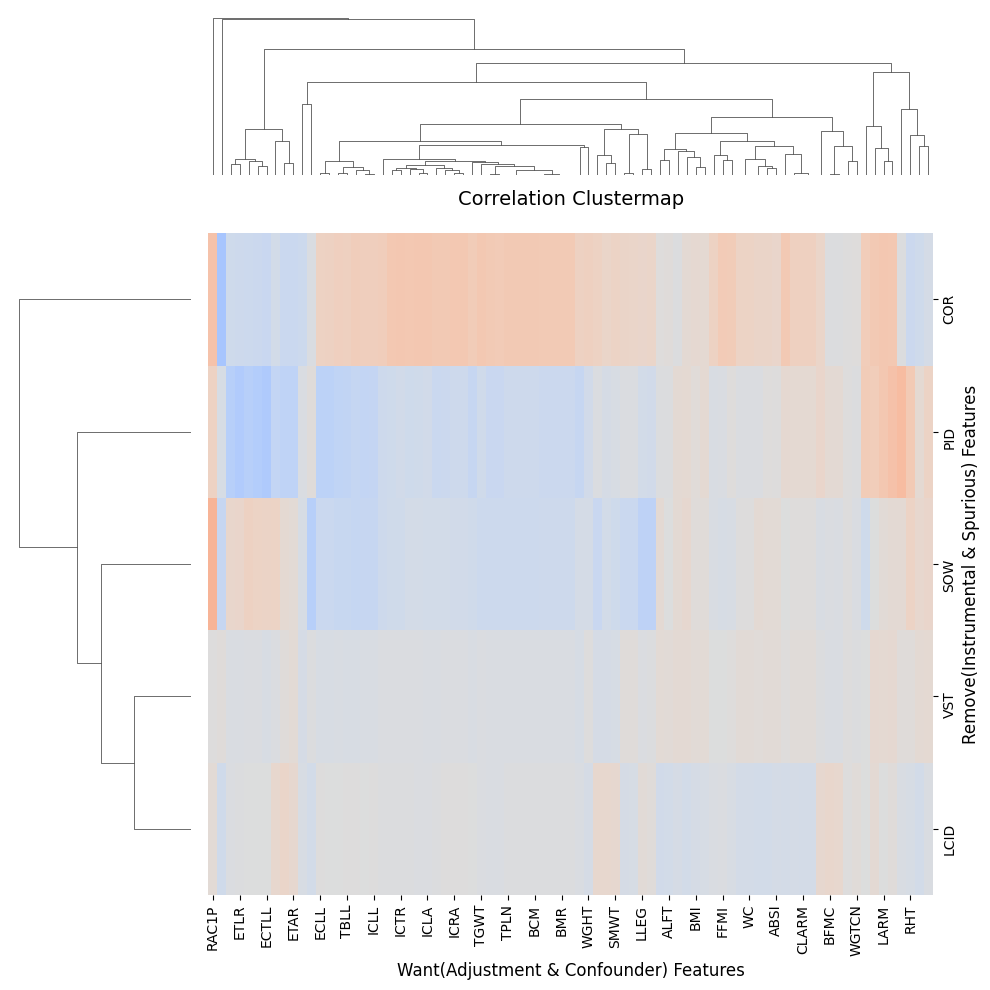

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
Codiet_url = "https://raw.githubusercontent.com/sereneHe/my-data/refs/heads/main/codiet_data.csv"
df = pd.read_csv(Codiet_url, engine='python', sep=';', on_bad_lines='skip')

# 合并特征集
y_features = instrumental_set + spurious_set
x_features = adjustment_set + confounder_set
#y_features = instrumental_vars + spurious_vars
#x_features = adjustment_vars + confounder_vars
# ✅ 仅保留实际存在且为数值的列
valid_y = [f for f in y_features if f in df.columns and np.issubdtype(df[f].dtype, np.number)]
valid_x = [f for f in x_features if f in df.columns and np.issubdtype(df[f].dtype, np.number)]

if not valid_y or not valid_x:
    raise ValueError(f"No valid numeric columns found! "
                     f"Valid_y: {valid_y}, Valid_x: {valid_x}")

print(f"✅ Using {len(valid_x)} X-features and {len(valid_y)} Y-features.")

# 提取子集并清理
sub_df = df[valid_x + valid_y].copy()
sub_df = sub_df.dropna(axis=0, how='any')
sub_df = sub_df.loc[:, sub_df.std() > 0]

# ✅ 构建相关系数矩阵
corr_df = pd.DataFrame(index=valid_y, columns=valid_x, dtype=float)
for y in valid_y:
    for x in valid_x:
        if x in sub_df.columns and y in sub_df.columns:
            corr_df.loc[y, x] = sub_df[[x, y]].corr().iloc[0, 1]
        else:
            corr_df.loc[y, x] = np.nan

corr_df = corr_df.fillna(0)


# ✅ 绘制热图
fig_w = max(12, len(valid_x) * 0.8)
fig_h = max(6, len(valid_y) * 0.8)
plt.figure(figsize=(fig_w, fig_h))
cg = sns.clustermap(
    corr_df,
    annot=False,       # 不显示每个格子的数值
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=False,        # 不显示颜色条
    linewidths=0,
    #standard_scale=1,
    linecolor=None,
)

cg.ax_heatmap.set_xlabel("Want(Adjustment & Confounder) Features", fontsize=12)
cg.ax_heatmap.set_ylabel("Remove(Instrumental & Spurious) Features", fontsize=12)

# 标题居中
cg.ax_heatmap.set_title("Correlation Clustermap", fontsize=14, pad=20)


# 去掉所有坐标轴刻度和标签
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


## **Recommendation System👈🏻**

*  Loading Nutrition Data (and distinguishing sensitive groups)

*  Fit the propensity model using the training set

*  Calculate propensity scores on the test set

*  Plot the Propensity Score Histogram of Train vs Test

*  Output an evaluation metrics table (accuracy, precision, recall, f1, roc_auc, observed/predicted CVR)

Dropping non-numeric columns: ['DOBP']


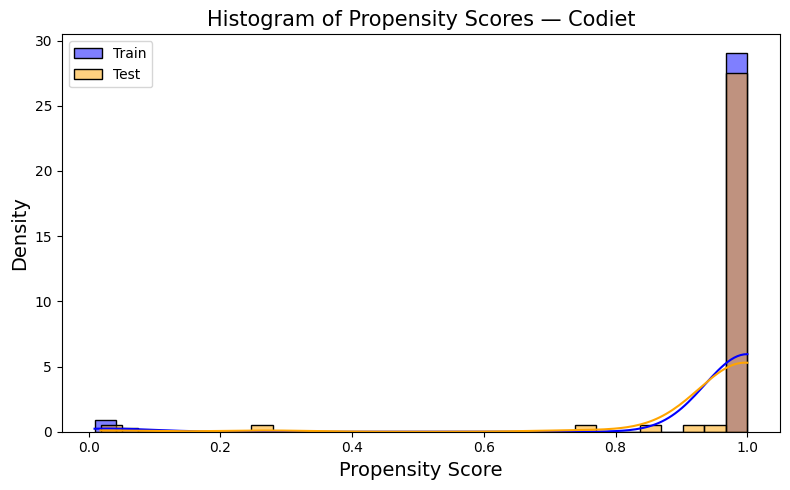

Score Table for logistic regression to calculate propensity score:
     set  # samples  # classes  accuracy  precision  recall   f1  roc_auc  \
0  train        243          2       1.0        1.0     1.0  1.0      1.0   
1   test         61          2       1.0        1.0     1.0  1.0      1.0   

   observed CVR  predicted CVR  
0      0.958848       0.959743  
1      0.967213       0.961753  


In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# ======================
# 1️⃣ Propensity model
# ======================
def calculate_propensity_scores(df, treatment_col, covariates=None, hidden_dims=[32, 16],
                                epochs=50, batch_size=16, lr=1e-3, seed=0, verbose=True):
    '''
    Trains a simple feed-forward neural net (PropensityNet) to predict multi-class treatment assignments.

    Uses CrossEntropyLoss (correct for multi-class classification).

    Returns both:

    df_propensity: your original numeric DataFrame + new columns for each treatment’s probability.

    propensity_scores: the raw numpy matrix of predicted probabilities.
    '''
    np.random.seed(seed)
    torch.manual_seed(seed)
    df = df.select_dtypes(include=['number'])

    if covariates is None:
        covariates = [c for c in df.columns if c != treatment_col]

    X = df[covariates].to_numpy(dtype=np.float32)
    y = df[treatment_col].to_numpy()
    unique_treatments, y_labels = np.unique(y, return_inverse=True)
    num_treatments = len(unique_treatments)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_labels, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    class PropensityNet(nn.Module):
        def __init__(self, input_dim, hidden_dims, num_treatments):
            super().__init__()
            layers = []
            prev_dim = input_dim
            for h in hidden_dims:
                layers.append(nn.Linear(prev_dim, h))
                layers.append(nn.ReLU())
                prev_dim = h
            layers.append(nn.Linear(prev_dim, num_treatments))
            self.model = nn.Sequential(*layers)
        def forward(self, x):
            return self.model(x)

    model = PropensityNet(X.shape[1], hidden_dims, num_treatments)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in dataloader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        propensity_scores = F.softmax(logits, dim=1).numpy()

    propensity_df = pd.DataFrame(propensity_scores, columns=[f'Propensity_Treatment_{t}' for t in unique_treatments])
    df_propensity = pd.concat([df.reset_index(drop=True), propensity_df], axis=1)

    return df_propensity, propensity_scores, model


# ======================
# 2️⃣ Nutrition dataset
# ======================
def load_folktables_nutrition_torch(
    dataset='nutrition', SITE='UK', random_state=None, onehot=True, make_unbalanced=False
):
    Codiet_url = "https://raw.githubusercontent.com/sereneHe/my-data/refs/heads/main/codiet_data.csv"
    acs_data = pd.read_csv(Codiet_url, engine='python', sep=';', on_bad_lines='skip')

    RAC1P_WHITE = '1'
    group = (acs_data['RAC1P'].astype(str) == RAC1P_WHITE).astype(int).to_numpy()
    acs_data = acs_data.drop(columns=['RAC1P'])

    acs_data = acs_data.dropna(subset=['WGTCN'])
    acs_data['WGTCN'] = acs_data['WGTCN'].apply(lambda x: 0 if x < 0 else 1)
    label = acs_data['WGTCN'].to_numpy().astype(float)
    features_df = acs_data.drop(columns=['WGTCN'])

    non_numeric_cols = features_df.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"Dropping non-numeric columns: {non_numeric_cols}")
        features_df = features_df.drop(columns=non_numeric_cols)
    features = features_df.to_numpy(dtype=np.float32)

    stratify = pd.Series(group.astype(str) + "_" + label.astype(str))
    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
        features, label, group, test_size=0.2, random_state=random_state, stratify=stratify
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    train_w_idx = np.where(g_train == 1)[0]
    train_nw_idx = np.where(g_train == 0)[0]
    test_w_idx = np.where(g_test == 1)[0]
    test_nw_idx = np.where(g_test == 0)[0]

    return X_train_scaled, y_train, [train_w_idx, train_nw_idx], \
           X_test_scaled, y_test, [test_w_idx, test_nw_idx], features_df


# ======================
# 3️⃣ Pipeline
# ======================
TASK = 'nutrition'
SITE = 'UK'

X_train, y_train, [w_idx_train, nw_idx_train], \
X_test, y_test, [w_idx_test, nw_idx_test], X = load_folktables_nutrition_torch(
    TASK, SITE=SITE, random_state=42, make_unbalanced=False, onehot=False
)

# Combine into DataFrames for model
train_df = pd.DataFrame(X_train)
train_df['Treatment'] = y_train
test_df = pd.DataFrame(X_test)
test_df['Treatment'] = y_test

# Train model on train data
train_df_prop, train_propensity, model = calculate_propensity_scores(train_df, 'Treatment', epochs=30, verbose=False)

# Apply model to test data
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    logits_test = model(X_test_tensor)
    test_propensity = F.softmax(logits_test, dim=1).numpy()

# ======================
# 4️⃣ Plot histogram
# ======================
plt.figure(figsize=(8, 5))
sns.histplot(train_propensity[:,1], color='blue', label='Train', kde=True, stat='density', alpha=0.5, bins=30)
sns.histplot(test_propensity[:,1], color='orange', label='Test', kde=True, stat='density', alpha=0.5, bins=30)
plt.xlabel("Propensity Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title(f"Histogram of Propensity Scores — Codiet", fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

# ======================
# 5️⃣ Metrics summary
# ======================
y_pred_train = (train_propensity[:,1] > 0.5).astype(int)
y_pred_test = (test_propensity[:,1] > 0.5).astype(int)

def metrics(y_true, y_pred, probs):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, probs)
    }

train_m = metrics(y_train, y_pred_train, train_propensity[:,1])
test_m = metrics(y_test, y_pred_test, test_propensity[:,1])

summary = pd.DataFrame([
    ['train', len(y_train), 2, *train_m.values(), y_train.mean(), train_propensity[:,1].mean()],
    ['test', len(y_test), 2, *test_m.values(), y_test.mean(), test_propensity[:,1].mean()]
], columns=['set', '# samples', '# classes', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc',
            'observed CVR', 'predicted CVR'])
print('Score Table for logistic regression to calculate propensity score:')
print(summary.round(6))


### **1. Split**

In [46]:
device = 'cuda' if torch.cuda.is_available() and False else 'cpu'
RANDOM_SEED = 42

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_folktables_nutrition_torch(dataset: str = 'nutrition',
                                    SITE='UK',
                                    random_state=None,
                                    onehot=True,
                                    make_unbalanced=False):
    """
    Load the CoDiet/Nutrition dataset and return train/test splits with group indices.

    Sensitive group is based on RAC1P (white vs non-white).
    """
    Codiet_url = "https://raw.githubusercontent.com/sereneHe/my-data/refs/heads/main/codiet_data.csv"
    acs_data = pd.read_csv(Codiet_url, engine='python',sep=';', on_bad_lines='skip')
    # Define the value representing 'white' in RAC1P column
    RAC1P_WHITE = '1'  # adjust if RAC1P uses integers
    group = (acs_data['RAC1P'].astype(str) == RAC1P_WHITE).to_numpy()
    acs_data = acs_data.drop('RAC1P', axis=1) # Drop RAC1P from features
    # group = np.zeros(acs_data.shape[0]) # Default to zeros if RAC1P not found or used otherwise

    # Separate features and label
    label = np.zeros(acs_data.shape[0])
    acs_data['WGTCN'] = acs_data['WGTCN'].apply(lambda x: 0 if x < 0 else (1 if x > 0 else np.nan))
    label = (acs_data['WGTCN'].to_numpy()).astype(float) # Example threshold > 0 for weight change
    features_df = acs_data.drop('WGTCN', axis=1)
    #print(label)

    # Identify and drop non-numeric columns before converting to numpy
    non_numeric_cols = features_df.select_dtypes(exclude=np.number).columns.tolist()
    if non_numeric_cols:
        print(f"Dropping non-numeric columns: {non_numeric_cols}")
        features_df = features_df.drop(columns=non_numeric_cols)
    features = features_df.to_numpy()
    #print(features.shape, label.shape, group.shape)

    # Use stratify on the binary label and group for balanced splits
    X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
      features, label, group, test_size=0.2, random_state=random_state, stratify=group
    )

    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train/test group indices
    train_w_idx = np.argwhere(g_train == 1).flatten()#
    train_nw_idx = np.argwhere(g_train != 1).flatten()
    test_w_idx = np.argwhere(g_test == 1).flatten()
    test_nw_idx = np.argwhere(g_test != 1).flatten()

    return X_train_scaled, y_train, [train_w_idx, train_nw_idx], \
           X_test_scaled, y_test, [test_w_idx, test_nw_idx], features_df


In [48]:
TASK = 'nutrition'
SITE = 'UK'

X_train, y_train, [w_idx_train, nw_idx_train], \
X_test, y_test, [w_idx_test, nw_idx_test], X = load_folktables_nutrition_torch(
    TASK, SITE=SITE, random_state=42, make_unbalanced=False, onehot=False
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
#print(w_idx_train.shape, nw_idx_train.shape)
#print(w_idx_test.shape, nw_idx_test.shape)

Dropping non-numeric columns: ['DOBP']
(243, 285) (61, 285)
(243,) (61,)


### **2. Calculate propensity score**

In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def calculate_propensity_scores(df, treatment_col, covariates=None, hidden_dims=[32, 16],
                                epochs=50, batch_size=16, lr=1e-3, seed=0, verbose=True):
    """
    Calculate propensity scores for multi-treatment using a nonlinear PyTorch model.

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing treatment column and covariates.
    treatment_col : str
        Name of the treatment column.
    covariates : list[str], optional
        List of columns to use as features. If None, use all except treatment_col.
    hidden_dims : list[int]
        List specifying hidden layer sizes.
    epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for training.
    lr : float
        Learning rate.
    seed : int
        Random seed for reproducibility.
    verbose : bool
        Print training progress if True.

    Returns:
    --------
    df_propensity : pd.DataFrame
        Original dataframe concatenated with propensity score columns.
    propensity_scores : np.ndarray
        Numpy array of shape (n_samples, num_treatments) with predicted probabilities.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    df = df.select_dtypes(include=['number'])

    if covariates is None:
        covariates = [c for c in df.columns if c != treatment_col]

    X = df[covariates].to_numpy(dtype=np.float32)
    y = df[treatment_col].to_numpy()
    unique_treatments, y_labels = np.unique(y, return_inverse=True)
    num_treatments = len(unique_treatments)

    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y_labels, dtype=torch.long)

    # Dataset and DataLoader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define neural network
    class PropensityNet(nn.Module):
        def __init__(self, input_dim, hidden_dims, num_treatments):
            super().__init__()
            layers = []
            prev_dim = input_dim
            for h in hidden_dims:
                layers.append(nn.Linear(prev_dim, h))
                layers.append(nn.ReLU())
                prev_dim = h
            layers.append(nn.Linear(prev_dim, num_treatments))
            self.model = nn.Sequential(*layers)
        def forward(self, x):
            return self.model(x)

    model = PropensityNet(input_dim=X.shape[1], hidden_dims=hidden_dims, num_treatments=num_treatments)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if verbose and (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

    # Compute propensity scores
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        propensity_scores = F.softmax(logits, dim=1).numpy()

    # Convert to DataFrame
    propensity_df = pd.DataFrame(propensity_scores, columns=[f'Propensity_Treatment_{t}' for t in unique_treatments])
    df_propensity = pd.concat([df.reset_index(drop=True), propensity_df], axis=1)

    return df_propensity, propensity_scores



In [51]:
# Convert X_train and y_train to a DataFrame suitable for calculate_propensity_scores
train_df_for_ps = pd.DataFrame(X_train, columns=X.columns)
train_df_for_ps['Treatment'] = y_train

# Convert X_test and y_test to a DataFrame suitable for calculate_propensity_scores
test_df_for_ps = pd.DataFrame(X_test, columns=X.columns)
test_df_for_ps['Treatment'] = y_test

# Calculate propensity scores using the newly created DataFrames
df_train_ps, ps_train = calculate_propensity_scores(train_df_for_ps, treatment_col='Treatment', epochs=50)
df_test_ps, ps_test = calculate_propensity_scores(test_df_for_ps, treatment_col='Treatment', epochs=50)


Epoch 10/50, Loss: 0.0839
Epoch 20/50, Loss: 0.0279
Epoch 30/50, Loss: 0.0048
Epoch 40/50, Loss: 0.0020
Epoch 50/50, Loss: 0.0009
Epoch 10/50, Loss: 0.3382
Epoch 20/50, Loss: 0.1064
Epoch 30/50, Loss: 0.0419
Epoch 40/50, Loss: 0.0134
Epoch 50/50, Loss: 0.0061


In [52]:
df_prop, ps_array = calculate_propensity_scores(df, treatment_col='MEDIET')
df_prop.head()

Epoch 10/50, Loss: 2.3693
Epoch 20/50, Loss: 2.2894
Epoch 30/50, Loss: 2.2220
Epoch 40/50, Loss: 2.1697
Epoch 50/50, Loss: 2.1287


,PID,VST,MEAL,FOOD,NTBL,FGRC,RDYM,SVSZ,LEFT,PRSZ,...,Propensity_Treatment_2,Propensity_Treatment_3,Propensity_Treatment_4,Propensity_Treatment_5,Propensity_Treatment_6,Propensity_Treatment_7,Propensity_Treatment_8,Propensity_Treatment_9,Propensity_Treatment_10,Propensity_Treatment_11
0,0,0,2.585714,2.528571,6460.814286,76.057143,0.042857,158.836000,8.985000,149.851000,...,0.070758,0.068571,0.090198,0.132801,0.15482,0.146445,0.107088,0.093837,0.040096,0.045846
1,0,1,2.258065,2.870968,5746.741935,64.258065,0.000000,297.277097,0.423387,296.853710,...,0.070758,0.068571,0.090198,0.132801,0.15482,0.146445,0.107088,0.093837,0.040096,0.045846
2,0,2,3.095238,2.142857,7526.571429,80.000000,0.047619,448.799762,0.664286,448.135476,...,0.070758,0.068571,0.090198,0.132801,0.15482,0.146445,0.107088,0.093837,0.040096,0.045846
3,1,0,2.297297,2.324324,3966.648649,53.405405,0.000000,103.436486,0.000000,103.436486,...,0.070758,0.068571,0.090198,0.132801,0.15482,0.146445,0.107088,0.093837,0.040096,0.045846
4,1,1,2.629630,2.938272,4245.271605,62.666667,0.000000,93.130988,0.000000,93.130988,...,0.070758,0.068571,0.090198,0.132801,0.15482,0.146445,0.107088,0.093837,0.040096,0.045846


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np # Import numpy for nan handling

# Filter out NaN values from y_train and corresponding X_train rows
valid_indices_train = ~np.isnan(y_train)
X_train_cleaned = X_train[valid_indices_train]
y_train_cleaned = y_train[valid_indices_train]

# Convert cleaned data to tensors
X_train_tensor = torch.tensor(X_train_cleaned, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_cleaned, dtype=torch.long) # y_train_cleaned should now be free of NaNs
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset_train, batch_size=16, shuffle=True)

class PropensityNetMulti(nn.Module):
    def __init__(self, input_dim, num_treatments):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_treatments)  # num_treatments outputs
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # raw logits
        return x

# Determine num_treatments from the unique values in the cleaned y_train
num_treatments = len(np.unique(y_train_cleaned))

model = PropensityNetMulti(input_dim=X_train_tensor.shape[1], num_treatments=num_treatments)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()  # for multi-class classification

epochs = 50
for epoch in range(epochs):
    epoch_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}")

model.eval()
with torch.no_grad():
    logits = model(X_train_tensor)
    propensity_scores = F.softmax(logits, dim=1).numpy()  # shape: (n_samples, num_treatments)

# Convert to DataFrame
propensity_df = pd.DataFrame(propensity_scores, columns=[f'Treatment_{i}' for i in range(num_treatments)])
# Ensure 'df' here refers to a DataFrame that is aligned with propensity_scores
# In this context, it seems 'df' was a global DataFrame from previous execution.
# It's better to build a new DataFrame aligned with the cleaned data used for training.

# Since the original 'df' in this cell was not explicitly defined or related to current X_train/y_train
# and the error is in model training, we will just output propensity scores for now.
# If you intend to merge these with a specific 'df', make sure 'df' is correctly loaded and aligned.

# For demonstration, we can create a temporary DataFrame from cleaned data if needed for display
# For now, let's just print a confirmation or a part of the scores
print("Propensity scores calculated for training data.")


Epoch 10, Loss: 0.5133
Epoch 20, Loss: 0.2892
Epoch 30, Loss: 0.1060
Epoch 40, Loss: 0.0328
Epoch 50, Loss: 0.0110
Propensity scores calculated for training data.


### Classification

In [55]:
from torch import nn

# Get the number of features from the training data
input_features = X_train.shape[1]

Classification = nn.Sequential(
    nn.Linear(in_features=input_features, out_features=10), # Update in_features
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=3)
).to(device)

Classification

Sequential(
  (0): Linear(in_features=285, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=3, bias=True)
)

In [60]:
!pip install torchmetrics
from timeit import default_timer as timer
import torch
from torch import nn
from torchmetrics import Accuracy

# Define loss_fn, optimizer, and acc_fn here
K = 3 # Assuming K=3 from context of cell qTih1MWuXlTJ
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = Classification.parameters(), lr = 0.01)
acc_fn = Accuracy(task="multiclass", num_classes = K).to(device)

start_time = timer()

epochs = 1000

for epoch in range(epochs):
    ## Training
    Classification.train()

    # Ensure X_train_tensor and y_train_tensor are on the correct device
    # They are already created and moved to device in cell 9hGgxzUT-yWD

    y_logits = Classification(X_train_tensor)  # Output is logits, use X_train_tensor

    # --- Debugging: Print unique values and type of y_train ---
    if epoch == 0: # Print only in the first epoch for clarity
        print(f"Debugging y_train - Unique values: {torch.unique(y_train_tensor)}") # Use y_train_tensor
        print(f"Debugging y_train - Data type: {y_train_tensor.dtype}") # Use y_train_tensor
    # ------------------------------------------------------


    # Use CrossEntropyLoss and ensure target is LongTensor (handled in 9hGgxzUT-yWD)
    loss = loss_fn(y_logits, y_train_tensor) # Use y_train_tensor

    # Calculate accuracy (assuming acc_fn is defined in qTih1MWuXlTJ)
    y_pred_class = torch.softmax(y_logits, dim=1).argmax(dim=1)
    acc = acc_fn(y_pred_class, y_train_tensor) # Use y_train_tensor


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Testing
    Classification.eval()
    with torch.inference_mode():
        # Ensure X_test_tensor and y_test_tensor are on the correct device
        # They are already created and moved to device in cell 9hGgxzUT-yWD

        test_logits = Classification(X_test_tensor) # Use X_test_tensor
        # Use CrossEntropyLoss and ensure target is LongTensor (handled in 9hGgxzUT-yWD)
        test_loss = loss_fn(test_logits, y_test_tensor) # Use y_test_tensor

        # Calculate test accuracy
        test_pred_class = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_acc = acc_fn(test_pred_class, y_test_tensor) # Use y_test_tensor

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

end_time = timer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.6 MB/s eta 0:00:00
Debugging y_train - Unique values: tensor([0, 1])
Debugging y_train - Data type: torch.int64


NameError: name 'y_test_tensor' is not defined

In [ ]:
Classification.eval()
with torch.inference_mode():
    y_pred = Classification(X_test).squeeze()  # shape: [N]
    y_true = y_test.squeeze()

# 转成 numpy
y_pred_np = y_pred.detach().cpu().numpy()
y_true_np = y_true.detach().cpu().numpy()

#### lost fn

In [ ]:
from torchmetrics import Accuracy

K = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = Classification.parameters(), lr = 0.01)
acc_fn = Accuracy(task="multiclass", num_classes = K).to(device)
acc_fn

MulticlassAccuracy()

#### Train model

In [ ]:
from timeit import default_timer as timer

start_time = timer()

epochs = 1000

for epoch in range(epochs):
    ## Training
    Classification.train()

    y_logits = Classification(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ## Testing
    Classification.eval()
    with torch.inference_mode():
        test_logits = Classification(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

end_time = timer()

IndexError: Target -1 is out of bounds.

In [ ]:
Classification.eval()
with torch.no_grad():
    test_logits = Classification(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    accuracy = (test_pred == y_test).float().mean()
print(f"Train Accuracy: {accuracy:.4f}")
test_pred

Train Accuracy: 0.9672


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    with torch.no_grad():
        # 如果在 GPU 上，则保持一致
        if next(model.parameters()).is_cuda:
            X = X.cuda()
            y = y.cuda()

        # 创建网格点
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_tensor = torch.from_numpy(grid_points).float().to(device)

        # 预测类别
        logits = model(grid_tensor)
        Z = torch.softmax(logits, dim=1).argmax(dim=1)
        Z = Z.reshape(xx.shape).cpu().numpy()

        # 绘制决策边界
        plt.figure(figsize=(7, 5))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.tab10)
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), edgecolors='k', cmap=plt.cm.tab10)
        plt.title(title)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

plot_decision_boundary(Classification, X_train, y_train, title="3-Class Decision Boundary (PyTorch)")


/tmp/ipython-input-3393313895.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
/tmp/ipython-input-3393313895.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.02))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1470000x2 and 286x10)

In [ ]:
model.eval()
with torch.no_grad():
    test_logits = model(X_tensor)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
len(test_pred)

300

# **Classification-group**

### Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Methods/DNN/Andrii-hcomp-lite/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fairret POT==0.9.5 folktables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from src.algorithms.c_utils.constraint_fns import *
from fairret.statistic import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import folktables
# from folktables import BasicProblem

### Split

In [ ]:
device = 'cuda' if torch.cuda.is_available() and False else 'cpu'

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]

X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]

### **Define model**

**Load saved models**

定义一个简单的全连接神经网络（MLP）：

* 输入层 → 64 → ReLU → 32 → ReLU → 输出层

* 输出 logits，用于二分类任务。

In [ ]:
loaded_models = []

In [ ]:
LOSS_BOUND = 0.005
DATASET = TASK + '_' + SITE
constraint = 'loss'
DIRECTORY_PATH = "./experiments/utils/saved_models/" + DATASET + '/'+ constraint + '/' + f'{LOSS_BOUND:.0E}' + '/'
FILE_EXT = '.pt'

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Entropy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np

# -------------------------
# 定义模型
# -------------------------
class SimpleNet(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)  # 输出 logit
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# -------------------------
# 数据转换为 Tensor
# -------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape [batch,1]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# -------------------------
# 初始化模型与优化器
# -------------------------
model = SimpleNet(X_train.shape[-1], 1)
optimizer = Adam(model.parameters(), lr=0.001)

# -------------------------
# DataLoader
# -------------------------
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=8,
    shuffle=True
)

# -------------------------
# 训练循环
# -------------------------
epochs = 30
print("Starting training...")
for epoch in range(epochs):
    model.train()
    avg_epoch_loss = []
    for feature, label in dataloader:
        optimizer.zero_grad()
        output = model(feature)  # logits
        loss = F.binary_cross_entropy_with_logits(output, label)
        loss.backward()
        optimizer.step()
        avg_epoch_loss.append(loss.detach().numpy())
    #print(f"Epoch {epoch+1}: {np.mean(avg_epoch_loss):.4f}")
print("Training finished.")

# -------------------------
# 输出 logits 和概率
# -------------------------
model.eval()
with torch.no_grad():
    train_logits = model(X_train_tensor)
    test_logits = model(X_test_tensor)

    train_probs = torch.sigmoid(train_logits)
    test_probs = torch.sigmoid(test_logits)

    test_pred_class = (test_probs > 0.5).int()  # 0或1
    train_pred_class = (train_probs > 0.5).int()

#print("Train logits:\n", train_logits)
#print("Train probabilities:\n", train_probs)
#print("Test logits:\n", test_logits)
#print("Test probabilities:\n", test_probs)
print("Train predicted classes:\n", train_pred_class, y_train)
#print("Test predicted classes:\n", test_pred_class, y_test)
# -------------------------
# 计算测试集交叉熵
# -------------------------
test_loss = F.binary_cross_entropy_with_logits(test_logits, y_test_tensor)
#print(f"Test BCE loss: {test_loss.item():.4f}")



Starting training...
Training finished.
Train predicted classes:
 tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]

In [ ]:
# 保证是一维 long 类型张量train_pred_class, y_train
y_true = torch.tensor(y_train, dtype=torch.long).flatten().cpu().numpy()
y_pred = train_pred_class.flatten().to(torch.long).cpu().numpy()
print(len(y_true.reshape(-1, 1)), len(y_pred.reshape(-1, 1)))
# 生成对比表
compare_df = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "match": ["✅" if t == p else "❌" for t, p in zip(y_true, y_pred)]
})

# 打印前20行看看
compare_df

243 243


,y_true,y_pred,match
0,1,1,✅
1,1,1,✅
2,1,1,✅
3,1,1,✅
4,1,1,✅
...,...,...,...
238,1,1,✅
239,1,1,✅
240,1,1,✅
241,1,1,✅


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Import Adam optimizer

class SimpleNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)  # 输出 num_classes 个 logits
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Assuming X_train and y_train are loaded and preprocessed as numpy arrays
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Ensure target is float and has shape [batch_size, 1]

# Initialize the model for binary classification (output_dim=1)
model = SimpleNet(X_train.shape[-1], 1) # num_classes should be 1 for binary classification with BCEWithLogitsLoss
optimizer = Adam(model.parameters())

# Create DataLoader
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=8,
    shuffle=True
)

epochs = 30
print("Starting training...")
for epoch in range(epochs):
    model.train() # Set the model to training mode
    avg_epoch_loss = []
    for feature, label in dataloader:
        optimizer.zero_grad()
        output = model(feature)
        # Use binary_cross_entropy_with_logits for binary classification with logit output
        loss = torch.nn.functional.binary_cross_entropy_with_logits(output, label)

        loss.backward()
        optimizer.step()

        avg_epoch_loss.append(loss.detach().numpy())
    print(f"Epoch {epoch+1}: {np.mean(avg_epoch_loss):.4f}")
print("Training finished.")

Starting training...
Epoch 1: 0.5076
Epoch 2: 0.3286
Epoch 3: 0.2478
Epoch 4: 0.1922
Epoch 5: 0.1536
Epoch 6: 0.1342
Epoch 7: 0.1145
Epoch 8: 0.1010
Epoch 9: 0.0890
Epoch 10: 0.0772
Epoch 11: 0.0662
Epoch 12: 0.0586
Epoch 13: 0.0475
Epoch 14: 0.0396
Epoch 15: 0.0324
Epoch 16: 0.0259
Epoch 17: 0.0216
Epoch 18: 0.0186
Epoch 19: 0.0167
Epoch 20: 0.0134
Epoch 21: 0.0117
Epoch 22: 0.0102
Epoch 23: 0.0089
Epoch 24: 0.0079
Epoch 25: 0.0070
Epoch 26: 0.0061
Epoch 27: 0.0055
Epoch 28: 0.0049
Epoch 29: 0.0045
Epoch 30: 0.0044
Training finished.


### **Histogram of propensity score for train and test data**

In [ ]:
predictions_0 = {}
predictions_1 = {}

for model_name, model in loaded_models:
    preds_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    preds_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    try:
        predictions_0[model_name].append(preds_0)
        predictions_1[model_name].append(preds_1)
    except:
        predictions_0[model_name] = [preds_0]
        predictions_1[model_name] = [preds_1]

for name in np.unique([name for name, _ in loaded_models]):
    predictions_0[name] = np.concatenate(predictions_0[name])
    predictions_1[name] = np.concatenate(predictions_1[name])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name in np.unique([name for name, _ in loaded_models]):

    # predictions_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    # predictions_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()

    sns.kdeplot(predictions_0[model_name].squeeze(), label=sensitive_value_0, color='blue', fill=True,bw_adjust=.4)#,clip=[0,1],common_norm=True)
    sns.kdeplot(predictions_1[model_name].squeeze(), label=sensitive_value_1, color='red', fill=True,bw_adjust=.4)#,clip=[0,1],common_norm=True)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0,22)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    # plt.title(model_name, fontsize=10)
    # plt.title(alg)
    # print(alg)
    alg_name = 'sslalm_aug' if model_name.startswith('sslalm_mu0') else model_name.split('_')[0]
    plt.savefig(f'./plots/{alg_name}/{DATASET}/dist')
    plt.legend()
    plt.show()

# kedro Test

    codiet_kedro_project/
    ├── conf/
    │   └── base/
    │       ├── catalog.yml
    │       └── parameters.yml
    ├── data/
    │   ├── REDcap_data_combined_nov2024.xlsx
    │   ├── DBN_test_data.csv
    │   └── CoDiet_Sociodemographics_abbre.csv
    ├── src/
    │   └── codiet/
    │       ├── pipelines/
    │       │   └── main/
    │       │       ├── data_cleaning.py
    │       │       ├── data_cleaning_nodes.py
    │       │       ├── feature_selection.py
    │       │       ├── pipeline.py
    │       |       └── pipeline_registry.py
    │       ├── run.py
    │       └── __init__.py
    ├── demo/
    │   └── notebook.py
    ├── tests/
    │   └── test_nodes.py
    └── README.md


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Methods/DNN/codiet_kedro_project/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 在Colab中测试Kedro项目
# !pip install kedro==0.18.12 pandas==2.0.3 numpy==1.24.3 scikit-learn==1.3.0 torch==2.0.1 seaborn==0.12.2 matplotlib==3.7.2 openpyxl==3.1.2

!pip install wheel setuptools cython
!pip install "numpy>=1.26,<2.0" "pandas>=2.1,<2.2" "kedro==0.18.12"


In [ ]:
!pip install scikit-learn==1.3.0 torch==2.0.1 seaborn==0.12.2 matplotlib==3.7.2 openpyxl==3.1.2


In [ ]:
import numpy as np
import pandas as pd
from src.codiet.pipelines.main import pipeline, data_cleaning_nodes, feature_selection



## 1.Read DataCatalog Dataset

In [ ]:
from kedro.framework.context import KedroContext
from kedro.framework.hooks import _create_hook_manager
from pathlib import Path
from kedro.config import ConfigLoader

project_path = Path.cwd()
package_name = "codiet"
conf_path = project_path / "conf"
env = "base"
config_loader = ConfigLoader(conf_source=str(conf_path), env=env)


try:
    context = KedroContext(package_name=package_name, project_path=project_path, config_loader=config_loader, hook_manager=_create_hook_manager())
    print("KedroContext created OK")
except Exception as e:
    print("KedroContext creation failed:", e)
    raise

try:
    catalog = context.catalog
    print("Catalog datasets:", list(catalog.list()))
except Exception as e:
    print("Catalog load error:", e)

catalog = context.catalog
for key in list(catalog.list())[:5]:
    try:
        ds = catalog.load(key)
        print(f"Loaded {key} -> type: {type(ds)}, shape(if dataframe): {getattr(ds,'shape',None)}")
    except Exception as e:
        print(f"Failed to load {key}: {e}")


KedroContext created OK


[10/22/25 14:23:15] WARNING  /usr/local/lib/python3.11/dist-packages/kedro/config/common.py:216:    ]8;id=120423;file:///usr/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=284504;file:///usr/lib/python3.11/warnings.py#110\110]8;;\
                             UserWarning: Duplicate environment detected! Skipping re-loading from                 
                             configuration path: /content/drive/MyDrive/Colab                                      
                             Notebooks/Causality/Methods/DNN/codiet_kedro_project/conf/base                        
                               warn(                                                                               
                                                                                                                   

Catalog datasets: ['sociodemographics_data', 'exdbn_data', 'abbreviation_data', 'cleaned_data', 'codiet_dic_data', 'correlation_heatmap', 'parameters', 'params:feature_selection', 'params:feature_selection.threshold', 'params:feature_selection.method', 'params:data_cleaning', 'params:data_cleaning.remove_nulls', 'params:data_cleaning.fill_method']


                    INFO     Loading data from 'sociodemographics_data' (ExcelDataSet)...       ]8;id=709435;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=113252;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

Loaded sociodemographics_data -> type: <class 'pandas.core.frame.DataFrame'>, shape(if dataframe): (19, 94)


                    INFO     Loading data from 'exdbn_data' (CSVDataSet)...                     ]8;id=536438;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=313230;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

Loaded exdbn_data -> type: <class 'pandas.core.frame.DataFrame'>, shape(if dataframe): (329, 1)


                    INFO     Loading data from 'abbreviation_data' (CSVDataSet)...              ]8;id=454504;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=378530;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

Loaded abbreviation_data -> type: <class 'pandas.core.frame.DataFrame'>, shape(if dataframe): (334, 3)


                    INFO     Loading data from 'cleaned_data' (CSVDataSet)...                   ]8;id=77313;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=23094;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

Loaded cleaned_data -> type: <class 'pandas.core.frame.DataFrame'>, shape(if dataframe): (304, 1)


                    INFO     Loading data from 'codiet_dic_data' (CSVDataSet)...                ]8;id=849434;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=869926;file:///usr/local/lib/python3.11/dist-packages/kedro/io/data_catalog.py#475\475]8;;\

Loaded codiet_dic_data -> type: <class 'pandas.core.frame.DataFrame'>, shape(if dataframe): (440, 7)


## 2.Run pipeline
*  验证 Kedro CLI 能读取配置、
*  运行 pipeline、
*  执行所有节点并写入 outputs(catalog 指定的位置)

In [ ]:
import subprocess
import sys

cmd = [
    sys.executable,
    "-W", "default:Kedro is not yet fully compatible",
    "-m", "kedro", "run",
    "--"
]

# 捕获输出
result = subprocess.run(cmd, capture_output=True, text=True)

print("stdout:")
print(result.stdout)
print("\nstderr:")
print(result.stderr)

print("\n返回码:", result.returncode)


stdout:
[10/22/25 14:30:47] INFO     Kedro project codiet_kedro_project   session.py:364
                    WARNING  /usr/local/lib/python3.11/dist-pack warnings.py:110
                             ages/kedro/framework/session/sessio                
                             n.py:266: FutureWarning:                           
                             ConfigLoader will be deprecated in                 
                             Kedro 0.19. Please use the                         
                             OmegaConfigLoader instead. To                      
                             consult the documentation for                      
                             OmegaConfigLoader, see here:                       
                             https://docs.kedro.org/en/stable/co                
                             nfiguration/advanced_configuration.                
                             html#omegaconfigloader                             
                    

## 3.Write pyproject.toml

In [ ]:
from pathlib import Path

p = Path("pyproject.toml")
if not p.exists():
    p.write_text(
        '[tool.kedro]\n'
        'package_name = "codiet"\n'
        'project_name = "codiet_kedro_project"\n'
        'kedro_init_version = "0.18.12"\n'
        'source_dir = "src"\n',
        encoding='utf-8'
    )
print("pyproject.toml exists:", p.exists())


pyproject.toml exists: True


In [ ]:
from kedro.framework.cli import main
import subprocess
import sys

def run_kedro():
    cmd = [
        sys.executable, "-W",
        "default:Kedro is not yet fully compatible",
        "-m", "kedro", "run", "--",  # <-- 注意这里加 "--" 告诉 Click 停止解析后续 Jupyter 参数
    ]
    subprocess.run(cmd, check=True)

if __name__ == "__main__":
    run_kedro()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:14                                                                             │
│                                                                                                  │
│   11 │   subprocess.run(cmd, check=True)                                                         │
│   12                                                                                             │
│   13 if __name__ == "__main__":                                                                  │
│ ❱ 14 │   run_kedro()                                                                             │
│   15                                                                                             │
│                                                                                                  │
│ in run_kedro:11                                                                                  │
│                                                                                                  │
│    8 │   │   "default:Kedro is not yet fully compatible",                                        │
│    9 │   │   "-m", "kedro", "run", "--",  # <-- 注意这里加 "--" 告诉 Click 停止解析后续 Jupyt    │
│   10 │   ]                                                                                       │
│ ❱ 11 │   subprocess.run(cmd, check=True)                                                         │
│   12                                                                                             │
│   13 if __name__ == "__main__":                                                                  │
│   14 │   run_kedro()                                                                             │
│                                                                                                  │
│ /usr/lib/python3.11/subprocess.py:571 in run                                                     │
│                                                                                                  │
│    568 │   │   │   raise                                                                         │
│    569 │   │   retcode = process.poll()                                                          │
│    570 │   │   if check and retcode:                                                             │
│ ❱  571 │   │   │   raise CalledProcessError(retcode, process.args,                               │
│    572 │   │   │   │   │   │   │   │   │    output=stdout, stderr=stderr)                        │
│    573 │   return CompletedProcess(process.args, retcode, stdout, stderr)                        │
│    574                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
CalledProcessError: Command '['/usr/bin/python3', '-W', 'default:Kedro is not yet fully compatible', '-m', 'kedro',
'run', '--']' returned non-zero exit status 1.

In [ ]:
from pathlib import Path

package_name = "codiet"
src_dir = Path("src")
package_dir = src_dir / package_name

# 创建目录
package_dir.mkdir(parents=True, exist_ok=True)

# 创建 __init__.py
(package_dir / "__init__.py").touch(exist_ok=True)

# 创建空的 settings.py
settings_file = package_dir / "settings.py"
if not settings_file.exists():
    settings_file.write_text("# Kedro settings placeholder\n", encoding="utf-8")

print("项目结构已创建/检查完成：")
print(list(src_dir.rglob("*")))


项目结构已创建/检查完成：
[PosixPath('src/.DS_Store'), PosixPath('src/codiet'), PosixPath('src/codiet/pipelines'), PosixPath('src/codiet/__init__.py'), PosixPath('src/codiet/.DS_Store'), PosixPath('src/codiet/run.py'), PosixPath('src/codiet/__pycache__'), PosixPath('src/codiet/settings.py'), PosixPath('src/codiet/pipeline_registry.py'), PosixPath('src/codiet/pipelines/__init__.py'), PosixPath('src/codiet/pipelines/main'), PosixPath('src/codiet/pipelines/.DS_Store'), PosixPath('src/codiet/pipelines/__pycache__'), PosixPath('src/codiet/pipelines/main/__init__.py'), PosixPath('src/codiet/pipelines/main/.DS_Store'), PosixPath('src/codiet/pipelines/main/__pycache__'), PosixPath('src/codiet/pipelines/main/data_cleaning_nodes.py'), PosixPath('src/codiet/pipelines/main/feature_selection.py'), PosixPath('src/codiet/pipelines/main/pipeline.py'), PosixPath('src/codiet/pipelines/main/__pycache__/pipeline.cpython-311.pyc'), PosixPath('src/codiet/pipelines/main/__pycache__/data_cleaning_nodes.cpython-311.pyc'),

# BACKUP


### Combine-Col-Process



1.   薪资处理：把文本形式的年薪范围提取为中间值

1.   工作小时处理：解析 full-time / part-time / hours 文本，计算每周工作小时

1.   体重变化处理：拆分体重变化列为 “lost/gained/no change” 和数值

1.   种族分类：把原始文本归类为 White / Mixed / Asian / Black / Other / Unknown

1.   职业与年限处理：解析工作状态、职业类别 (COW)、工作年限

1.   睡眠小时处理：解析文本睡眠时间

1.   拆分 Place of Residence：成 City of Residence 和 Country of Residence

1.   Weight / Height 处理：把逗号替换为点并转换为 float

In [ ]:
def clean_merged_df(merged_df: pd.DataFrame) -> pd.DataFrame:
    # 函数1：计算年薪
    def extract_salary_midpoint(s):
        s = str(s)
        nums = re.findall(r"\d{1,3}(?:,\d{3})*|\d+", s)
        nums = [int(n.replace(",", "")) for n in nums]
        if not nums:
            return np.nan
        if len(nums) == 2:
            return (nums[0] + nums[1]) // 2
        return nums[0]

    # 函数2：计算每周工作小时数
    def working_hours_per_week(s: str, hours_per_day: float = 8) -> float:
        s = str(s).lower().strip()
        if "full-time" in s:
            return 5 * hours_per_day
        match = re.search(r"(\d+)(?:\s*and\s*(1/2))?\s*days?", s)
        if "part-time" in s and match:
            days = int(match.group(1))
            if match.group(2):
                days += 0.5
            return days * hours_per_day
        match = re.search(r"(\d+(\.\d+)?)\s*hours?", s)
        if match:
            return float(match.group(1))
        return np.nan

    # 函数3：拆分weight change
    def process_weight_column(s: str) -> float:
        val_str = str(s).lower().strip()
        nums = re.findall(r'(\d+(\.\d+)?)', val_str)
        if nums:
            nums = [float(x[0]) for x in nums]
            if len(nums) > 1:
                num = (min(nums) + max(nums)) / 2
            else:
                num = nums[0]
        else:
            num = np.nan
        if 'lost' in val_str or 'loss' in val_str:
            cat = "lost"
            value = -num if not np.isnan(num) else np.nan
        elif 'gain' in val_str or 'gained' in val_str:
            cat = "gained"
            value = num
        else:
            cat = "no change"
            value = 0.0
        return pd.Series([cat, value])

    # 函数4: ethnicity
    def classify_ethnicity(value: str):
        v = str(value).lower()
        if "white" in v:
            return "White"
        elif "mixed" in v:
            return "Mixed / Multiple"
        elif "asian" in v or "chinese" in v:
            return "Asian"
        elif "black" in v:
            return "Black / African / Caribbean"
        elif "other" in v:
            return "Other"
        else:
            return "Unknown"

    # 函数5：拆分职业与年限
    profession_keywords = {
        "nursing": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "incubator manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "biochemist": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
        "carer": "Self-employed in own not incorporated business, professional practice, or farm",
        "kitchen designer": "Self-employed in own not incorporated business, professional practice, or farm",
        "business": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "banker": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "operation theatre hca": "Working without pay in family business or farm",
        "customer service": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "civil servant": "Local government employee (city, county, etc.)",
        "book-keeper": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "administration": "Local government employee (city, county, etc.)",
        "senior acct manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "executive assistant": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "family content supervisor": "Employee of a private not-for-profit, tax-exempt, or charitable organization"
    }

    cow_categories = list(set(profession_keywords.values()))
    cow_categories += ["Unemployed and last worked 5 years ago or earlier or never worked",
                       "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"]

    def process_profession_data(df: pd.DataFrame) -> pd.DataFrame:
        profession_cols = [
            'If you answered working, please fill in: current profession and years working',
            'If you answered not working, please fill last profession and years working',
            'If you answered retired, please fill in, last profession and years working'
        ]

        def get_status_cow_years(row):
            status = "NaN"
            raw = None
            is_not_working = False
            for col, st in zip(profession_cols, ["working", "not working", "retired"]):
                val = row.get(col)
                if pd.notna(val) and str(val).strip():
                    raw = str(val)
                    status = st
                    break
            if raw is None:
                return pd.Series([status,
                                  "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)",
                                  np.nan])
            if ',' in raw:
                profession_part, years_part = raw.split(',', 1)
            else:
                profession_part, years_part = raw, ''
            profession_lower = profession_part.strip().lower()
            years_part_lower = years_part.lower()
            num_matches = re.findall(r'(\d+(?:\.\d+)?)', years_part_lower)
            total_years = float(num_matches[0]) if num_matches else np.nan
            if len(num_matches) > 1 and 'month' in years_part_lower:
                total_years += float(num_matches[1]) / 12
            cow_class = "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"
            for key, cls in profession_keywords.items():
                if key in profession_lower:
                    cow_class = cls
                    break
            if status == "not working" and (np.isnan(total_years) or total_years >= 5):
                cow_class = "Unemployed and last worked 5 years ago or earlier or never worked"
                total_years = -total_years if not np.isnan(total_years) else 0
            return pd.Series([status, cow_class, total_years])

        df[['Status of worker', 'Class of worker', 'Decades of working']] = df.apply(get_status_cow_years, axis=1)
        df['Class of worker'] = pd.Categorical(df['Class of worker'], categories=cow_categories)
        return df.drop(columns=[c for c in profession_cols if c in df.columns], errors='ignore')

    # 函数6：睡觉
    def parse_sleep_hours(value: str):
        if pd.isna(value):
            return np.nan
        text = str(value).lower().replace("hous", "hours")
        numbers = re.findall(r'\d+(?:\.\d+)?', text)
        return np.mean([float(n) for n in numbers]) if numbers else np.nan

    # 处理列
    merged_df["Salary (annual net salary)"] = merged_df["Salary (annual net salary)"].astype(str).apply(extract_salary_midpoint)
    merged_df["Hours worked per week"] = merged_df[["Working time", "If you answered shift worker, please describe your shifts patterns"]].fillna('').agg(lambda x: ' '.join(filter(None, x)), axis=1).apply(working_hours_per_week)
    merged_df[["Have you lost or gained weight in the past 3 months?", "Have you lost or gained weight in the past 3 months? If yes, how much?"]] = merged_df['Have you lost or gained weight in the past 3 months? If yes, how much?'].apply(process_weight_column)
    merged_df['Ethnicity'] = merged_df['Ethnicity'].apply(classify_ethnicity)
    merged_df["Ethnicity_Is White or Not"] = merged_df["Ethnicity"].apply(lambda x: 'white' if x == 'White' else 'non-white')
    merged_df = process_profession_data(merged_df)
    merged_df["How many hours per day do you sleep during workdays?"] = merged_df["How many hours per day do you sleep during workdays?"].apply(parse_sleep_hours)
    merged_df["How many hours per day do you sleep during free days?"] = merged_df["How many hours per day do you sleep during free days?"].apply(parse_sleep_hours)

    # 确保 Place of Residence 为字符串再拆分
    merged_df['Place of Residence'] = merged_df['Place of Residence'].astype(str)
    merged_df[['City of Residence', 'Country of Residence']] = merged_df['Place of Residence'].str.split(',', n=1, expand=True)
    merged_df['City of Residence'] = merged_df['City of Residence'].astype(str).str.strip()
    merged_df['Country of Residence'] = merged_df['Country of Residence'].astype(str).str.strip()

    # Weight / Height 列转换
    merged_df['Weight (kg)'] = merged_df['Weight (kg)'].astype(str).str.replace(',', '.').replace('nan', np.nan).astype(float)
    merged_df['Height (cm)'] = merged_df['Height (cm)'].astype(str).str.replace(',', '.').replace('nan', np.nan).astype(float)

    return merged_df


def clean_and_compare_columns(df1: pd.DataFrame, df2: pd.DataFrame) -> tuple:
    """
    清理 df1 的列名（替换特殊字符、去掉重复后缀），并比较 df1 与 df2 列差异。

    参数:
        df1 : pd.DataFrame
            待清理的 DataFrame
        df2 : pd.DataFrame
            用于对比列差异的 DataFrame

    返回:
        tuple:
            df1_cleaned : pd.DataFrame
                清理后的 df1
            only_in_df1 : set
                仅存在 df1 的列名
            only_in_df2 : set
                仅存在 df2 的列名
    """
    df1.columns = (
        df1.columns
        .str.replace(' ? 90 mg/dL (5.0 mmol/L)', ' ≥ 90 mg/dL (5.0 mmol/L)', regex=False)
        .str.replace(' ? 100 mg/dL (1.7 mmol/L))', ' ≥ 100 mg/dL (1.7 mmol/L))', regex=False)
        .str.replace('BP ? 130 or diastolic BP ? 85 mm Hg.', 'BP ≥ 130 or diastolic BP ≥ 85 mm Hg.', regex=False)
    )

    for col in df1.columns.tolist():  # 用列表防止修改列时报错
        if col.startswith("CoDiet") or any(col.endswith(suffix) for suffix in ['_1','_2','_3','_4','.1','.2','.3','.4']):
            new_col = col.replace("CoDiet ", "", 1)
            for suffix in ['_1','_2','_3','_4','.1','.2','.3','.4']:
                new_col = new_col.rstrip(suffix)
            if new_col in df1.columns:
                df1.drop(columns=[col], inplace=True)
            else:
                df1.rename(columns={col: new_col}, inplace=True)

    cols1 = set(df1.columns.str.strip())
    cols2 = set(df2.columns.str.strip())
    only_in_df1 = cols1 - cols2
    only_in_df2 = cols2 - cols1

    print(f"仅存在 df1 的列: {only_in_df1}")
    print(f"仅存在 df2 的列: {only_in_df2}")
    print(f"数量 -> df1: {len(only_in_df1)}, df2: {len(only_in_df2)}")

    return df1, only_in_df1, only_in_df2


In [ ]:
sociodemographics = pd.read_excel('./Datasets/Real_data/CoDiet/REDcap_data_combined_nov2024.xlsx', sheet_name='datos todos')
sociodemographics.to_csv('./Datasets/Real_data/CoDiet/sociodemographics.csv', sep=';', index=False)


In [ ]:
sociodemographics = pd.read_excel('./Datasets/Real_data/CoDiet/REDcap_data_combined_nov2024.xlsx', sheet_name='datos todos')
# sociodemographics_ICL = pd.read_csv('./Datasets/Real_data/CoDiet/REDCap_CoDiet_Sociodemographics_ICL(Sheet1.csv', sep=';', encoding='cp1252')
# clean_and_compare_columns(sociodemographics_ICL, sociodemographics)
sociodemographics = sociodemographics.rename(columns={'volunteer_id': 'Volunteer ID'})
#exdbn = pd.read_csv('./Datasets/Real_data/CoDiet/DBN_test_data.csv', sep=';')
#exdbn = pd.read_csv('./Datasets/Real_data/CoDiet/merged-codiet.csv', sep=';')
exdbn = df_filled
sociodemographics['Volunteer ID'] = sociodemographics['Volunteer ID'].astype(str).str.strip()
exdbn['patient'] = exdbn['patient'].astype(str).str.strip()
merged_df = pd.merge(
    exdbn,
    sociodemographics,
    left_on='patient',
    right_on='Volunteer ID',
    how='inner'  # 使用 left join 保留 ExDBN 所有行
)
pattern = re.compile(r'.*(_\d+|-\\d+)$')  # 匹配 _数字 或 -数字 结尾
merged_df = merged_df[[col for col in merged_df.columns if not pattern.match(col)]]
merged_df = pd.DataFrame(merged_df)
merged_df.columns = merged_df.columns.str.strip()            # 去掉首尾普通空格
merged_df.columns = merged_df.columns.str.replace("\xa0", "") # 去掉不间断空格
merged_df.columns = merged_df.columns.str.replace("\n", "")  # 去掉换行符
merged_df_cleaned = clean_merged_df(merged_df)
print(merged_df_cleaned.head())
# merged_df_cleaned = merged_df_cleaned.drop(columns=['Meal ID','Food ID','Nutrient table code','Food group code','Ready meal'])

## 纵向合并各个site数据

In [ ]:
import re
import io
folder_path = "./Datasets/Real_data/CoDiet/REDcap_sociodemographics/"  # 替换为你的文件夹路径
csv_files = glob(os.path.join(folder_path, "*.csv"))
dataframes = {}

for file in csv_files:
    file_name = os.path.splitext(os.path.basename(file))[0]
    print(file_name)
    #df = None
    #{'Complete?',
    # 91: columns1+['Informed Consent Given by the Volunteer']
    # 92: columns1+['Complete?', 'Survey Timestamp']
    # 113: columns1+columns2
    columns0 = ['Volunteer ID']
    columns1 = ['Volunteer ID', 'If you answered retired, please fill in, last profession and years working', 'Place of Residence', 'We are interested in finding out about the kinds of physical activities that people do as part of their everyday lives.  The questions will ask you about the time you spent being physically active in the last 7 days. Please answer each question even if you do not consider yourself to be an active person.  Please think about the activities you do at work, as part of your house yard work, to get from place to place, and in your spare time for recreation, exercise or sport.     Think about all the vigorous activities that you did in the last 7 days. Vigorous physical activities refer to activities that take hard physical effort and make you breathe much harder than normal. Think only about those physical activities that you did for at least 10 minutes at a time.\t    During the last 7 days, on how many days did you do vigorous physical activities like heavy lifting, digging, aerobics, or fast bicycling?', 'Do you have any of the following chronic medical conditions?        (choice=Chronic gastrointestinal condition)', 'If you answered shift worker, please describe your shifts patterns', 'Medical history. Did you have any of the following conditions?', 'Rate your sleep quality (1: very bad, 5: very good)', 'Raised Triglycerides ( ≥ 100 mg/dL (1.7 mmol/L))', 'If you answered former smoker, please fill in the following details:  Number of cigarettes per day  Years smoking  Years without smoking  Age started smoking', 'Have you lost or gained weight in the past 3 months? If yes, how much?', 'How much olive oil do you consume in a given day (including oil used for frying, salads, out-of-house meals, etc.)?', 'How many servings of red meat, hamburger, or meat products (ham, sausage, etc.) do you consume per day? (1 serving: 100-150 g)', 'Weight (kg)', 'Do you have any food allergies?', 'How many times per week do you consume commercial sweets or pastries (not homemade), such as cakes, cookies, biscuits, or custard?', 'If you answered other in the above question please describe here your medical history', 'Do you have any of the following chronic medical conditions?        (choice=Diabetes)', 'BMI (>25 kg/m2)', 'Do you have any of the following chronic medical conditions?        (choice=Hypertension with medication)', 'Think about all the moderate activities that you did in the last 7 days. Moderate activities refer to activities that take moderate physical effort and make you breathe somewhat harder than normal. Think only about those physical activities that you did for at least 10 minutes at a time.    During the last 7 days, on how many days did you do moderate physical activities like carrying light loads, bicycling at a regular pace, or doubles tennis?  Do not include walking.', 'Do you have any of the following chronic medical conditions?        (choice=Acute infectious disease)', 'Do you take any current medication? (choice=Insulin)', 'Smoking status', 'How much time did you usually spend walking on one of those days? Please answer in hours and minutes.', 'Current smokers', 'How many servings of legumes do you consume per week? (1 serving: 150 g)', 'Do you take any current medication? (choice=None:)', 'Do you preferentially consume chicken, turkey, or rabbit meat instead of veal, pork, hamburger, or sausage?', 'Do you have any of the following chronic medical conditions?        (choice=Dyslipidaemia (imbalance of lipids such as cholesterol, low-density lipoprotein cholesterol, (LDL-C), triglycerides, and high-density lipoprotein (HDL)).)', 'Are you pregnant, breast feeding, planning to get pregnant or your partner is planning to get pregnant, in the next 12 months?', 'Do you take any current medication? (choice=Others)', 'Do you take naps during the day?', 'Do you currently suffer from any long-term illness?  If Yes, please specify.', 'Do you take any current medication? (choice=Statins)', 'Dietary Habits Questions (14-item questionnaire for Adherence to Mediterranean diet)    Do you use olive oil as a main culinary fat?', 'Are you following a specific diet?', 'Do you take any current medication? (choice=ACE inhibitors)', 'Have you taken part in any research studies in the past 3 months?', 'Complete?', 'Do you take any current medication? (choice=Oral hypoglycaemic agents)', 'Marital status', 'Do you take any current medication? (choice=Pain medication)', 'Place of Birth', 'Working time', 'If you answered not working, please fill last profession and years working', 'Sex', 'Survey Timestamp', 'Do you have any of the following chronic medical conditions?        (choice=Dyslipidaemia controlled with medication)', 'Do you take any current medication? (choice=Diuretics)', 'Height (cm)', 'How much time did you usually spend doing moderate physical activities on one of those days? Please answer in hours and minutes', 'Do you take any current medication? (choice=Other lipid-lowering agents)', 'Pregnancy test done on women of child-bearing age? Report result', "Women's health (only for women)  Please fill in the following information:  Years of menarche  Years of menopause  Number of children  Number of full-term pregnancies  Currently breastfeeding?  Did you breastfeed your children? If yes, how many?", 'If you answered current smoker, please fill in the following details:  number of cigarettes smoked per day  years smoking  age started smoking', 'Living Status', 'Do you have any of the following chronic medical conditions?        (choice=Hypertension)', 'How many hours per day do you sleep during workdays?', 'Reduced HDL cholesterol: < 40 mg/dL (1.03 mmol/L) in males or < 50 mg/dL (1.29mmol/L) in females.', 'Do you have any of the following chronic medical conditions?        (choice=Cardiovascular disease)', 'Ethnicity', 'Raised blood pressure: systolic BP ≥ 130 or diastolic BP ≥ 85 mm Hg.', 'Date of Birth', 'Think about the time you spent walking in the last 7 days. This includes at work and at home, walking to travel from place to place, and any other walking that you have done solely for recreation, sport, exercise, or leisure.    During the last 7 days, on how many days did you walk for at least 10 minutes at a time?', 'How many times per week do you consume vegetables, pasta, rice, or other dishes seasoned with sofrito (sauce made with tomato and onion, leek, or garlic and simmered with olive oil)?', 'The last question is about the time you spent sitting on weekdays during the last 7 days.  Include time spent at work, at home, while doing course work and during leisure time.  This may include time spent sitting at a desk, visiting friends, reading, or sitting or lying down to watch television.     During the last 7 days, how much time did you spend sitting on a weekday? Please answer in hours and minutes', 'How many vegetable servings do you consume per day? (1 serving : 200 g [consider side dishes as half a serving])', 'How many servings of butter, margarine, or cream do you consume per day? (1 serving: 12 g)', 'How many fruit units (including natural fruit juices) do you consume per day?', 'How many sweet or carbonated beverages do you drink per day?', 'Employment Status', 'Raised fasting plasma glucose (FPG): ≥ 90 mg/dL (5.0 mmol/L).', 'How many servings of fish or shellfish do you consume per week? (1 serving 100-150 g of fish or 4-5 units or 200 g of shellfish)', 'Education Level', 'If you answered yes in the above question, please mention how many naps and how long they are.', 'How many servings of nuts (including peanuts) do you consume per week? (1 serving 30 g)', 'Have you used antibiotics in the past 3 months?', 'Do you take any current medication? (choice=Antidepressants)', 'If you filled in other for diet, please describe your diet', 'How much wine do you drink per week?', 'Do you take any current medication? (choice=Other antihypertensive agents)', 'Salary (annual net salary)', 'If you answered working, please fill in: current profession and years working', 'Do you have any of the following chronic medical conditions?        (choice=Cancer)', 'Do you have any of the following chronic medical conditions?        (choice=None that I am aware of)', 'Do you take any current medication? (choice=Hormone-replacement therapy)', 'Do you take any current medication? (choice=Supplements (Vitamins, minerals, fatty acids, probiotics))', 'How many hours per day do you sleep during free days?', 'Do you have any of the following chronic medical conditions?        (choice=Renal disease)', 'Do you take any current medication? (choice=Aspiring or Antiplatelet therapy)', 'How much time did you usually spend doing vigorous physical activities on one of those days? Please answer in hours and minutes per day.']
    columns2 = ['Breath sample provided by the volunteer (ICL only)', 'Stool sample provided by the volunteer', 'Returned camera and activity monitors', 'Did participant fill in 5 days of dietary recall on Intake24?', 'Survey Identifier', 'SABP3000 analysis conducted', 'Pregnancy Test on women of child-bearing age done? Report result.', 'Did the participant fill in 5 days of of dietary recall on Intake 24?', 'Informed Consent Given by the Volunteer', 'Did the participant fill in 5 days of dietary recall in Intake 24?', 'SABP3000 reader conducted', 'Urine sample provided by the volunteer', 'Cameras and activity monitors returned', 'Record ID', 'Fasted Blood Sample Taken', 'Breath samples provided by the volunteer (ICL only)', 'Mixed meal tolerance test blood samples taken (ICL only)', 'AGE Reader conducted', 'SABP3000  analysis conducted', 'Pregnancy test done on women of child-bearing age? Report result.', 'InBody Analysis conducted']
    columns = np.unique(columns1 + columns2)
    # df = pd.DataFrame(columns=columns1)
    temp = pd.DataFrame(columns=columns1)
    # cols1 = set(df.columns.str.strip())
    encodings = ["utf-8","utf-8-sig","cp1252", "latin1"]#"utf-8-sig", "utf-16", "latin1"
    seps = [",", ";"]

    for enc in encodings:
        for sep in seps:
            try:
                with open(file, "r", encoding=enc, errors="ignore") as f:
                    content = f.read()
                content = content.replace('""', '"')
                temp = pd.read_csv(io.StringIO(content), sep=sep, quotechar='"', on_bad_lines='skip')
                if temp.shape[1] <= 60:
                    continue
                temp.columns = (
                    temp.columns
                    .str.encode('latin1')
                    .str.decode('utf-8', errors='ignore')
                    .str.replace('ï»¿', '', regex=False)
                    .str.replace('\ufeff"', '', regex=False)
                    .str.replace('";;;;;;;', '', regex=False)
                    .str.replace(' ? 90 mg/dL (5.0 mmol/L)', ' ≥ 90 mg/dL (5.0 mmol/L)', regex=False)
                    .str.replace(' ? 100 mg/dL (1.7 mmol/L))', ' ≥ 100 mg/dL (1.7 mmol/L))', regex=False)
                    .str.replace('BP ? 130 or diastolic BP ? 85 mm Hg.', 'BP ≥ 130 or diastolic BP ≥ 85 mm Hg.', regex=False)
                    .str.strip('"')
                )
                column_mapping = {
                    "Think about the time you spent walking in the last 7 days. This includes at work and at home, walking to travel from place to place, and any other walking that you have done solely for recreation, sport, exercise, or leisure.    During the last 7 days, on":
                    "Think about the time you spent walking in the last 7 days. This includes at work and at home, walking to travel from place to place, and any other walking that you have done solely for recreation, sport, exercise, or leisure.    During the last 7 days, on how many days did you walk for at least 10 minutes at a time?",

                    "Think about all the moderate activities that you did in the last 7 days. Moderate activities refer to activities that take moderate physical effort and make you breathe somewhat harder than normal. Think only about those physical activities that you did f":
                    "Think about all the moderate activities that you did in the last 7 days. Moderate activities refer to activities that take moderate physical effort and make you breathe somewhat harder than normal. Think only about those physical activities that you did for at least 10 minutes at a time.    During the last 7 days, on how many days did you do moderate physical activities like carrying light loads, bicycling at a regular pace, or doubles tennis?  Do not include walking.",

                    "The last question is about the time you spent sitting on weekdays during the last 7 days.  Include time spent at work, at home, while doing course work and during leisure time.  This may include time spent sitting at a desk, visiting friends, reading, or ":
                    "The last question is about the time you spent sitting on weekdays during the last 7 days.  Include time spent at work, at home, while doing course work and during leisure time.  This may include time spent sitting at a desk, visiting friends, reading, or sitting or lying down to watch television.     During the last 7 days, how much time did you spend sitting on a weekday? Please answer in hours and minutes",

                    "We are interested in finding out about the kinds of physical activities that people do as part of their everyday lives.  The questions will ask you about the time you spent being physically active in the last 7 days. Please answer each question even if yo":
                    "We are interested in finding out about the kinds of physical activities that people do as part of their everyday lives.  The questions will ask you about the time you spent being physically active in the last 7 days. Please answer each question even if you do not consider yourself to be an active person.  Please think about the activities you do at work, as part of your house yard work, to get from place to place, and in your spare time for recreation, exercise or sport.     Think about all the vigorous activities that you did in the last 7 days. Vigorous physical activities refer to activities that take hard physical effort and make you breathe much harder than normal. Think only about those physical activities that you did for at least 10 minutes at a time.\t    During the last 7 days, on how many days did you do vigorous physical activities like heavy lifting, digging, aerobics, or fast bicycling?"
                    }
                temp.rename(columns=column_mapping, inplace=True)
                for col in temp.columns:
                    if col.startswith('"') and col.endswith('"'):
                        temp.rename(columns={col: "'"+col[1:-1]}+"'", inplace=True)
                # 去重
                for col in temp.columns.tolist():  # 用列表防止修改列时出错
                    if col.startswith("CoDiet") or col.endswith('_1') or col.endswith('_2') or col.endswith('_3') or col.endswith('_4') or col.endswith('.1') or col.endswith('.2') or col.endswith('.3') or col.endswith('.4'):
                        new_col = col.replace("CoDiet ", "", 1).rstrip('_1').rstrip('_2').rstrip('_3').rstrip('_4').rstrip('.1').rstrip('.2').rstrip('.3').rstrip('.4')  # 去掉末尾 '_'
                        if new_col in temp.columns:
                            temp.drop(columns=[col], inplace=True)
                        else:
                            temp.rename(columns={col: new_col}, inplace=True)
                # cols2 = set(temp.columns.str.strip())
                df = temp
                break
            except Exception:
                continue
    print(f"  ✅ 成功读取 {temp.shape}")
    # print(len(cols1),len(cols2))
    # print(cols1,cols2)
    # only_in_df1 = cols1 - cols2
    # only_in_df2 = cols2 - cols1
    dataframes[file_name] = df
    print(df.head)
    #print(only_in_df1, only_in_df2)
    #print(len(only_in_df1),len(only_in_df2))
sociodemographics = pd.concat(dataframes.values(), ignore_index=True)
print(sociodemographics.head())


In [ ]:
def clean_merged_df(merged_df: pd.DataFrame) -> pd.DataFrame:
    # 函数1：计算年薪
    def extract_salary_midpoint(s):
        nums = re.findall(r"\d{1,3}(?:,\d{3})*|\d+", s)
        nums = [int(n.replace(",", "")) for n in nums]
        if not nums:
            return None
        if len(nums) == 2:
            return (nums[0] + nums[1]) // 2
        return nums[0]

    # 函数2：计算每周工作小时数
    def working_hours_per_week(s: str, hours_per_day: float = 8) -> float:
        s = str(s).lower().strip()

        # full-time → 默认 5 天
        if "full-time" in s:
            return 5 * hours_per_day

        # part-time → 提取天数
        match = re.search(r"(\d+)(?:\s*and\s*(1/2))?\s*days?", s)
        if "part-time" in s and match:
            days = int(match.group(1))
            if match.group(2):
                days += 0.5
            return days * hours_per_day

        # 直接给小时数的情况
        match = re.search(r"(\d+(\.\d+)?)\s*hours?", s)
        if match:
            return float(match.group(1))

        return np.nan

    # 函数3：拆分weight change
    def process_weight_column(s: str) -> float:
        val_str = str(s).lower().strip()
        # 提取所有数字
        nums = re.findall(r'(\d+(\.\d+)?)', val_str)
        if nums:
            nums = [float(x[0]) for x in nums]
            if len(nums) > 1:  # 区间型 → 取中间值
                num = (min(nums) + max(nums)) / 2
            else:
                num = nums[0]
        else:
            num = np.nan

        # 分类 & 数值
        if 'lost' in val_str or 'loss' in val_str:
            cat = "lost"
            value = -num if not np.isnan(num) else np.nan
        elif 'gain' in val_str or 'gained' in val_str:
            cat = "gained"
            value = num
        else:
            cat = "no change"
            value = 0.0

        return pd.Series([cat, value])

    # 函数4: ethnicity
    def classify_ethnicity(value: str):
        v = str(value).lower()
        if "white" in v:
            return "White"
        elif "mixed" in v:
            return "Mixed / Multiple"
        elif "asian" in v or "chinese" in v:
            return "Asian"
        elif "black" in v:
            return "Black / African / Caribbean"
        elif "other" in v:
            return "Other"
        else:
            return "Unknown"

    # 函数5：拆分职业与年限
    '''
    NAME;COW;C;1;Class of worker;;
    VAL;COW;C;1;b;b;N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)
    VAL;COW;C;1;1;1;Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions
    VAL;COW;C;1;2;2;Employee of a private not-for-profit, tax-exempt, or charitable organization
    VAL;COW;C;1;3;3;Local government employee (city, county, etc.)
    VAL;COW;C;1;4;4;State government employee
    VAL;COW;C;1;5;5;Federal government employee
    VAL;COW;C;1;6;6;Self-employed in own not incorporated business, professional practice, or farm
    VAL;COW;C;1;7;7;Self-employed in own incorporated business, professional practice or farm
    VAL;COW;C;1;8;8;Working without pay in family business or farm
    VAL;COW;C;1;9;9;Unemployed and last worked 5 years ago or earlier or never worked
    '''
    # 职业关键词映射到 COW 类别
    profession_keywords = {
        "nursing": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "incubator manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "biochemist": "Employee of a private not-for-profit, tax-exempt, or charitable organization",
        "carer": "Self-employed in own not incorporated business, professional practice, or farm",
        "kitchen designer": "Self-employed in own not incorporated business, professional practice, or farm",
        "business": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "banker": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "operation theatre hca": "Working without pay in family business or farm",
        "customer service": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "civil servant": "Local government employee (city, county, etc.)",
        "book-keeper": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "administration": "Local government employee (city, county, etc.)",
        "senior acct manager": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "executive assistant": "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
        "family content supervisor": "Employee of a private not-for-profit, tax-exempt, or charitable organization"
    }

    cow_categories = list(set(profession_keywords.values()))
    cow_categories.append("Unemployed and last worked 5 years ago or earlier or never worked")
    cow_categories.append("N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)")

    def process_profession_data(df: pd.DataFrame) -> pd.DataFrame:
        profession_cols = [
            'If you answered working, please fill in: current profession and years working',
            'If you answered not working, please fill last profession and years working',
            'If you answered retired, please fill in, last profession and years working'
        ]

        def get_status_cow_years(row):
            status = "NaN"
            raw = None
            is_not_working = False

            if pd.notna(row[profession_cols[0]]) and row[profession_cols[0]].strip():
                raw = row[profession_cols[0]]
                status = "working"
            elif pd.notna(row[profession_cols[1]]) and row[profession_cols[1]].strip():
                raw = row[profession_cols[1]]
                status = "not working"
                is_not_working = True
            elif pd.notna(row[profession_cols[2]]) and row[profession_cols[2]].strip():
                raw = row[profession_cols[2]]
                status = "retired"

            if raw is None:
                return pd.Series([status,
                                  "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)",
                                  np.nan])

            # 拆分职业与年限
            if ',' in raw:
                profession_part, years_part = raw.split(',', 1)
            else:
                profession_part, years_part = raw, ''

            profession_lower = profession_part.strip().lower()
            years_part_lower = years_part.lower()

            # 提取年限（年+月）
            num_matches = re.findall(r'(\d+(?:\.\d+)?)', years_part_lower)
            if num_matches:
                total_years = float(num_matches[0])
                if len(num_matches) > 1:
                    if 'month' in years_part_lower:
                        total_years += round(float(num_matches[1]) / 12, 2)
                    else:
                        total_years += float(num_matches[1])
            else:
                total_years = np.nan

            # COW 分类
            if status == "not working":
                if np.isnan(total_years) or total_years >= 5:
                    cow_class = "Unemployed and last worked 5 years ago or earlier or never worked"
                else:
                    cow_class = "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"
                    for key, cls in profession_keywords.items():
                        if key in profession_lower:
                            cow_class = cls
                            break
                # 年限取负
                total_years = -total_years if not np.isnan(total_years) else 0
            else:
                cow_class = "N/A (less than 16 years old/NILF who last worked more than 5 years ago or never worked)"
                for key, cls in profession_keywords.items():
                    if key in profession_lower:
                        cow_class = cls
                        break

            return pd.Series([status, cow_class, total_years])

        df[['Status of worker', 'Class of worker', 'Decades of working']] = df.apply(get_status_cow_years, axis=1)
        df['Class of worker'] = pd.Categorical(df['Class of worker'], categories=cow_categories)
        return df.drop(columns=profession_cols)

    # 函数6：睡觉
    def parse_sleep_hours(value: str):
        if pd.isna(value):
            return np.nan
        text = str(value).lower().replace("hous", "hours")
        numbers = re.findall(r'\d+(?:\.\d+)?', text)

        if not numbers:
            return np.nan
        numbers = [float(n) for n in numbers]

        return sum(numbers) / len(numbers)

    merged_df["Salary (annual net salary)"] = merged_df["Salary (annual net salary)"].astype(str).apply(extract_salary_midpoint)
    merged_df["Hours worked per week"] = merged_df[
      ["Working time", "If you answered shift worker, please describe your shifts patterns"]
    ].fillna('').agg(lambda x: ' '.join(filter(None, x)), axis=1).apply(working_hours_per_week)
    merged_df[["Have you lost or gained weight in the past 3 months?","Have you lost or gained weight in the past 3 months? If yes, how much?"]] = merged_df['Have you lost or gained weight in the past 3 months? If yes, how much?'].apply(process_weight_column)
    merged_df['Ethnicity'] = merged_df['Ethnicity'].apply(classify_ethnicity)
    merged_df["Ethnicity_Is White or Not"] = merged_df["Ethnicity"].apply(
    lambda x: 'white' if x == 'White' else 'non-white')

    merged_df = process_profession_data(merged_df)
    merged_df["How many hours per day do you sleep during workdays?"] = merged_df["How many hours per day do you sleep during workdays?"].apply(parse_sleep_hours)
    merged_df["How many hours per day do you sleep during free days?"] = merged_df["How many hours per day do you sleep during free days?"].apply(parse_sleep_hours)

    # 拆分 "Place of Residence" 列，按逗号分成两部分
    merged_df[['City of Residence', 'Country of Residence']] = merged_df['Place of Residence'].str.split(',', n=1, expand=True)
    merged_df['City of Residence'] = merged_df['City of Residence'].str.strip()
    merged_df['Country of Residence'] = merged_df['Country of Residence'].str.strip()
    merged_df['Weight (kg)'] = merged_df['Weight (kg)'].str.replace(',', '.').astype(float)
    merged_df['Height (cm)'] = merged_df['Height (cm)'].str.replace(',', '.').astype(float)
    return merged_df



In [ ]:
# --------------------------
# 读取映射and验证（假设 abbr 已经存在）
# --------------------------
def check_csv_vs_codedic(df_csv: pd.DataFrame, codedic: pd.DataFrame):
    """
    双向检查 CSV 列名和 code dictionary 列名，并检查 abbr 是否重复。

    参数:
        df_csv: 待检查的 CSV 数据 DataFrame
        codedic: code dictionary DataFrame，必须包含 'column_name' 和 'abbr' 列

    输出:
        打印检查结果
    """

    # 1️⃣ data 中存在，但 code dictionary 中缺失
    missing_in_codedic = [col for col in df_csv.columns if col not in codedic['column_name'].values]

    # 2️⃣ code dictionary 中存在，但 data 中缺失
    missing_in_data = [col for col in codedic['column_name'].values if col not in df_csv.columns]

    print("\n=== 检查结果 ===")
    if missing_in_codedic:
        print("⚠️ data 中存在，但 code dictionary 中缺失的 column_name:")
        print(missing_in_codedic)
    else:
        print("✅ data 中所有列名都在 code dictionary 中。")

    if missing_in_data:
        print("\n⚠️ code dictionary 中存在，但 data 中缺失的 column_name:")
        print(missing_in_data)
    else:
        print("✅ code dictionary 中所有列名都在 data 中。")

    # 3️⃣ 检查 abbr 是否重复
    duplicated_abbr = codedic[codedic['abbr'].duplicated(keep=False)]
    if not duplicated_abbr.empty:
        print("\n⚠️ 重复的 abbr:")
        print(duplicated_abbr[['abbr', 'column_name']])
    else:
        print("\n✅ 没有重复的 abbr。")

import pandas as pd
import numpy as np

def dynamic_bin_numeric(series, max_bins=5):
    series = pd.to_numeric(series, errors='coerce').dropna()
    if series.empty:
        return []
    unique_vals = np.unique(series)
    if len(unique_vals) <= max_bins:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]
    try:
        bins = np.quantile(series, q=np.linspace(0, 1, max_bins+1))
        bins = np.unique(bins)
        if len(bins) <= 1:
            return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]
        bin_limits = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
        return bin_limits
    except Exception:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

def add_categorical(col_data, st_name, col, data_dict, start_code=1):
    # Data is assumed to be string-like or explicitly converted before calling
    categories = pd.Series(col_data).dropna().astype(str).str.lower().unique()


    cat_dict = {cat:i for i, cat in enumerate(categories, start=start_code)}
    for cat, code in cat_dict.items():
        if 'SERIALNO' == st_name or 'patient' == st_name or 'visit' == st_name:
            l = len(str(cat).replace("_", ""))
            st = st_name
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": cat,
                "Max": cat,
                "Description": f"{col}_{cat}"
            })
        else:
            st = st_name
            l = len(str(code))
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": code,
                "Max": code,
                "Description": f"{col}_{cat}"
            })
        # 字段行
        if len(cat_dict) > 0:
            l = max(len(str(code)) for code in cat_dict.values())
        else:
            l = 0

    data_dict.append({
        "VAL":"NAME",
        "ST": f"{st_name}",
        "Len": l,
        "Type":"C",
        "Min": '',
        "Max": '',
        "Description": f"{col}"
    })
    return data_dict

def generate_data_dictionary(df: pd.DataFrame, abbr: pd.DataFrame, max_bins: int = 5, output_file: str = None):
    """
    根据 DataFrame 自动生成数据字典。

    参数：
    df : pd.DataFrame
        待处理数据。
    abbr : pd.DataFrame
        code dictionary, 必须包含 'column_name' 和 'type' 列。
    mapping : dict
        列名映射到 ST 名称，可选。
    max_bins : int
        数值列的最大分箱数，默认 5。
    output_file : str
        输出 CSV 文件路径，如果提供则保存为 CSV。

    返回：
    data_dict : pd.DataFrame
        生成的数据字典。
    """
    mapping = dict(zip(abbr['column_name'], abbr['abbr']))
    data_dict = []

    # Exclude problematic columns
    excluded_cols = ['WGTC', 'WGTCN', 'CAS', 'CAP', 'CAD']

    for col in df.columns:
        st_name = mapping[col] if col in mapping else col
        col_data = df[col].dropna()

        type_info = abbr.loc[abbr['column_name'] == col, 'type']
        is_num_in_abbr = not type_info.empty and type_info.values[0] == 'N'

        col_numeric = pd.to_numeric(col_data, errors='coerce')
        is_numeric_data = col_numeric.notna().sum() > 0 and col_numeric.notna().sum() >= len(col_data) * 0.8

        # Prioritize type from abbr if available, otherwise infer from data
        if is_num_in_abbr or (not is_num_in_abbr and is_numeric_data):
            # 数值列
            bins = dynamic_bin_numeric(col_numeric, max_bins=max_bins)
            if bins: # Only add if bins are generated
                for b_min, b_max in bins:
                    data_dict.append({
                        "VAL": "VAL",
                        "ST": f"{st_name}",
                        "Len": len(str(b_max)),
                        "Type": "N",
                        "Min": b_min,
                        "Max": b_max,
                        "Description": f"{col}_{b_min}_{b_max}"
                    })
                # 字段行
                data_dict.append({
                    "VAL": "NAME",
                    "ST": f"{st_name}",
                    "Len": len(str(b_max)),
                    "Type": "N",
                    "Min": '',
                    "Max": '',
                    "Description": f"{col}"
                })
            else: # If no bins, treat as categorical (e.g., all NaNs or non-numeric)
                 # Convert to string before passing to add_categorical
                 data_dict = add_categorical(col_data.astype(str), st_name, col, data_dict)
        else:
            # 字符列
            # Convert to string before passing to add_categorical
            data_dict = add_categorical(col_data.astype(str), st_name, col, data_dict)


    data_dict = pd.DataFrame(data_dict)

    if output_file:
        data_dict.to_csv(output_file, index=False, encoding="utf-8-sig", sep=';')

    return data_dict

abbr = pd.read_csv('./Datasets/Real_data/CoDiet/CoDiet_Sociodemographics_abbre.csv', sep=';')
check_csv_vs_codedic(merged_df_cleaned, abbr)
data_dict = generate_data_dictionary(merged_df_cleaned, abbr, max_bins=5, output_file="./Datasets/Real_data/CoDiet/data_dictionary.csv")
data_dict

In [ ]:
mapping = dict(zip(abbr['column_name'], abbr['abbr']))
mapping_existing = {k: v for k, v in mapping.items() if k in df.columns}
df_renamed = df.rename(columns=mapping_existing)
# --------------------------
# 动态分箱数值列函数
# --------------------------
def dynamic_bin_numeric(series, max_bins=5):
    # 转为数值类型，非数值变成 NaN 并去掉
    series = pd.to_numeric(series, errors='coerce').dropna()
    if series.empty:
        return []

    unique_vals = np.unique(series)

    # 如果唯一值数量小于等于 max_bins，直接用每个值作为单独区间
    if len(unique_vals) <= max_bins:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

    try:
        # 生成等分位数的分箱
        bins = np.quantile(series, q=np.linspace(0, 1, max_bins+1))
        bins = np.unique(bins)
        if len(bins) <= 1:
            return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

        # 构建上下限列表并保留两位小数
        bin_limits = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
        return bin_limits

    except Exception:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

# --------------------------
# 分类列统一数字编码函数
# --------------------------
def add_categorical(col_data, st_name, col, data_dict, start_code=1):
    categories = pd.Series(col_data).dropna().str.lower().unique()
    cat_dict = {cat:i for i, cat in enumerate(categories, start=start_code)}
    for cat, code in cat_dict.items():
        if 'SERIALNO' == st_name or 'patient' == st_name or 'visit' == st_name:
            l = len(str(cat).replace("_", ""))
            st = st_name
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": cat,
                "Max": cat,
                "Description": f"{col}_{cat}"
            })
        else:
            st = st_name
            l = len(str(code))
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": code,
                "Max": code,
                "Description": f"{col}_{cat}"
            })
            # 字段行
            if len(cat_dict) > 0:
                l = max(len(str(code)) for code in cat_dict.values())
            else:
                l = 0
    data_dict.append({
        "VAL":"NAME",
        "ST": f"{st_name}",
        "Len": l,
        "Type":"C",
        "Min": '',
        "Max": '',
        "Description": f"{col}"
    })
    return data_dict


# --------------------------
# 遍历所有列
# --------------------------
data_dict = []
for col in merged_df.columns:
    if col not in mapping:
        st_name = col
    else:
        st_name = mapping[col]
    col_data = merged_df[col].dropna()
    col_lower = col.lower()

    col_numeric = pd.to_numeric(col_data, errors='coerce')
    is_numeric = col_numeric.notna().sum() > 0 and col_numeric.notna().sum() >= len(col_data) * 0.8
    # 这里设定：如果 ≥80% 的值能转成数字，就当数值列；否则当字符列
    '''
    abbr =codedic
    column_to_check = col
    # Check if the column name exists in the abbr DataFrame before accessing its type
    if abbr['column_name'].isin([column_to_check]).any():
        type_info = abbr.loc[abbr['column_name'] == column_to_check, 'type']
        if type_info.values[0]=='N' and is_numeric:
          pass
          # print(f"列名 '{column_to_check}' 的 type 是一致的: {type_info.values[0]}")
        elif type_info.values[0]=='C' and not is_numeric:
          pass
          # print(f"列名 '{column_to_check}' 的 type 是一致的: {type_info.values[0]}")
        else:
          print(f"列名 '{column_to_check}'的 type 是不一致的 ")
    else:
        print(f"列名 '{column_to_check}' 不在 abbr 表中，跳过 type 检查。")
    '''
    type_info = abbr.loc[abbr['column_name'] == col, 'type']
    if is_numeric:
        # 数字列
        bins = dynamic_bin_numeric(col_numeric, max_bins=5)
        for b_min, b_max in bins:
            data_dict.append({
                "VAL": "VAL",
                "ST": f"{st_name}",
                "Len": len(str(b_max)),
                "Type": "N",
                "Min": b_min,
                "Max": b_max,
                "Description": f"{col}_{b_min}_{b_max}"
            })
        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": f"{st_name}",
            "Len": len(str(b_max)),
            "Type": "N",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })
    else:
        # 字符列：按 unique 拆行
        data_dict = add_categorical(col_data, st_name, col, data_dict)

data_dict = pd.DataFrame(data_dict)
data_dict.to_csv("./Datasets/Real_data/CoDiet/data_dictionary.csv", index=False, encoding="utf-8-sig", sep=';')
data_dict

In [ ]:
import pandas as pd
from io import StringIO

csv_text = """
abbr;column_name;type
SERIALNO;User ID;C
PID;patient;C
VST;visit;C
MEAL;Meal ID;N
FOOD;Food ID;N
NTBL;Nutrient table code;N
FGRC;Food group code;N
RDYM;Ready meal;N
SVSZ;Serving size (g/ml);N
LEFT;Leftovers (g/ml);N
PRSZ;Portion size (g/ml);N
RSON;Reasonable amount;N
WATR;Water;N
TNIT;Total nitrogen;N
NCVF;Nitrogen conversion factor;N
FAT;Fat;N
CARB;Carbohydrate;N
KCAL;Energy (kcal);N
KJ;Energy (kJ);N
ALC;Alcohol;N
FIBR;Englyst fibre;N
STCH;Starch;N
TSUG;Total sugars;N
AOAC;AOAC;N
NMXS;Non-milk extrinsic sugars;N
IMLS;Intrinsic and milk sugars;N
GLUC;Glucose;N
FRUC;Fructose;N
MALT;Maltose;N
LACT;Lactose;N
SUCR;Sucrose;N
OTSU;Other sugars (UK);N
FSTB;FS Table sugar;N
FSOA;FS Other Added Sugar;N
FSHN;FS Honey;N
FSFJ;FS Fruit Juice;N
FSDR;FS Dried Fruit;N
FSFP;FS Fruit Puree;N
FSSF;FS Stewed Fruit;N
FSVP;FS Vegetable Puree;N
SFAT;Satd FA;N
CIS1;Cis-Mon FA;N
CIS3;Cis-n3 FA;N
CIS6;Cis-n6 FA;N
TRFA;Trans FA;N
CHOL;Cholesterol;N
RETL;Retinol;N
TCAR;Total carotene;N
ACAR;Alpha-carotene;N
BCAR;Beta-carotene;N
BCRY;Beta cryptoxanthin;N
VITA;Vitamin A;N
VITD;Vitamin D;N
THIA;Thiamin;N
RIBF;Riboflavin;N
NIAC;Niacin;N
TRYP;Tryptophan/60;N
NIQE;Niacin equivalent;N
VITC;Vitamin C;N
VITE;Vitamin E;N
B6;Vitamin B6;N
B12;Vitamin B12;N
FOL;Folate;N
PANT;Pantothenic acid;N
BIOT;Biotin;N
SOD;Sodium;N
POT;Potassium;N
CAL;Calcium;N
MG;Magnesium;N
PHOS;Phosphorus;N
IRON;Iron;N
HAIR;Haem iron;N
NIRN;Non-haem iron;N
COPP;Copper;N
ZN;Zinc;N
CL;Chloride;N
IOD;Iodine;N
MN;Manganese;N
SE;Selenium;N
TFS;Total FS;N
FRUT;Fruit;N
DRFR;Dried fruit;N
FJUI;Fruit juice;N
SMFR;Smoothie fruit;N
TOMA;Tomatoes;N
TPUR;Tomato puree;N
BRAS;Brassicaceae;N
YRG;Yellow Red Green;N
BEAN;Beans;N
NUT;Nuts;N
OVEG;Other Vegetables;N
BEEF;Beef;N
LAMB;Lamb;N
PORK;Pork;N
PRRM;Processed Red Meat;N
ORRM;Other Red Meat;N
BURG;Burgers;N
SAUS;Sausages;N
OFFL;Offal;N
POUL;Poultry;N
PRPL;Processed Poultry;N
GMB;Game Birds;N
WFIS;White Fish;N
OFIS;Oily Fish;N
CTUN;Canned Tuna;N
SHEL;Shellfish;N
CCHE;Cottage Cheese;N
CHEC;Cheddar Cheese;N
OTCH;Other Cheese;N
WKHP;Hours worked per week;N
DOW;Decades of working;N
SOW;Status of worker;C
COW;Class of worker;C
PWGTP;Weight (kg);N
PHGTP;Height (cm);N
DOBP;Date of Birth;C
POBP;Place of Birth;C
POR;Place of Residence;C
CIOR;City of Residence;C
COR;Country of Residence;C
SEX;Sex;C
AGEP;age;N
ETH;Ethnicity;C
RAC1P;Ethnicity_Is White or Not;C
MAR;Marital status;C
PINCP;Salary (annual net salary);N
WGTC;Have you lost or gained weight in the past 3 months?;C
WGTCN;Have you lost or gained weight in the past 3 months? If yes, how much?;N
LIV;Living Status;C
EMP;Employment Status;C
SFTP;If you answered shift worker, please describe your shifts patterns;C
EDU;Education Level;C
SMK;Smoking status;C
DIET;Are you following a specific diet?;C
ODIET;If you filled in other for diet, please describe your diet;C
MED;Medical history. Did you have any of the following conditions?;C
OMED;If you answered other in the above question please describe here your medical history;C
SLPWK;How many hours per day do you sleep during workdays?;N
SLPFD;How many hours per day do you sleep during free days?;N
NAP;Do you take naps during the day?;C
NAPD;If you answered yes in the above question, please mention how many naps and how long they are.;N
SLPQ;Rate your sleep quality (1: very bad, 5: very good);C
VIG;How much time did you usually spend doing vigorous physical activities on one of those days? Please answer in hours and minutes per day.;C
PGT;Pregnancy test done on women of child-bearing age? Report result;C
BMI25;BMI (>25 kg/m2);C
CSM;Current smokers;C
ABX;Have you used antibiotics in the past 3 months?;C
FALL;Do you have any food allergies?;C
RES;Have you taken part in any research studies in the past 3 months?;C
PREGP;Are you pregnant, breast feeding, planning to get pregnant or your partner is planning to get pregnant, in the next 12 months?;C
NIT;Nitrogen conversion factor;C
NMS;Non-milk extrinsic sugars;C
IMS;Intrinsic and milk sugars;C
FSUG;FS Other Added Sugar;C
TPLN;protein;N
VOLT;Volunteer ID;C
WKTM;Working time;C
CMPL;Complete?;C
AE;ae;N
AI;ai;N
ANAC;ans-activity;N
ANBL;ans-balance;N
APEN;apen;N
ALFT;arms/legs-fat;N
BFA;bfm-of-arm-&-leg;N
BFMC;bfm-control;N
BFLA;bfm-of-left-arm;N
BFLL;bfm-of-left-leg;N
BFRA;bfm-of-right-arm;N
BFRL;bfm-of-right-leg;N
BFTR;bfm-of-trunk;N
BFM;bfm-(body-fat-mass);N
BMC;bmc-(bone-mineral-content);N
CONI;conicity-index;N
ECMB;ecm/bcm;N
ECTB;ectopic-beat;N
ECLA;ecw-of-left-arm;N
ECLL;ecw-of-left-leg;N
ECRA;ecw-of-right-arm;N
ECRL;ecw-of-right-leg;N
ECTR;ecw-of-trunk;N
ECTLA;ecw/tbw-of-left-arm;N
ECTLL;ecw/tbw-of-left-leg;N
ECTRA;ecw/tbw-of-right-arm;N
ECTRL;ecw/tbw-of-right-leg;N
ECTRT;ecw/tbw-of-trunk;N
ECTW;ecw/tbw;N
FATI;fatigue-index;N
FFMC;ffm-control;N
FFM;ffm-(fat-free-mass);N
HGT;height;N
HFLN;hf(ln);N
HR;hr;N
ICLA;icw-of-left-arm;N
ICLL;icw-of-left-leg;N
ICRA;icw-of-right-arm;N
ICRL;icw-of-right-leg;N
ICTR;icw-of-trunk;N
INBS;inbody-score;N
INBT;inbody-type;N
LFLN;lf(ln);N
LFHF;lf/hf;N
LCID;local-id;N
MHRT;mean-hrt;N
MINR;minerals;N
OBES;obesity-degree;N
PBF;pbf-(percent-body-fat);N
PE;pe;N
PROT;Protein;N
PSI;psi;N
RHT;r/ht;N
RMSSD;rmssd;N
SDNN;sdnn;N
SMWT;smm/wt;N
SRD;srd;N
STIN;stress-index;N
STRE;stress-resilience;N
TBLA;tbw-of-left-arm;N
TBLL;tbw-of-left-leg;N
TBRA;tbw-of-right-arm;N
TBRL;tbw-of-right-leg;N
TBTR;tbw-of-trunk;N
TBFF;tbw/ffm;N
TBWT;tbw/wt;N
TP;tp(ln);N
TSRD;tsrd;N
VLFL;vlf(ln);N
WCTR;weight-control;N
WGHT;weight;N
XCHT;xc/ht;N
ABSI;absi(a-body-shaped-index);N
AC;ac-(arm-circumference);N
AFLL;af-ll(abdominal-fat-llimit);N
AFUL;af-ul(abdominal-fat-ulimit);N
AMC;amc-(arm-muscle-circumference);N
BAI;bai(body-adiposity-index);N
BCM;bcm-(body-cell-mass);N
BMI;bmi-(body-mass-index);N
BMR;bmr-(basal-metabolic-rate);N
ECW;ecw-(extracellular-water);N
ETAR;ecw/tbw-of-right-arm;N
ETLR;ecw/tbw-of-right-leg;N
EC;electro-cardiac-stability;N
FFMI;ffmi-(fat-free-mass-index);N
FMI;fmi-(fat-mass-index);N
ICW;icw-(intracellular-water);N
KH50;khz-50-whole-body-phase-angle;N
KHLA;khz-la-5-phase-angle;N
KHLL;khz-ll-5-phase-angle;N
KHRA;khz-ra-5-phase-angle;N
KHRL;khz-rl-5-phase-angle;N
KHTR;khz-tr-5-phase-angle;N
LARM;lean-mass(%)-of-left-arm;N
LLEG;lean-mass(%)-of-left-leg;N
RARM;lean-mass(%)-of-right-arm;N
RLEG;lean-mass(%)-of-right-leg;N
TRUN;lean-mass(%)-of-trunk;N
CABD;measured-circumference-of-abdomen;N
CCH;measured-circumference-of-chest;N
CLARM;measured-circumference-of-left-arm;N
CLTH;measured-circumference-of-left-thigh;N
CNE;measured-circumference-of-neck;N
CRARM;measured-circumference-of-right-arm;N
CRTH;measured-circumference-of-right-thigh;N
CALOR;recommended-calorie-intake;N
SFALL;sfa-ll(subcutaneous-fat-of-abdomen-llimit);N
SFAUL;sfa-ul(subcutaneous-fat-of-abdomen-ulimit);N
SLM;slm-(soft-lean-mass);N
SMI;smi-(skeletal-muscle-index);N
SMM;smm-(skeletal-muscle-mass);N
SVR;svr(skeletal-muscle-mass-visceral-fat-area-ratio);N
TBW;tbw-(total-body-water);N
VFA;vfa-(visceral-fat-area);N
VFL;vfl-(visceral-fat-level);N
WC;wc(waist-circumference);N
WHR;whr-(waist-hip-ratio);N
WHTR;whtr(waist-height-ratio);N
TGWT;target-weight;N
MODT;How much time did you usually spend doing moderate physical activities on one of those days? Please answer in hours and minutes;C
WKT;How much time did you usually spend walking on one of those days? Please answer in hours and minutes.;C
FRUTU;How many fruit units (including natural fruit juices) do you consume per day?;C
SWBV;How many sweet or carbonated beverages do you drink per day?;C
WINE;How much wine do you drink per week?;C
FSM_D;If you answered former smoker, please fill in the following details:  Number of cigarettes per day  Years smoking  Years without smoking  Age started smoking;C
CSM_D;If you answered current smoker, please fill in the following details:  number of cigarettes smoked per day  years smoking  age started smoking;C
PHY;We are interested in finding out about the kinds of physical activities that people do as part of their everyday lives.  The questions will ask you about the time you spent being physically active in the last 7 days. Please answer each question even if yo;C
MOD;Think about all the moderate activities that you did in the last 7 days. Moderate activities refer to activities that take moderate physical effort and make you breathe somewhat harder than normal. Think only about those physical activities that you did f;C
WALK;Think about the time you spent walking in the last 7 days. This includes at work and at home, walking to travel from place to place, and any other walking that you have done solely for recreation, sport, exercise, or leisure.    During the last 7 days, on;C
SIT;The last question is about the time you spent sitting on weekdays during the last 7 days.  Include time spent at work, at home, while doing course work and during leisure time.  This may include time spent sitting at a desk, visiting friends, reading, or sitting or lying down to watch television.     During the last 7 days, how much time did you spend sitting on a weekday? Please answer in hours and minutes;C
OLIV;Dietary Habits Questions (14-item questionnaire for Adherence to Mediterranean diet)    Do you use olive oil as a main culinary fat?;C
OLAM;How much olive oil do you consume in a given day (including oil used for frying, salads, out-of-house meals, etc.)?;C
VEG;How many vegetable servings do you consume per day? (1 serving : 200 g [consider side dishes as half a serving]);C
RED;How many servings of red meat, hamburger, or meat products (ham, sausage, etc.) do you consume per day? (1 serving: 100-150 g);C
BUT;How many servings of butter, margarine, or cream do you consume per day? (1 serving: 12 g);C
LEG;How many servings of legumes do you consume per week? (1 serving: 150 g);C
FISH;How many servings of fish or shellfish do you consume per week? (1 serving 100-150 g of fish or 4-5 units or 200 g of shellfish);C
SWTPT;How many times per week do you consume commercial sweets or pastries (not homemade), such as cakes, cookies, biscuits, or custard?;C
NUTS;How many servings of nuts (including peanuts) do you consume per week? (1 serving 30 g);C
PREF;Do you preferentially consume chicken, turkey, or rabbit meat instead of veal, pork, hamburger, or sausage?;C
SOF;How many times per week do you consume vegetables, pasta, rice, or other dishes seasoned with sofrito (sauce made with tomato and onion, leek, or garlic and simmered with olive oil)?;C
HDL;Reduced HDL cholesterol: < 40 mg/dL (1.03 mmol/L) in males or < 50 mg/dL (1.29mmol/L) in females.;C
BP;Raised blood pressure: systolic BP ? 130 or diastolic BP ≥ 85 mm Hg.;C
FPG;Raised fasting plasma glucose (FPG): ≥ 90 mg/dL (5.0 mmol/L).;C
PREG;Are you pregnant, breast feeding, planning to get pregnant or your partner is planning to get pregnant, in the next 12 months?;C
TRI;Raised Triglycerides ( ≥ 100 mg/dL (1.7 mmol/L));C
DIAB;Do you have any of the following chronic medical conditions?        (choice=Diabetes);C
HYP;Do you have any of the following chronic medical conditions?        (choice=Hypertension);C
HYPM;Do you have any of the following chronic medical conditions?        (choice=Hypertension with medication);C
DYS;Do you have any of the following chronic medical conditions?        (choice=Dyslipidaemia (imbalance of lipids such as cholesterol, low-density lipoprotein cholesterol, (LDL-C), triglycerides, and high-density lipoprotein (HDL)).);C
DYSM;Do you have any of the following chronic medical conditions?        (choice=Dyslipidaemia controlled with medication);C
CVD;Do you have any of the following chronic medical conditions?        (choice=Cardiovascular disease);C
GAST;Do you have any of the following chronic medical conditions?        (choice=Chronic gastrointestinal condition);C
CANC;Do you have any of the following chronic medical conditions?        (choice=Cancer);C
INF;Do you have any of the following chronic medical conditions?        (choice=Acute infectious disease);C
REN;Do you have any of the following chronic medical conditions?        (choice=Renal disease);C
CHR;Do you have any of the following chronic medical conditions?        (choice=None that I am aware of);C
ACE;Do you take any current medication? (choice=ACE inhibitors);C
DIU;Do you take any current medication? (choice=Diuretics);C
OAH;Do you take any current medication? (choice=Other antihypertensive agents);C
STA;Do you take any current medication? (choice=Statins);C
OLP;Do you take any current medication? (choice=Other lipid-lowering agents);C
INS;Do you take any current medication? (choice=Insulin);C
ORH;Do you take any current medication? (choice=Oral hypoglycaemic agents);C
ANT;Do you take any current medication? (choice=Aspiring or Antiplatelet therapy);C
HOR;Do you take any current medication? (choice=Hormone-replacement therapy);C
PAI;Do you take any current medication? (choice=Pain medication);C
ANTD;Do you take any current medication? (choice=Antidepressants);C
SUP;Do you take any current medication? (choice=Supplements (Vitamins, minerals, fatty acids, probiotics));C
STH;Do you take any current medication? (choice=Others);C
MEDI;Do you take any current medication? (choice=None:);C
ILL;Do you currently suffer from any long-term illness?  If Yes, please specify.;C
WHL;Women's health (only for women)  Please fill in the following information:  Years of menarche  Years of menopause  Number of children  Number of full-term pregnancies  Currently breastfeeding?  Did you breastfeed your children? If yes, how many?;C
"""
codedic = pd.read_csv(StringIO(csv_text), sep=';')
mapping = dict(zip(codedic['column_name'], codedic['abbr']))



In [ ]:
# --------------------------
# 动态分箱数值列函数
# --------------------------
def dynamic_bin_numeric(series, max_bins=5):
    # 转为数值类型，非数值变成 NaN 并去掉
    series = pd.to_numeric(series, errors='coerce').dropna()
    if series.empty:
        return []

    unique_vals = np.unique(series)

    # 如果唯一值数量小于等于 max_bins，直接用每个值作为单独区间
    if len(unique_vals) <= max_bins:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

    try:
        # 生成等分位数的分箱
        bins = np.quantile(series, q=np.linspace(0, 1, max_bins+1))
        bins = np.unique(bins)
        if len(bins) <= 1:
            return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

        # 构建上下限列表并保留两位小数
        bin_limits = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
        return bin_limits

    except Exception:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

# --------------------------
# 分类列统一数字编码函数
# --------------------------
def add_categorical(col_data, st_name, col, start_code=1):
    categories = pd.Series(col_data).dropna().str.lower().unique()
    cat_dict = {cat:i for i, cat in enumerate(categories, start=start_code)}
    for cat, code in cat_dict.items():
        if 'SERIALNO' == st_name or 'patient' == st_name or 'visit' == st_name:
            l = len(str(cat).replace("_", ""))
            st = st_name
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": cat,
                "Max": cat,
                "Description": f"{col}_{cat}"
            })
        else:
            st = st_name
            l = len(str(code))
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": code,
                "Max": code,
                "Description": f"{col}_{cat}"
            })
            # 字段行
            if len(cat_dict) > 0:
                l = max(len(str(code)) for code in cat_dict.values())
            else:
                l = 0
    data_dict.append({
        "VAL":"NAME",
        "ST": f"{st_name}",
        "Len": l,
        "Type":"C",
        "Min": '',
        "Max": '',
        "Description": f"{col}"
    })

# --------------------------
# 遍历所有列
# --------------------------
data_dict = []
for col in merged_df.columns:
    if col not in mapping:
        st_name = col
    else:
        st_name = mapping[col]
    col_data = merged_df[col].dropna()
    col_lower = col.lower()

    col_numeric = pd.to_numeric(col_data, errors='coerce')
    is_numeric = col_numeric.notna().sum() > 0 and col_numeric.notna().sum() >= len(col_data) * 0.8
    # 这里设定：如果 ≥80% 的值能转成数字，就当数值列；否则当字符列

    column_to_check = st_name
    type_info = abbr.loc[abbr['column_name'] == column_to_check, 'type']

    if type_info.values[0]=='N' and is_numeric:
        print(f"列名 '{column_to_check}' 的 type 是一致的: {type_info.values[0]}")
    elif type_info.values[0]=='C' and is_numeric==False:
        print(f"列名 '{column_to_check}' 的 type 是一致的: {type_info.values[0]}")
    else:
        print(f"列名 '{column_to_check}'的 type 是不一致的 ")

    if is_numeric:
        # 数字列
        bins = dynamic_bin_numeric(col_numeric, max_bins=5)
        for b_min, b_max in bins:
            data_dict.append({
                "VAL": "VAL",
                "ST": f"{st_name}",
                "Len": len(str(b_max)),
                "Type": "N",
                "Min": b_min,
                "Max": b_max,
                "Description": f"{col}_{b_min}_{b_max}"
            })
        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": f"{st_name}",
            "Len": len(str(b_max)),
            "Type": "N",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })
    else:
        # 字符列：按 unique 拆行
        add_categorical(col_data, st_name, col)

data_dict = pd.DataFrame(data_dict)
data_dict.to_csv("./Datasets/Real_data/CoDiet/data_dictionary.csv", index=False, encoding="utf-8-sig", sep=';')
data_dict#['ST'].unique()

In [ ]:
import pandas as pd
import numpy as np
import re

# --------------------------
# 动态分箱数值列函数
# --------------------------
def dynamic_bin_numeric(series, max_bins=5):
    # 转为数值类型，非数值变成 NaN 并去掉
    series = pd.to_numeric(series, errors='coerce').dropna()
    if series.empty:
        return []

    unique_vals = np.unique(series)

    # 如果唯一值数量小于等于 max_bins，直接用每个值作为单独区间
    if len(unique_vals) <= max_bins:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

    try:
        # 生成等分位数的分箱
        bins = np.quantile(series, q=np.linspace(0, 1, max_bins+1))
        bins = np.unique(bins)
        if len(bins) <= 1:
            return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

        # 构建上下限列表并保留两位小数
        bin_limits = [(round(bins[i], 2), round(bins[i+1], 2)) for i in range(len(bins)-1)]
        return bin_limits

    except Exception:
        return [(round(v, 2), round(v, 2)) for v in sorted(unique_vals)]

# --------------------------
# Ethnicity 分类函数
# --------------------------

ethnicity_mapping = {
    "White": 1,
    "Mixed / Multiple": 2,
    "Asian / Asian British": 3,
    "Black / African / Caribbean": 4,
    "Other": 5
}

def classify_ethnicity(value: str):
    v = str(value).lower()
    if "white" in v:
        return "White"
    elif "mixed" in v:
        return "Mixed / Multiple"
    elif "asian" in v or "chinese" in v:
        return "Asian / Asian British"
    elif "black" in v:
        return "Black / African / Caribbean"
    elif "other" in v:
        return "Other"
    else:
        return "Unknown"

# --------------------------
# 分类列统一数字编码函数
# --------------------------
def add_categorical(col_data, st_name, col, start_code=1):
    categories = pd.Series(col_data).dropna().str.lower().unique()
    cat_dict = {cat:i for i, cat in enumerate(categories, start=start_code)}
    for cat, code in cat_dict.items():
        if 'SERIALNO' == st_name or 'patient' == st_name or 'visit' == st_name:
            l = len(str(cat).replace("_", ""))
            st = st_name
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": cat,
                "Max": cat,
                "Description": f"{col}_{cat}"
            })
        else:
            st = st_name
            l = len(str(code))
            data_dict.append({
                "VAL":"VAL",
                "ST":f"{st}",
                "Len": l,
                "Type":"C",
                "Min": code,
                "Max": code,
                "Description": f"{col}_{cat}"
            })
            # 字段行
            if len(cat_dict) > 0:
                l = max(len(str(code)) for code in cat_dict.values())
            else:
                l = 0
    data_dict.append({
        "VAL":"NAME",
        "ST": f"{st_name}",
        "Len": l,
        "Type":"C",
        "Min": '',
        "Max": '',
        "Description": f"{col}"
    })

# --------------------------
# 读取映射（假设 abbr 已经存在）
# --------------------------
mapping = dict(zip(abbr['column_name'], abbr['abbr']))

data_dict = []
class_counter = 1 # Initialize class_counter

# --------------------------
# Career related lists and dict outside the loop
# --------------------------
years_list = []
professions_list = []
categories_seen_profession = {}
profession_code_counter = 1
class_counter = 1  # 全局连续编号
data_dict = []
print(mapping)

# --------------------------
# 遍历所有列
# --------------------------
for col in merged_df.columns:
    if col not in mapping:
        st_name = col
    else:
        st_name = mapping[col]
    col_data = merged_df[col].dropna()
    col_lower = col.lower()

    # --------------------------
    # Residence
    # --------------------------
    if 'POR' in col_lower:
        categories_seen = {}
        code = 1  # 从 1 开始给每个城市编码
        for val in col_data:
            val_str = str(val).strip()
            # 正则提取城市名，去掉国家
            city_match = re.match(r'^(.*?)(?:,\s*UK)?$', val_str, flags=re.IGNORECASE)
            city = city_match.group(1) if city_match else val_str

            if city not in categories_seen:
                categories_seen[city] = code
                l = len(str(code))
                data_dict.append({
                    "VAL": "VAL",
                    "ST": f"{st_name}",
                    "Len": l,
                    "Type": "C",
                    "Min": code,
                    "Max": code,
                    "Description": f"{st_name}_{city}"
                })
                code += 1

        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": f"{st_name}",
            "Len": max(len(str(c)) for c in categories_seen.values()) if categories_seen else 0,
            "Type": "C",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })

    # --------------------------
    # Ethnicity 列
    # --------------------------
    elif 'ETH' in col_lower:
        categories_seen = set()
        for val in col_data:
            eth = classify_ethnicity(val)  # 使用已有函数分类
            if eth not in categories_seen:
                code = ethnicity_mapping.get(eth, 99)  # 未知分类用 99 编码
                l = len(str(code))
                data_dict.append({
                    "VAL": "VAL",
                    "ST": "RAC1P",
                    "Len": l,
                    "Type": "C",
                    "Min": code,
                    "Max": code,
                    "Description": f"{st_name}_{eth}"
                })
                categories_seen.add(eth)

        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": "RAC1P",
            "Len": max(len(str(ethnicity_mapping.get(e, 99))) for e in categories_seen) if categories_seen else 0,
            "Type": "C",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })

    # --------------------------
    # Sleep 列处理
    # --------------------------
    elif 'sleep' in col_lower:
        hours_list = []

        # 提取数字（下限）
        for val in col_data:
            val_str = str(val).lower()
            # 匹配数字范围或单数字
            matches = re.findall(r'(\d+)', val_str)
            if matches:
                hours = int(matches[0])  # 取下限
                hours_list.append(hours)
            else:
                hours_list.append(np.nan)


    # --------------------------
    # 体重变化列
    # --------------------------
    elif 'weight' in col_lower: # in ['weight', 'weight_change']:
        categories_seen = set()
        for val in col_data:
            val_str = str(val).lower().strip()
            num_match = re.search(r'(\d+(\.\d+)?)', val_str)
            num = float(num_match.group(1)) if num_match else np.nan

            if re.search(r'lost|loss', val_str) and not np.isnan(num):
                cat = "lost"
                min_val = -num
                max_val = -num
            elif re.search(r'gain|gained', val_str) and not np.isnan(num):
                cat = "gained"
                min_val = num
                max_val = num
            else:
                cat = "no change"
                min_val = 0
                max_val = 0

            if cat not in categories_seen:
                l = len(str(max_val))
                data_dict.append({
                    "VAL": "VAL",
                    "ST": f"{st_name}",
                    "Len": l,
                    "Type": "C",
                    "Min": min_val,
                    "Max": max_val,
                    "Description": f"{val}"
                })
                categories_seen.add(cat)
        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": f"{st_name}",
            "Len": l,
            "Type": "C",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })
    '''
    # --------------------------
    # Career 列处理（Populate lists and dicts)
    # --------------------------
    elif 'profession' in col_lower:
        for val in col_data:
            val_str = str(val).strip()

            # 提取职业和年限
            if ',' in val_str:
                profession_part, years_part = val_str.split(',', 1)
            else:
                profession_part = val_str
                years_part = ''

            profession = profession_part.strip()
            years_part_lower = years_part.lower()

            # 提取数字,计算 total_years
            num_matches = re.findall(r'(\d+(\.\d+)?)', years_part_lower) # Corrected regex escape sequence
            total_years = 0
            if num_matches:
                # num_matches is a list of tuples, take the first match
                total_years = float(num_matches[0][0])
                if len(num_matches) > 1:
                    # Assuming the second number is months if 'month' is present
                    if 'month' in years_part_lower:
                        total_years += float(num_matches[1][0]) / 12
                    # Otherwise, add the second number directly
                    else:
                        total_years += float(num_matches[1][0])
            else:
                total_years = np.nan

            # Not working -> 年限负数
            if 'not working' in col_lower:
                total_years = -total_years if not np.isnan(total_years) else 0
            # Retired -> 年限保持正数
            elif 'retired' in col_lower:
                total_years = total_years if not np.isnan(total_years) else 0

            # Save years and profession
            if not np.isnan(total_years):
                years_list.append(total_years)
            professions_list.append(profession)
            #print(years_list)

            # Save unique profession code
            if profession not in categories_seen_profession:
                categories_seen_profession[profession] = profession_code_counter
                profession_code_counter += 1'''

    # --------------------------
    # 生日列按十年分类
    # --------------------------
    elif 'date of birth' in col_lower: # in ['birth_date', 'birthday', 'date_of_birth']:
        years = pd.to_datetime(col_data, errors='coerce', format='%d/%m/%Y').dt.year.dropna().astype(int)
        if len(years) == 0:
            continue
        bins = list(range(int(years.min()//10*10), int(years.max()//10*10 + 11), 10))
        labels = [f"{b}-{b+9}" for b in bins[:-1]]
        binned = pd.cut(years, bins=bins, labels=labels, include_lowest=True)

        # 用数字编码
        for i, interval in enumerate(labels, start=1):
            min_val = int(interval.split('-')[0])
            max_val = int(interval.split('-')[1])
            l = len(str(i))
            data_dict.append({
                "VAL": "VAL",
                "ST": f"{st_name}",
                "Len": l,
                "Type": "C",
                "Min": i,
                "Max": i,
                "Description": f"{col}_{interval}"
            })
        # 字段行
        data_dict.append({
            "VAL": "NAME",
            "ST": f"{st_name}",
            "Len": len(str(len(labels))),
            "Type": "C",
            "Min": '',
            "Max": '',
            "Description": f"{col}"
        })

    # --------------------------
    # 其他分类列统一
    # --------------------------
    else:
        # --------------------------
        # 2️⃣ 数值列处理
        # --------------------------
        col_numeric = pd.to_numeric(col_data, errors='coerce')
        is_numeric = col_numeric.notna().sum() > 0 and col_numeric.notna().sum() >= len(col_data) * 0.8
        # 这里设定：如果 ≥80% 的值能转成数字，就当数值列；否则当字符列

        if is_numeric:
            # 数字列
            bins = dynamic_bin_numeric(col_numeric, max_bins=5)
            for b_min, b_max in bins:
                data_dict.append({
                    "VAL": "VAL",
                    "ST": f"{st_name}",
                    "Len": len(str(b_max)),
                    "Type": "N",
                    "Min": b_min,
                    "Max": b_max,
                    "Description": f"{col}_{b_min}_{b_max}"
                })
            # 字段行
            data_dict.append({
                "VAL": "NAME",
                "ST": f"{st_name}",
                "Len": len(str(b_max)),
                "Type": "N",
                "Min": '',
                "Max": '',
                "Description": f"{col}"
            })
        else:
            # 字符列：按 unique 拆行
            add_categorical(col_data, st_name, col)

'''
# Career(working, no working, retired) 列批量处理
# --------------------------
if years_list:
    min_year = int(np.floor(min(years_list) / 10) * 10)
    max_year = int(np.ceil(max(years_list) / 10) * 10)
    for start in range(min_year, max_year + 10, 10):
        end = start + 10
        data_dict.append({
            "Class": class_counter,
            "VAL": "VAL",
            "ST": "career_decade",
            "Len": len(str(start)),
            "Type": "N",
            "Min": start,
            "Max": end,
            "Description": f"{start}-{end} years, negative means not working"
        })
        class_counter += 1

# --------------------------
# Generate profession table (Consecutive Class numbering) outside the loop
# --------------------------
for profession, code_val in categories_seen_profession.items(): # Iterate over items
    data_dict.append({
        "Class": class_counter,
        "VAL": "VAL",
        "ST": "career_profession",
        "Len": len(str(code_val)),
        "Type": "C",
        "Min": code_val, # Use code_val
        "Max": code_val, # Use code_val
        "Description": profession
    })
    class_counter += 1

# --------------------------
# Field row for career_profession (outside the loop)
# --------------------------
data_dict.append({
    "Class": class_counter,
    "VAL": "NAME",
    "ST": "career_profession",
    "Len": '2',
    "Type": "C",
    "Min": '',
    "Max": '',
    "Description": "career_profession_all_type(working, not working-, retired)"
})
class_counter += 1
'''

# --------------------------
# sleep(working&no working days) 列批量处理
# --------------------------
if hours_list:
    min_hour = int(np.floor(np.nanmin(hours_list)))
    max_hour = int(np.ceil(np.nanmax(hours_list)))
    for h in range(min_hour, max_hour + 1):
        data_dict.append({
            "Class": class_counter,
            "VAL": "VAL",
            "ST": "sleep_hour",
            "Len": len(str(h+1)),
            "Type": "N",
            "Min": h,
            "Max": h + 1,
            "Description": f"sleep during working&no working days {h}-{h+1} hours"
        })
        class_counter += 1

# 字段行
data_dict.append({
    "Class": class_counter,
    "VAL": "NAME",
    "ST": "sleep_hour",
    "Len": 1,
    "Type": "C",
    "Min": '',
    "Max": '',
    "Description": f"sleep during working&no working days {h}-{h+1} hours"
})
class_counter += 1
df_dict = pd.DataFrame(data_dict)
df_dict = df_dict.drop(columns=['Class'])
df_dict.to_csv("./Datasets/Real_data/CoDiet/data_dictionary.csv", index=False, encoding="utf-8-sig", sep=';')
df_dict[df_dict['ST']=='SERIALNO']

# Task
Explain the error in the selected code, fix it, and incorporate the changes into the existing code.

## Review data sources and identifiers

### Subtask:
Examine each of the raw data files to understand their structure and identify the columns that uniquely identify patients and visits.


**Reasoning**:
List all files in the specified directory to identify the raw data files.



In [ ]:
import os
from glob import glob

file_pattern = './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv'
all_files = glob(file_pattern)
print("Raw data files in Petr-cleaned directory:")
for file in all_files:
    print(os.path.basename(file))

Raw data files in Petr-cleaned directory:
drugs.csv
biosensors.csv
intake24.csv
activity.csv
acyl-carnitines.csv
bloodpressure.csv
bloodbiochemistry.csv
lipidomics.csv
lipidomics-dbs-rbc.csv
ms-urine.csv
metaphlan-unfiltered.csv
ms-serum.csv
metaphlan-filtered.csv
nmr-targeted-urine.csv
sleep.csv
scafs-stool.csv
saccharides-serum.csv
nmr-targeted-serum.csv
targeted-tyrosine-hilic.csv
sociodemographics.csv


**Reasoning**:
Load a sample of each file and print their column names to identify potential patient and visit identifiers.



In [ ]:
import pandas as pd
import os
from glob import glob

file_pattern = './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv'
all_files = glob(file_pattern)

potential_identifiers = ['patient', 'visit', 'User ID', 'volunteer_id', 'Record ID']
identifier_info = {}

print("\nExamining file structures and potential identifiers:")
for file in all_files:
    file_name = os.path.basename(file)
    print(f"\n--- {file_name} ---")
    try:
        # Try reading with different separators if needed, starting with semicolon
        try:
            df_sample = pd.read_csv(file, sep=';', nrows=5)
        except:
             df_sample = pd.read_csv(file, nrows=5) # Fallback to comma

        print("Columns:", df_sample.columns.tolist())

        # Check for potential identifiers
        found_ids = [col for col in df_sample.columns if col in potential_identifiers]
        if found_ids:
            identifier_info[file_name] = found_ids
            print(f"Potential identifiers found: {found_ids}")
        else:
            print("No standard potential identifiers found.")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print("\nSummary of files containing potential identifiers:")
for file, ids in identifier_info.items():
    print(f"{file}: {ids}")


Examining file structures and potential identifiers:

--- drugs.csv ---
Columns: ['patient', 'visit', 'gender', 'age', 'site', 'food-supplements', 'drugs']
Potential identifiers found: ['patient', 'visit']

--- biosensors.csv ---
Columns: ['patient,visit,gender,date-of-birth,exam-date,age-value,risk-group,site,wave-type,ai,ai-status,ae,ae-status,pe,pe-status,hr,hr-status,apgcomment,measure-sensor,ans-activity,ans-activity-status,ans-balance,ans-balance-status,stress-resilience,stress-resilience-status,stress-index,stress-index-status,fatigue-index,fatigue-index-status,mean-hrt,mean-hrt-status,electro-cardiac-stability,electro-cardiac-stability-status,ectopic-beat,sdnn,psi,tp,vlf,lf,hf,lfnorm,hfnorm,lf/hf,rmssd,apen,srd,tsrd,tp(ln),vlf(ln),lf(ln),hf(ln),ddrcomment,height,age,weight,lower-limit-(weight-normal-range),upper-limit-(weight-normal-range),tbw-(total-body-water),lower-limit-(tbw-normal-range),upper-limit-(tbw-normal-range),icw-(intracellular-water),lower-limit-(icw-normal-rang

**Reasoning**:
Some files were not read correctly due to incorrect separators or parsing issues, as indicated by the single string column containing comma-separated values and the error messages in the previous attempt. I will try reading all files again, specifically handling potential parsing errors and using the correct separator. I will then identify the columns that can serve as identifiers across different datasets.



In [ ]:
import pandas as pd
import os
from glob import glob

file_pattern = './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv'
all_files = glob(file_pattern)

potential_identifiers = ['patient', 'visit', 'User ID', 'volunteer_id', 'Record ID']
identifier_info = {}

print("\nRe-examining file structures and potential identifiers with flexible reading:")
for file in all_files:
    file_name = os.path.basename(file)
    print(f"\n--- {file_name} ---")
    df_sample = None
    try:
        # Try reading with semicolon first, then comma
        try:
            df_sample = pd.read_csv(file, sep=';', nrows=5, engine='python', on_bad_lines='skip')
        except:
            df_sample = pd.read_csv(file, sep=',', nrows=5, engine='python', on_bad_lines='skip')

        if df_sample is not None:
            print("Columns:", df_sample.columns.tolist())

            # Check for potential identifiers
            found_ids = [col for col in df_sample.columns if col in potential_identifiers]
            if found_ids:
                identifier_info[file_name] = found_ids
                print(f"Potential identifiers found: {found_ids}")
            else:
                print("No standard potential identifiers found.")
        else:
            print(f"Could not read file {file_name} with common separators.")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print("\nSummary of files containing potential identifiers:")
for file, ids in identifier_info.items():
    print(f"{file}: {ids}")


Re-examining file structures and potential identifiers with flexible reading:

--- drugs.csv ---
Columns: ['patient,visit,gender,age,site,food-supplements,drugs']
No standard potential identifiers found.

--- biosensors.csv ---
Columns: ['patient,visit,gender,date-of-birth,exam-date,age-value,risk-group,site,wave-type,ai,ai-status,ae,ae-status,pe,pe-status,hr,hr-status,apgcomment,measure-sensor,ans-activity,ans-activity-status,ans-balance,ans-balance-status,stress-resilience,stress-resilience-status,stress-index,stress-index-status,fatigue-index,fatigue-index-status,mean-hrt,mean-hrt-status,electro-cardiac-stability,electro-cardiac-stability-status,ectopic-beat,sdnn,psi,tp,vlf,lf,hf,lfnorm,hfnorm,lf/hf,rmssd,apen,srd,tsrd,tp(ln),vlf(ln),lf(ln),hf(ln),ddrcomment,height,age,weight,lower-limit-(weight-normal-range),upper-limit-(weight-normal-range),tbw-(total-body-water),lower-limit-(tbw-normal-range),upper-limit-(tbw-normal-range),icw-(intracellular-water),lower-limit-(icw-normal-range)

**Reasoning**:
The previous attempt to read the files with flexible separators still resulted in single columns containing comma-separated values for many files. This indicates a consistent parsing issue across these files. I need to explicitly specify the correct separator, which appears to be a comma, and also handle potential header issues or encoding problems if they persist. I will retry loading a sample of each file using a comma as the separator and `on_bad_lines='skip'` and `engine='python'` to mitigate parsing errors. Then I will identify the identifier columns.



In [ ]:
import pandas as pd
import os
from glob import glob

file_pattern = './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv'
all_files = glob(file_pattern)

potential_identifiers = ['patient', 'visit', 'User ID', 'volunteer_id', 'Record ID']
identifier_info = {}

print("\nRe-examining file structures and potential identifiers with explicit comma separator:")
for file in all_files:
    file_name = os.path.basename(file)
    print(f"\n--- {file_name} ---")
    df_sample = None
    try:
        # Explicitly use comma as separator
        df_sample = pd.read_csv(file, sep=',', nrows=5, engine='python', on_bad_lines='skip')

        if df_sample is not None:
            print("Columns:", df_sample.columns.tolist())

            # Check for potential identifiers
            found_ids = [col for col in df_sample.columns if col in potential_identifiers]
            if found_ids:
                identifier_info[file_name] = found_ids
                print(f"Potential identifiers found: {found_ids}")
            else:
                print("No standard potential identifiers found.")
        else:
            print(f"Could not read file {file_name} with comma separator.")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print("\nSummary of files containing potential identifiers:")
for file, ids in identifier_info.items():
    print(f"{file}: {ids}")


Re-examining file structures and potential identifiers with explicit comma separator:

--- drugs.csv ---
Columns: ['patient', 'visit', 'gender', 'age', 'site', 'food-supplements', 'drugs']
Potential identifiers found: ['patient', 'visit']

--- biosensors.csv ---
Columns: ['patient', 'visit', 'gender', 'date-of-birth', 'exam-date', 'age-value', 'risk-group', 'site', 'wave-type', 'ai', 'ai-status', 'ae', 'ae-status', 'pe', 'pe-status', 'hr', 'hr-status', 'apgcomment', 'measure-sensor', 'ans-activity', 'ans-activity-status', 'ans-balance', 'ans-balance-status', 'stress-resilience', 'stress-resilience-status', 'stress-index', 'stress-index-status', 'fatigue-index', 'fatigue-index-status', 'mean-hrt', 'mean-hrt-status', 'electro-cardiac-stability', 'electro-cardiac-stability-status', 'ectopic-beat', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf/hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp(ln)', 'vlf(ln)', 'lf(ln)', 'hf(ln)', 'ddrcomment', 'height', 'age', 'weight', 'lower-lim

**Reasoning**:
Despite explicitly setting the separator to comma, some files are still being read as having a single column with comma-separated values. This suggests that either the files are not consistently using commas as separators, or there are complex characters or structures within the data that are causing parsing issues even with `on_bad_lines='skip'` and `engine='python'`. I will try to read each file using a different approach, by reading the entire content as a string and then using `io.StringIO` to parse it with pandas, which can sometimes be more robust. I will iterate through potential separators (semicolon and comma) and encodings to find one that works for each file. After successfully reading each file, I will again identify the identifier columns.



In [ ]:
import pandas as pd
import os
from glob import glob
import io

file_pattern = './Datasets/Real_data/CoDiet/Petr-cleaned/*.csv'
all_files = glob(file_pattern)

potential_identifiers = ['patient', 'visit', 'User ID', 'volunteer_id', 'Record ID']
identifier_info = {}

print("\nRe-examining file structures and potential identifiers with robust reading:")
for file in all_files:
    file_name = os.path.basename(file)
    print(f"\n--- {file_name} ---")
    df_sample = None
    content = None

    try:
        # Read the entire file content as a string
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()

        # Try parsing with different separators and encodings
        separators = [',', ';']
        encodings = ['utf-8', 'latin1'] # Common encodings

        for sep in separators:
            for enc in encodings:
                try:
                    # Use io.StringIO to read the string content as a file
                    df_sample = pd.read_csv(io.StringIO(content), sep=sep, nrows=5, engine='python', on_bad_lines='skip', encoding=enc)
                    # Check if the number of columns is reasonable (more than 1)
                    if df_sample is not None and df_sample.shape[1] > 1:
                        break # Found a working combination
                    else:
                        df_sample = None # Reset if it didn't work
                except Exception as e:
                     #print(f"Attempt failed for {file_name} with sep='{sep}', enc='{enc}': {e}")
                     df_sample = None # Reset on error
            if df_sample is not None and df_sample.shape[1] > 1:
                 break # Found a working combination with this separator

        if df_sample is not None and df_sample.shape[1] > 1:
            print("Columns:", df_sample.columns.tolist())

            # Check for potential identifiers
            found_ids = [col for col in df_sample.columns if col in potential_identifiers]
            if found_ids:
                identifier_info[file_name] = found_ids
                print(f"Potential identifiers found: {found_ids}")
            else:
                print("No standard potential identifiers found.")
        else:
            print(f"Could not read file {file_name} with common separators and encodings to get multiple columns.")

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

print("\nSummary of files containing potential identifiers:")
for file, ids in identifier_info.items():
    print(f"{file}: {ids}")



Re-examining file structures and potential identifiers with robust reading:

--- drugs.csv ---
Columns: ['patient', 'visit', 'gender', 'age', 'site', 'food-supplements', 'drugs']
Potential identifiers found: ['patient', 'visit']

--- biosensors.csv ---
Columns: ['patient', 'visit', 'gender', 'date-of-birth', 'exam-date', 'age-value', 'risk-group', 'site', 'wave-type', 'ai', 'ai-status', 'ae', 'ae-status', 'pe', 'pe-status', 'hr', 'hr-status', 'apgcomment', 'measure-sensor', 'ans-activity', 'ans-activity-status', 'ans-balance', 'ans-balance-status', 'stress-resilience', 'stress-resilience-status', 'stress-index', 'stress-index-status', 'fatigue-index', 'fatigue-index-status', 'mean-hrt', 'mean-hrt-status', 'electro-cardiac-stability', 'electro-cardiac-stability-status', 'ectopic-beat', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf/hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp(ln)', 'vlf(ln)', 'lf(ln)', 'hf(ln)', 'ddrcomment', 'height', 'age', 'weight', 'lower-limit-(weight